In [718]:
# import h5 reader
import h5py
import numpy as np
import pandas as pd
import time
from os import listdir
from os.path import isfile, join
import pickle
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib
import scipy.optimize as opt
from matplotlib.ticker import LinearLocator
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

work_path = "/home/shengduo/pylith-developer/build/debug/pylith-nonRegSlipLawWithVaryingB/examples/bar_shearwave/quad4/"
h5_path = work_path + "output/fault/"

In [685]:
# Class RunABatch
class RunABatch:
    # Constructor
    def __init__(self, input_set, work_path, FourierTerms = 16):
        # Initialize data paths and batch parameters
        self.work_path = work_path
        self.input_set = [tuple(i) for i in input_set]
        self.h5_path = work_path + "output/fault/"
        self.FourierTerms = FourierTerms
        
        # Store all cases in the h5_path
        self.existingCasesFile = self.h5_path + "CaseList.csv"
        
        # Flag for whether cases have been run
        self.casesExcuted = False
        
        # Get existing cases
        self.getExistingCasesOfInputSet()
        
        # Get input_set_toRun
        self.input_set_toRun = list(set(self.input_set) - self.existingCases)
        
        # Run cases
        self.runCases(self.input_set_toRun)
        
        # Get obsevations
        self.Observations = self.getObservations(self.input_set)
    
    # Inline function gets [A, B] list
    def getAAndB(self, fileName):
        A_idx = fileName.find('A')
        B_idx = fileName.find('B')
        slash_idx = fileName.find('-')
        
        # Change this part !! Before applying to new name convention
        A = float(fileName[A_idx + 1 : B_idx - 1])
        B = float(fileName[B_idx + 1 : slash_idx])
        return (A, B)
    
    
    # Function get_existing_files_set
    def getExistingCasesOfInputSet(self):
        # Get all .h5 file names as a list
        myPath = self.h5_path
        onlyFiles = [f for f in listdir(myPath) if (isfile(join(myPath, f)) and f[-3 : ] == '.h5')]
        self.existingCases = set([self.getAAndB(f) for f in onlyFiles])
        
    # Function runCases
    def runCases(self, input_set):
        shell_path = self.work_path + "RunJobsJP.sh"
        shellRead = open(shell_path, 'r')
        list_of_lines = shellRead.readlines()
        shellRead.close()

        AA = [ele[0] for ele in input_set]
        BB = [ele[1] for ele in input_set]

        list_of_lines[9] = "AA=" + str(tuple(AA)).replace(',', '') + "\n"
        list_of_lines[10] = "BB=" + str(tuple(BB)).replace(',', '') + "\n"

        shellWrite = open(shell_path, 'w')
        shellWrite.writelines(list_of_lines)
        shellWrite.close()

        # Run the cases
        !source $shell_path
        
        self.casesExcuted = True
        
        # Return from shell
        return
    
    
    # Function getObservations for the input_set
    def getObservations(self, input_set):
        # Initialize Observations
        Observations = []
        
        # Check if the cases have been excuted
        if self.casesExcuted == False:
            return Observations
        
        # Loop through all Inputs
        for input_ele in input_set:
            # Open the file
            h5_file = self.h5_path + "A" + str(input_ele[0]) + "_B" + str(input_ele[1]) + "-fault.h5"
            f = h5py.File(h5_file, 'r')

            # Get time
            time = np.array(f['time']).reshape([-1])
            time = time - np.min(time)
            nOfTSteps = time.shape[0]

            # Get Slip rates
            SlipRates = np.array(f['vertex_fields']['slip_rate'])
            Vx = SlipRates[:, :, 0].transpose()
            Vy = SlipRates[:, :, 1].transpose()
            nOfNodes = Vx.shape[0]

            # Find the Fourier coefficients
            FourierTerms = self.FourierTerms
            T = np.max(time)

            # Compute the Fourier terms
            Ks = np.array(range(FourierTerms))
            coskPiTt = np.cos(Ks.reshape([-1, 1]) * np.pi / T * time)
            VxcoskPiTt = np.concatenate([coskPiTt * Vxi.reshape([1, -1]) for Vxi in Vx], 0)

            # Compute the fourier coefficients
            # print('time.shape: ', time.shape)
            observation = np.trapz(VxcoskPiTt, x=time)

            # Append the result from this file
            Observations.append(observation)
        
        Observations = np.array(Observations)
        return Observations
    
    

# Class BayersianInv

In [762]:
# Define Bayersian Inv that solves a Bayersian inversion problem
class BayersianInv:
    # Constructor
    def __init__(self, u_low, u_high, u, y, work_path, FourierTerms = 32, 
                 atol = 1.0e-6, si_eta = 0.5, n_samples = 20, MCMCsteps = 1000, save_path = "./"):
        # Set X has to be compact in R^k
        self.u_low = u_low
        self.u_high = u_high
        
        # The true value of u, as well as the observation y to be inverted
        self.u = u
        self.y = y
        
        # Other parameters
        self.input_dim = len(u_low)
        self.output_dim = len(y)
        self.work_path = work_path
        self.FourierTerms = FourierTerms
        self.atol = atol
        self.si_eta = si_eta
        self.n_samples = n_samples
        self.MCMCsteps = MCMCsteps
        self.save_path = save_path
        
        # Keep records of the sampled points and the corresponding observations after iteration
        self.U = np.empty([0, self.input_dim])
        self.O = np.empty([0, self.output_dim])
        self.iterations = 0
        
        # Keep record of eta, MaxMinLenRatio, GaussianProcess Emulator, average error on the sampled points, 
        # and empirical mean and stdv of the posterior after each iteration
        self.etas = []
        self.maxMinDistRatio = []
        self.GPs = []
        self.avg_errors = []
        self.mean = []
        self.stdv = []
        
    # Get the accumulative probability function
    def log_prob(self, u, y):
        # Apply hard constraints
        normal_idx = np.all(np.concatenate([u >= self.u_low, u <= self.u_high], axis = 1), axis = 1)
       
        # First prior is uniform distribution
        res = np.ones(len(u))
        res[~normal_idx] = -np.inf
        
        # Add all posteriors in each iteration (since this is log of probability density)
        if (np.sum(normal_idx) > 0):
            for i in range(self.iterations):
                res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                    np.sum(
                        (y - self.GPs[i].predict(u[normal_idx])) ** 2, 
                        axis = 1
                    )
                )
        
        # Return the log_probability at the current iteration
        return res
    
    # Compute statistics: sample and calculate mean and stdv
    def compute_stats(self, n_samples, n_steps = 1_000):
        # Sample for more points to update the empirical statistics
        sampler = emcee.EnsembleSampler(n_samples, 
                                        self.input_dim, 
                                        self.log_prob, args=[y], 
                                        vectorize = True)

        # Initialize uniformly as the starting point
        p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

        # Get the result
        sampler.run_mcmc(p0, n_steps)
        samples = sampler.get_last_sample().coords
        self.mean.append(np.mean(samples, axis = 0))
        self.stdv.append(np.std(samples, axis = 0))
        
    # Get average error of a batch
    def get_avg_error_of_a_batch(self, myBatch):
        return np.mean(np.sum((myBatch.Observations - self.y) ** 2, axis = 1))
    
    # Run one iteration
    def runOneIteration(self, n_samples, n_stat_samples):
        # Sample from the current distribution for u and get the current observations
        sampler = emcee.EnsembleSampler(n_samples, 
                                        self.input_dim, 
                                        self.log_prob, args=[y], 
                                        vectorize = True)
        
        # Initialize uniformly as the starting point
        p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low
        
        # Get the result
        sampler.run_mcmc(p0, self.MCMCsteps)
        self.samples = sampler.get_last_sample().coords
        
        # If there is self_etas, this is to make sure MaxMinDistRatio does not go too large
        if len(self.etas) > 0:
            eta_times = 0
            while (eta_times < 2) and (MaxMinDistRatio(self.samples) > 100.):
                # Double the last eta
                self.etas[-1] = 2. * self.etas[-1]
                eta_times += 1
                
                # Re-sample
                sampler = emcee.EnsembleSampler(n_samples, 
                                                self.input_dim, 
                                                self.log_prob, args=[y], 
                                                vectorize = True)

                # Initialize uniformly as the starting point
                p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

                # Get the result
                sampler.run_mcmc(p0, self.MCMCsteps)
                self.samples = sampler.get_last_sample().coords
                MCsteps = 0
                while (MCsteps < self.MCMCsteps / 10) and (MaxMinDistRatio(self.samples) > 10.):
                    sampler.run_mcmc(sampler.get_last_sample(), 1)
                    self.samples = sampler.get_last_sample().coords
                    MCsteps += 1
            
            print("eta_times, MaxMinDistRatio: ", eta_times, MaxMinDistRatio(self.samples))


        # Run the forward map with the samples
        myBatch = RunABatch(self.samples, self.work_path, FourierTerms = self.FourierTerms)
        self.U = np.append(self.U, self.samples, axis = 0)
        self.O = np.append(self.O, myBatch.Observations, axis = 0)

        # Get a new Gaussian process
        myGP = GP_predictor(self.samples, myBatch.Observations)

        # Update the recorded variables of the process
        self.GPs.append(myGP)
        self.iterations += 1
        self.etas.append(self.si_eta)
        self.avg_errors.append(self.get_avg_error_of_a_batch(myBatch))
        self.maxMinDistRatio.append(MaxMinDistRatio(self.samples))
        
        # Update stats
        self.compute_stats(n_stat_samples)
        
        # Converging flag False
        return False
    
    # Run function
    def run(self, n_iter_max = 10, n_stat_samples = 1000):
        for i in range(n_iter_max):
            # In each iteration
            print("="*30, " Iteration ", str(self.iterations), " ", "="*30)
            
            # Run one iteration
            start_time = time.time()
            converged = self.runOneIteration(self.n_samples, n_stat_samples)
            end_time = time.time()
            print("Time cost: ", str(end_time - start_time), " s")
            print("Average error in this iteration: ", self.avg_errors[-1])
            print("Maximum to minimum distance in the sample points: ", self.maxMinDistRatio[-1])
            print("Mean of the posterior after this iteration: ", self.mean[-1])
            print("Stdv of the posterior after this iteration: ", self.stdv[-1])
            
        # Save the current model to files
        self.save()
        
    # Save the model to files
    def save(self):
        savePath = self.save_path + "models/A{0}_B{1}.pickle".format(self.u[0], self.u[1])
        with open(savePath, 'wb') as file:
            pickle.dump(self, file)
    
    # Plot the regression process into a gif file
    def plotGIF(self):
        plotSeries(self, self.u, self.y, self.save_path)

        
# ===================================== Other Auxiliary functions ==========================================
# Function MaxMinDistRatio, compute the ratio of maximum to minimum distance among pts, 
# for the gaussian process to converge with a reasonable length-scaled kernel, 
# this value should not be too large
def MaxMinDistRatio(pts):
    matrix = [[np.linalg.norm(pts[i] - pts[j]) for j in range(i + 1, len(pts))] for i in range(len(pts))]
    vec = [x for y in matrix for x in y]
    return max(vec) / min(vec)


# Calculate the corresponding (to y) log likelihood of iter_step on u
def log_prob_best(self, iter_step, u, y):
    # Apply hard constraints
    u_reshape = u.reshape([-1, self.input_dim])
    normal_idx = np.all(np.concatenate([u_reshape >= self.u_low, u_reshape <= self.u_high], axis = 1), axis = 1)

    # First prior is uniform distribution
    res = np.ones(len(u_reshape))
    res[~normal_idx] = -np.inf

    # Add all posteriors in each iteration
    if (np.sum(normal_idx) > 0):
        for i in range(iter_step + 1):
            res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                np.sum(
                    (y - self.GPs[i].predict(u_reshape[normal_idx])) ** 2, 
                    axis = 1
                )
            )

    # Return the log_probability at the current iteration
    return res

# Plot the given regression process on (analytical_u, analytical_y) and save the GIF
def plotSeries(self, analytical_u, analytical_y, save_path, dpi_value = 300):
    # Calculate U_plot
    minU = self.u_low
    maxU = self.u_high
    nOfGridPoints = 100

    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    
    gifName = save_path + "figures/A{0}_B{1}.gif".format(analytical_u[0], analytical_u[1])
    
    writer = imageio.get_writer(gifName, mode='I', duration = 1.0)
    
    # Maximum likelihood points
    self.maxLikelihoodUs = []
    self.maxLikelihoodUsPropL2Error = []
    self.maxLikelihoodObsPropL2Error = []
    
    # Plot the series
    for i in range(0, self.iterations):
        plt.figure(figsize = (7, 6), dpi = dpi_value)
        YPlotGridFat = log_prob_best(self, i, UPlotGridFat, analytical_y)
        YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
        
        # Get optimized u
        idx = np.argmax(YPlotGridFat)
        
        # self.maxLikelihoodUs.append(UPlotGridFat[idx])
        
        fun = lambda u: -log_prob_best(self, i, u, analytical_y)
        newCenter = opt.minimize(fun, x0 = UPlotGridFat[idx], 
                                 bounds = [(self.u_low[i], self.u_high[i]) for i in range(len(self.u_low))]
                                ).x
        
        # DEBUG LINES
        # print("=" * 60)
        # print("i, u = ", i, newCenter)
        
        # print("-fun(u_opt), log_prob_best(u_opt): ", -fun(newCenter), log_prob_best(self, i, newCenter, analytical_y))
        # print("-fun(grid_opt), log_prob_best(grid_opt): ", -fun(UPlotGridFat[idx]), log_prob_best(self, i, UPlotGridFat[idx], analytical_y))
        self.maxLikelihoodUs.append(newCenter)
        
        self.maxLikelihoodUsPropL2Error.append(
            np.linalg.norm(analytical_u - self.maxLikelihoodUs[-1]) 
            / np.linalg.norm(analytical_u)
        )
        self.maxLikelihoodObsPropL2Error.append(
            np.linalg.norm(analytical_y - self.GPs[i].predict(self.maxLikelihoodUs[-1])) 
            / np.linalg.norm(analytical_y)
        )
        
        YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])
        cp = plt.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))
        
        # Give the color bar
        cbar = plt.colorbar(cp)
        plt.clim([-5., 0.])
        cbar.set_label('$-\\Phi(u)$', fontsize = 20)
        
        # Scatter the sample points
        plt.scatter(self.U[ :(i + 1) * self.n_samples, 0], 
                    self.U[ :(i + 1) * self.n_samples, 1], s = 1, color = 'white')
        plt.scatter(analytical_u[0], analytical_u[1], s = 15, color = 'red')
        plt.xlabel('$u_1$', fontsize = 20)
        plt.ylabel('$u_2$', fontsize = 20)
        plt.title("The " + str(i) + " th iteration")
        figName = save_path + "figures/shit" + str(i) + ".png"
        plt.savefig(figName, dpi = dpi_value)
        
        # Save the figures into a gif
        image = imageio.imread(figName)
        writer.append_data(image)
        !rm $figName
    writer.close()
    
    # Save a figure of L2PropError of u
    plt.figure(figsize = (7, 6), dpi = dpi_value)
    plt.scatter(range(1, 1 + len(self.maxLikelihoodUsPropL2Error)), self.maxLikelihoodUsPropL2Error, s = 20)
    plt.xlabel('Iteration', fontsize = 20)
    plt.ylabel('$\|u-u_{true}\|/\|u_{true}\|$', fontsize = 20)
    # plt.ylim([0., 0.01])
    plt.title('Relative L2 error of $u$', fontsize = 20)
    figName = save_path + "figures/A{0}_B{1}_propL2UError.png".format(analytical_u[0], analytical_u[1])
    plt.savefig(figName, dpi = dpi_value)

    # Save a figure of L2PropError of y
    plt.figure(figsize = (7, 6), dpi = dpi_value)
    plt.scatter(range(1, 1 + len(self.maxLikelihoodUsPropL2Error)), self.maxLikelihoodObsPropL2Error, s = 20)
    plt.xlabel('Iteration', fontsize = 20)
    plt.ylabel('$\|y-y_{true}\|/\|y_{true}\|$', fontsize = 20)
    # plt.ylim([0., 0.01])
    plt.title('Relative L2 error of $y$', fontsize = 20)
    figName = save_path + "figures/A{0}_B{1}_propL2YError.png".format(analytical_u[0], analytical_u[1])
    plt.savefig(figName, dpi = dpi_value)
    
    

In [724]:
# Load from file
def loadInvModel(model_path):
    with open(model_path, 'rb') as file:
        myInv = pickle.load(file)
    return myInv

In [680]:
myInvA10B12 = loadInvModel("./models/A0.01_B0.012.pickle")
myInvA4B6 = loadInvModel("./models/myInvA4_B6.pickle")
myInvA6B8 = loadInvModel("./models/myInvA6_B8.pickle")

/tmp/ipykernel_3911347/4168062216.py:293: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (7, 6), dpi = dpi_value)


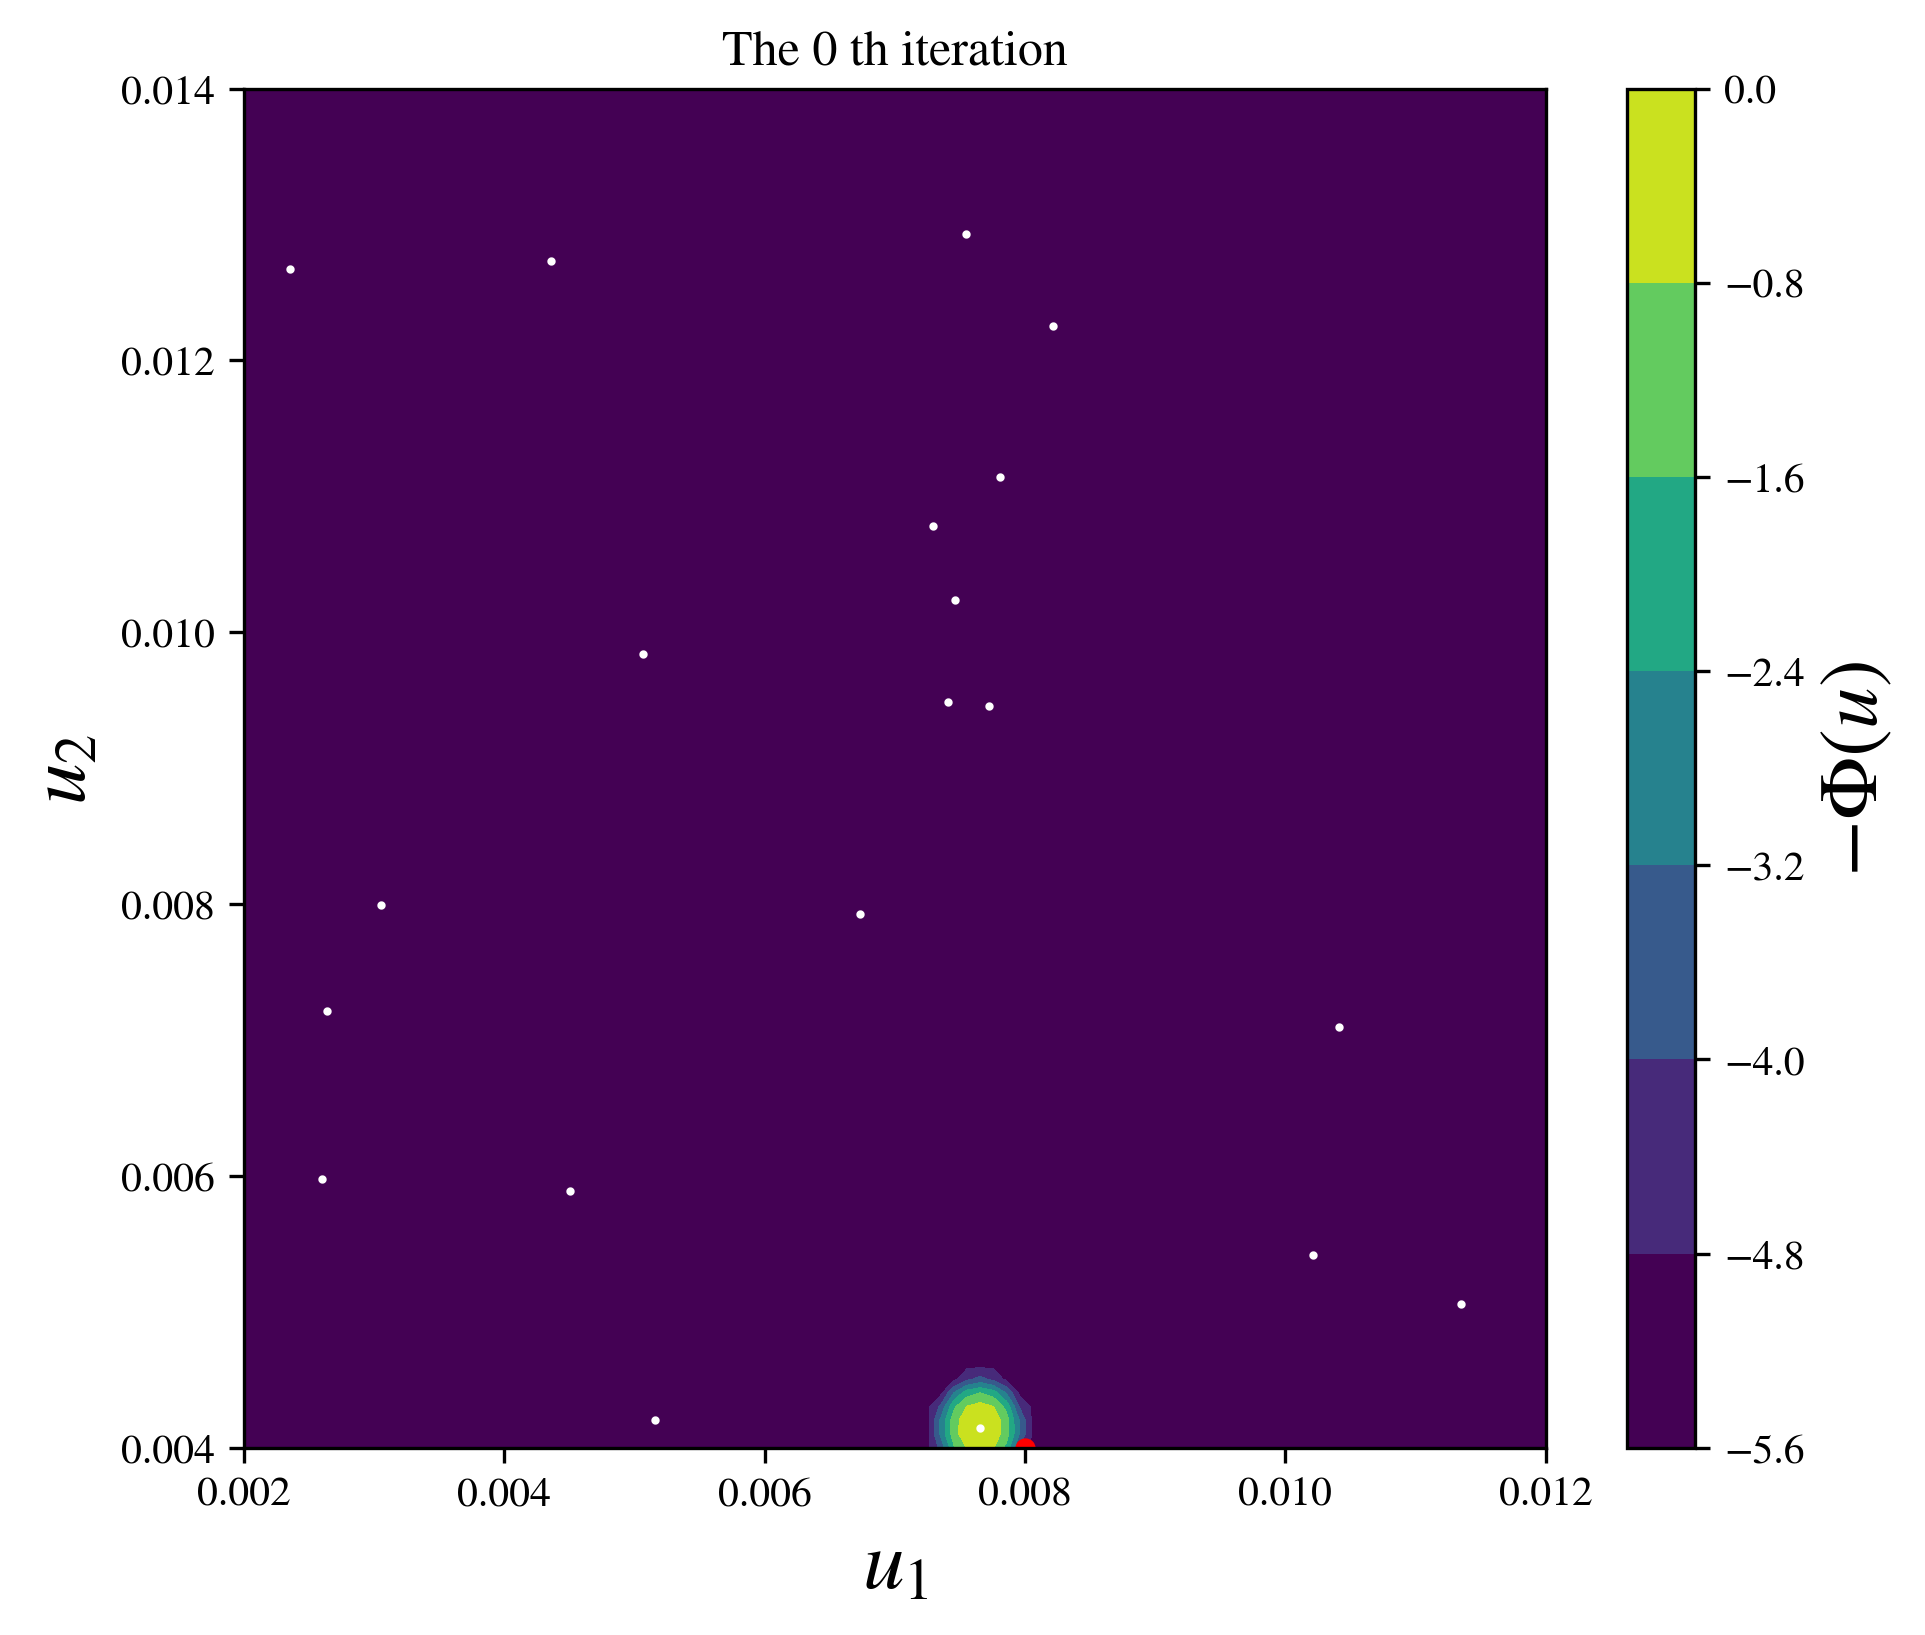

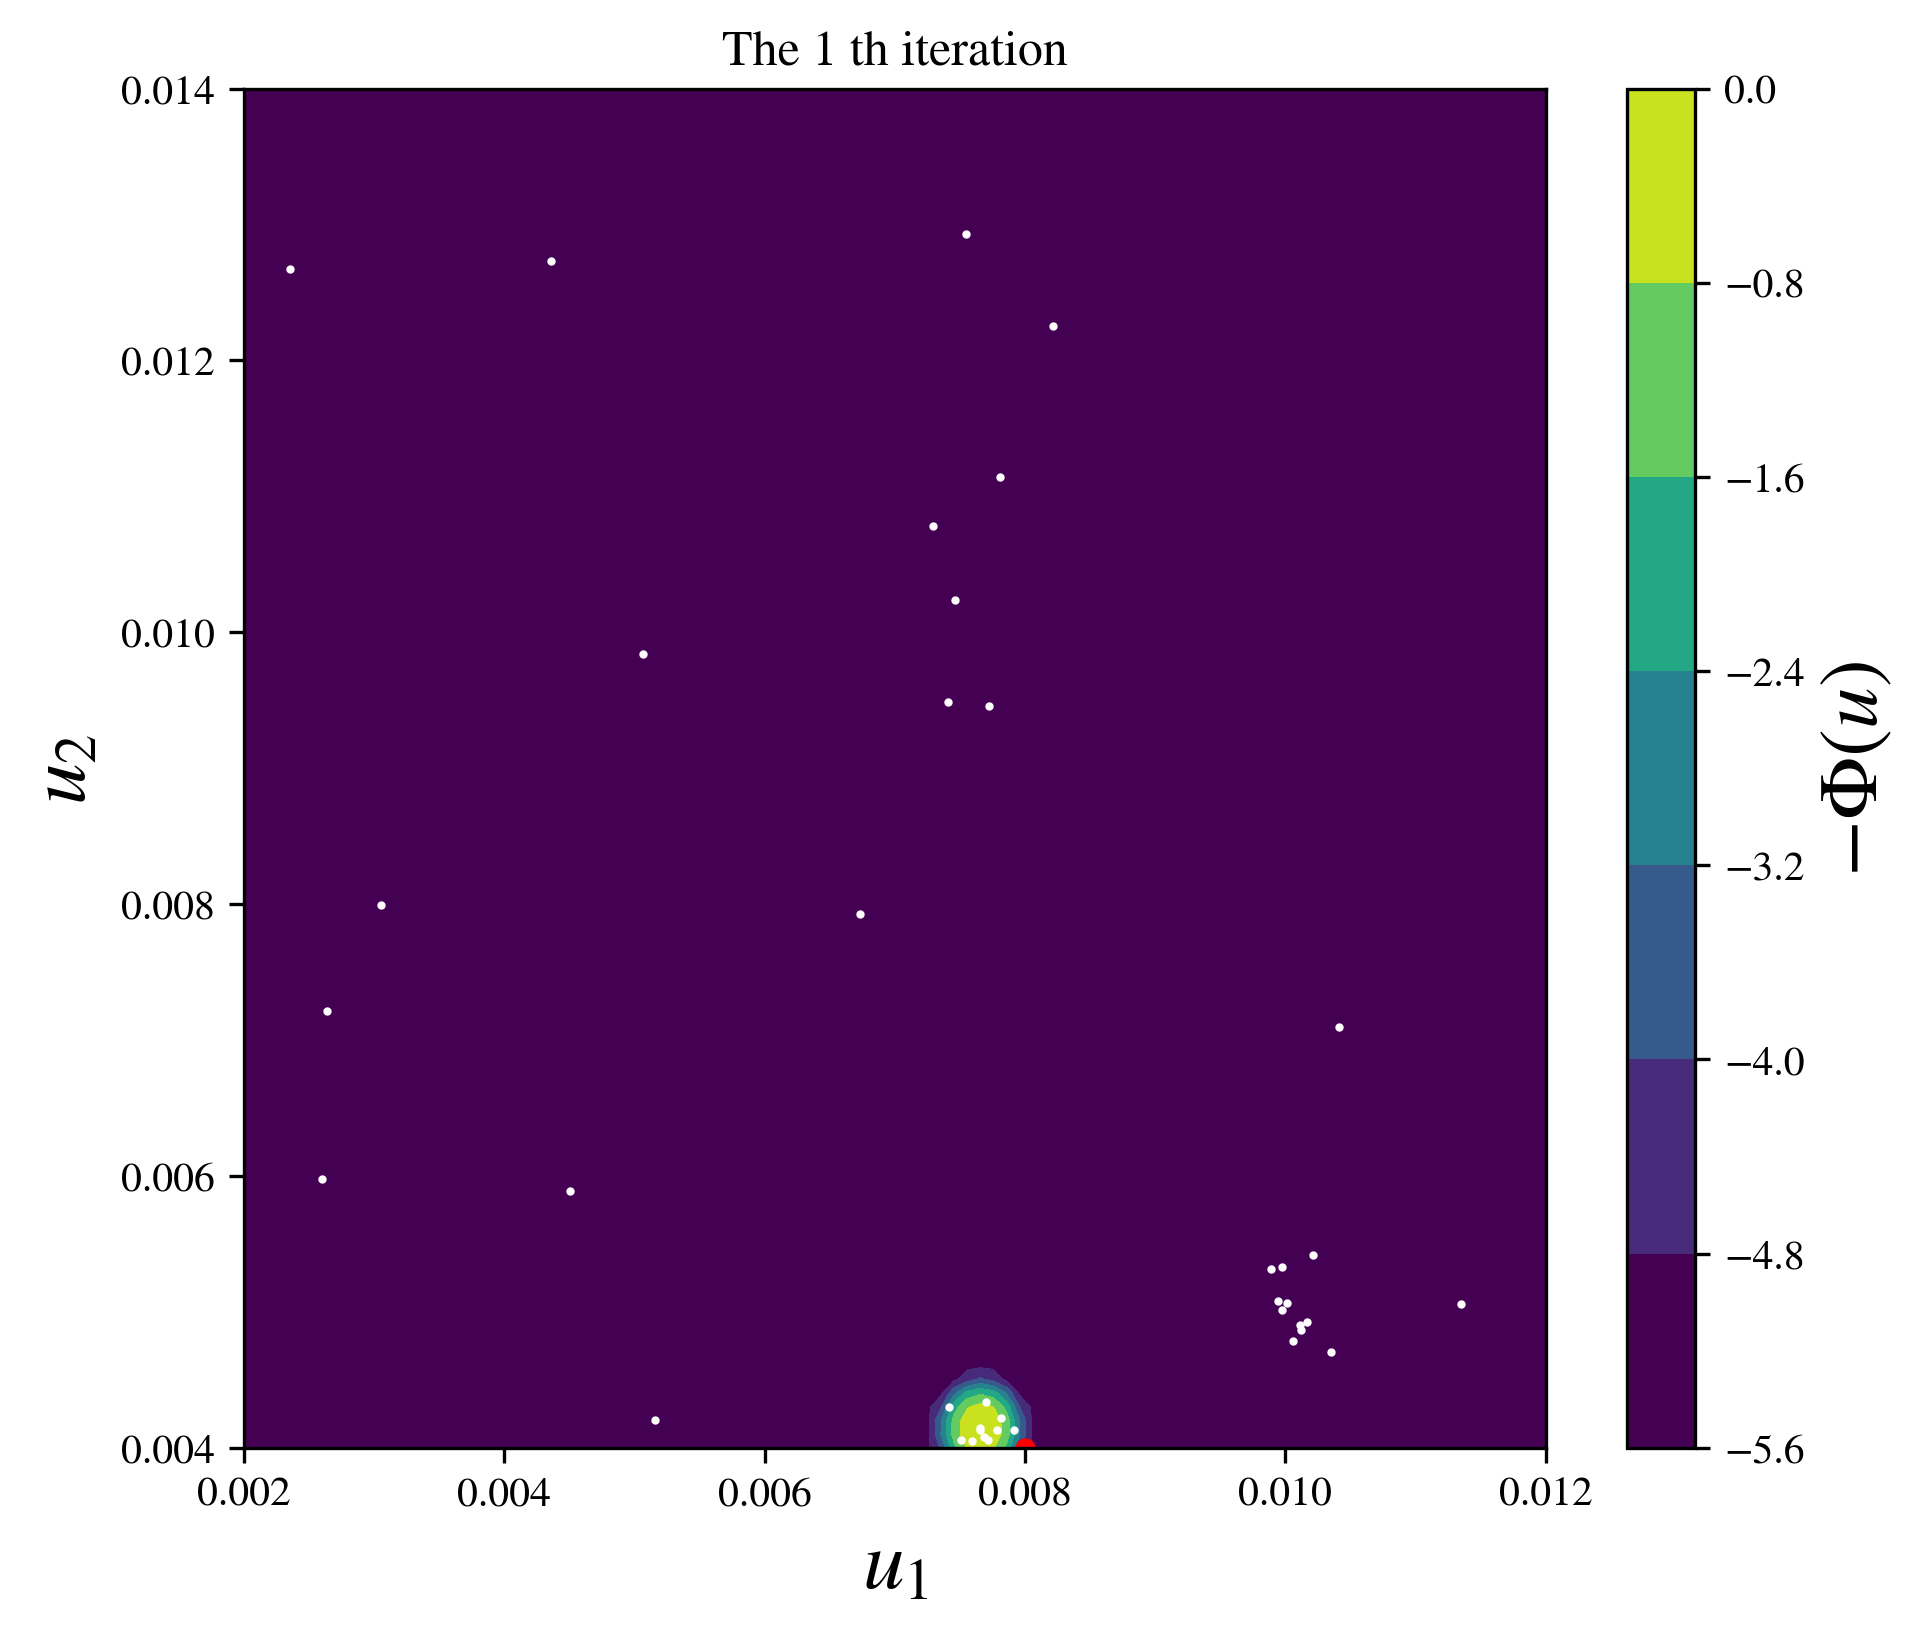

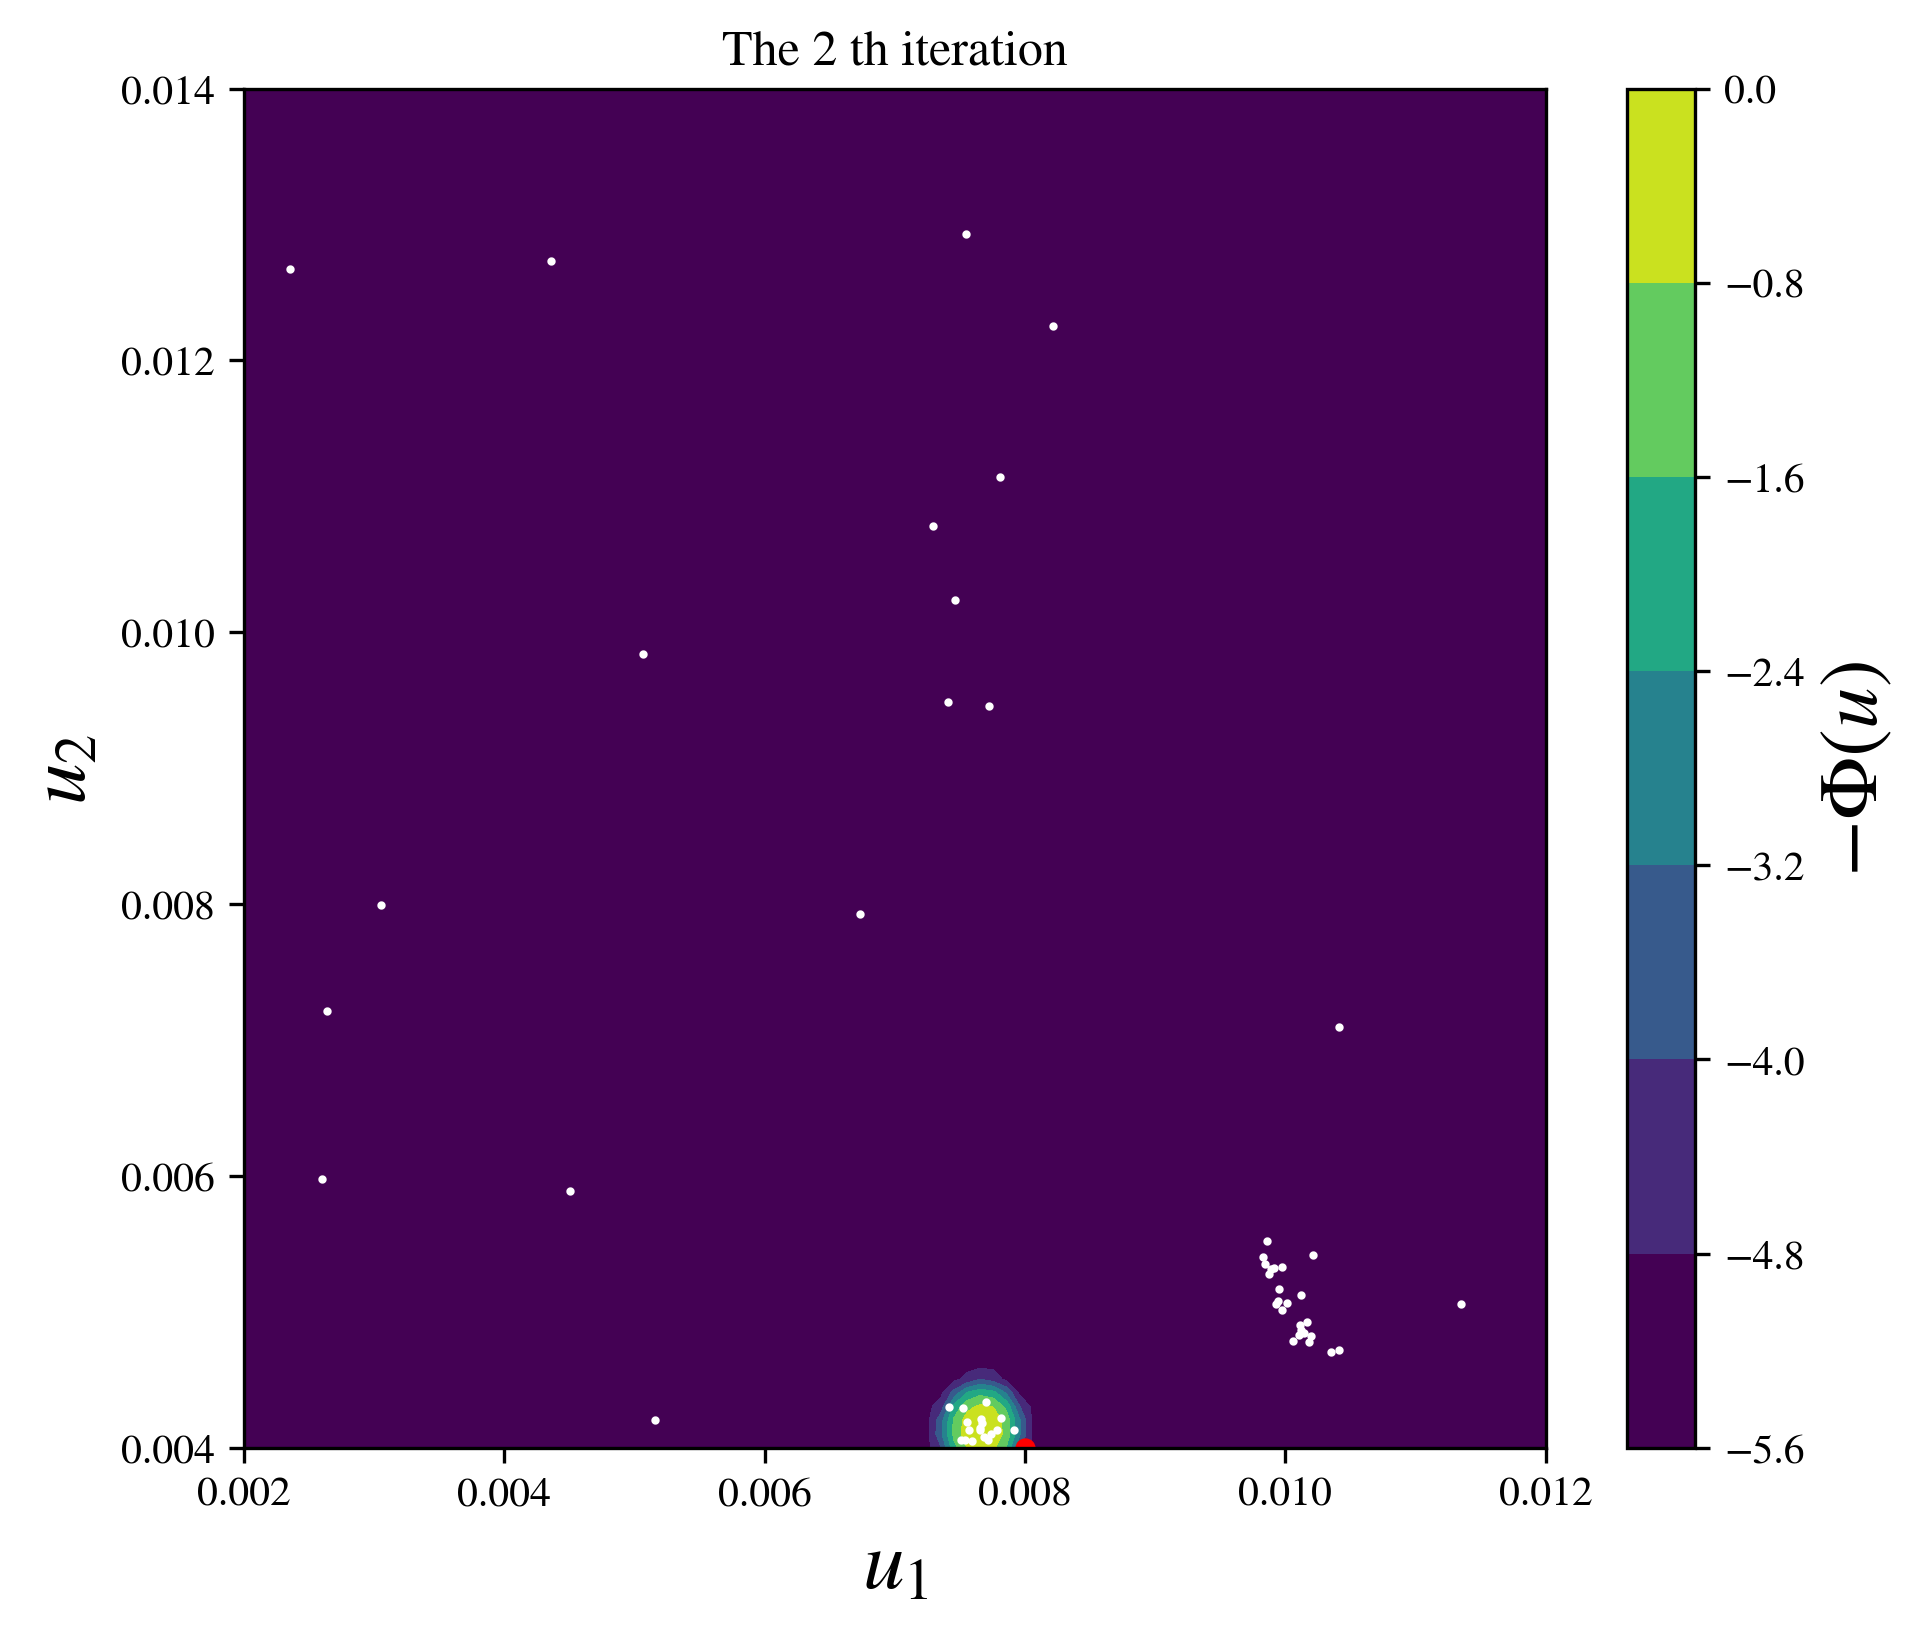

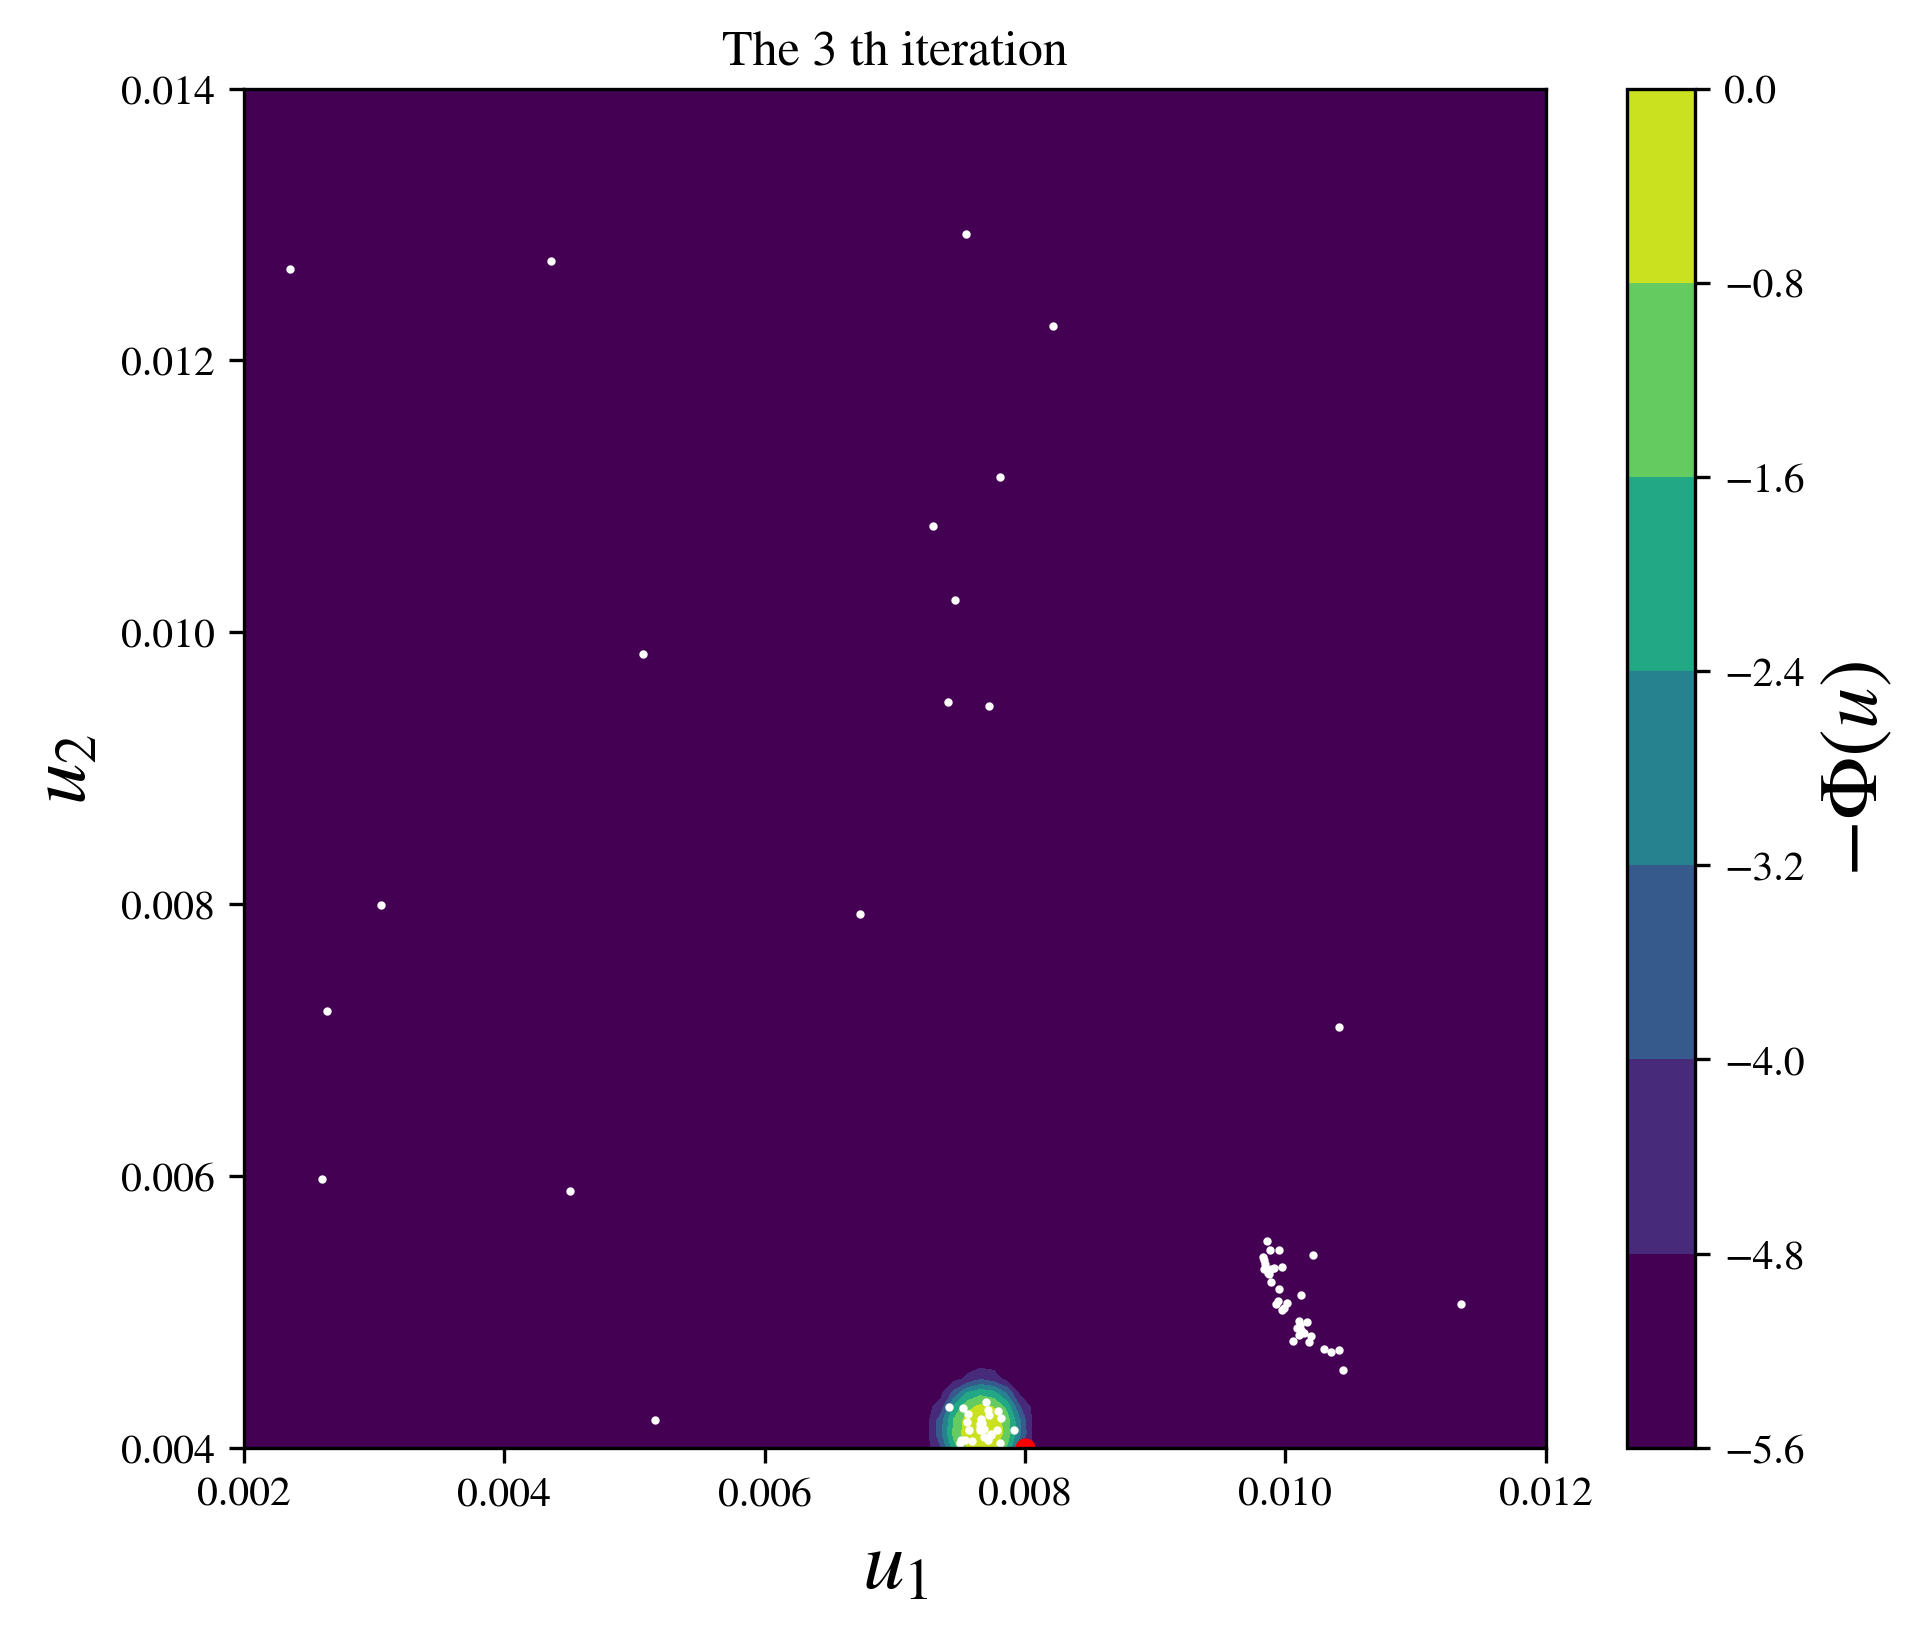

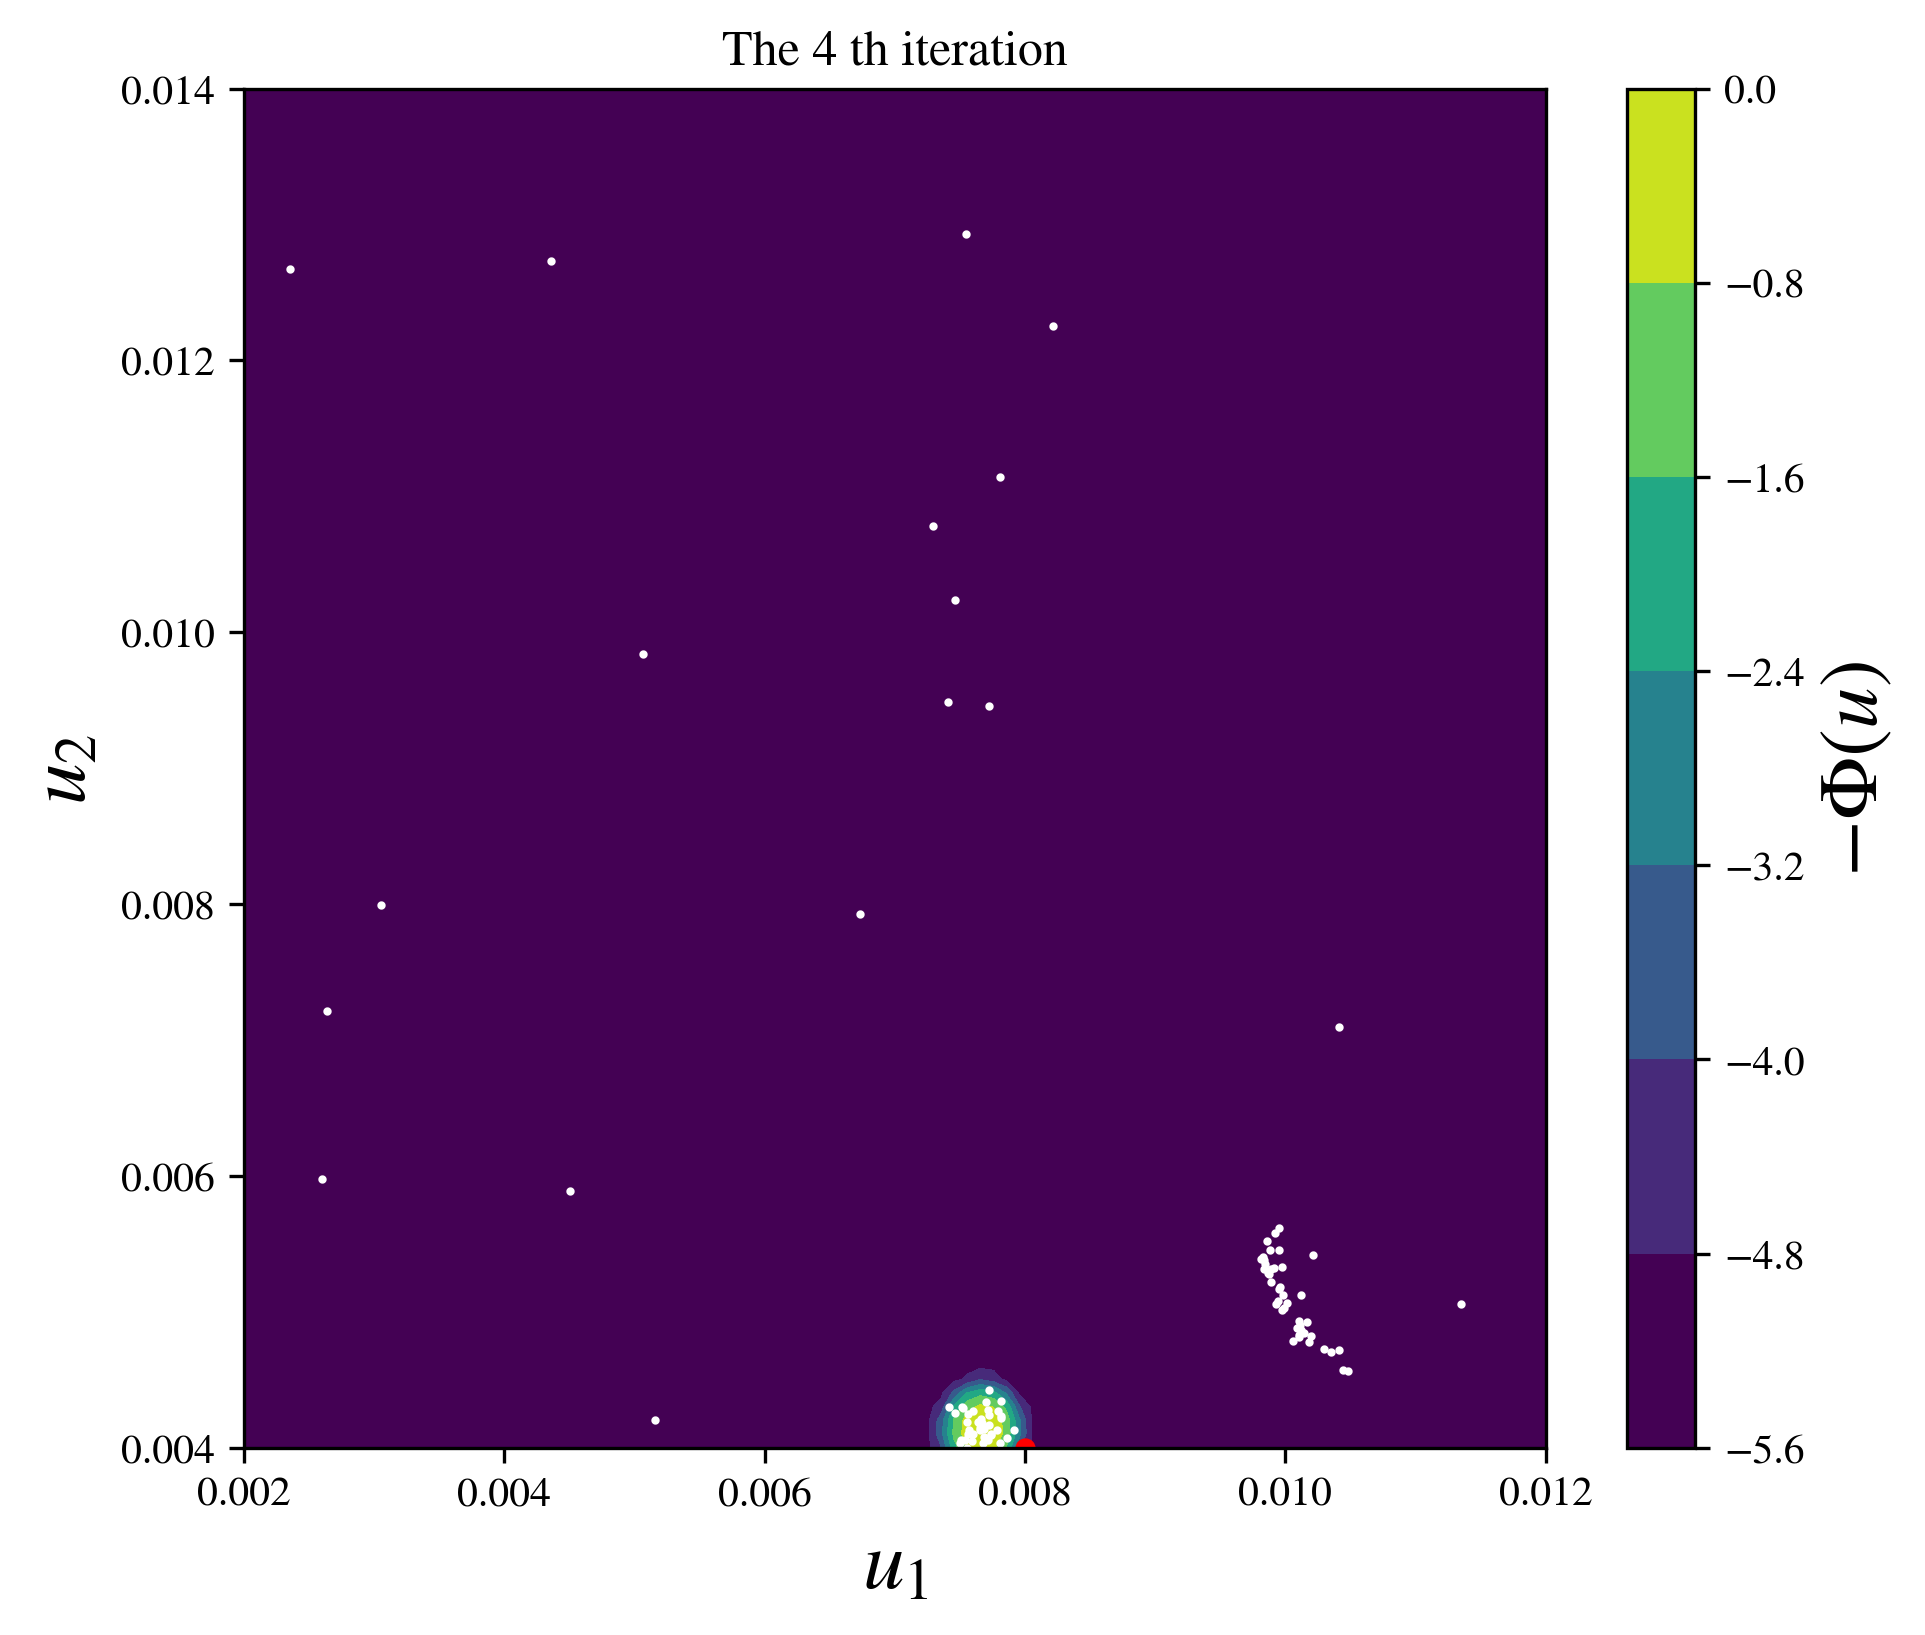

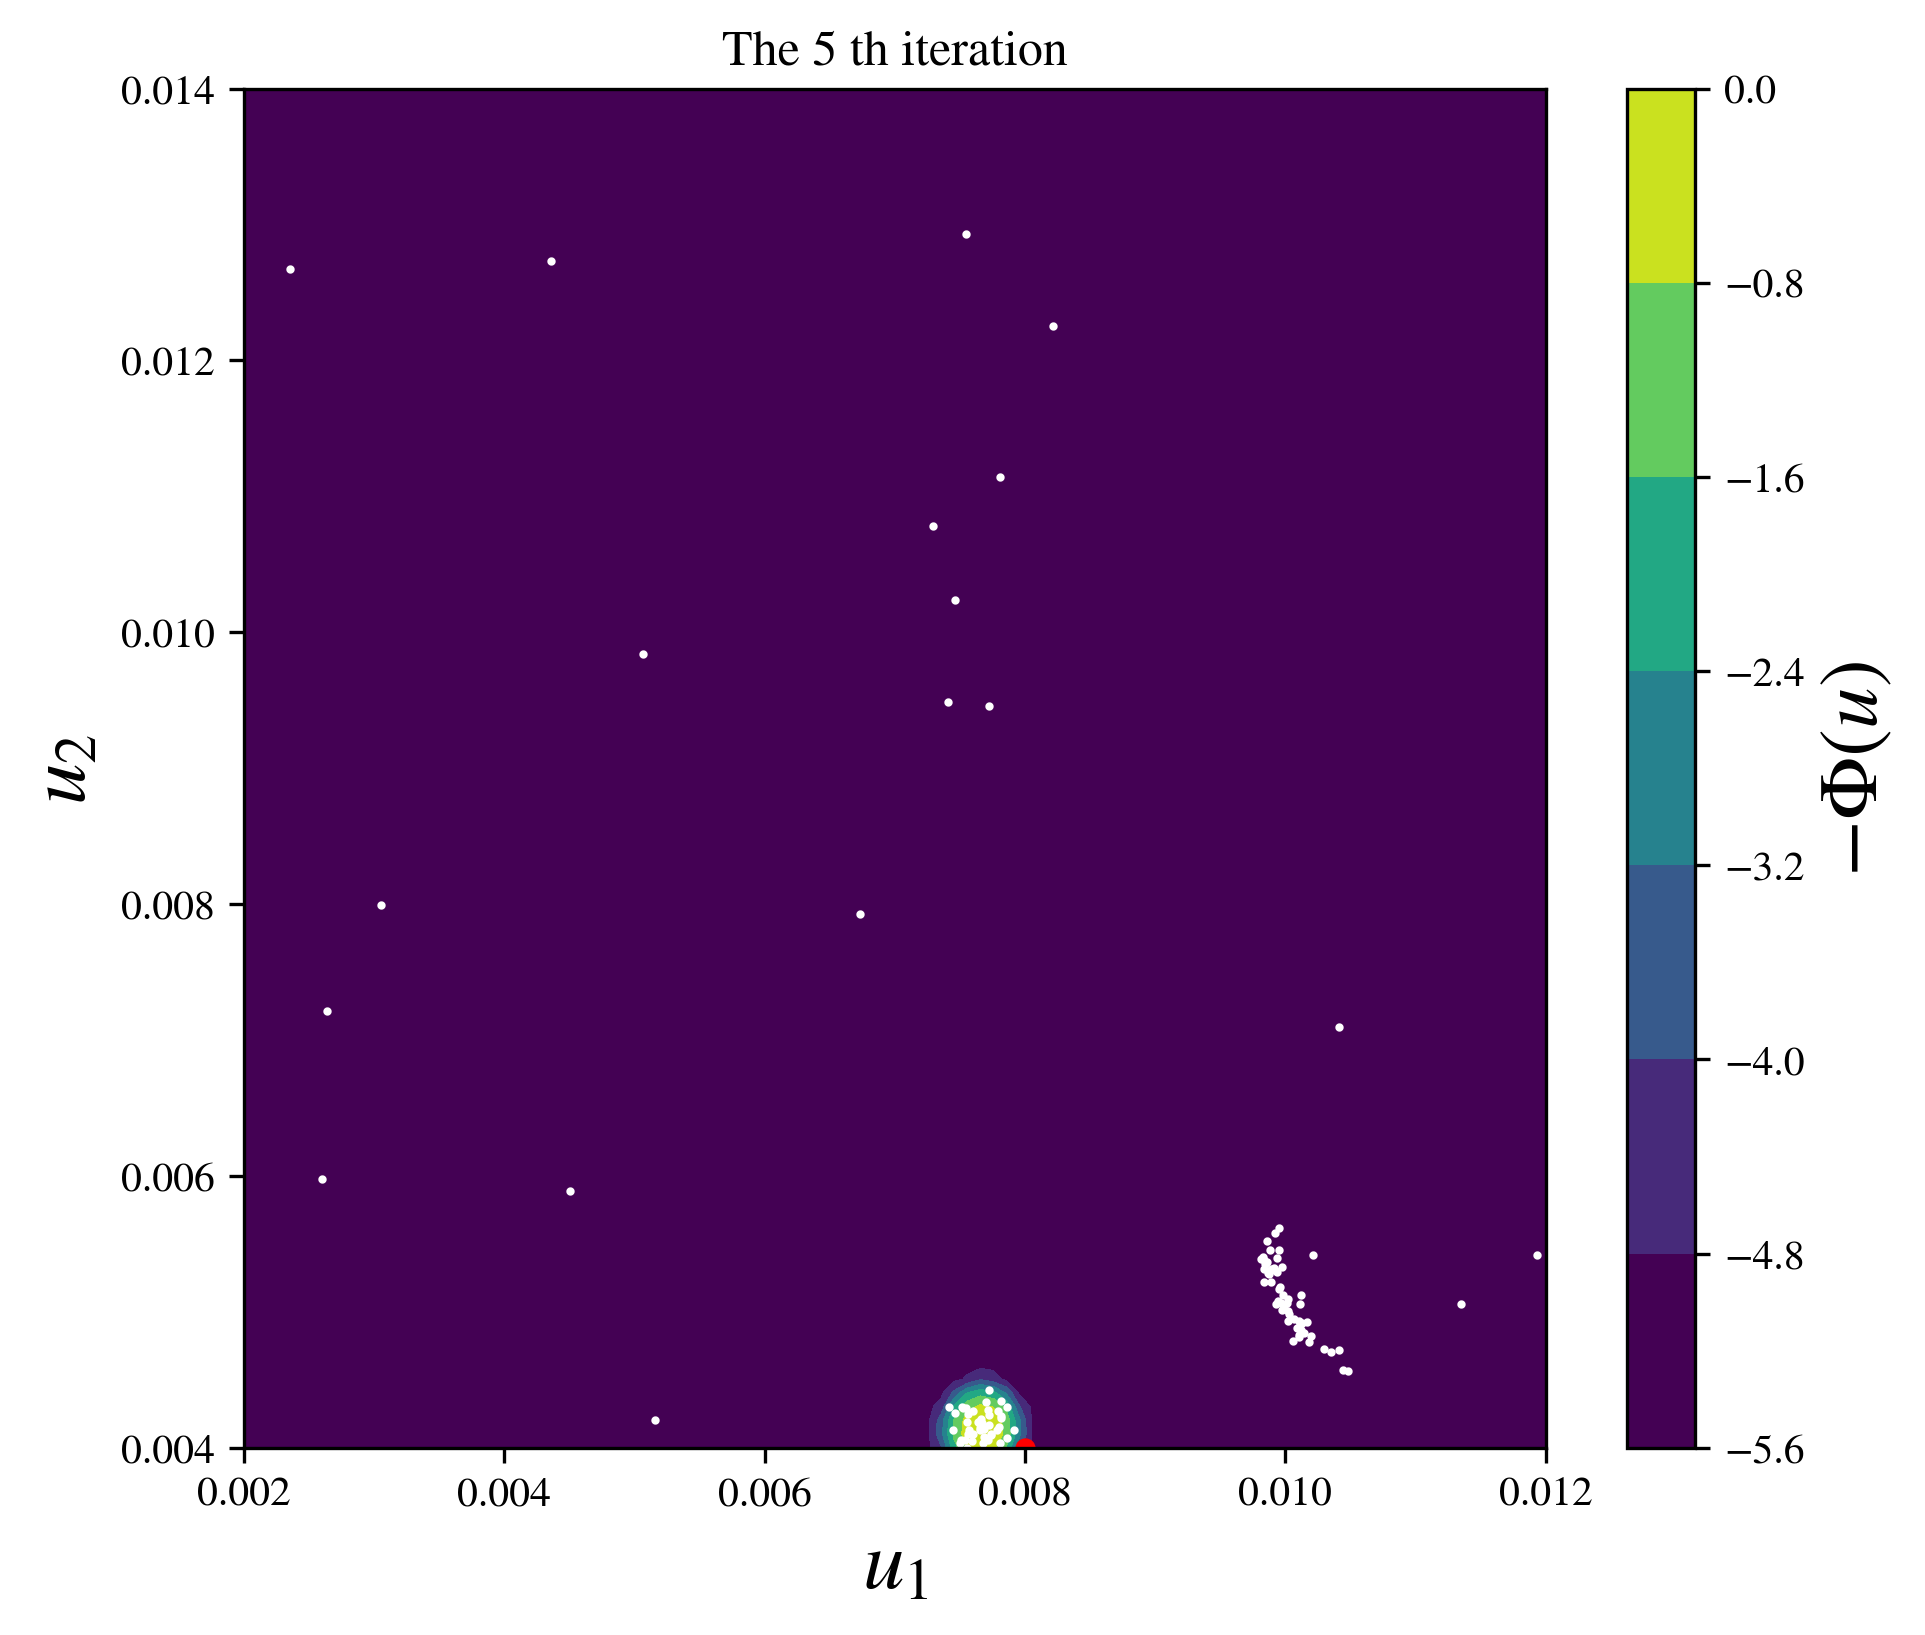

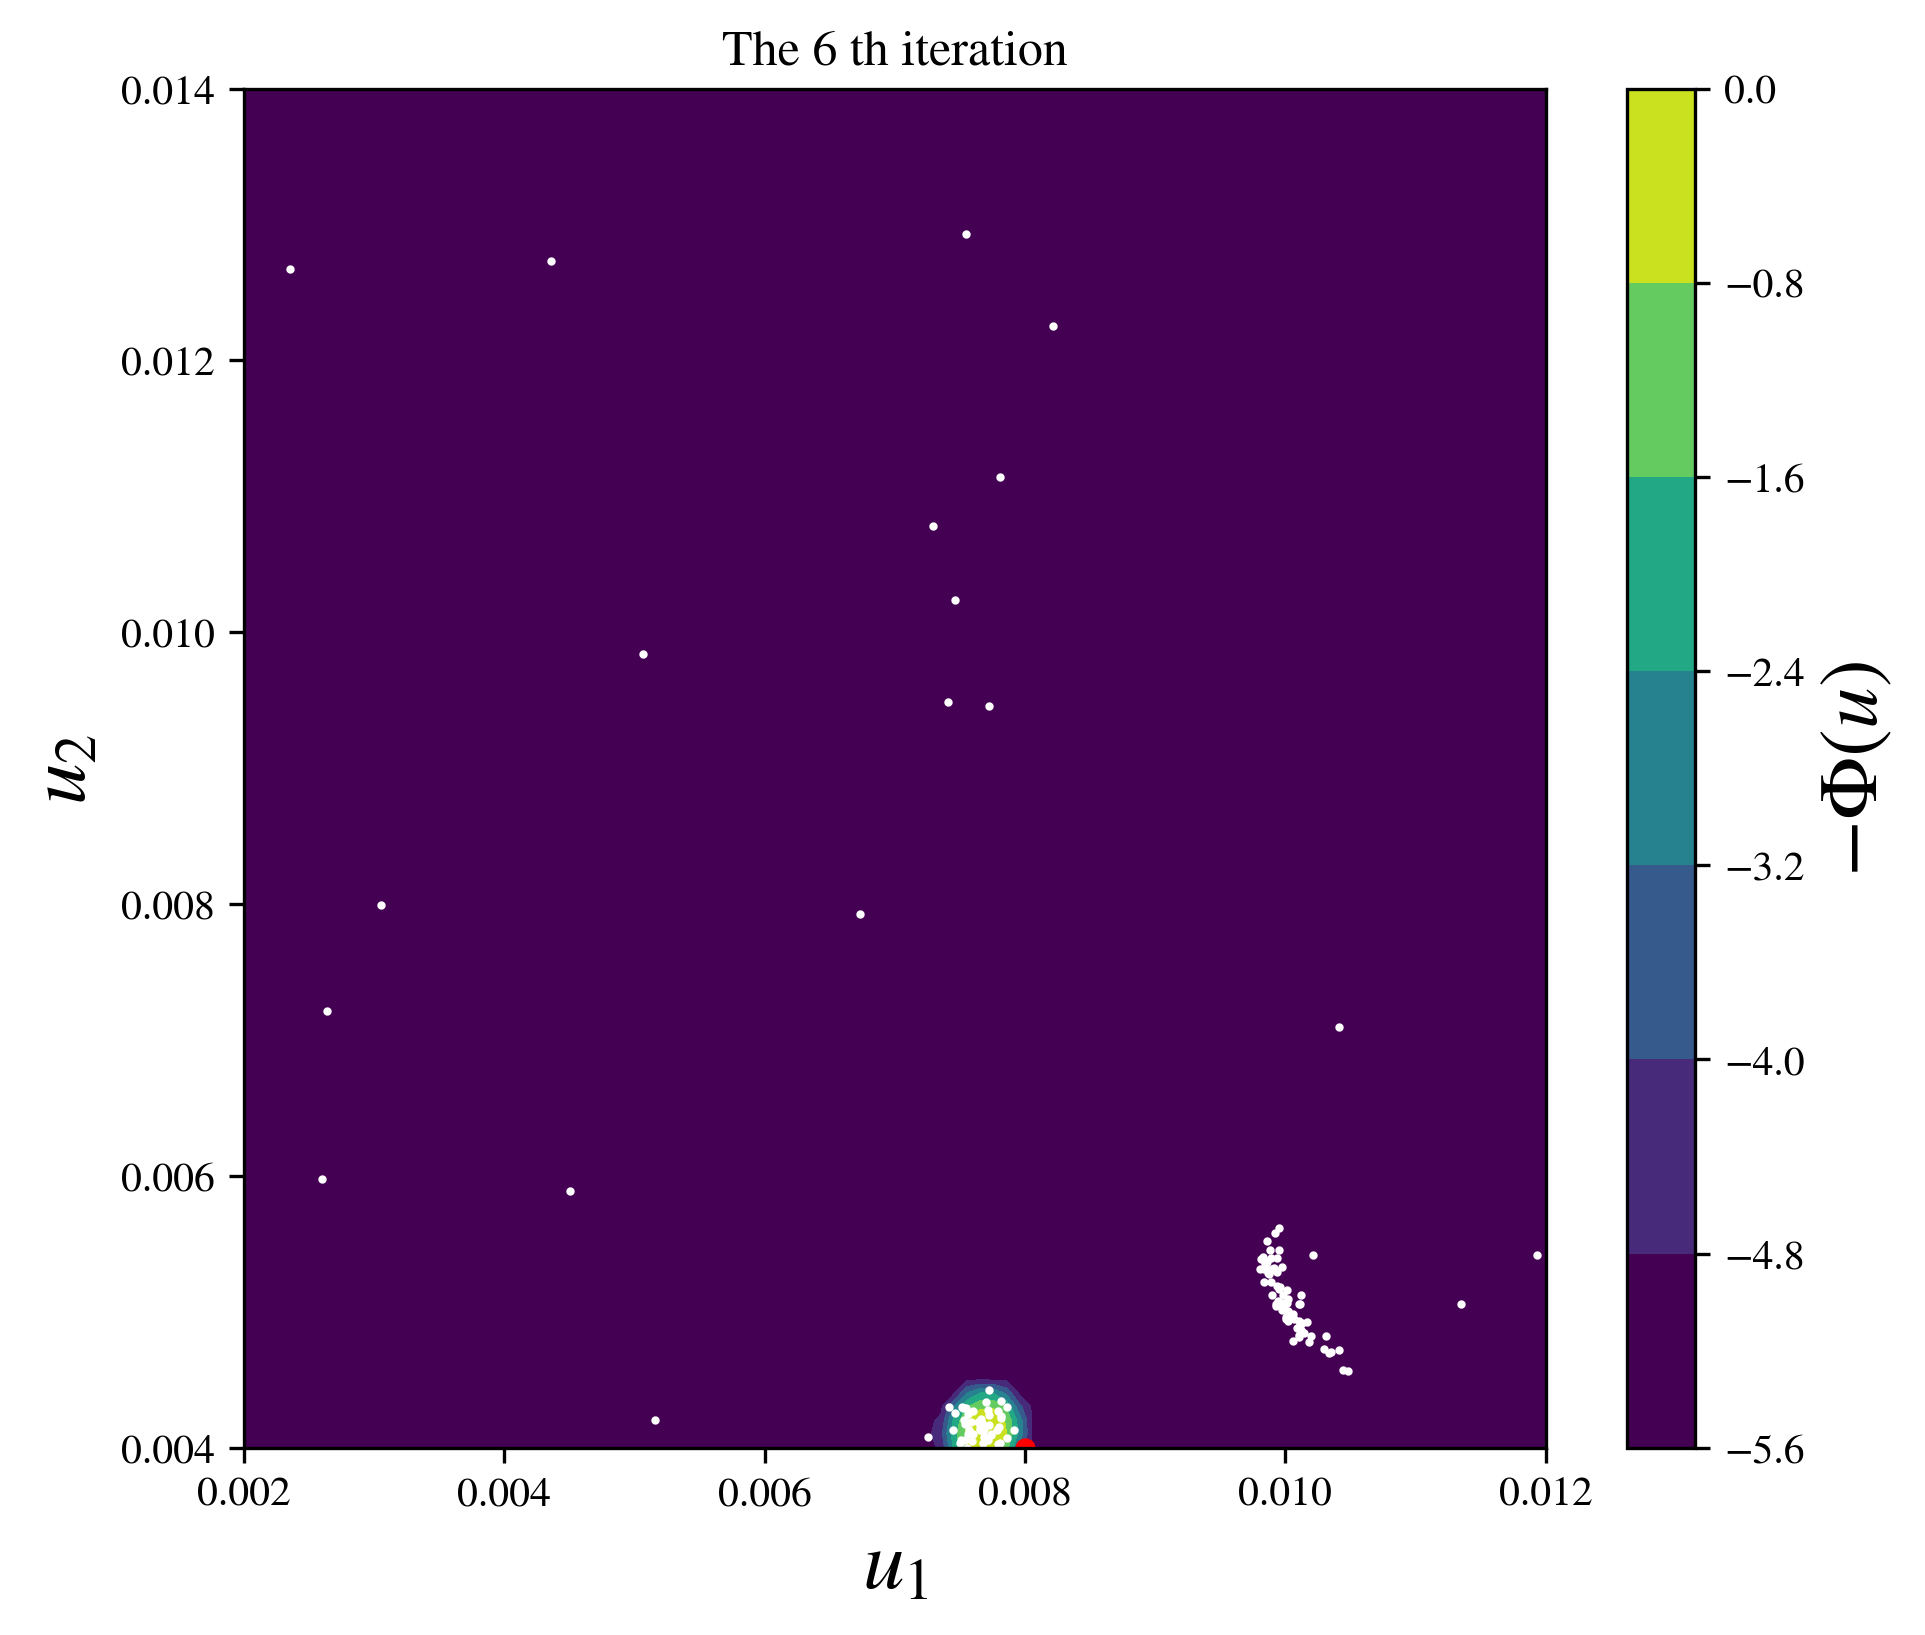

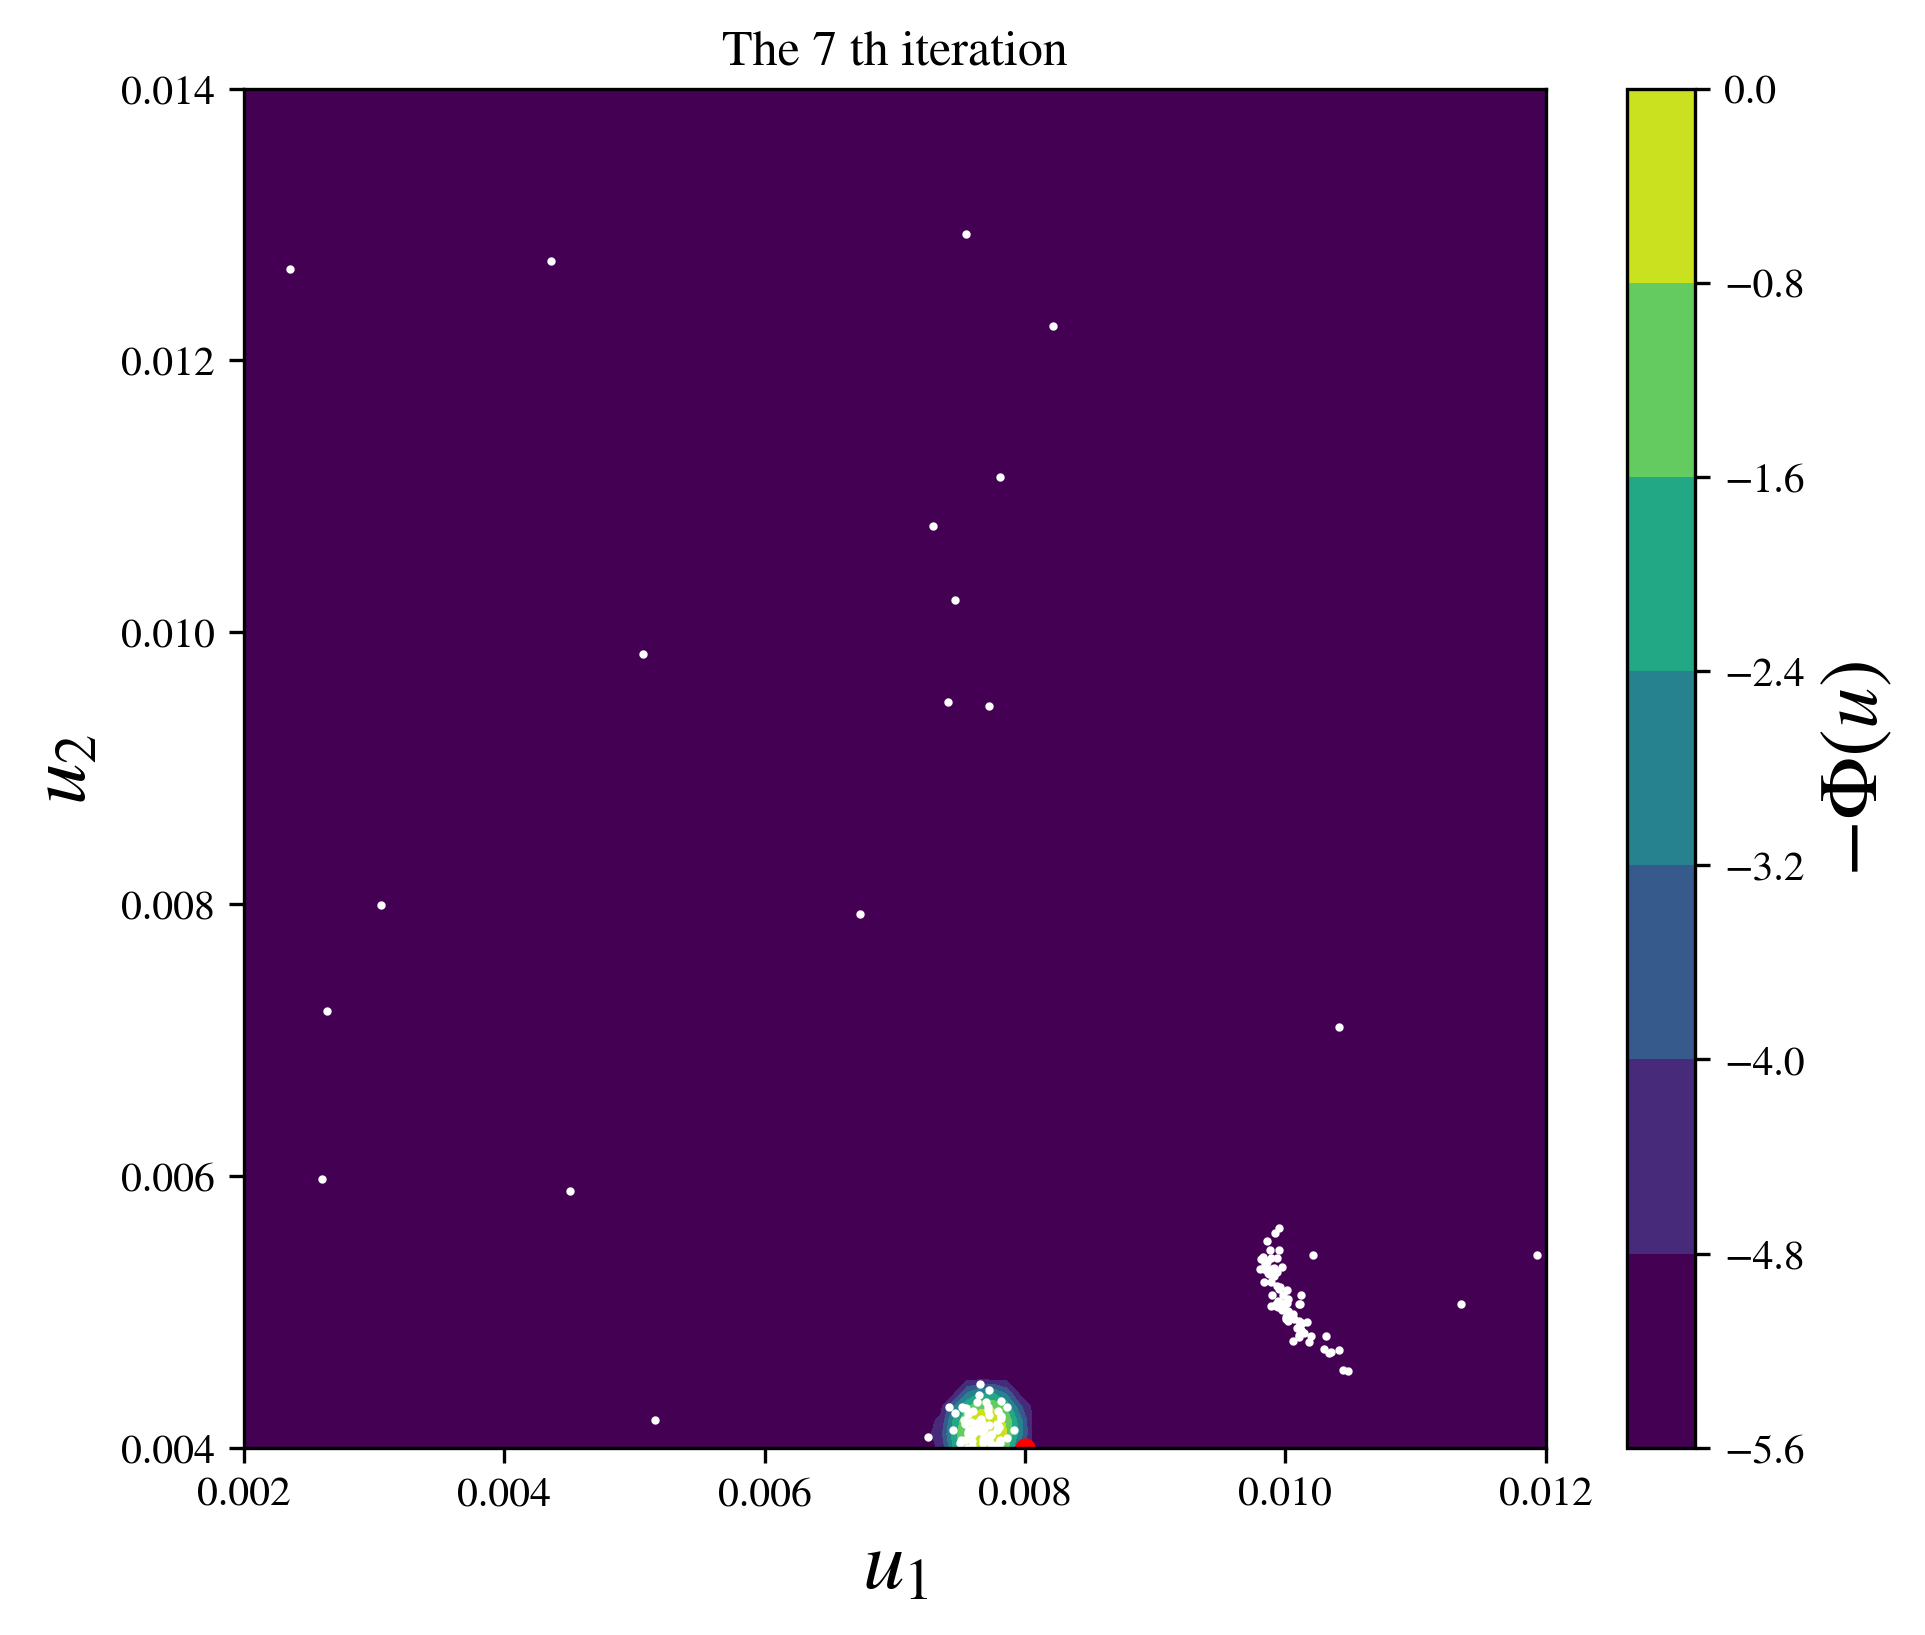

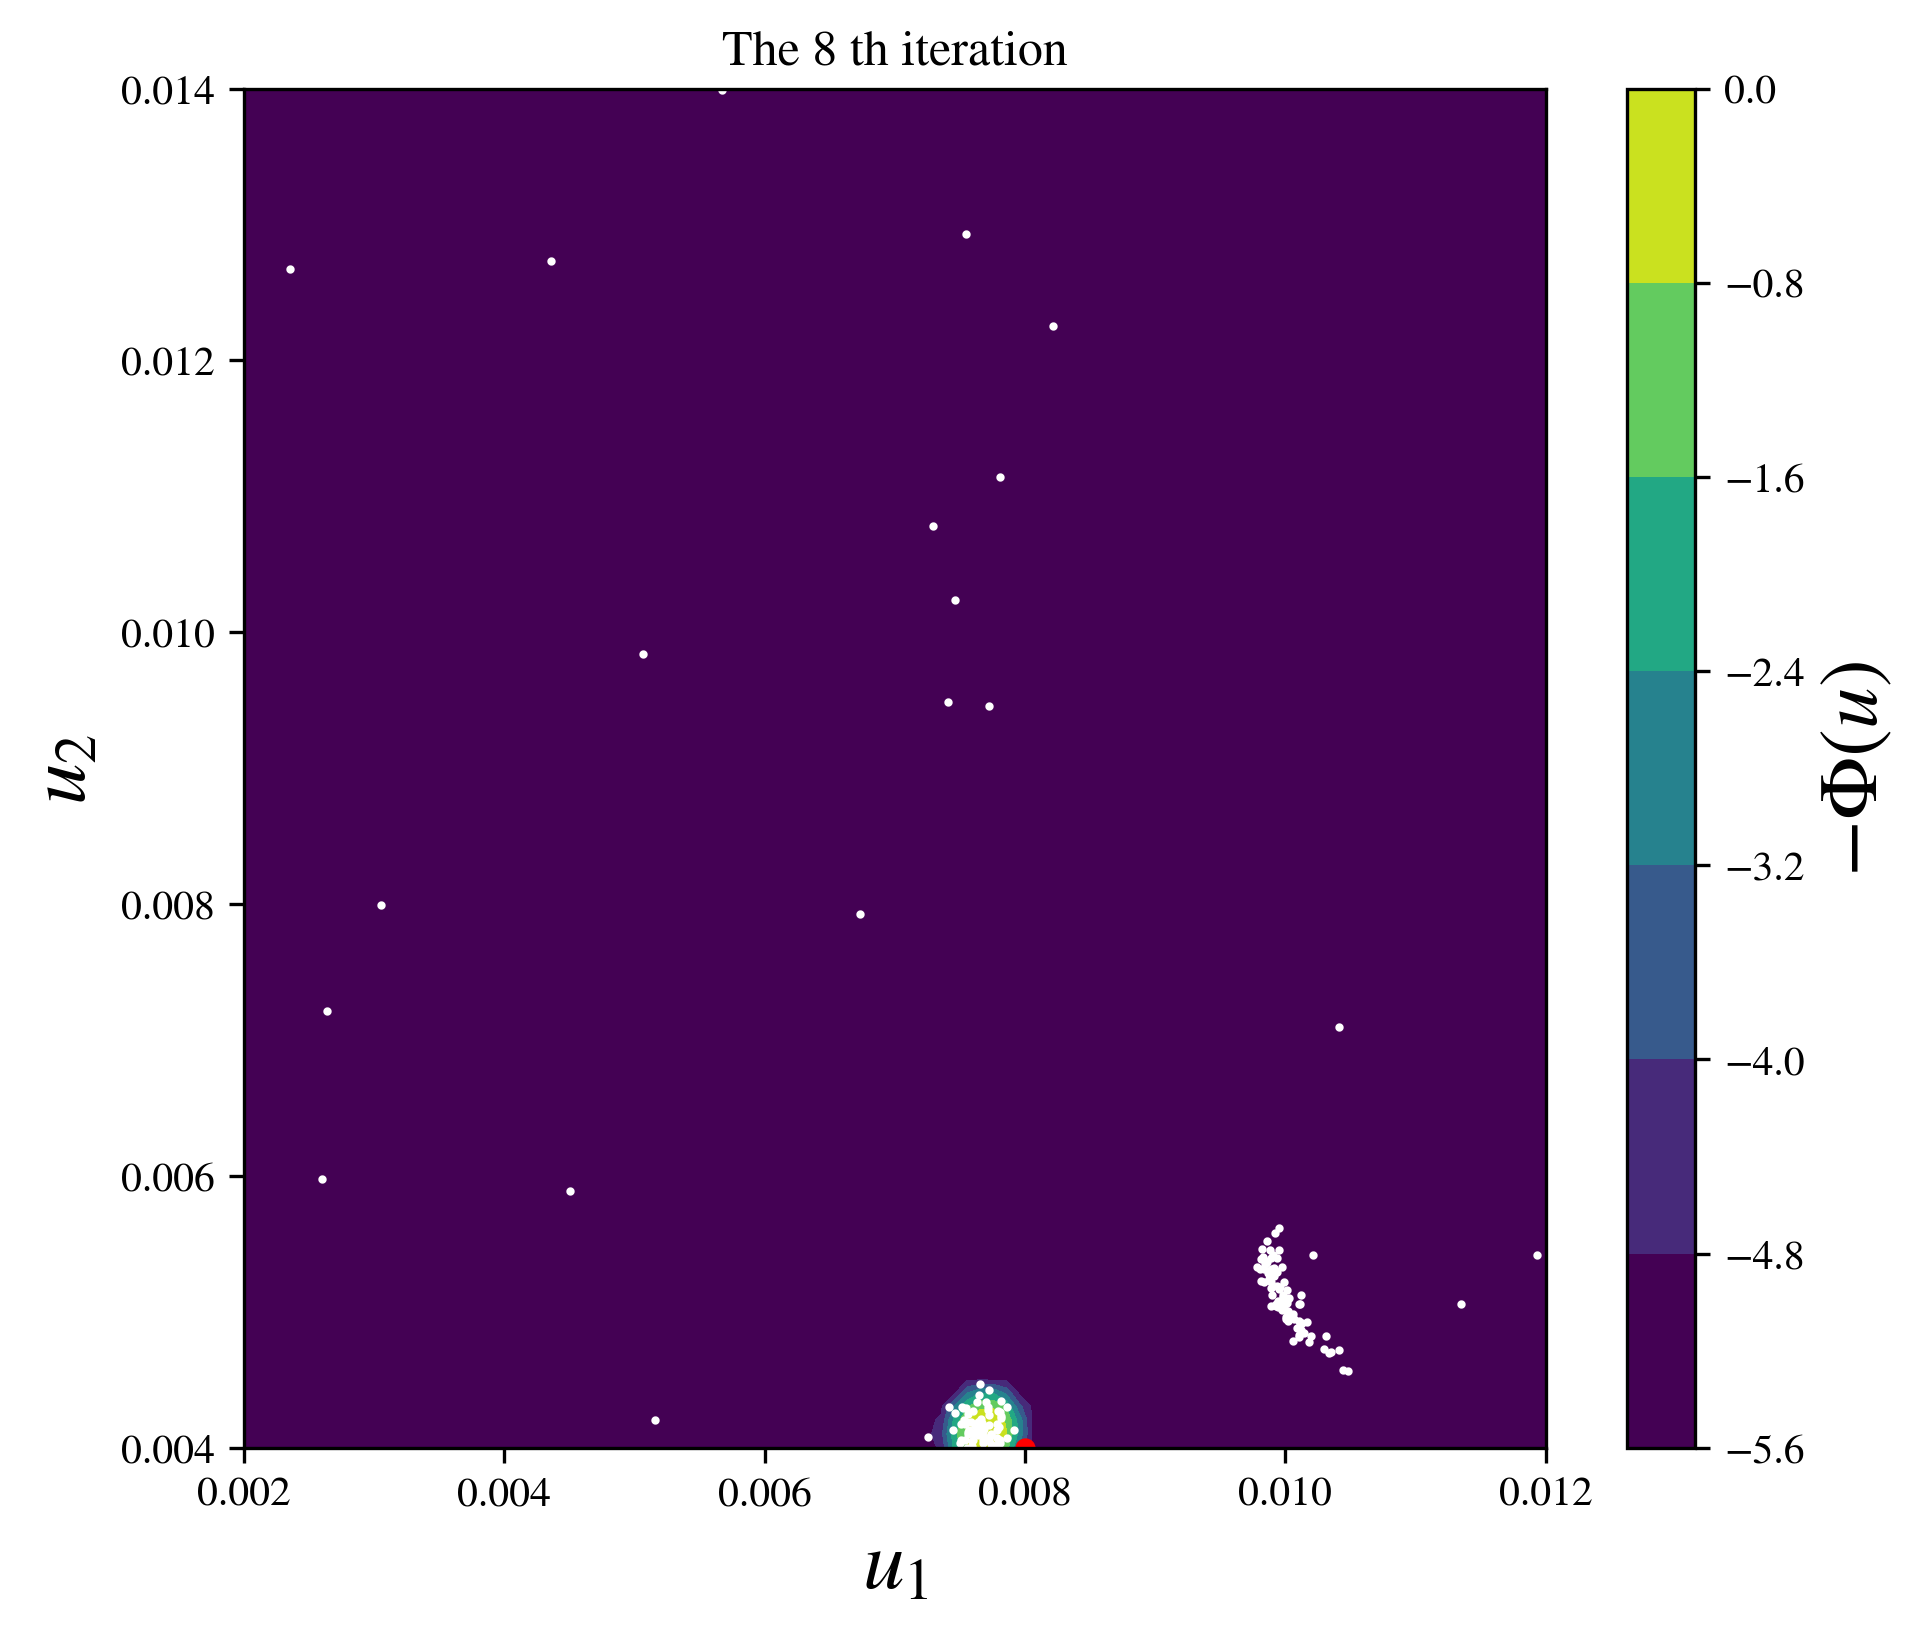

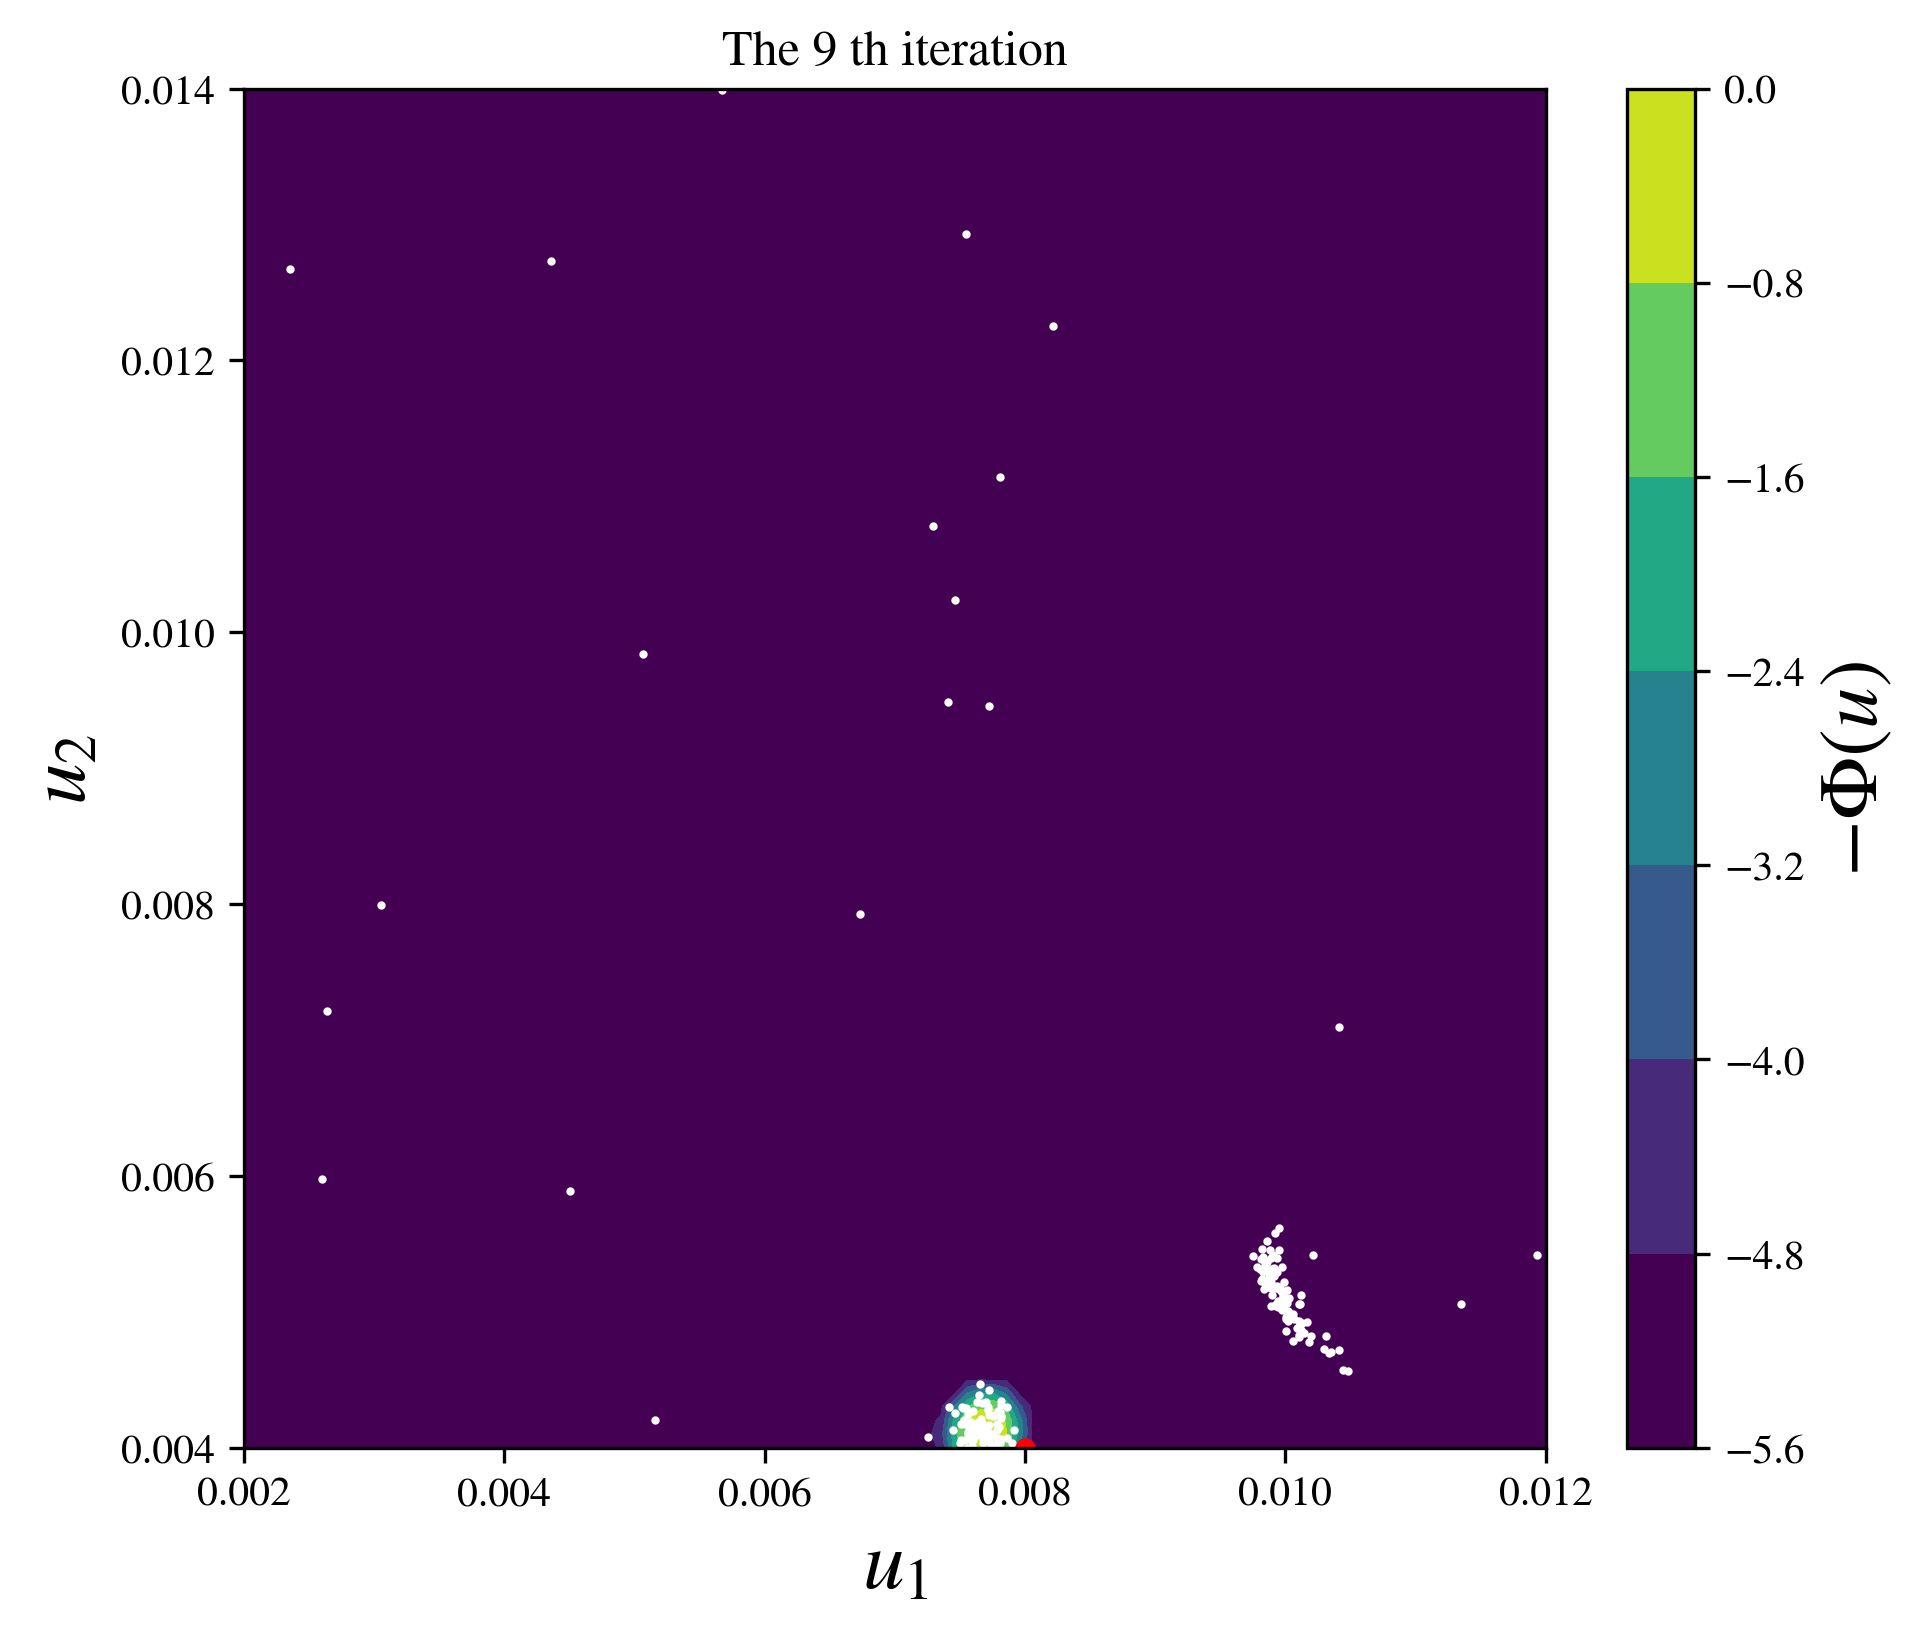

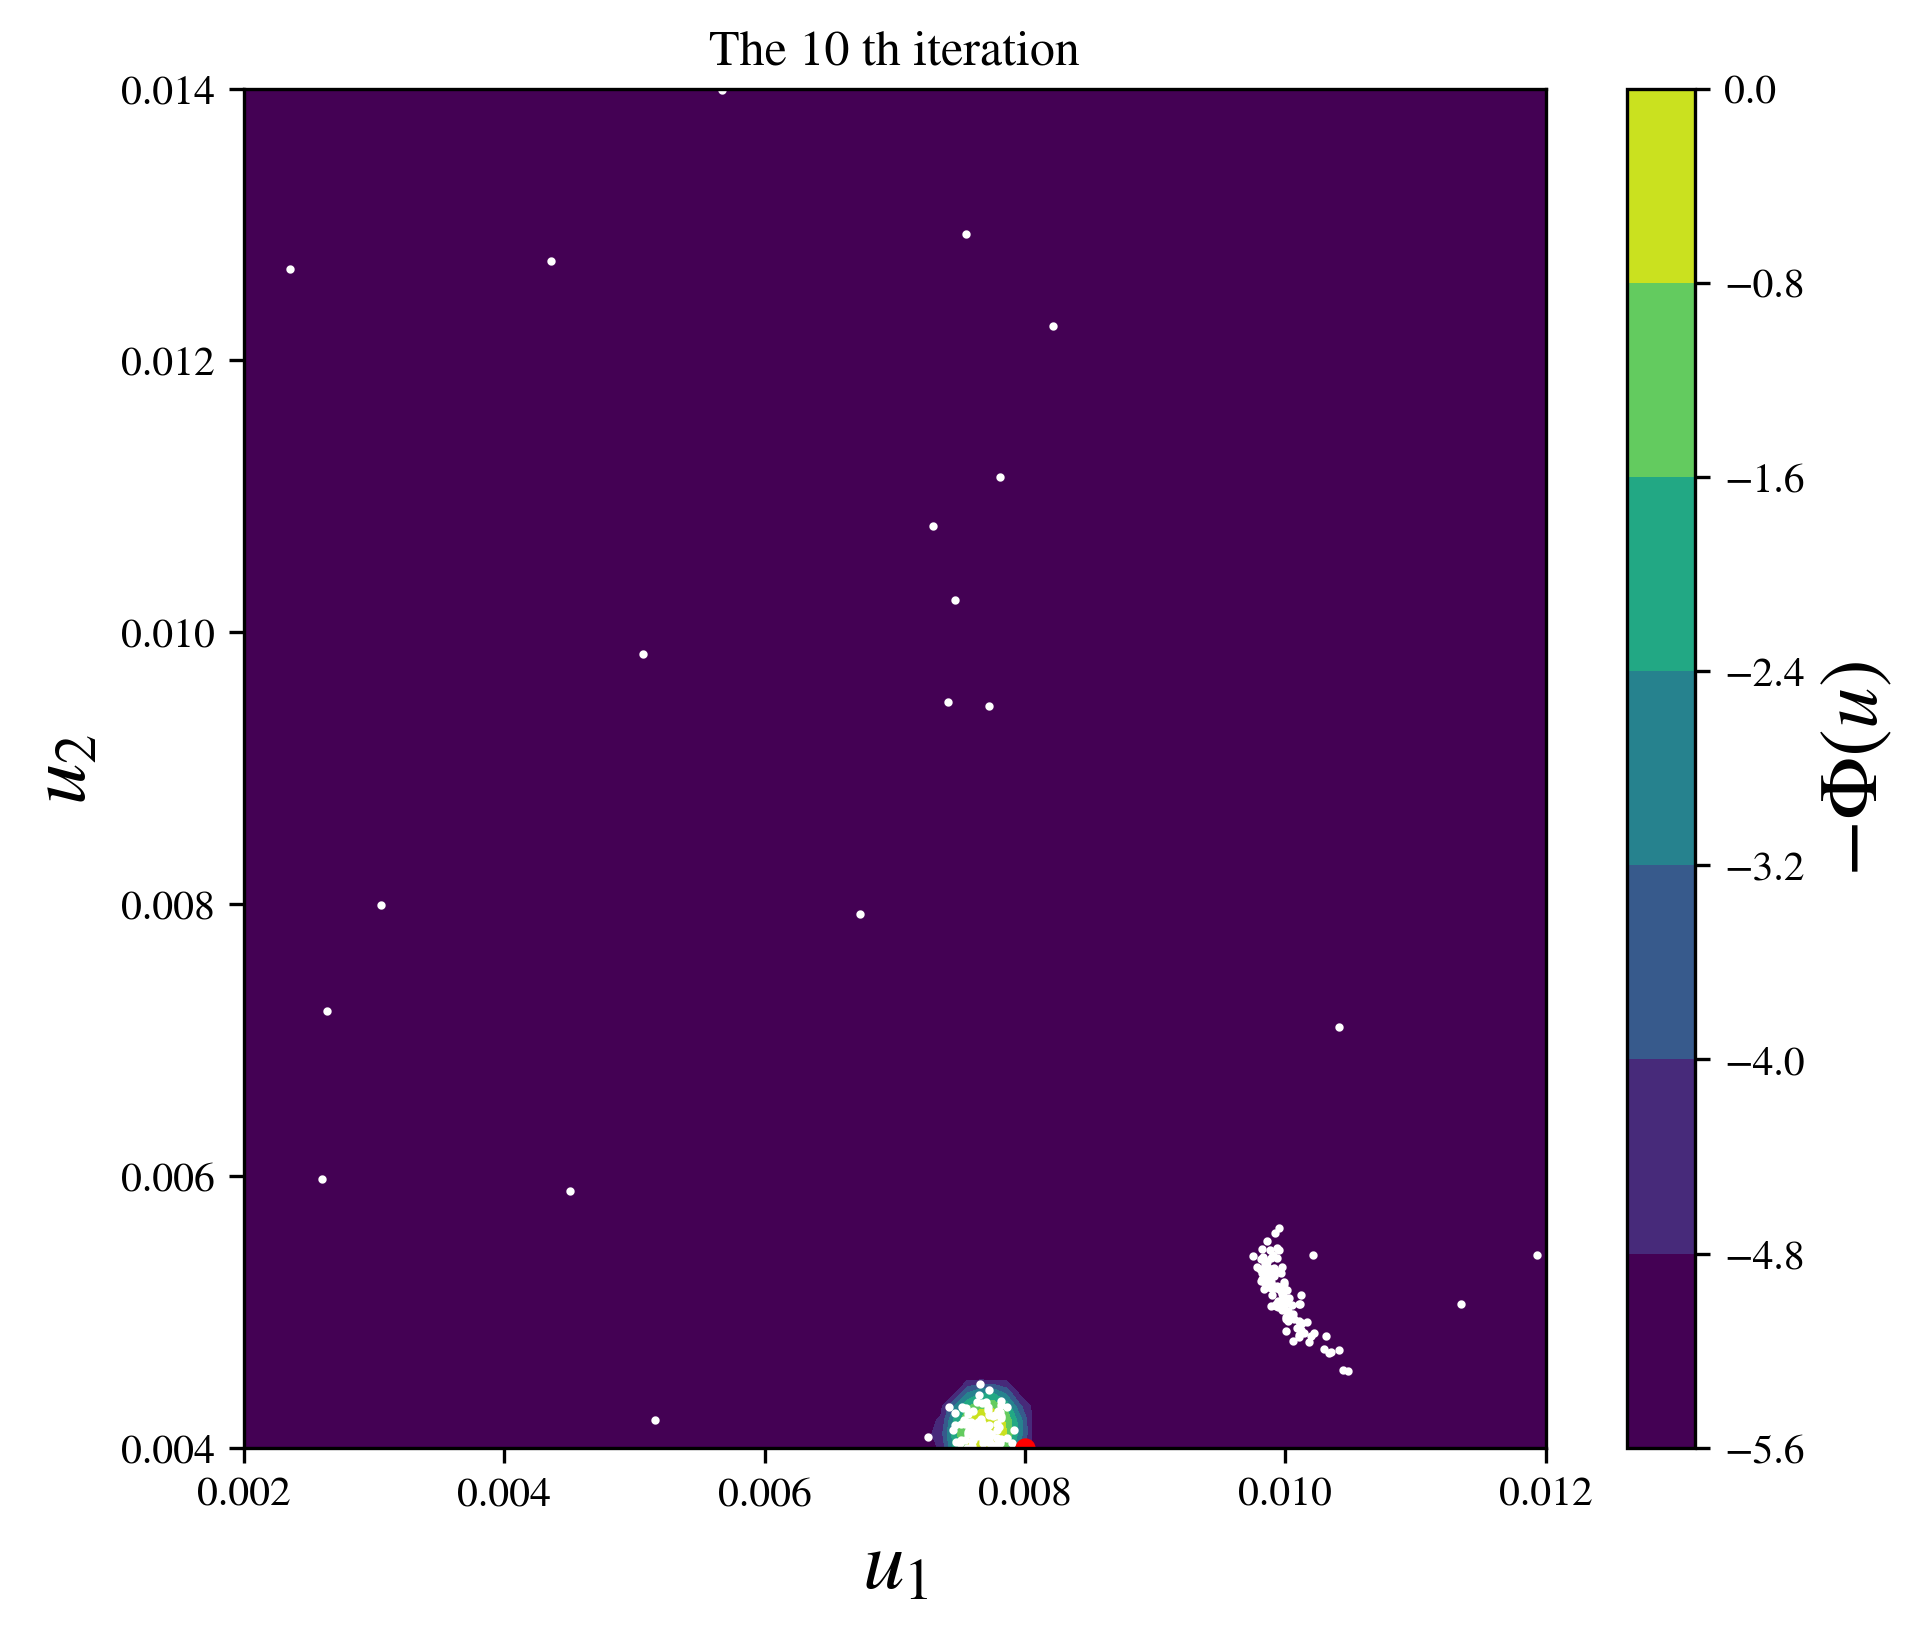

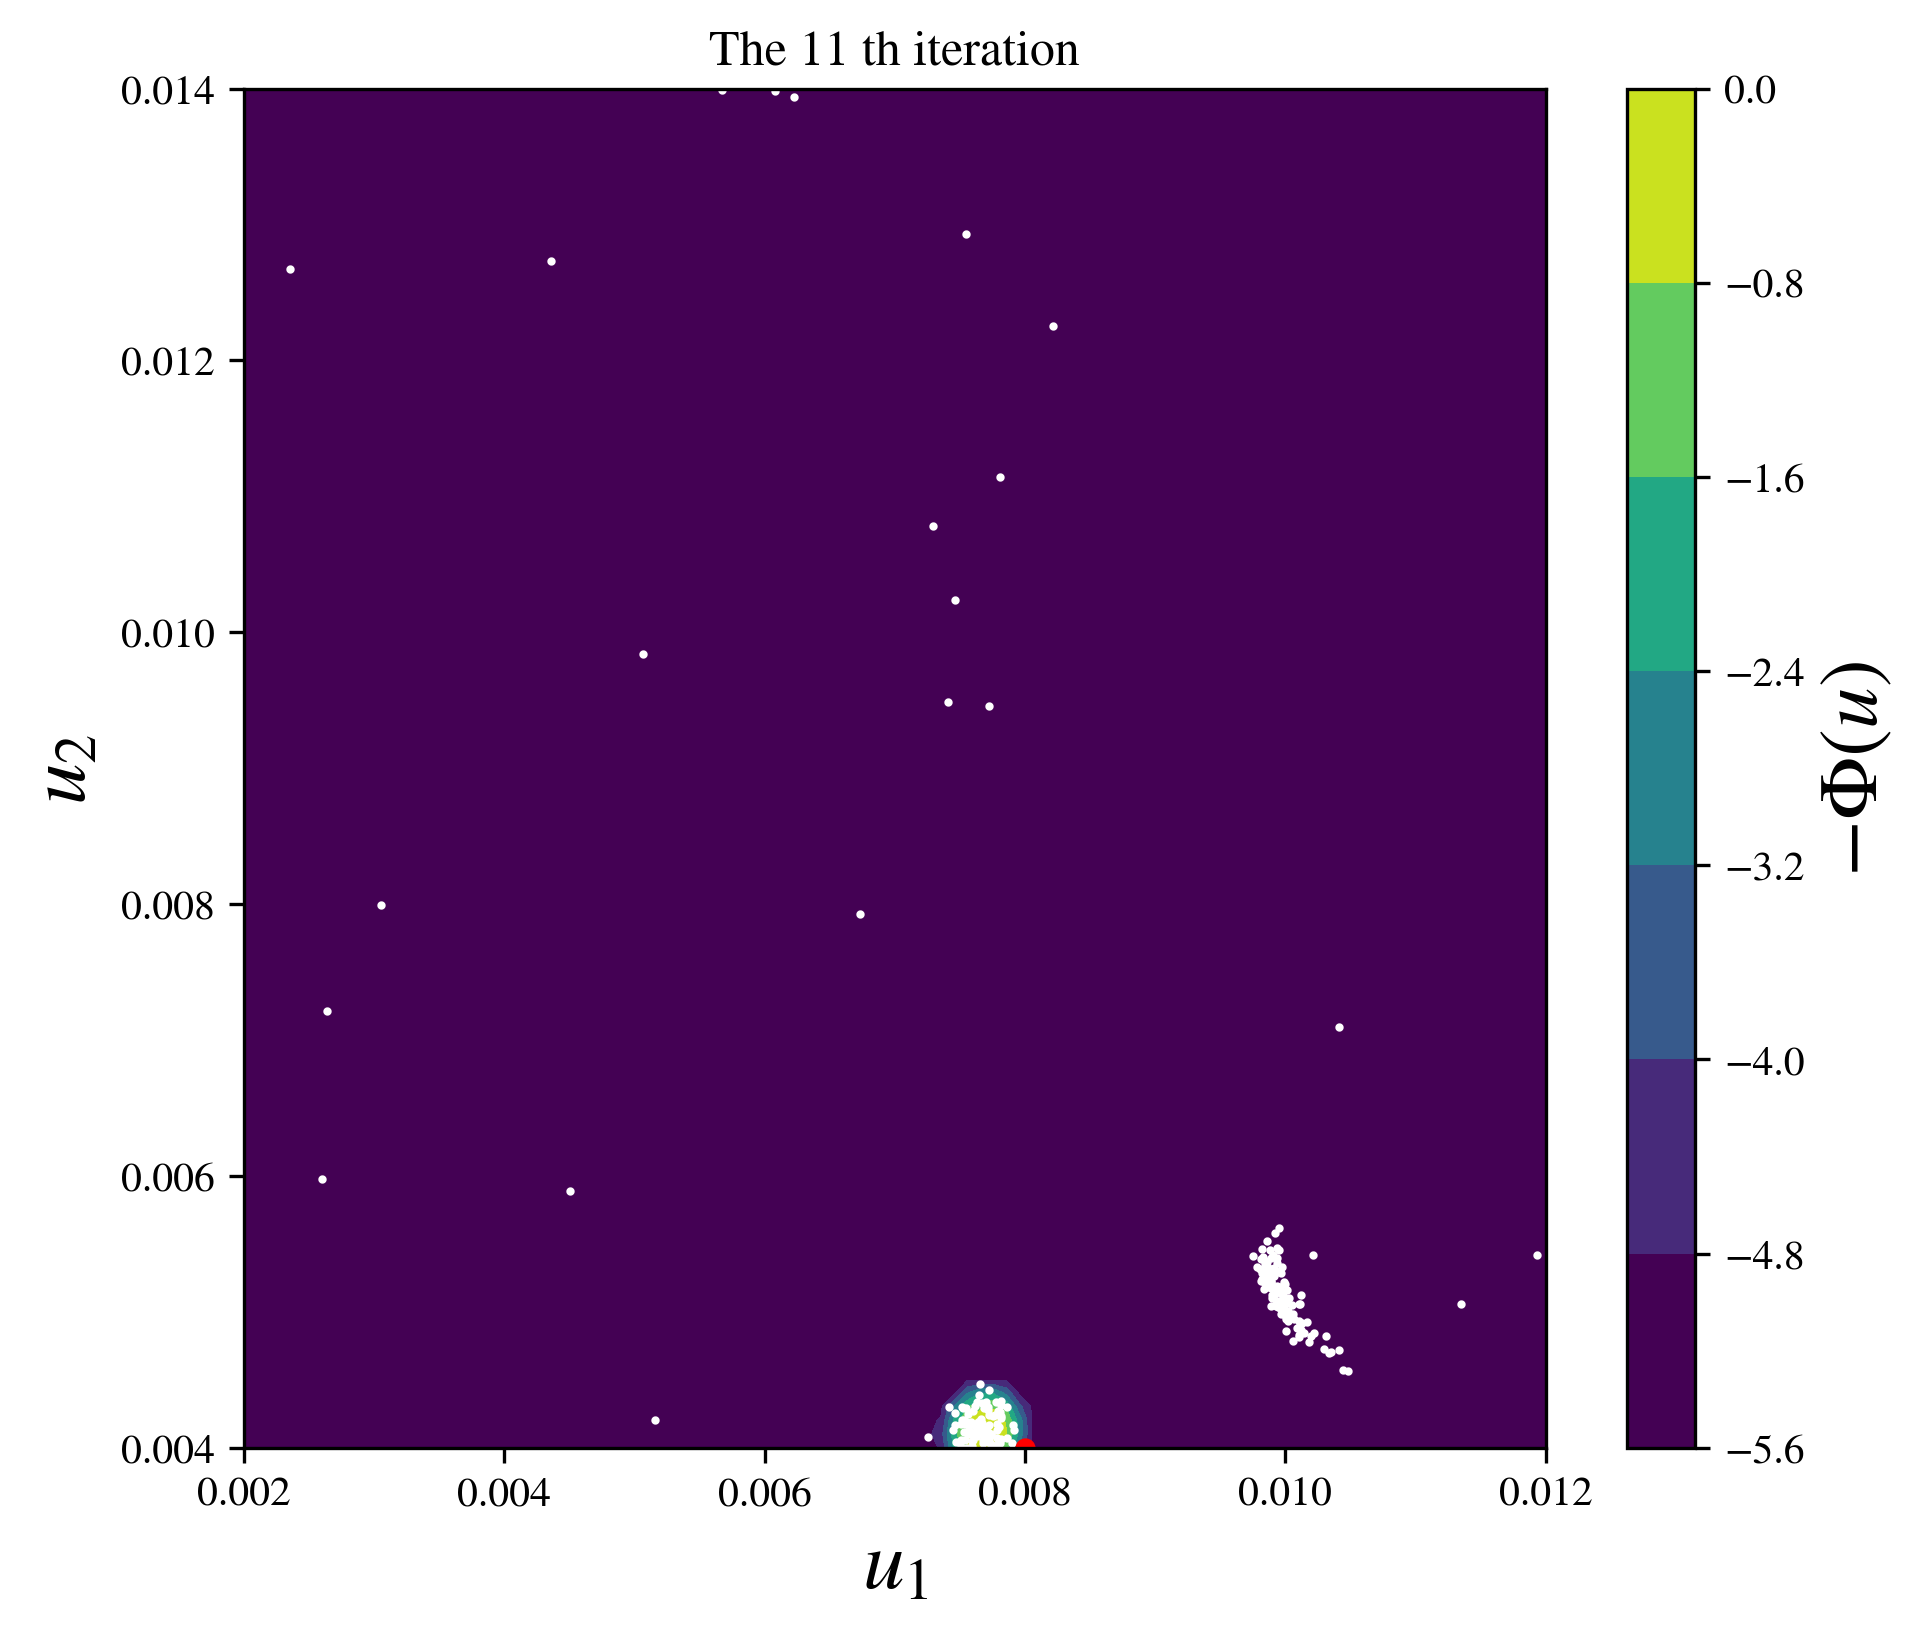

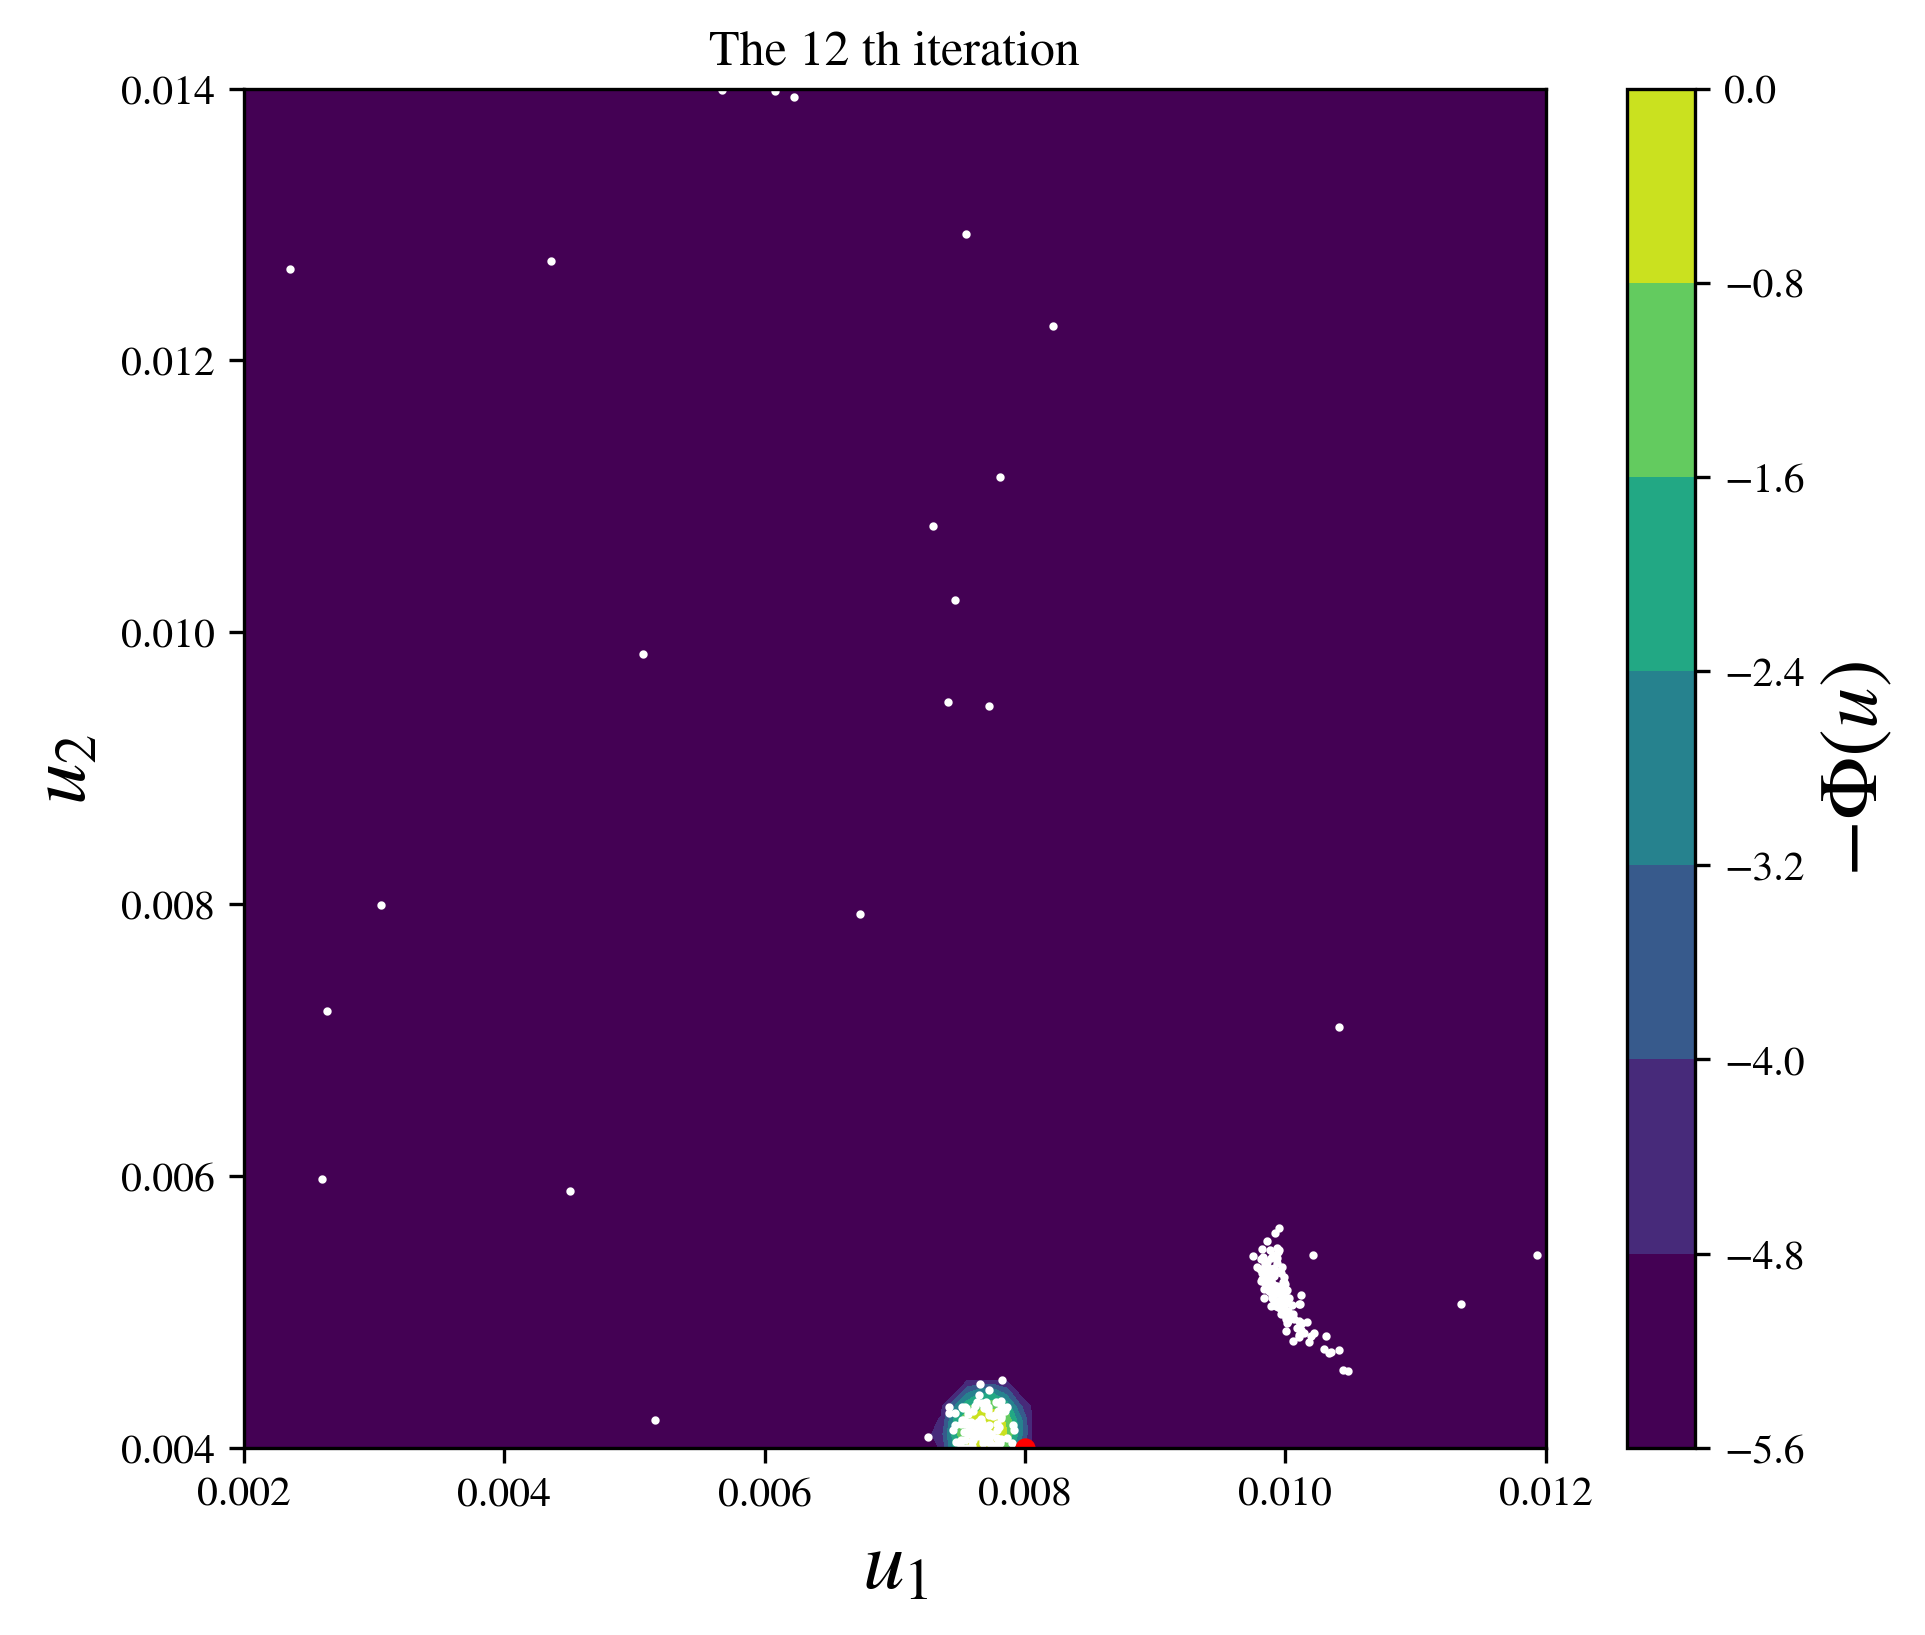

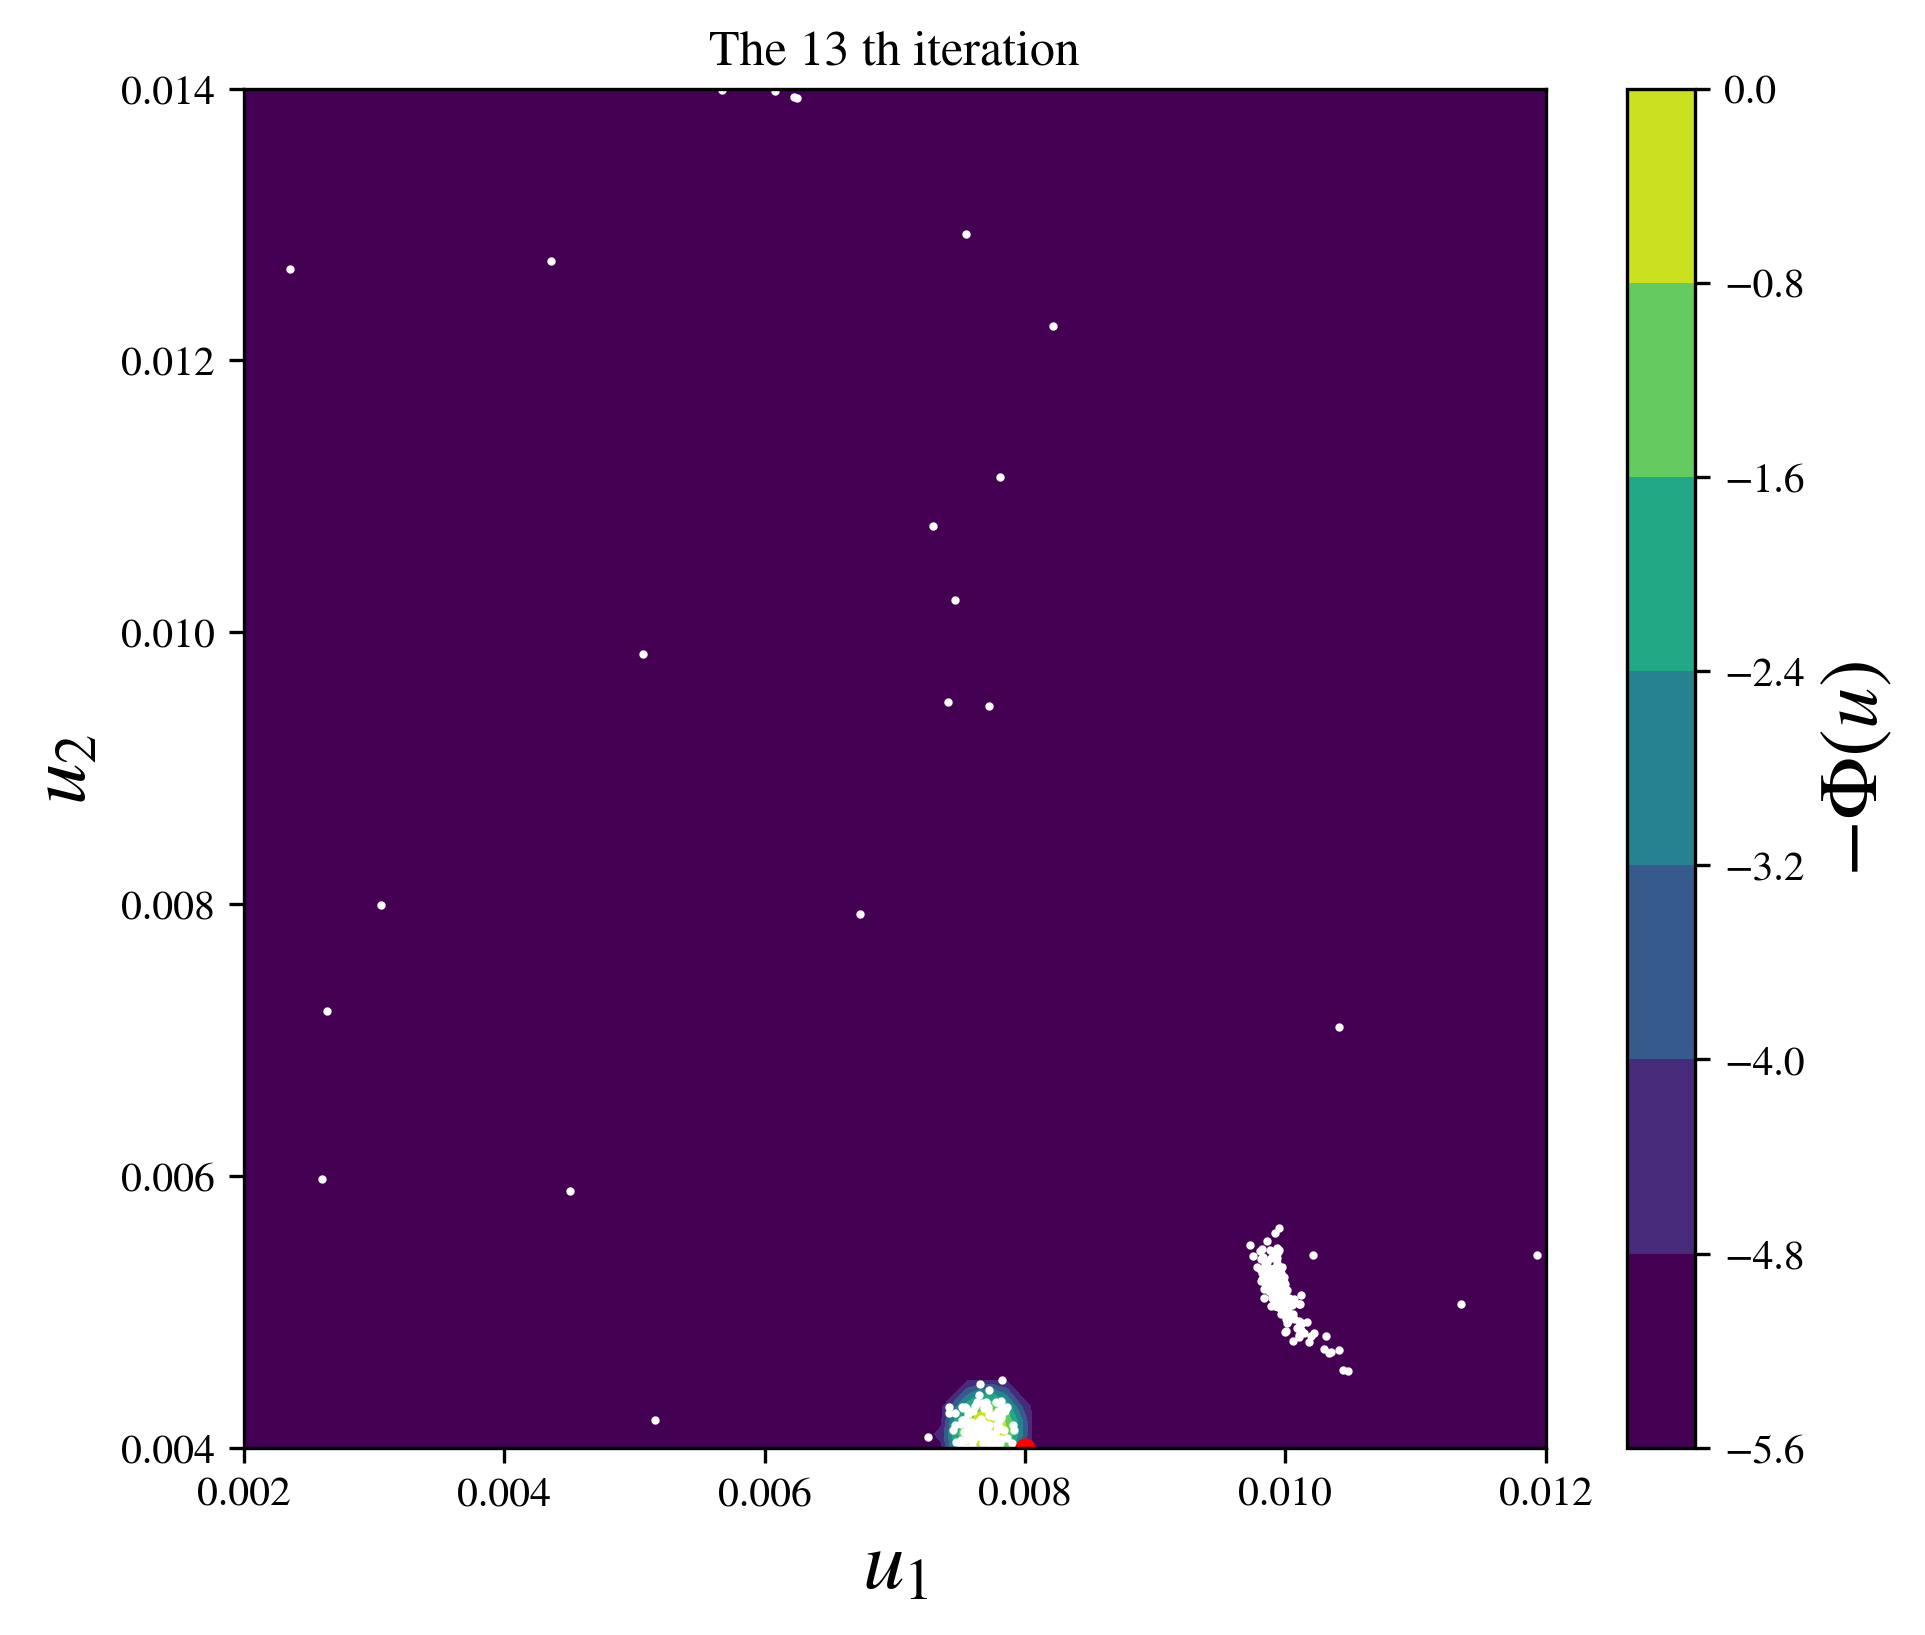

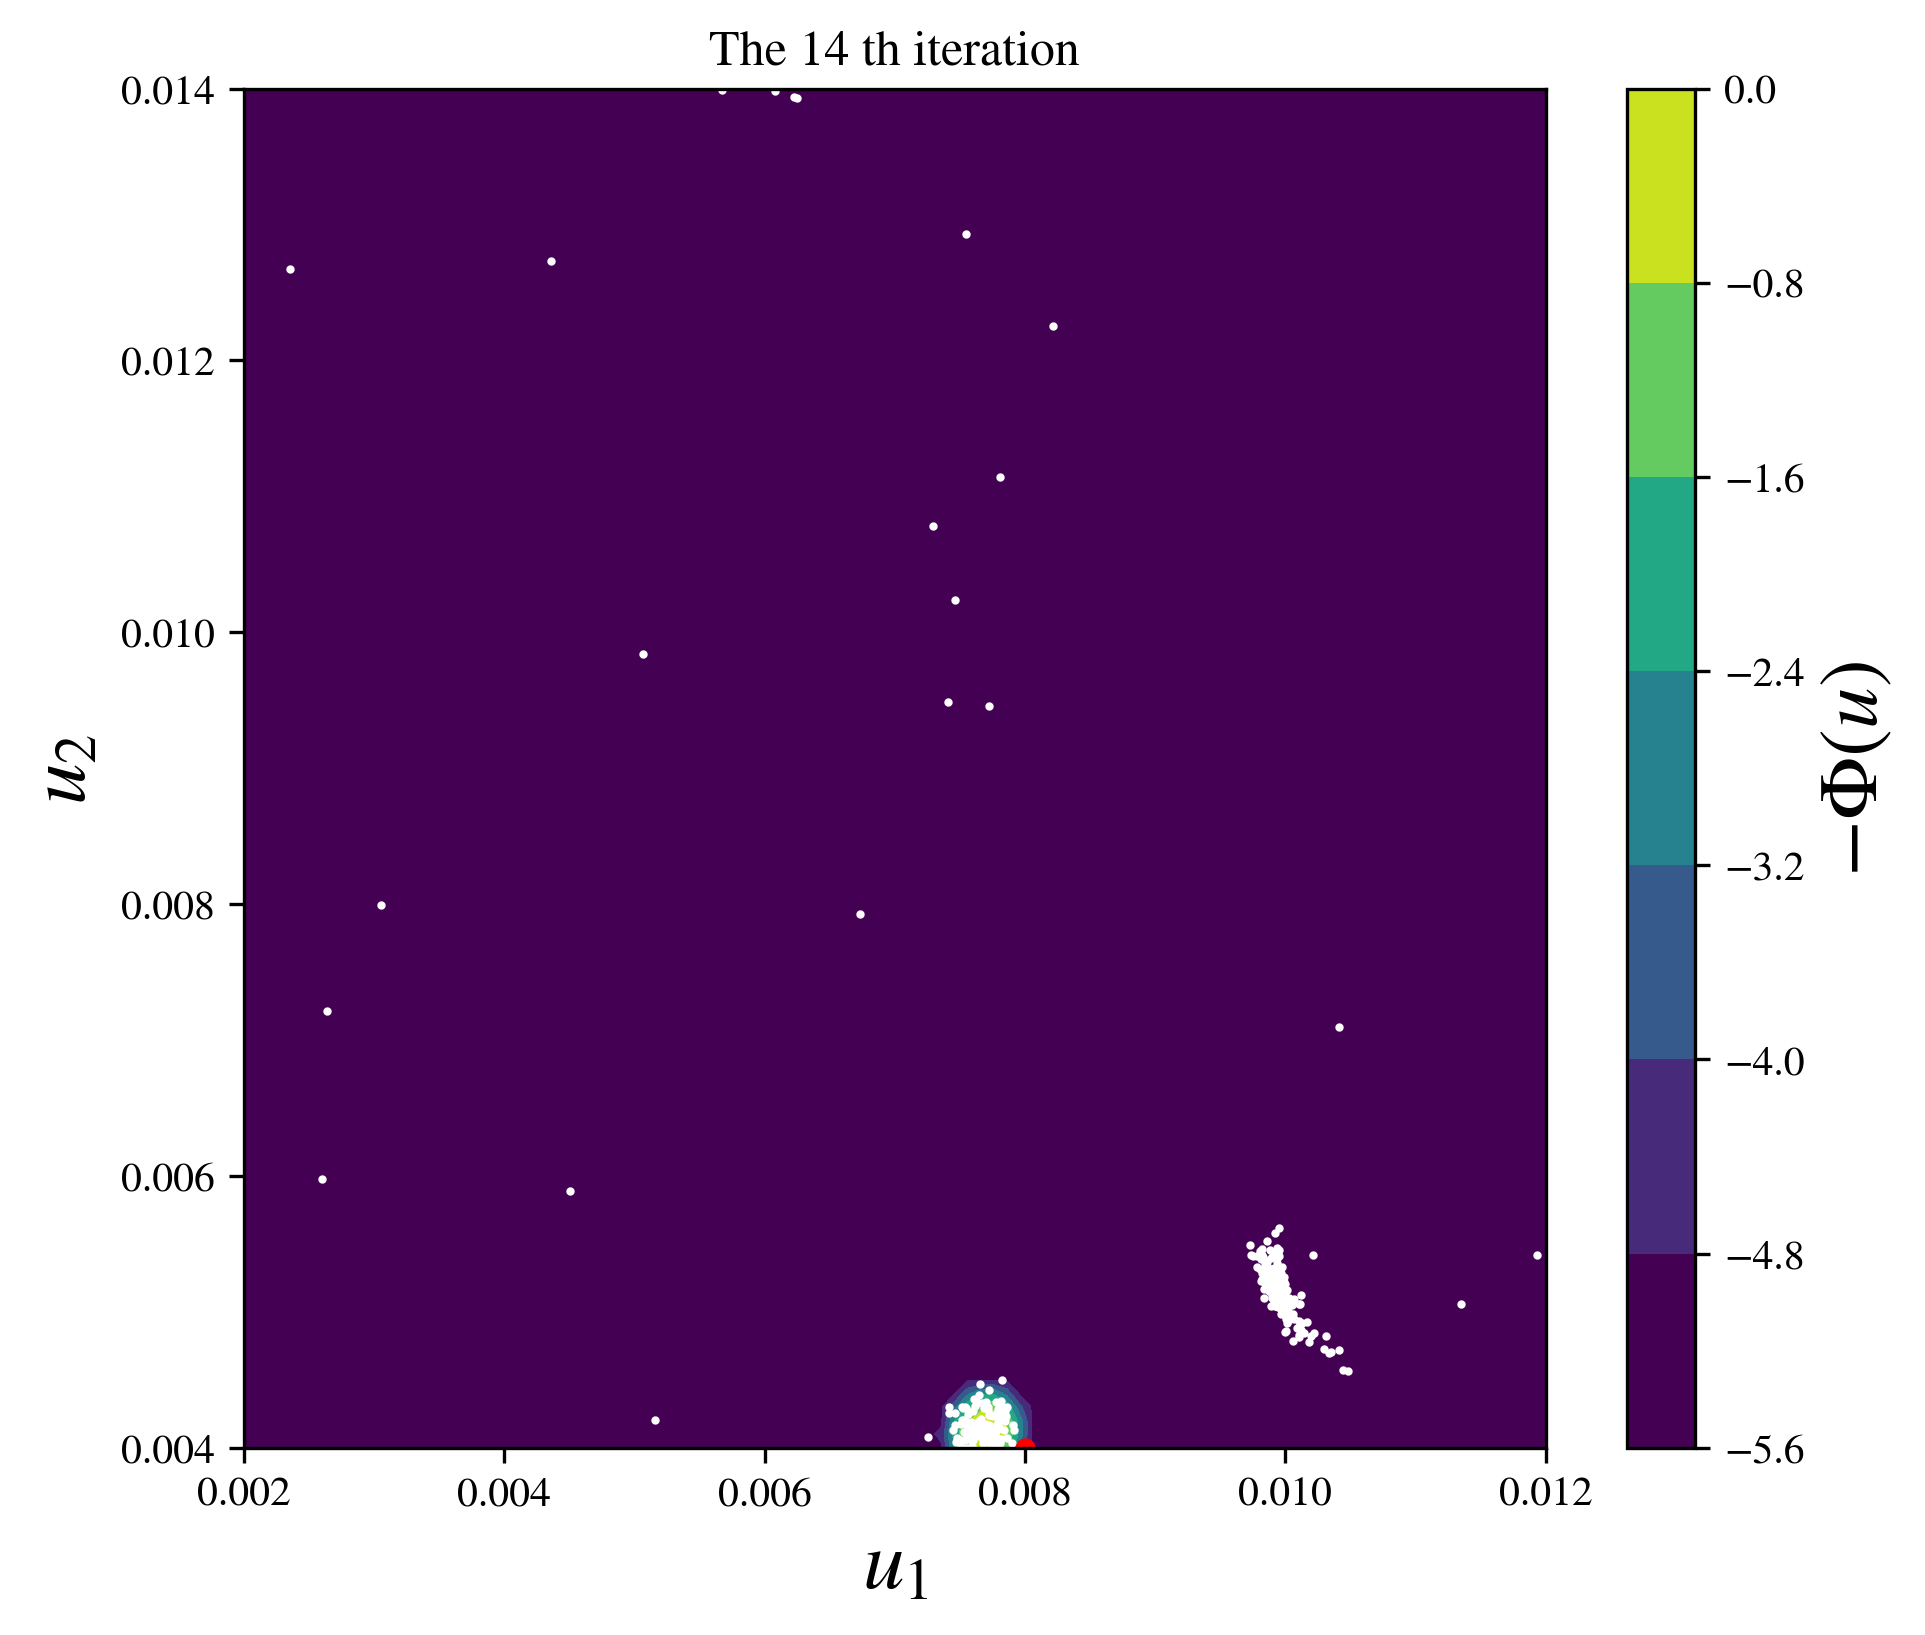

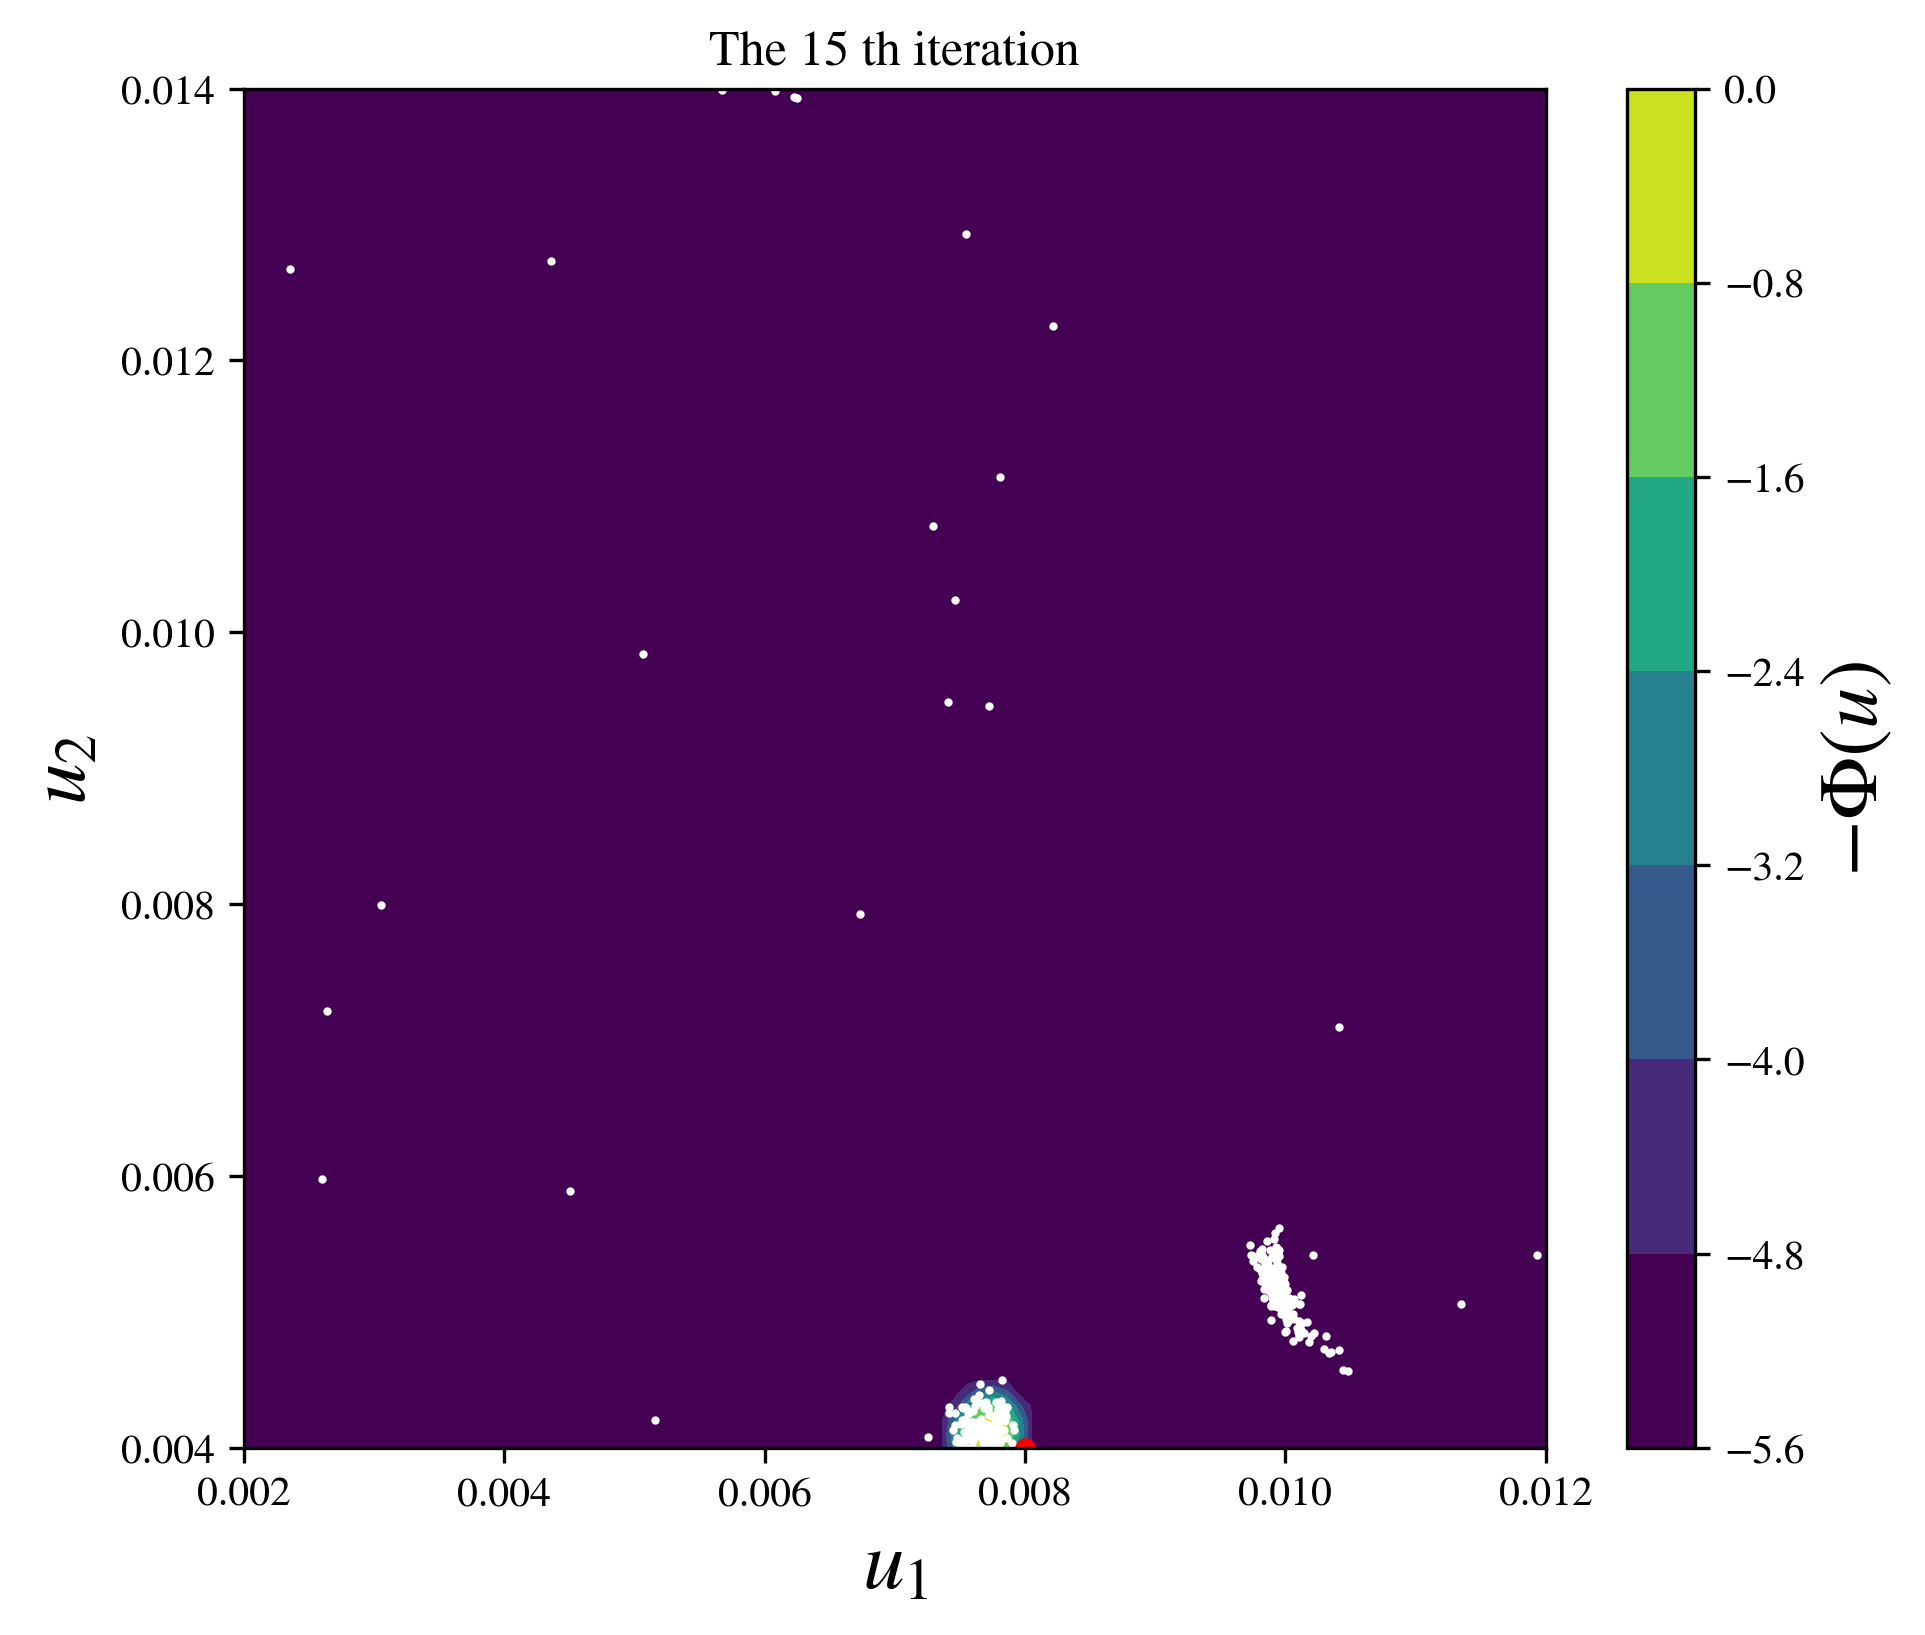

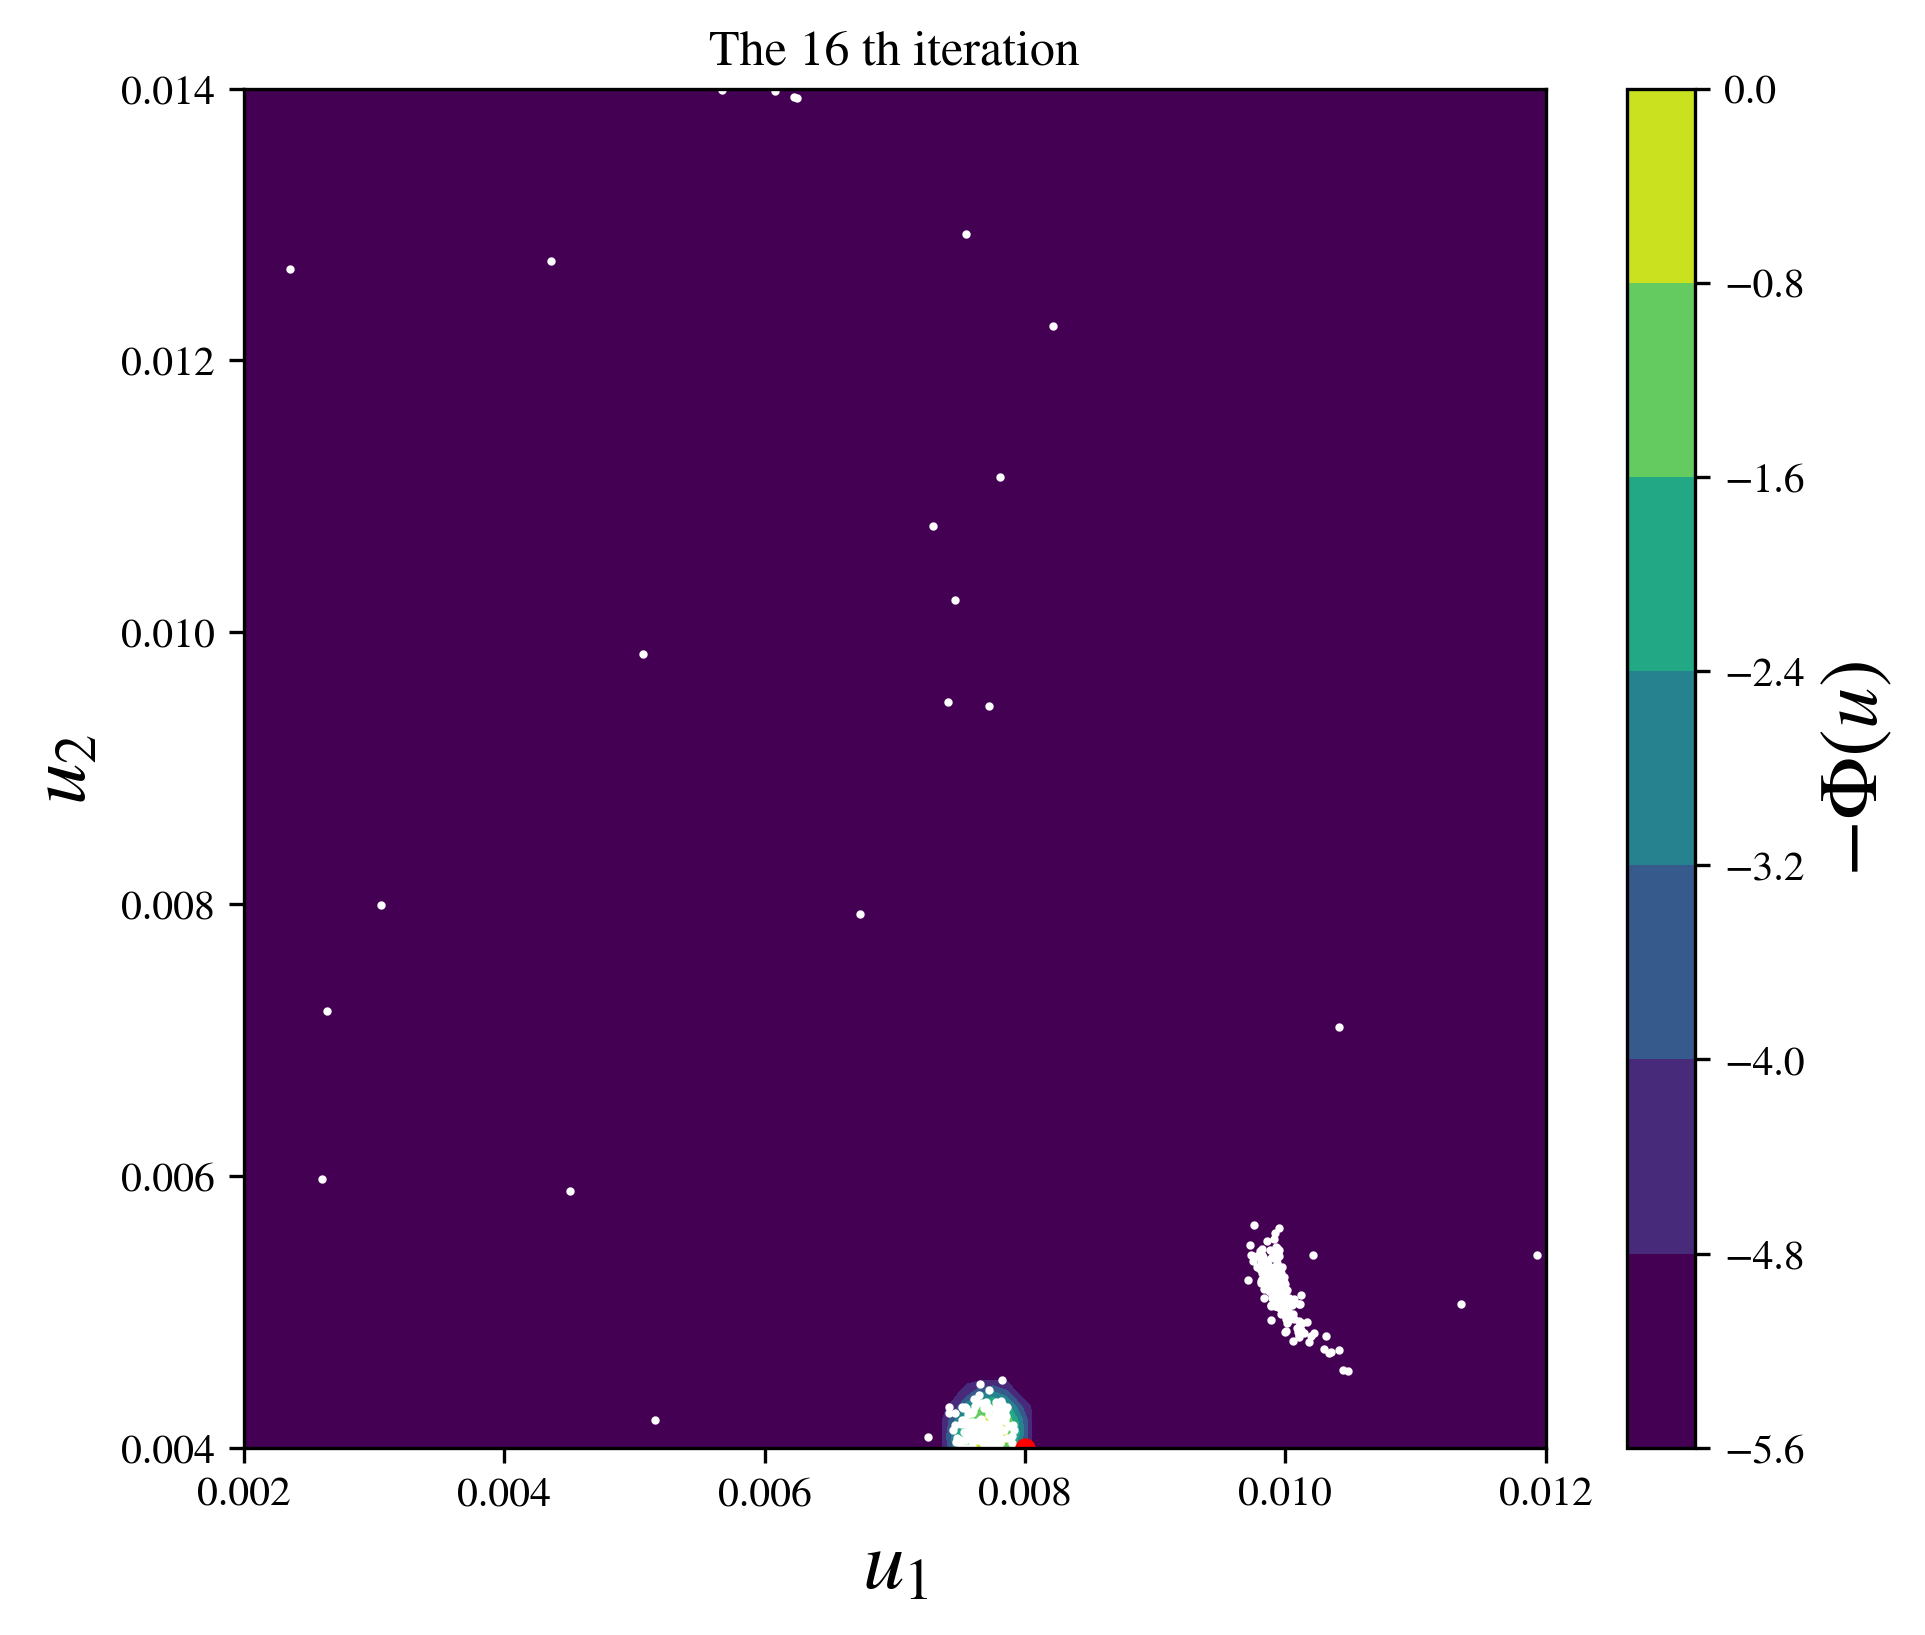

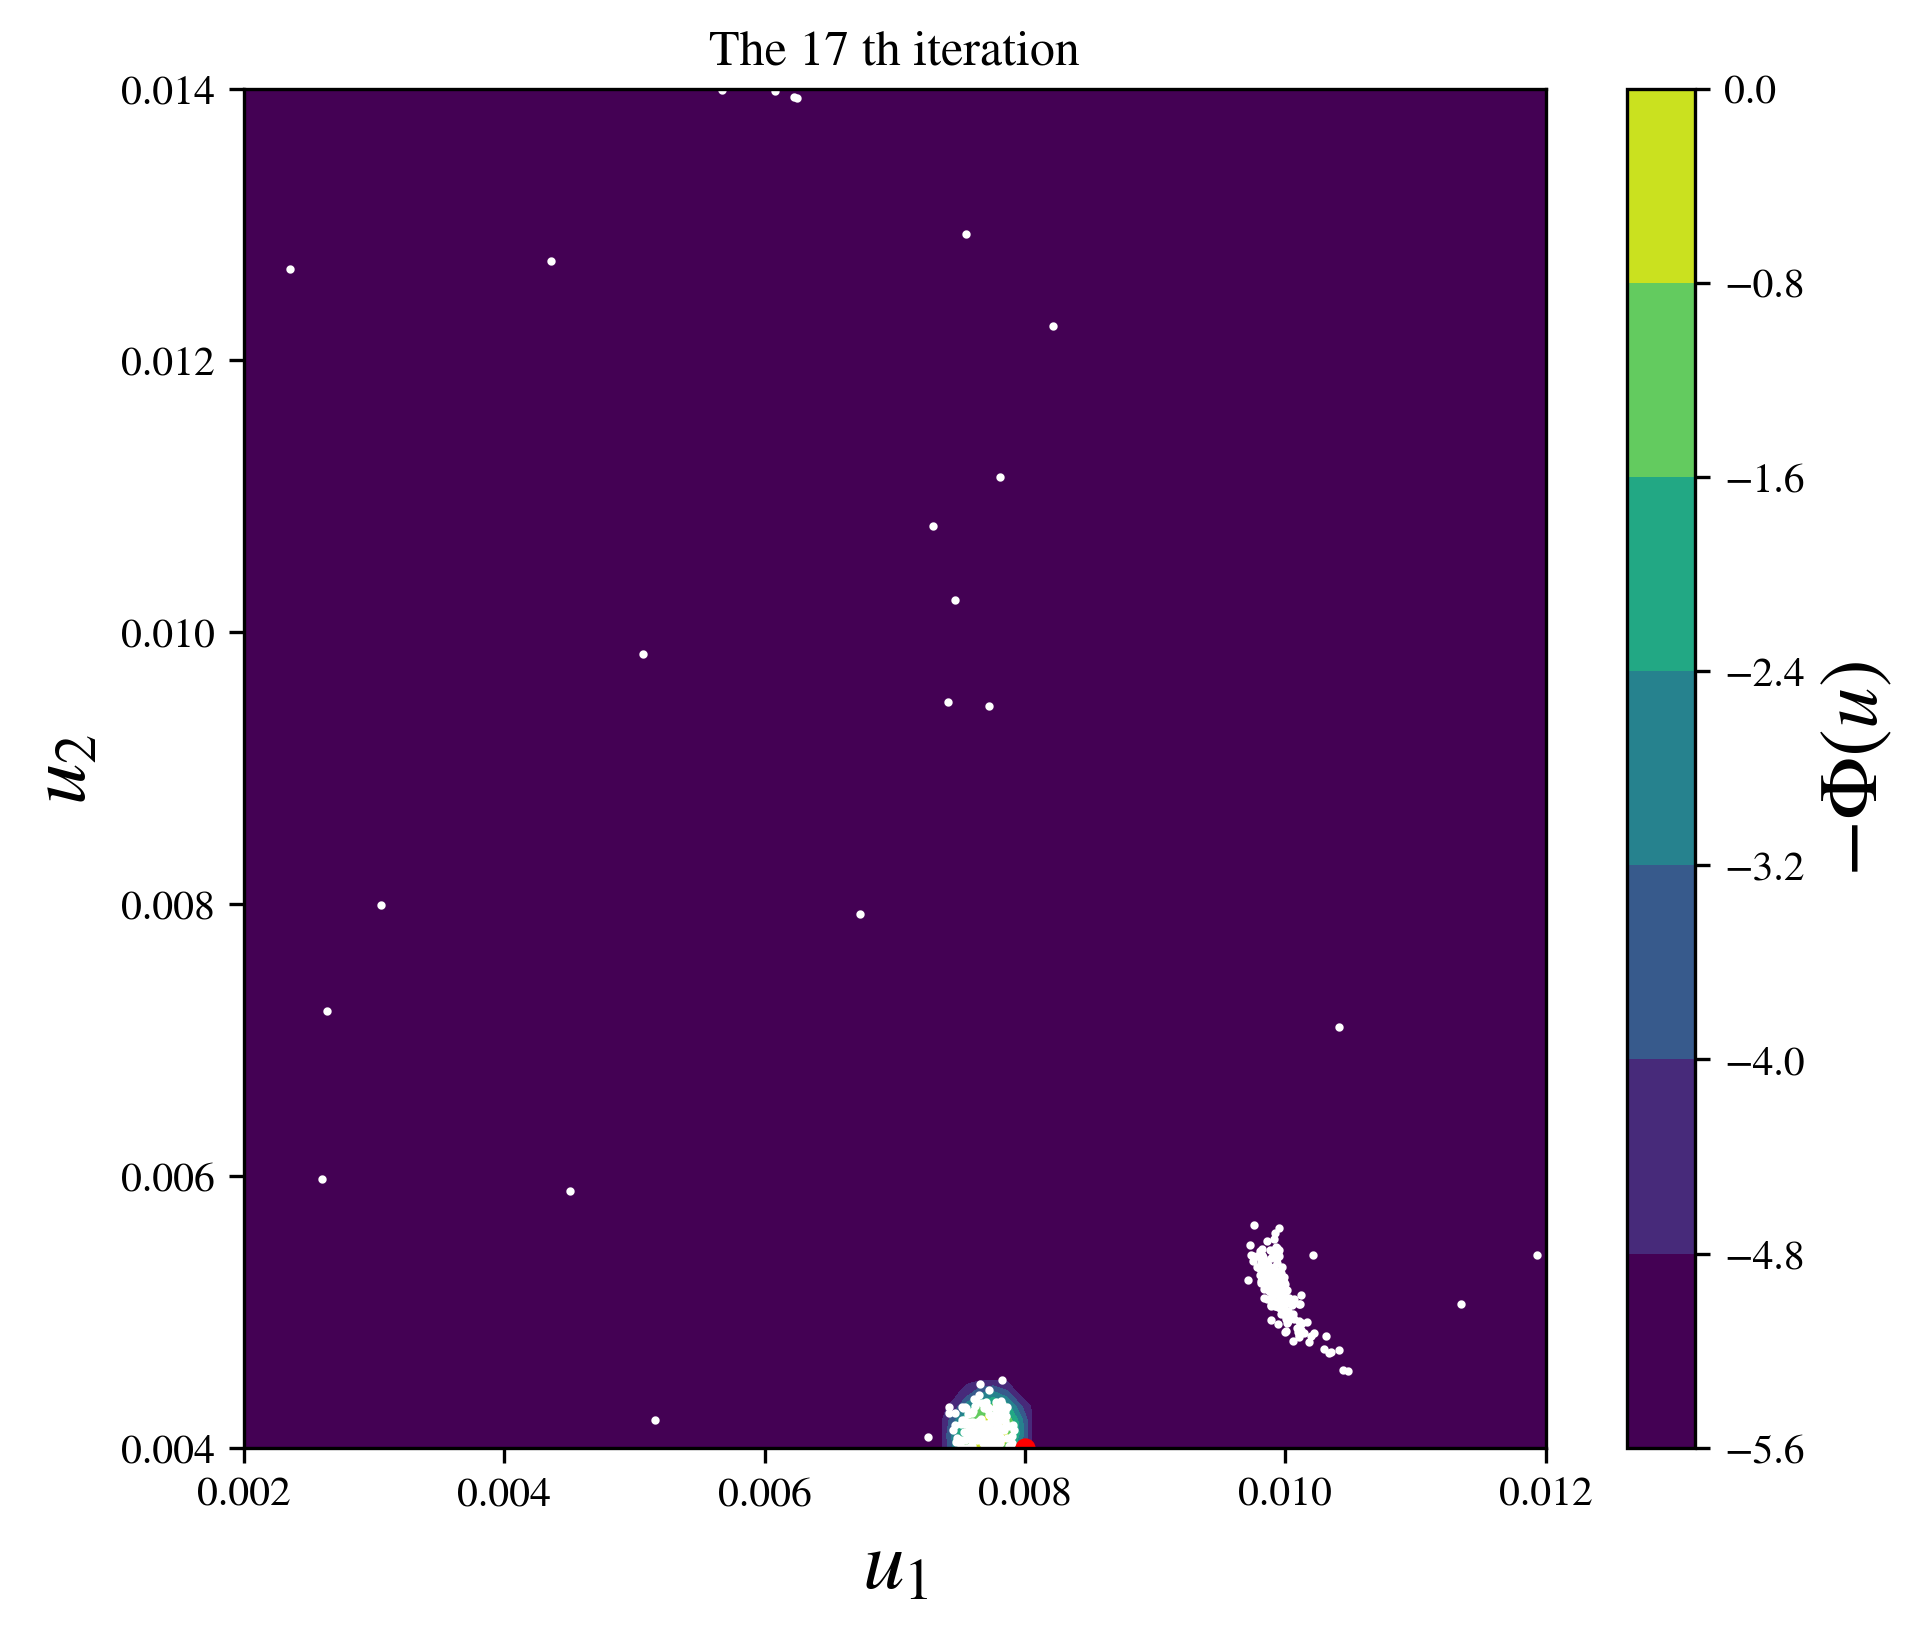

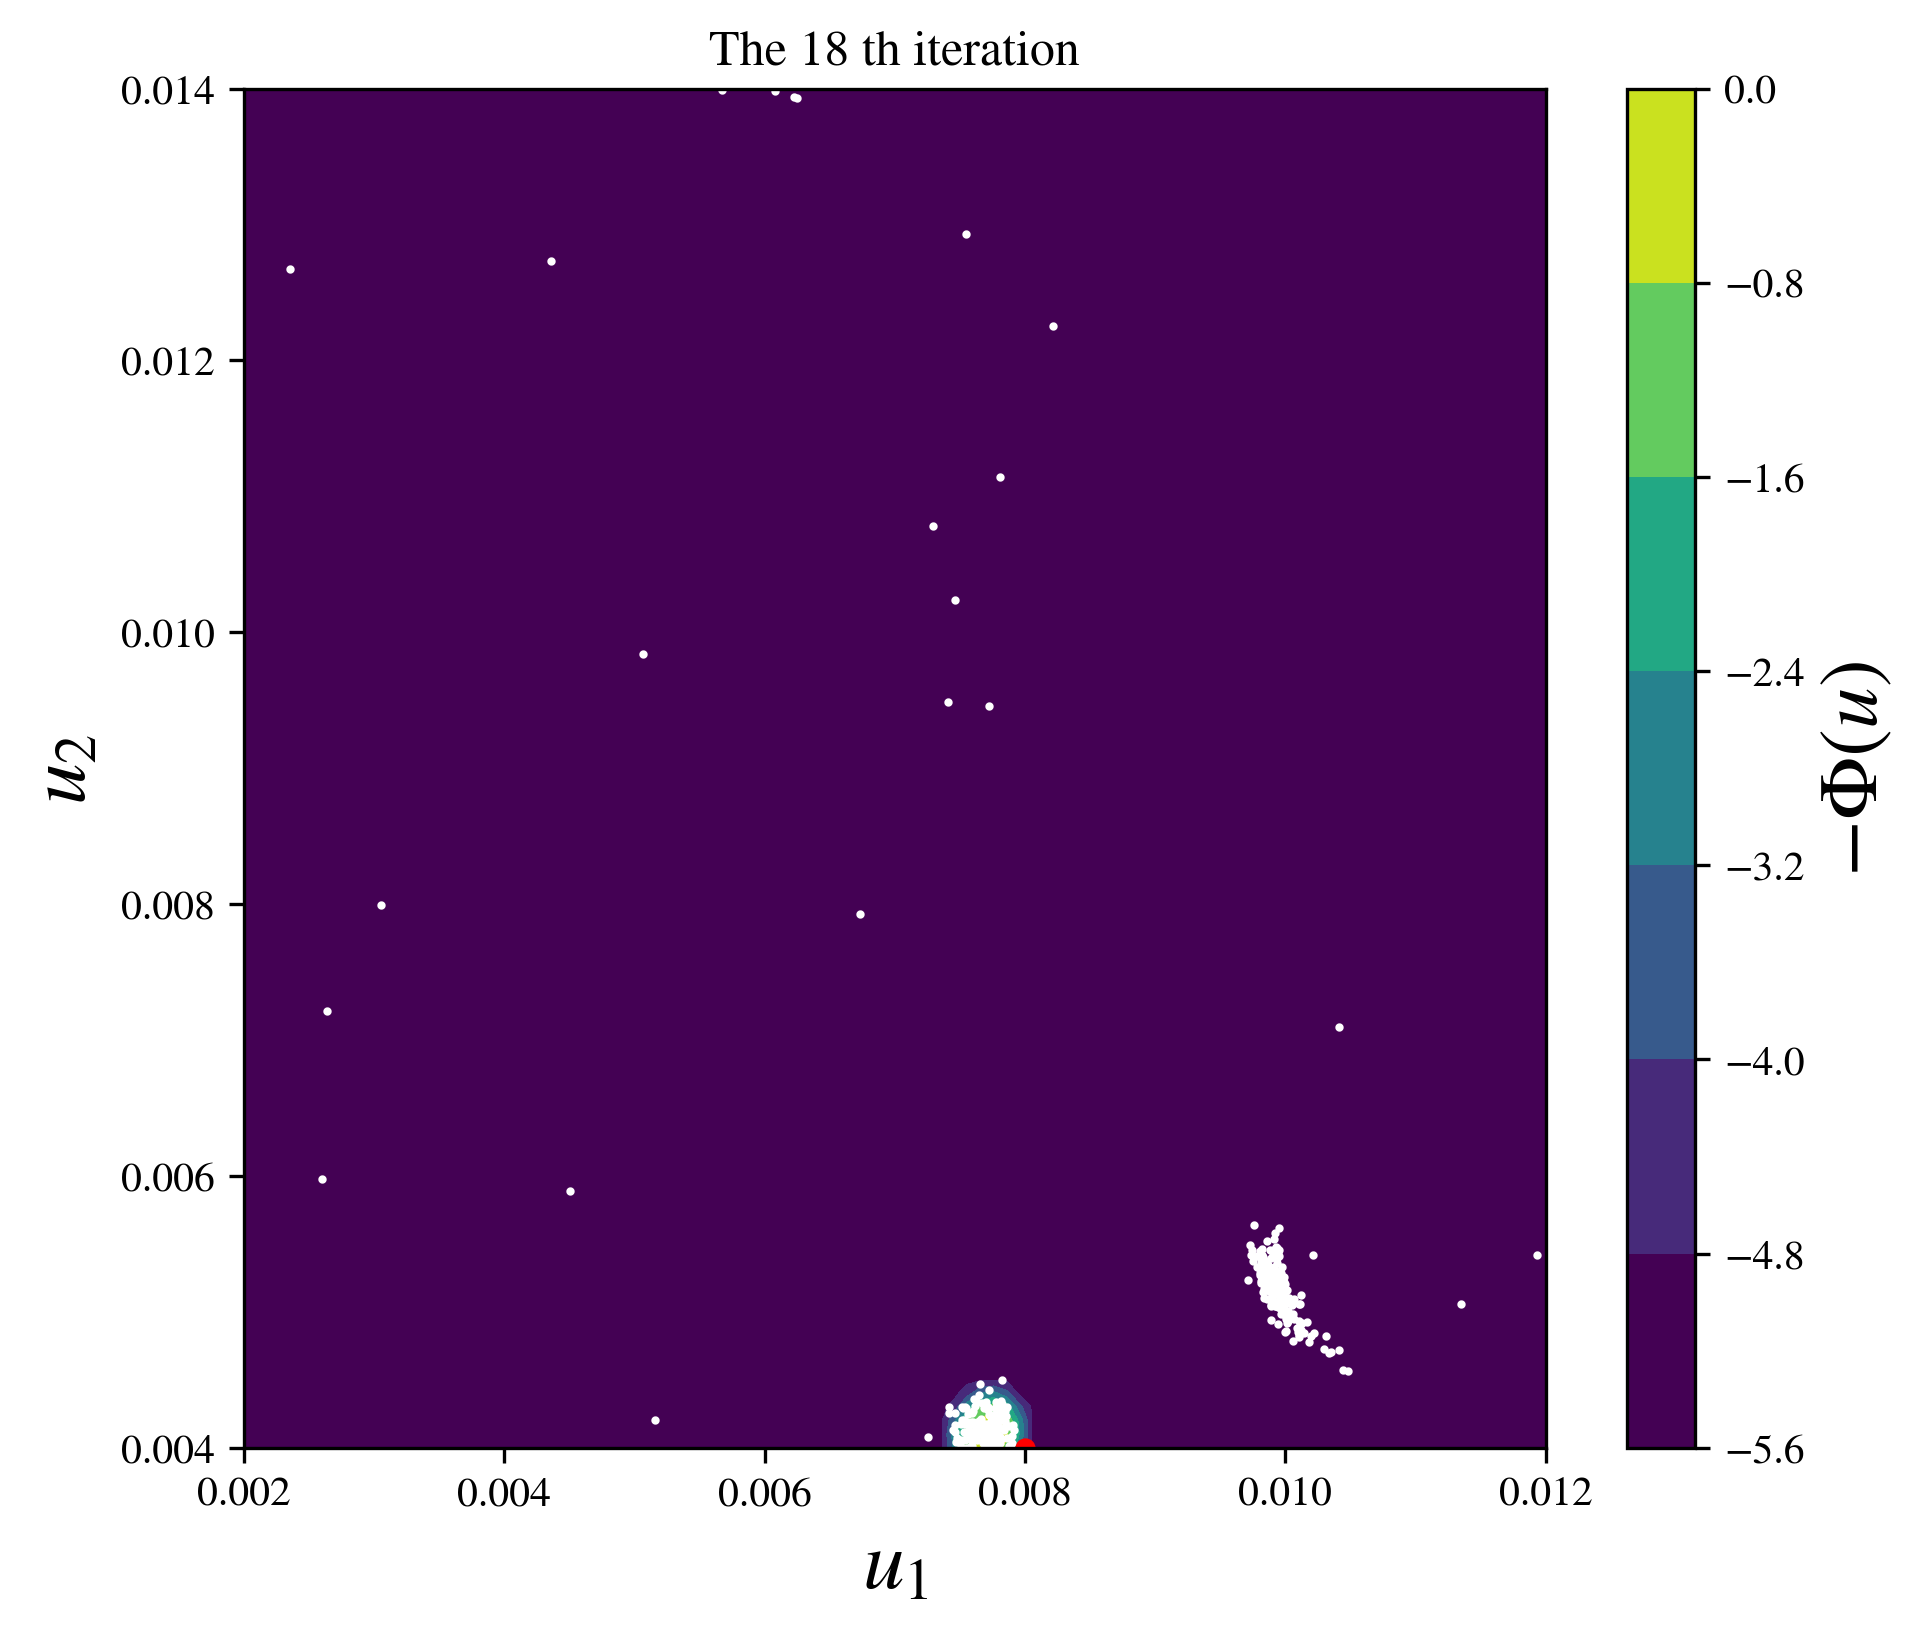

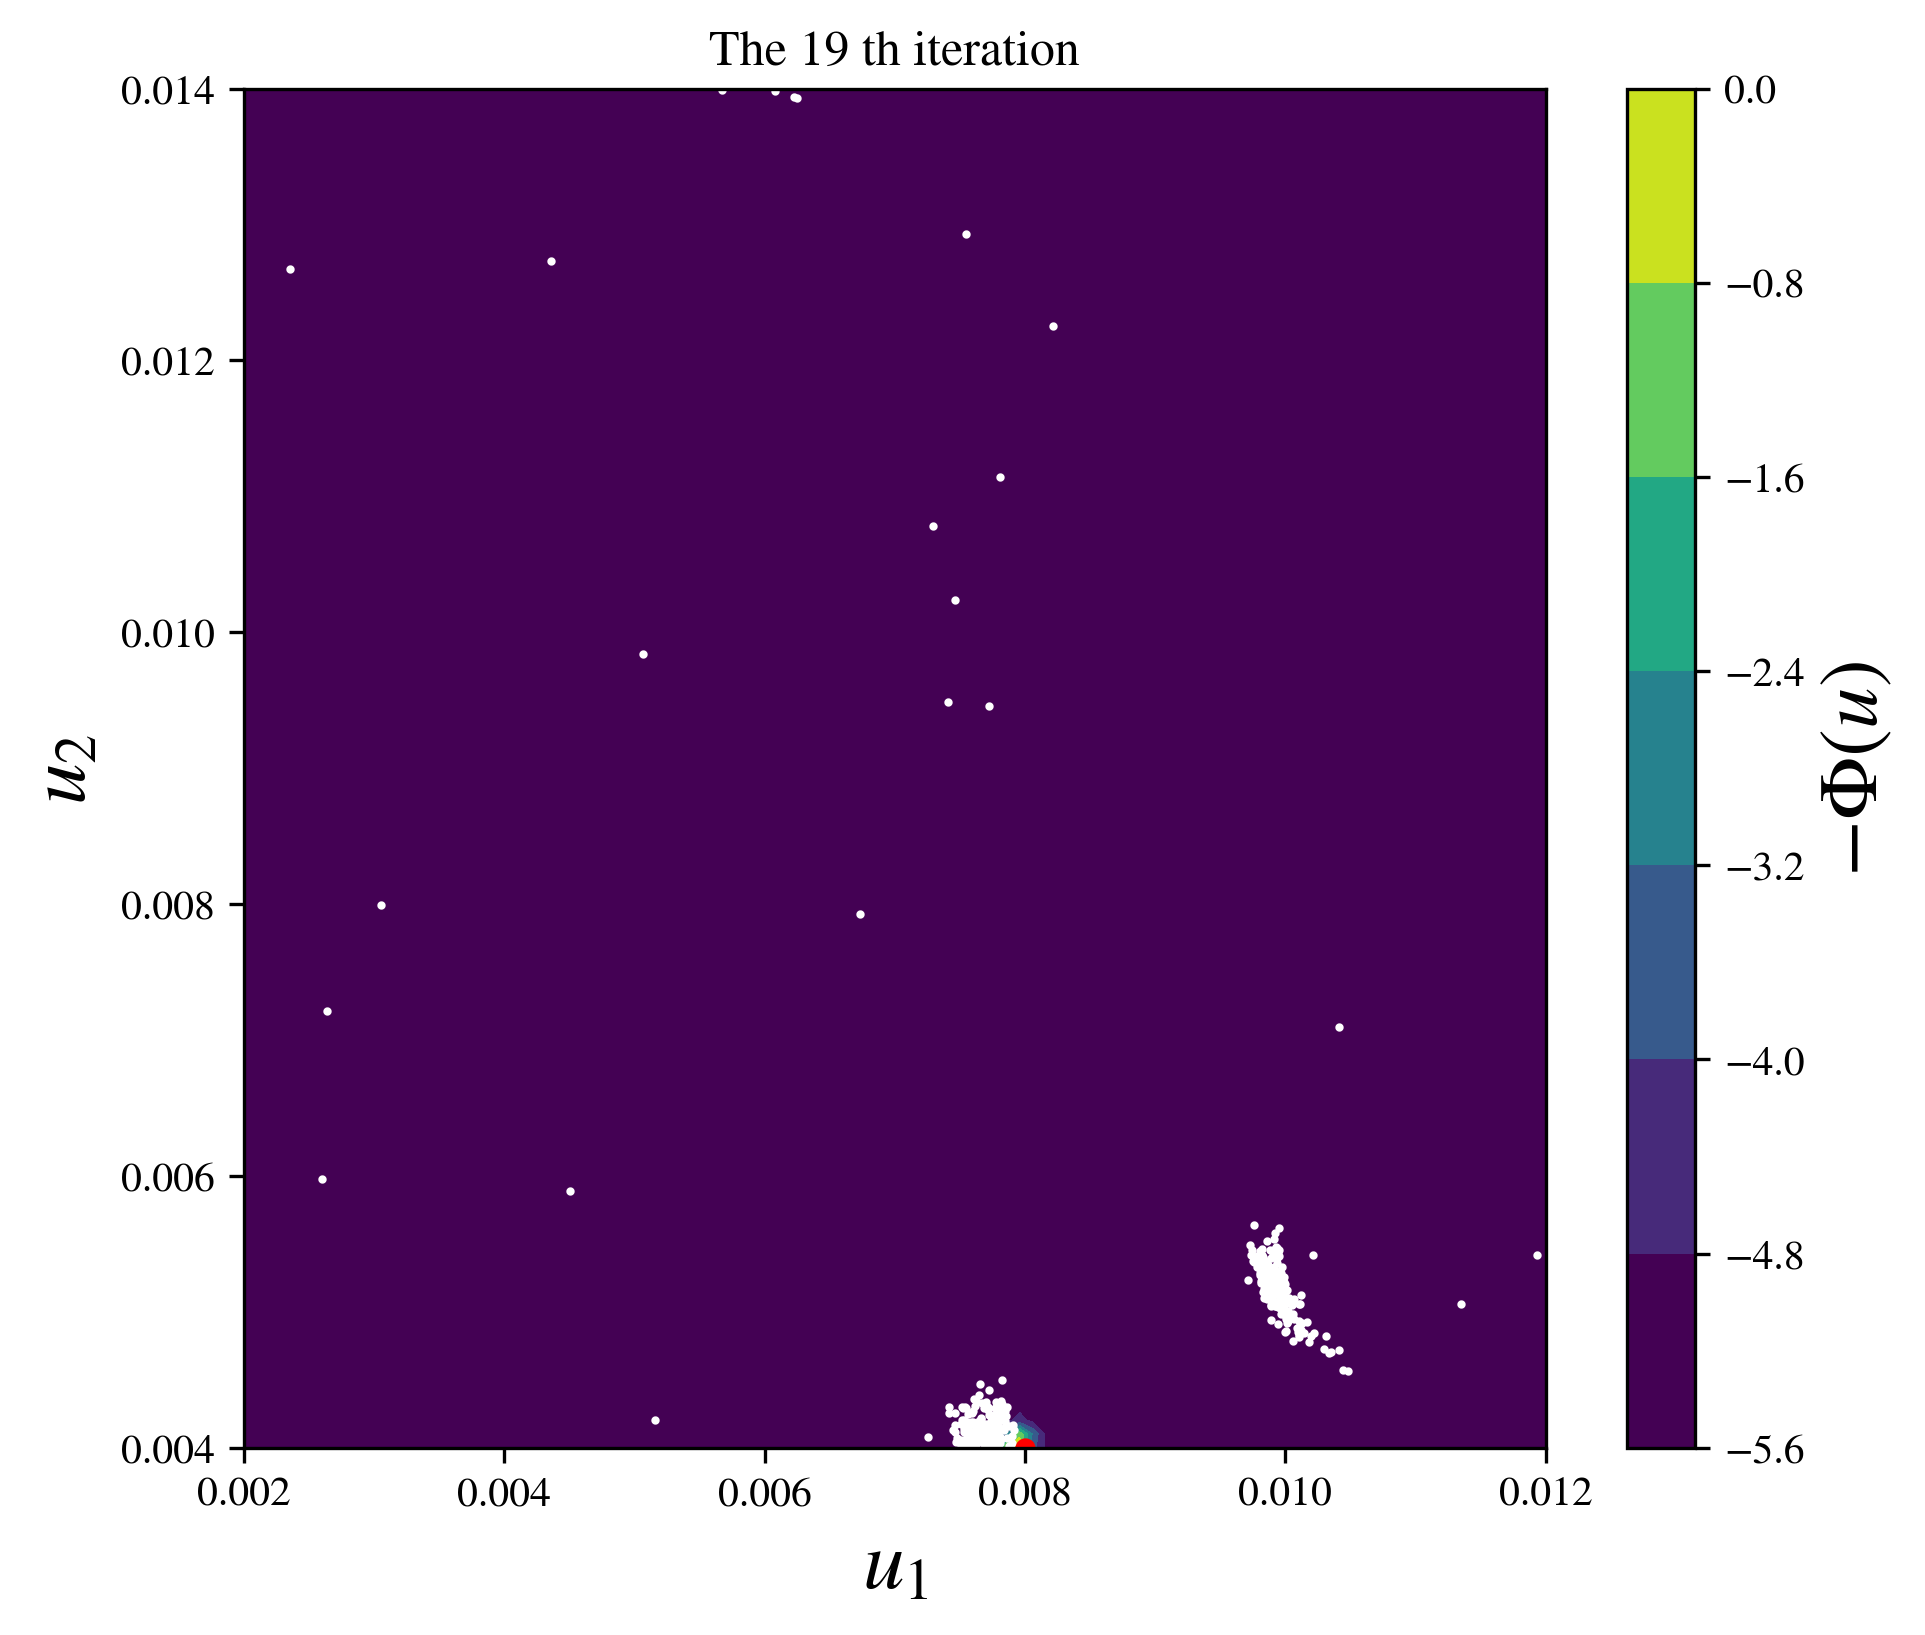

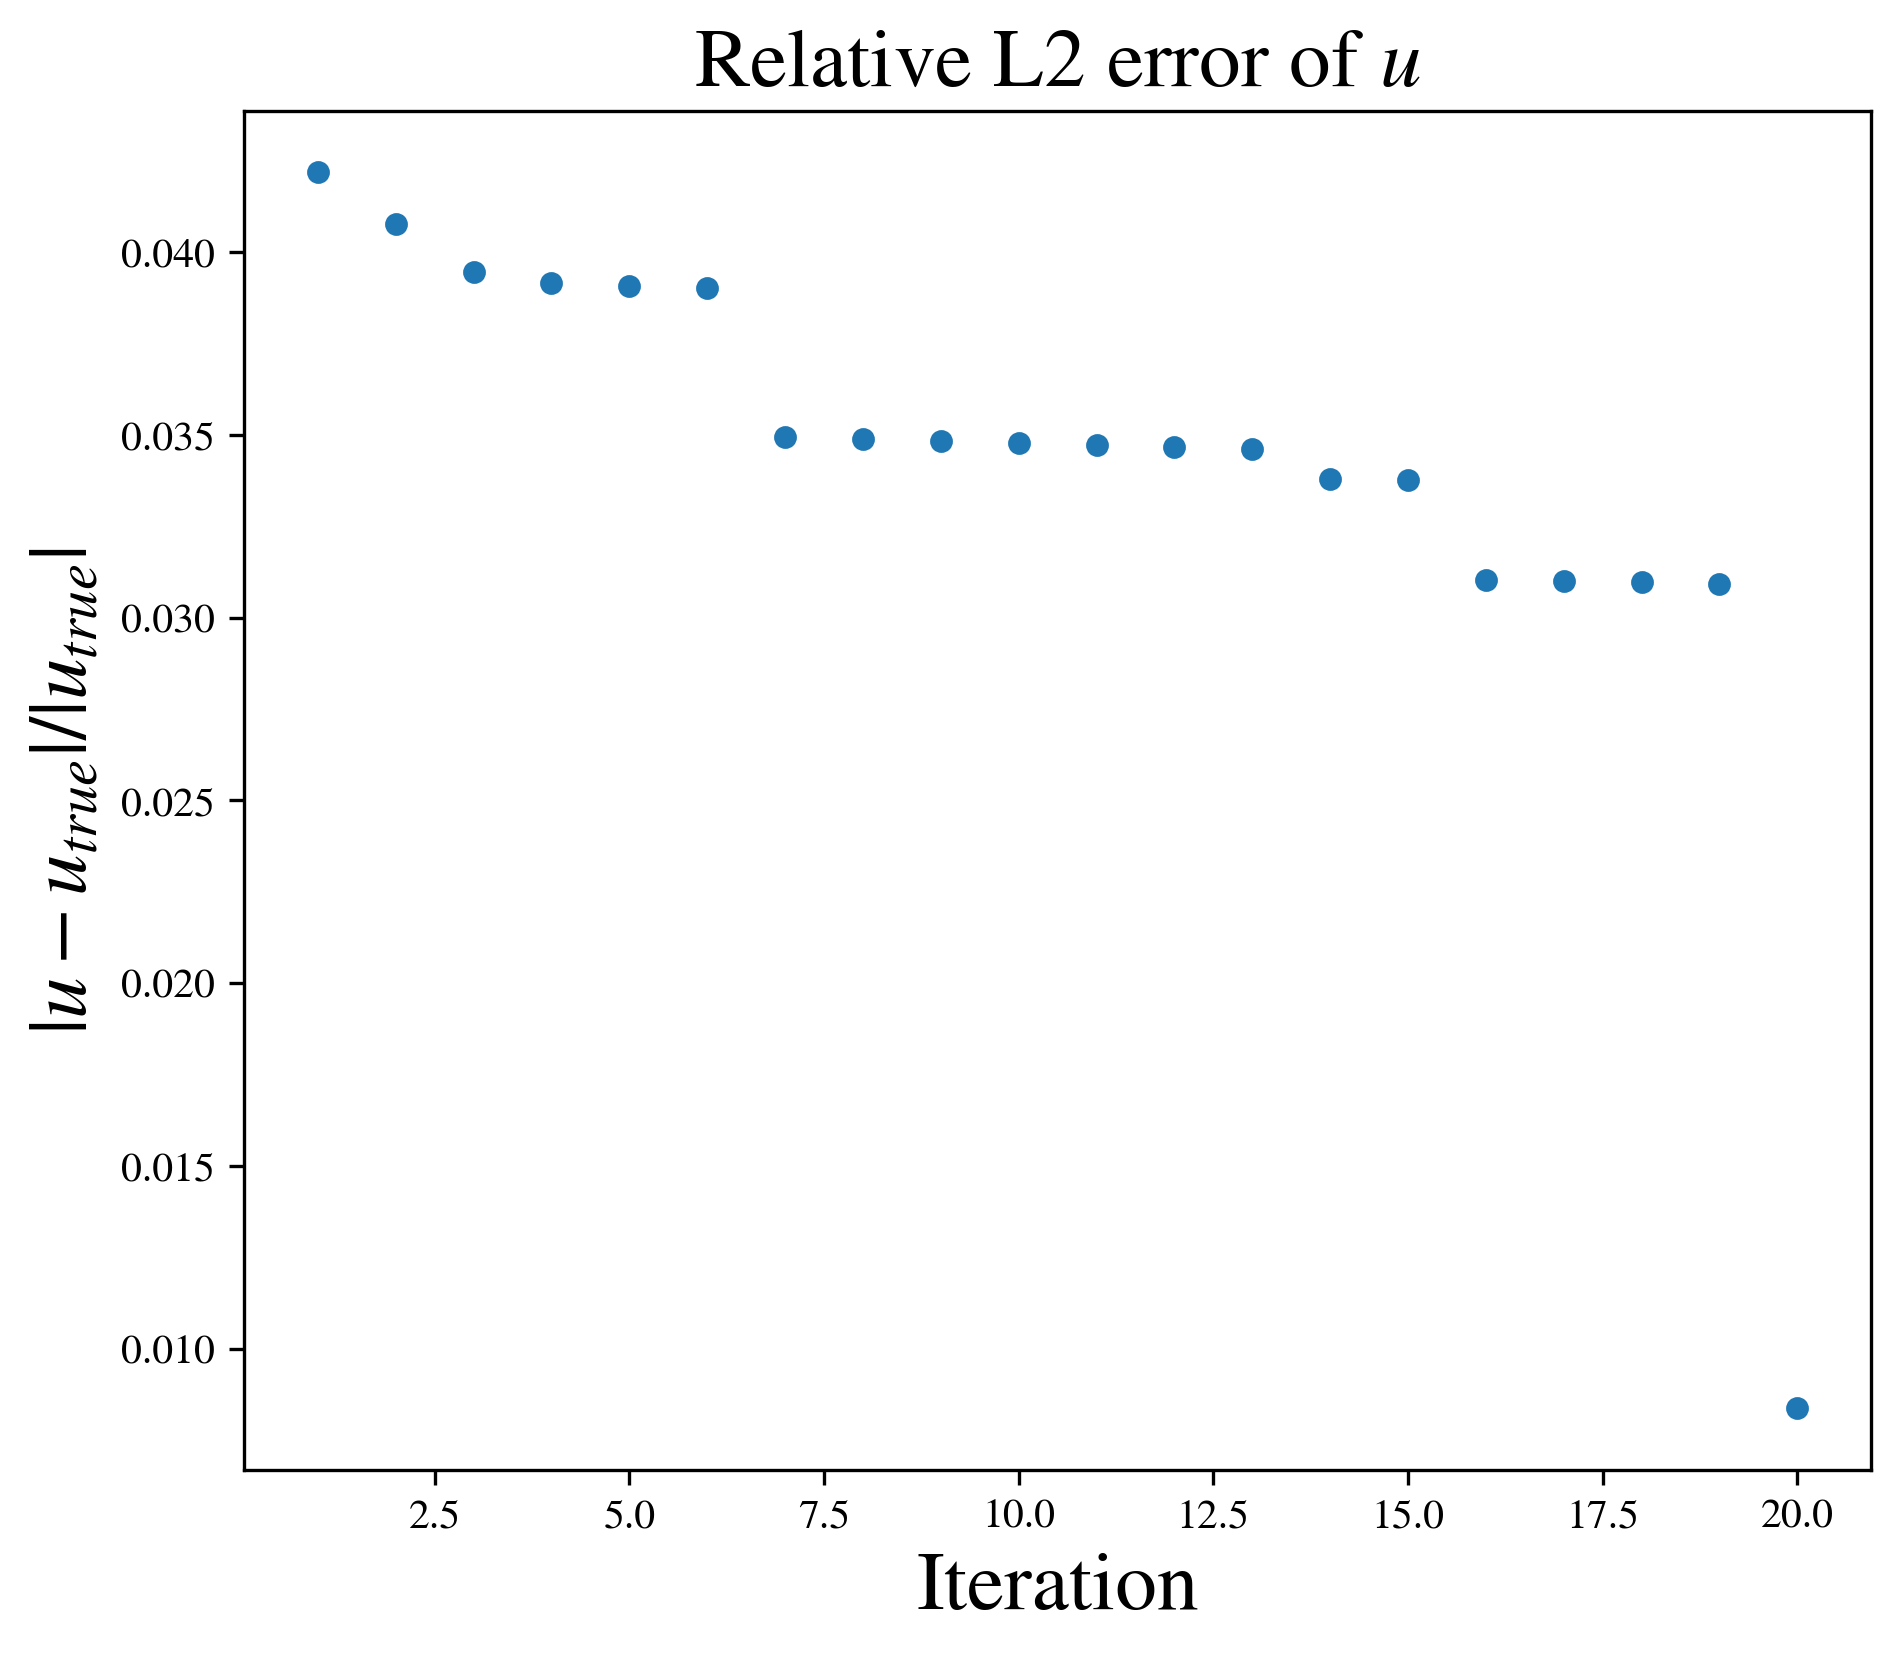

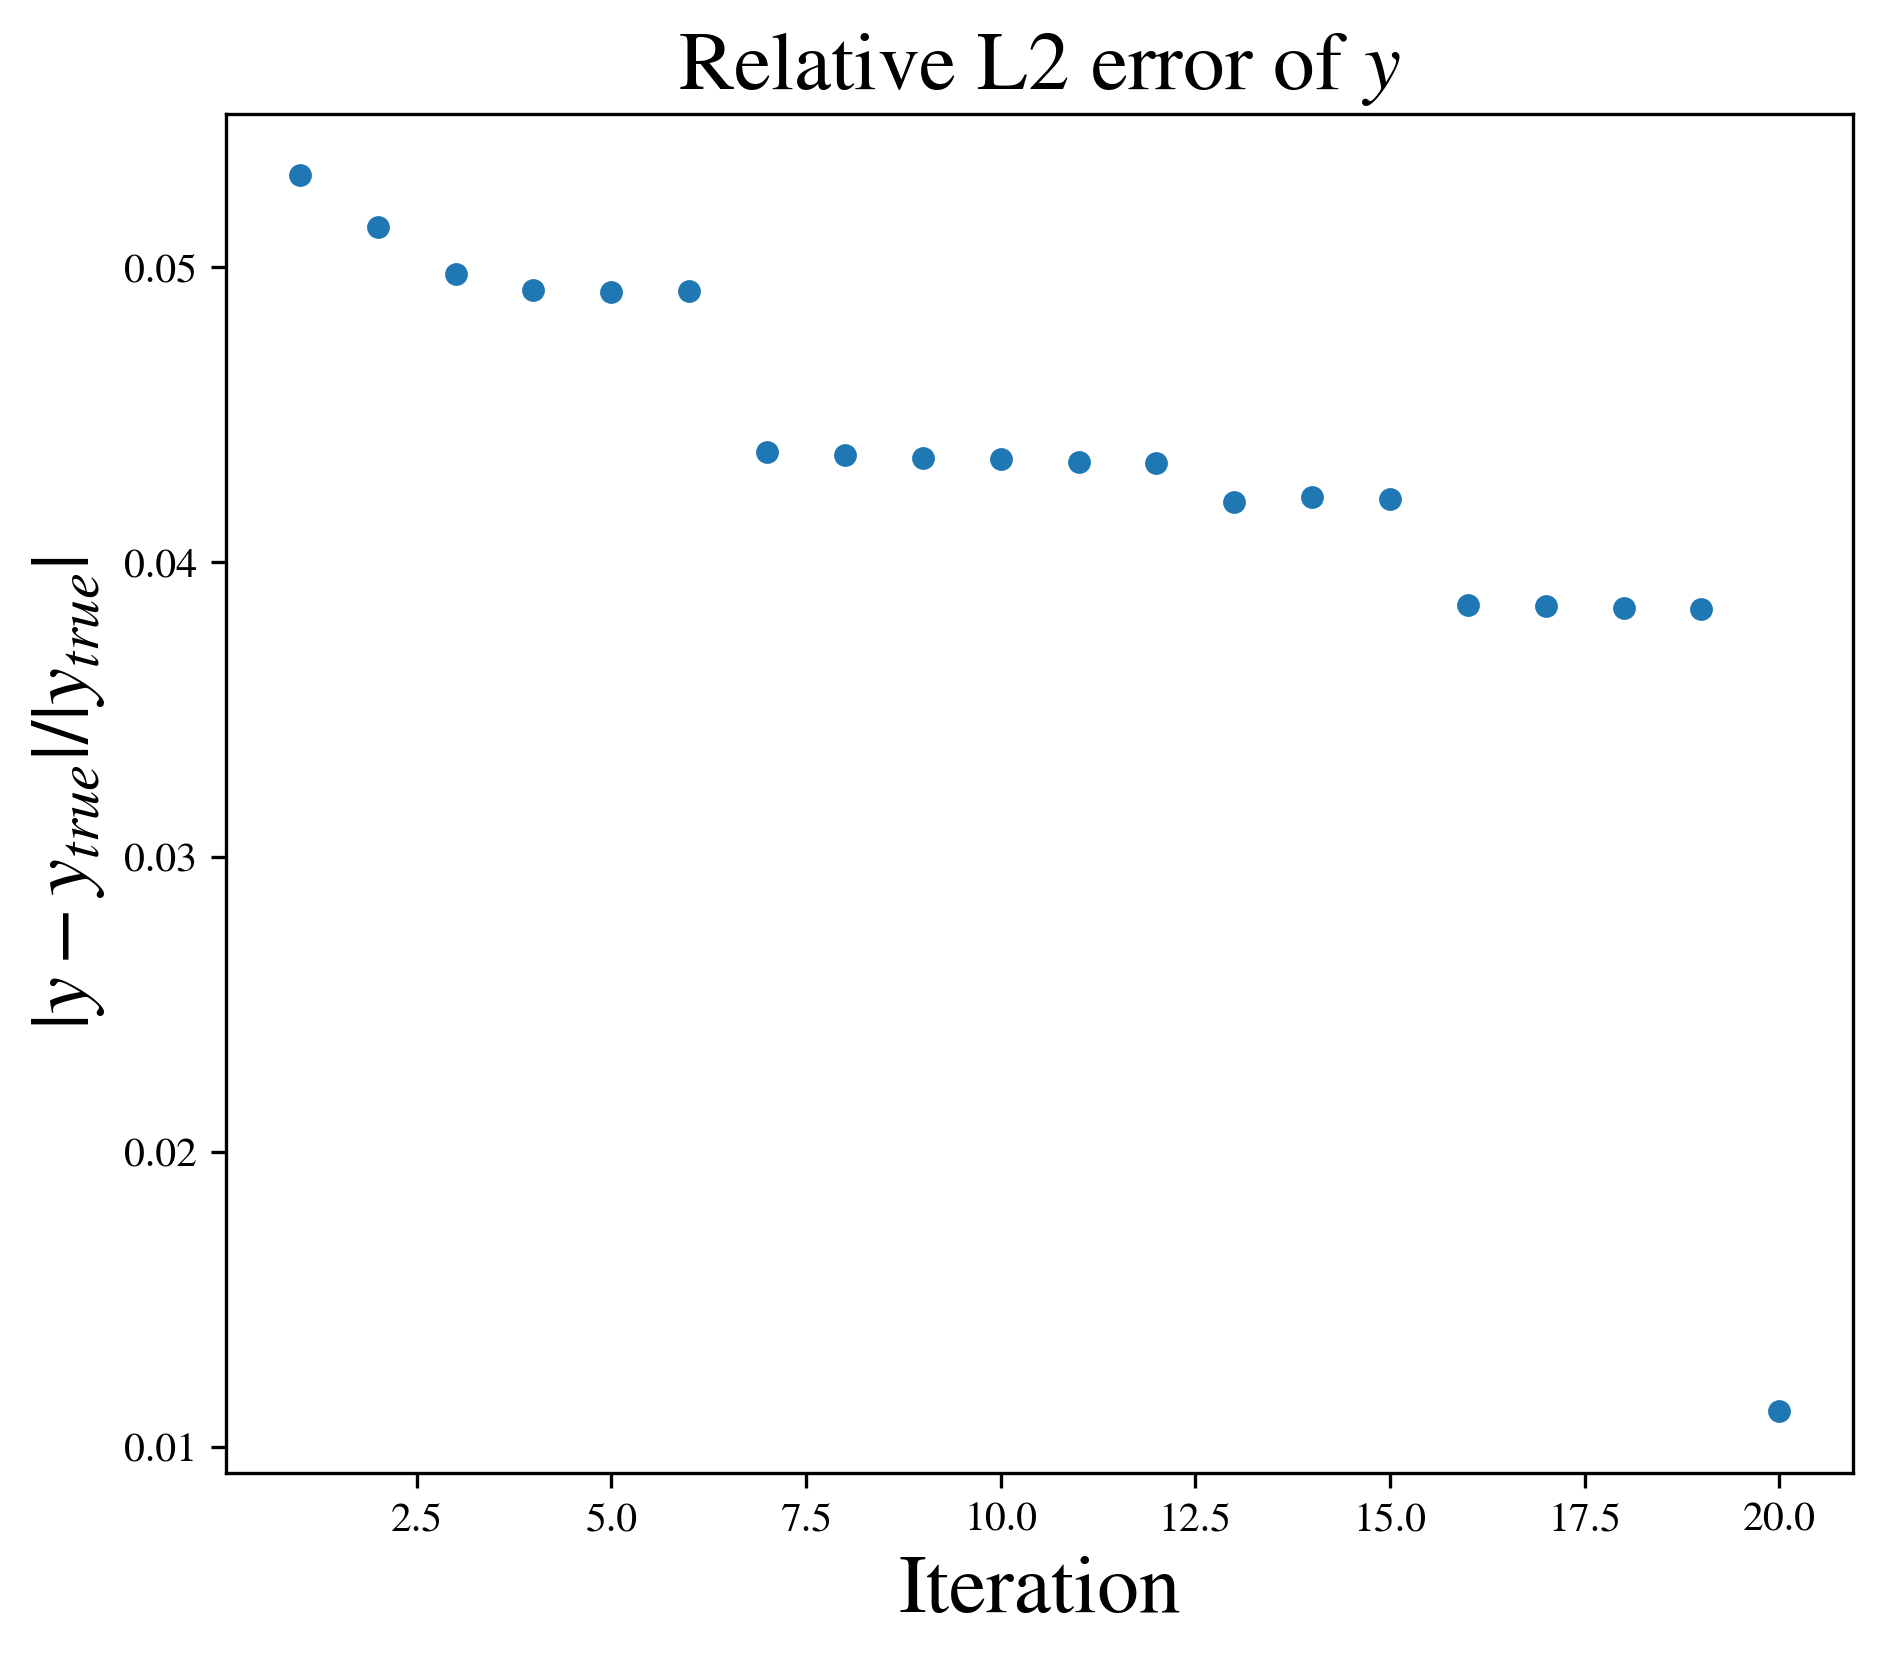

In [765]:
# myInv = loadInvModel("./models/myInvA4_B8.pickle")
myInv = loadInvModel("./models/A0.008_B0.004.pickle")
plotSeries(myInv, [0.008, 0.004], myInv.y, "./")

In [716]:
myInv.save_path

AttributeError: 'BayersianInv' object has no attribute 'save_path'

In [683]:
np.linalg.norm(myInvA10B12.y)

60.21800824364071

# Test an inversion

In [693]:
# Generate test batch
u_low = np.array([0.002, 0.004])
u_high = u_low + 0.01

# Generate input set
AA = np.linspace(0.002, 0.01, 5)
BB = np.linspace(0.004, 0.012, 5)[np.random.permutation(5)]
test_input_set = np.array([[AA[i], BB[i]] for i in range(len(AA))])
fTerms = 32

testBatch = RunABatch(test_input_set, work_path, FourierTerms = fTerms)
print("Test input set: \n", test_input_set)

/home/shengduo/InverseProblems/GPRWorkingField
Test input set: 
 [[0.002 0.012]
 [0.004 0.008]
 [0.006 0.01 ]
 [0.008 0.004]
 [0.01  0.006]]


In [766]:
# Run an inversion test:
testCase_idx = 0
u = testBatch.input_set[testCase_idx]
y = testBatch.Observations[testCase_idx]
myInv = BayersianInv(u_low, u_high, u, y, work_path, FourierTerms = fTerms, n_samples = 20)
myInv.run(n_iter_max = 10)

# # Save to file
# import pickle

# #save it
# with open(f'./models/myInvA4_B6.pickle', 'wb') as file:
#     pickle.dump(myInv, file) 

==============================  Iteration  0   ==============================
Running case A0.009158731311144485_B0.007994332334331715
Finished in 5 s!

Running case A0.008705539442681825_B0.008786173169035311
Finished in 5 s!

Running case A0.004395425181967485_B0.010200513682066772
Finished in 5 s!

Running case A0.0054632754039331925_B0.00994931270339932
Finished in 5 s!

Running case A0.0027129478278940886_B0.01124907435482175
Finished in 6 s!

Running case A0.010190822018093782_B0.0061118017465867135
Finished in 5 s!

Running case A0.006460287750757503_B0.006382119183189144
Finished in 5 s!

Running case A0.004609403015271038_B0.004313758337196384
Finished in 6 s!

Running case A0.002856075157980619_B0.013320420481768
Finished in 5 s!

Running case A0.00433193862420348_B0.006348115674054815
Finished in 5 s!

Running case A0.002977942540507812_B0.005549471293343128
Finished in 5 s!

Running case A0.0045104021618278655_B0.004688684869322971
Finished in 5 s!

Running case A0.01043211

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  120.59395027160645  s
Average error in this iteration:  8.848618542023546e+01
Maximum to minimum distance in the sample points:  32.555047865858285
Mean of the posterior after this iteration:  [0.00276254 0.01153339]
Stdv of the posterior after this iteration:  [0.00016592 0.00072271]
==============================  Iteration  4   ==============================
eta_times, MaxMinDistRatio:  1 76.37336699064343
Running case A0.0026072645241958826_B0.011758540376455368
Finished in 5 s!

Running case A0.002625212987476002_B0.011719021016488619
Finished in 5 s!

Running case A0.0026092227348892046_B0.011769750882276024
Finished in 5 s!

Running case A0.0026444643878467495_B0.011749033472021183
Finished in 5 s!

Running case A0.002635983979952987_B0.011729108182711376
Finished in 5 s!

Running case A0.0028742365198617375_B0.011622959679705345
Finished in 5 s!

Running case A0.002622884831125339_B0.011672223789596994
Finished in 5 s!

Running case A0.002625127295764341_B0.01166293

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  120.77143359184265  s
Average error in this iteration:  8.218696514033914e+01
Maximum to minimum distance in the sample points:  76.37336699064343
Mean of the posterior after this iteration:  [0.00259632 0.01167949]
Stdv of the posterior after this iteration:  [0.00042079 0.00037886]
==============================  Iteration  5   ==============================
eta_times, MaxMinDistRatio:  2 36.72598935725699
Running case A0.0026095418049730114_B0.011699745908002214
Finished in 4 s!

Running case A0.0026359457451876045_B0.0117104962071136
Finished in 5 s!

Running case A0.0026319663028749104_B0.011719826027800154
Finished in 6 s!

Running case A0.0026488886505590457_B0.011734980120702553
Finished in 5 s!

Running case A0.002613267576703265_B0.011821915587097527
Finished in 5 s!

Running case A0.002630378092421375_B0.011801605936438754
Finished in 5 s!

Running case A0.0026297432834242233_B0.011778515101831019
Finished in 5 s!

Running case A0.0026396245618253216_B0.011737461

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  125.69907879829407  s
Average error in this iteration:  7.408048654894705e+01
Maximum to minimum distance in the sample points:  36.72598935725699
Mean of the posterior after this iteration:  [0.00266068 0.01158446]
Stdv of the posterior after this iteration:  [0.00015927 0.00076314]
==============================  Iteration  6   ==============================
eta_times, MaxMinDistRatio:  1 80.32913353810177
Running case A0.0025966549365412112_B0.011746966128812656
Finished in 5 s!

Running case A0.0026276189392471275_B0.011774580723124718
Finished in 5 s!

Running case A0.0026129916034803645_B0.011780294013100972
Finished in 5 s!

Running case A0.002615707107656383_B0.011712163411691593
Finished in 5 s!

Running case A0.0026050726569455365_B0.01176985292169847
Finished in 5 s!

Running case A0.0026163009062697144_B0.011750458052416413
Finished in 5 s!

Running case A0.002596043088767001_B0.011725672142442157
Finished in 5 s!

Running case A0.0026034284681488904_B0.01175108

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  127.73278903961182  s
Average error in this iteration:  6.936018263697898e+01
Maximum to minimum distance in the sample points:  80.32913353810177
Mean of the posterior after this iteration:  [0.00268994 0.01152006]
Stdv of the posterior after this iteration:  [0.00017666 0.00072393]
==============================  Iteration  7   ==============================
eta_times, MaxMinDistRatio:  2 112.02823315633808
Running case A0.0026035665754230346_B0.011715983974840215
Finished in 5 s!

Running case A0.0026071820211636507_B0.011737989742632054
Finished in 5 s!

Running case A0.0025963670511440088_B0.011789401583151882
Finished in 5 s!

Running case A0.002599629964724631_B0.011816443460609383
Finished in 5 s!

Running case A0.0026057837623983137_B0.01171709899523566
Finished in 5 s!

Running case A0.0025998709314893017_B0.011734993507651155
Finished in 5 s!

Running case A0.002589666477051617_B0.011757857212970959
Finished in 5 s!

Running case A0.0026221516825070223_B0.0117236

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  132.39770936965942  s
Average error in this iteration:  6.8171497085718e+01
Maximum to minimum distance in the sample points:  112.02823315633808
Mean of the posterior after this iteration:  [0.00267915 0.01153374]
Stdv of the posterior after this iteration:  [0.00017441 0.00072525]
==============================  Iteration  8   ==============================
eta_times, MaxMinDistRatio:  2 472.7713033148526
Running case A0.002623255062259241_B0.011708985067476857
Finished in 5 s!

Running case A0.002601608524888338_B0.011770860539187501
Finished in 5 s!

Running case A0.002588761875976326_B0.011762086627854834
Finished in 5 s!

Running case A0.0028440645628863307_B0.011534427090007893
Finished in 5 s!

Running case A0.0032554762504650265_B0.011989673157271643
Finished in 5 s!

Running case A0.002576458969748854_B0.011829448859558065
Finished in 5 s!

Running case A0.0026109432047652153_B0.011693043573634156
Finished in 5 s!

Running case A0.002580173276434477_B0.01181626605

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  134.7679762840271  s
Average error in this iteration:  9.148914336678664e+01
Maximum to minimum distance in the sample points:  472.7713033148526
Mean of the posterior after this iteration:  [0.00243481 0.01163847]
Stdv of the posterior after this iteration:  [0.00035613 0.00039358]
==============================  Iteration  9   ==============================
eta_times, MaxMinDistRatio:  2 3766.6588391524006
Running case A0.0025795649075271957_B0.011715170350545668
Finished in 5 s!

Running case A0.0026081924907353595_B0.011781585430297626
Finished in 5 s!

Running case A0.002576888284567956_B0.011848162465637949
Finished in 5 s!

Running case A0.00365483138028087_B0.006065671716605489
Finished in 5 s!

Running case A0.0025868628728759613_B0.011776381835969626
Finished in 5 s!

Running case A0.002567540862429224_B0.011771573609888517
Finished in 6 s!

Running case A0.0026098415422669994_B0.011777833824472415
Finished in 5 s!

Running case A0.0026006420545613496_B0.011751504

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  138.79361653327942  s
Average error in this iteration:  2.610131836957727e+02
Maximum to minimum distance in the sample points:  3766.6588391524006
Mean of the posterior after this iteration:  [0.00253849 0.01177079]
Stdv of the posterior after this iteration:  [0.00027145 0.00051607]


In [768]:
myInv.run(n_iter_max = 10)

==============================  Iteration  10   ==============================
eta_times, MaxMinDistRatio:  2 1.0327495984641196e+03
Running case A0.0025982321518712445_B0.01174395866894669
Finished in 6 s!

Running case A0.0025820568958815114_B0.011772504690180072
Finished in 5 s!

Running case A0.0025994970571395666_B0.011791115461925317
Finished in 5 s!

Running case A0.002586303163848301_B0.011741858216764002
Finished in 5 s!

Running case A0.0025883226968538074_B0.011695119118812913
Finished in 5 s!

Running case A0.0025762908527236406_B0.011801542957307237
Finished in 6 s!

Running case A0.002573078421723346_B0.01177587607509911
Finished in 5 s!

Running case A0.0025837874505997525_B0.011765715396611606
Finished in 5 s!

Running case A0.0025782310215197246_B0.011741570775041893
Finished in 5 s!

Running case A0.0025911364326727062_B0.011804844209400873
Finished in 6 s!

Running case A0.0028866158842627537_B0.005859100722096095
Finished in 5 s!

Running case A0.002570758430640099_

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  144.9492585659027  s
Average error in this iteration:  2.3451458910595983e+02
Maximum to minimum distance in the sample points:  1032.7495984641196
Mean of the posterior after this iteration:  [0.00262599 0.0117538 ]
Stdv of the posterior after this iteration:  [0.00024074 0.0004397 ]
==============================  Iteration  11   ==============================
eta_times, MaxMinDistRatio:  2 949.7494907202546
Running case A0.0025768611291175666_B0.011771934321237541
Finished in 5 s!

Running case A0.0025908686013321404_B0.01178633449525471
Finished in 5 s!

Running case A0.002577447265095995_B0.011743683040463502
Finished in 5 s!

Running case A0.002574113869411822_B0.011742134184520052
Finished in 6 s!

Running case A0.002572385121054716_B0.01177155318213288
Finished in 5 s!

Running case A0.0035013399890756218_B0.01135750123936607
Finished in 5 s!

Running case A0.002587555210315723_B0.011741862941491703
Finished in 5 s!

Running case A0.002586829931293405_B0.01178371416

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  147.1569104194641  s
Average error in this iteration:  1.3188938091602543e+02
Maximum to minimum distance in the sample points:  949.7494907202546
Mean of the posterior after this iteration:  [0.00244777 0.01167464]
Stdv of the posterior after this iteration:  [0.00041139 0.00041086]
==============================  Iteration  12   ==============================
eta_times, MaxMinDistRatio:  2 93.22782485524702
Running case A0.002591702064680587_B0.01180182732142896
Finished in 5 s!

Running case A0.002579078141432545_B0.011775789773922326
Finished in 5 s!

Running case A0.0025976602810669266_B0.011737121144986522
Finished in 5 s!

Running case A0.0025903957505667235_B0.011757315372640293
Finished in 5 s!

Running case A0.002595557464034065_B0.011750899558909568
Finished in 5 s!

Running case A0.0025864473916580905_B0.011752322231959178
Finished in 6 s!

Running case A0.002557075999386186_B0.011743862920776282
Finished in 5 s!

Running case A0.0025859426956880345_B0.011751301

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  152.25086331367493  s
Average error in this iteration:  6.301091579590887e+01
Maximum to minimum distance in the sample points:  93.22782485524702
Mean of the posterior after this iteration:  [0.00248991 0.01170903]
Stdv of the posterior after this iteration:  [0.00018713 0.00073378]
==============================  Iteration  13   ==============================
eta_times, MaxMinDistRatio:  2 1.3636390058346478e+03
Running case A0.002581578886572594_B0.0117668855884929
Finished in 6 s!

Running case A0.0025647809459084887_B0.011782304587021692
Finished in 5 s!

Running case A0.0025834475258349403_B0.011730151200159243
Finished in 5 s!

Running case A0.0025821588455985827_B0.011795021393433957
Finished in 5 s!

Running case A0.0025651371525815003_B0.01175581370945825
Finished in 5 s!

Running case A0.0025703960517403047_B0.011818211730540899
Finished in 6 s!

Running case A0.0025953193115525667_B0.01178283573961082
Finished in 5 s!

Running case A0.0025782898349555627_B0.0117

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  154.55430793762207  s
Average error in this iteration:  2.4159422121486924e+02
Maximum to minimum distance in the sample points:  1363.6390058346478
Mean of the posterior after this iteration:  [0.00252106 0.01172278]
Stdv of the posterior after this iteration:  [0.00015013 0.00076753]
==============================  Iteration  14   ==============================
eta_times, MaxMinDistRatio:  2 5769.532392585749
Running case A0.002577893192797248_B0.011799434210615833
Finished in 5 s!

Running case A0.002557735291308789_B0.011832623537172748
Finished in 5 s!

Running case A0.002585881156293271_B0.01178191353425852
Finished in 5 s!

Running case A0.0025898236923697056_B0.011767052081074807
Finished in 5 s!

Running case A0.0025710950540306565_B0.011826527338879237
Finished in 5 s!

Running case A0.0025919254156932317_B0.011769401454784976
Finished in 5 s!

Running case A0.0025638194755829174_B0.011743441697033495
Finished in 6 s!

Running case A0.002569460253168162_B0.0117667

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1e+05. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  157.90178608894348  s
Average error in this iteration:  2.301182983284722e+02
Maximum to minimum distance in the sample points:  5769.532392585749
Mean of the posterior after this iteration:  [0.00261236 0.01177503]
Stdv of the posterior after this iteration:  [0.00023913 0.00043947]
==============================  Iteration  15   ==============================
eta_times, MaxMinDistRatio:  2 558.2519394601034
Running case A0.002570824209520393_B0.011758420206239288
Finished in 5 s!

Running case A0.002561738456904283_B0.01181778558043146
Finished in 5 s!

Running case A0.0025608032836571515_B0.011798320391147431
Finished in 5 s!

Running case A0.002564379208033782_B0.011748265384315395
Finished in 5 s!

Running case A0.0025665291666209233_B0.01175234466765215
Finished in 6 s!

Running case A0.0026017481214644263_B0.011792254277360645
Finished in 5 s!

Running case A0.00254924865564957_B0.011784002904671383
Finished in 5 s!

Running case A0.0025408107192303984_B0.01178527656

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  159.55017066001892  s
Average error in this iteration:  1.0535772446088743e+02
Maximum to minimum distance in the sample points:  558.2519394601034
Mean of the posterior after this iteration:  [0.00229287 0.01172324]
Stdv of the posterior after this iteration:  [0.00021902 0.00064142]
==============================  Iteration  16   ==============================
eta_times, MaxMinDistRatio:  0 4.316586557668012e+01
Running case A0.0022661493092251115_B0.011789229882655058
Finished in 5 s!

Running case A0.0022263654704193694_B0.011800194573188937
Finished in 5 s!

Running case A0.0022693529590557386_B0.0117797633876033
Finished in 5 s!

Running case A0.002247944736750652_B0.011801578819633786
Finished in 5 s!

Running case A0.002233648916882635_B0.011787356065784349
Finished in 5 s!

Running case A0.0022681948926303696_B0.011775338190363359
Finished in 6 s!

Running case A0.0022278441988463618_B0.011812565672933725
Finished in 5 s!

Running case A0.0022341518521130127_B0.011

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  142.88569259643555  s
Average error in this iteration:  1.5248141955443401e+01
Maximum to minimum distance in the sample points:  43.16586557668012
Mean of the posterior after this iteration:  [0.0045782 0.0085225]
Stdv of the posterior after this iteration:  [0.00360015 0.00390023]
==============================  Iteration  17   ==============================
eta_times, MaxMinDistRatio:  2 5.136213197622532e+03
Running case A0.0022241047194917337_B0.011806742298139545
Finished in 5 s!

Running case A0.002223429685546091_B0.011792854058858344
Finished in 6 s!

Running case A0.0022213553592430914_B0.011794682799718117
Finished in 5 s!

Running case A0.0022733243480624384_B0.011793725503391559
Finished in 5 s!

Running case A0.0022642819961393897_B0.011790730282580491
Finished in 5 s!

Running case A0.0022344760868288354_B0.011802150373576282
Finished in 5 s!

Running case A0.011404584498347786_B0.013993019966242819
Finished in 6 s!

Running case A0.002258093613652704_B0.0117

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  167.1073455810547  s
Average error in this iteration:  6.284241468445449e+03
Maximum to minimum distance in the sample points:  5136.213197622532
Mean of the posterior after this iteration:  [0.00218845 0.01139987]
Stdv of the posterior after this iteration:  [0.0001187  0.00172074]
==============================  Iteration  18   ==============================
eta_times, MaxMinDistRatio:  2 6.339540742459456e+03
Running case A0.002266297384891634_B0.011803859661589448
Finished in 5 s!

Running case A0.002268866003405276_B0.011789370921023598
Finished in 5 s!

Running case A0.0024667125710706858_B0.005087165299664021
Finished in 5 s!

Running case A0.002243927028908234_B0.011807684385250138
Finished in 5 s!

Running case A0.002222269792288282_B0.01180819293056017
Finished in 5 s!

Running case A0.0022649294305987803_B0.011774274184555329
Finished in 6 s!

Running case A0.002276250555297106_B0.011817353039048004
Finished in 5 s!

Running case A0.0022578542680740457_B0.0117766

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  173.1872010231018  s
Average error in this iteration:  4.0856121048912536e+02
Maximum to minimum distance in the sample points:  6339.540742459456
Mean of the posterior after this iteration:  [0.00232977 0.01172658]
Stdv of the posterior after this iteration:  [0.00116574 0.00079102]
==============================  Iteration  19   ==============================
eta_times, MaxMinDistRatio:  2 128.50526757785892
Running case A0.0022125927578016385_B0.011811670743726676
Finished in 5 s!

Running case A0.002238096146356542_B0.011769692054077213
Finished in 5 s!

Running case A0.002231408613670117_B0.011800509743302016
Finished in 5 s!

Running case A0.0022111977239647434_B0.011780769107157286
Finished in 5 s!

Running case A0.002234654226308725_B0.01180336201359343
Finished in 5 s!

Running case A0.002244166184467167_B0.011779890309619727
Finished in 5 s!

Running case A0.002217925345553295_B0.011812131353709385
Finished in 6 s!

Running case A0.002279377080447704_B0.0117755526

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  168.8973994255066  s
Average error in this iteration:  1.3013910117976774e+01
Maximum to minimum distance in the sample points:  128.50526757785892
Mean of the posterior after this iteration:  [0.00437044 0.00782642]
Stdv of the posterior after this iteration:  [0.00327498 0.00345386]


/tmp/ipykernel_3911347/4168062216.py:293: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (7, 6), dpi = dpi_value)


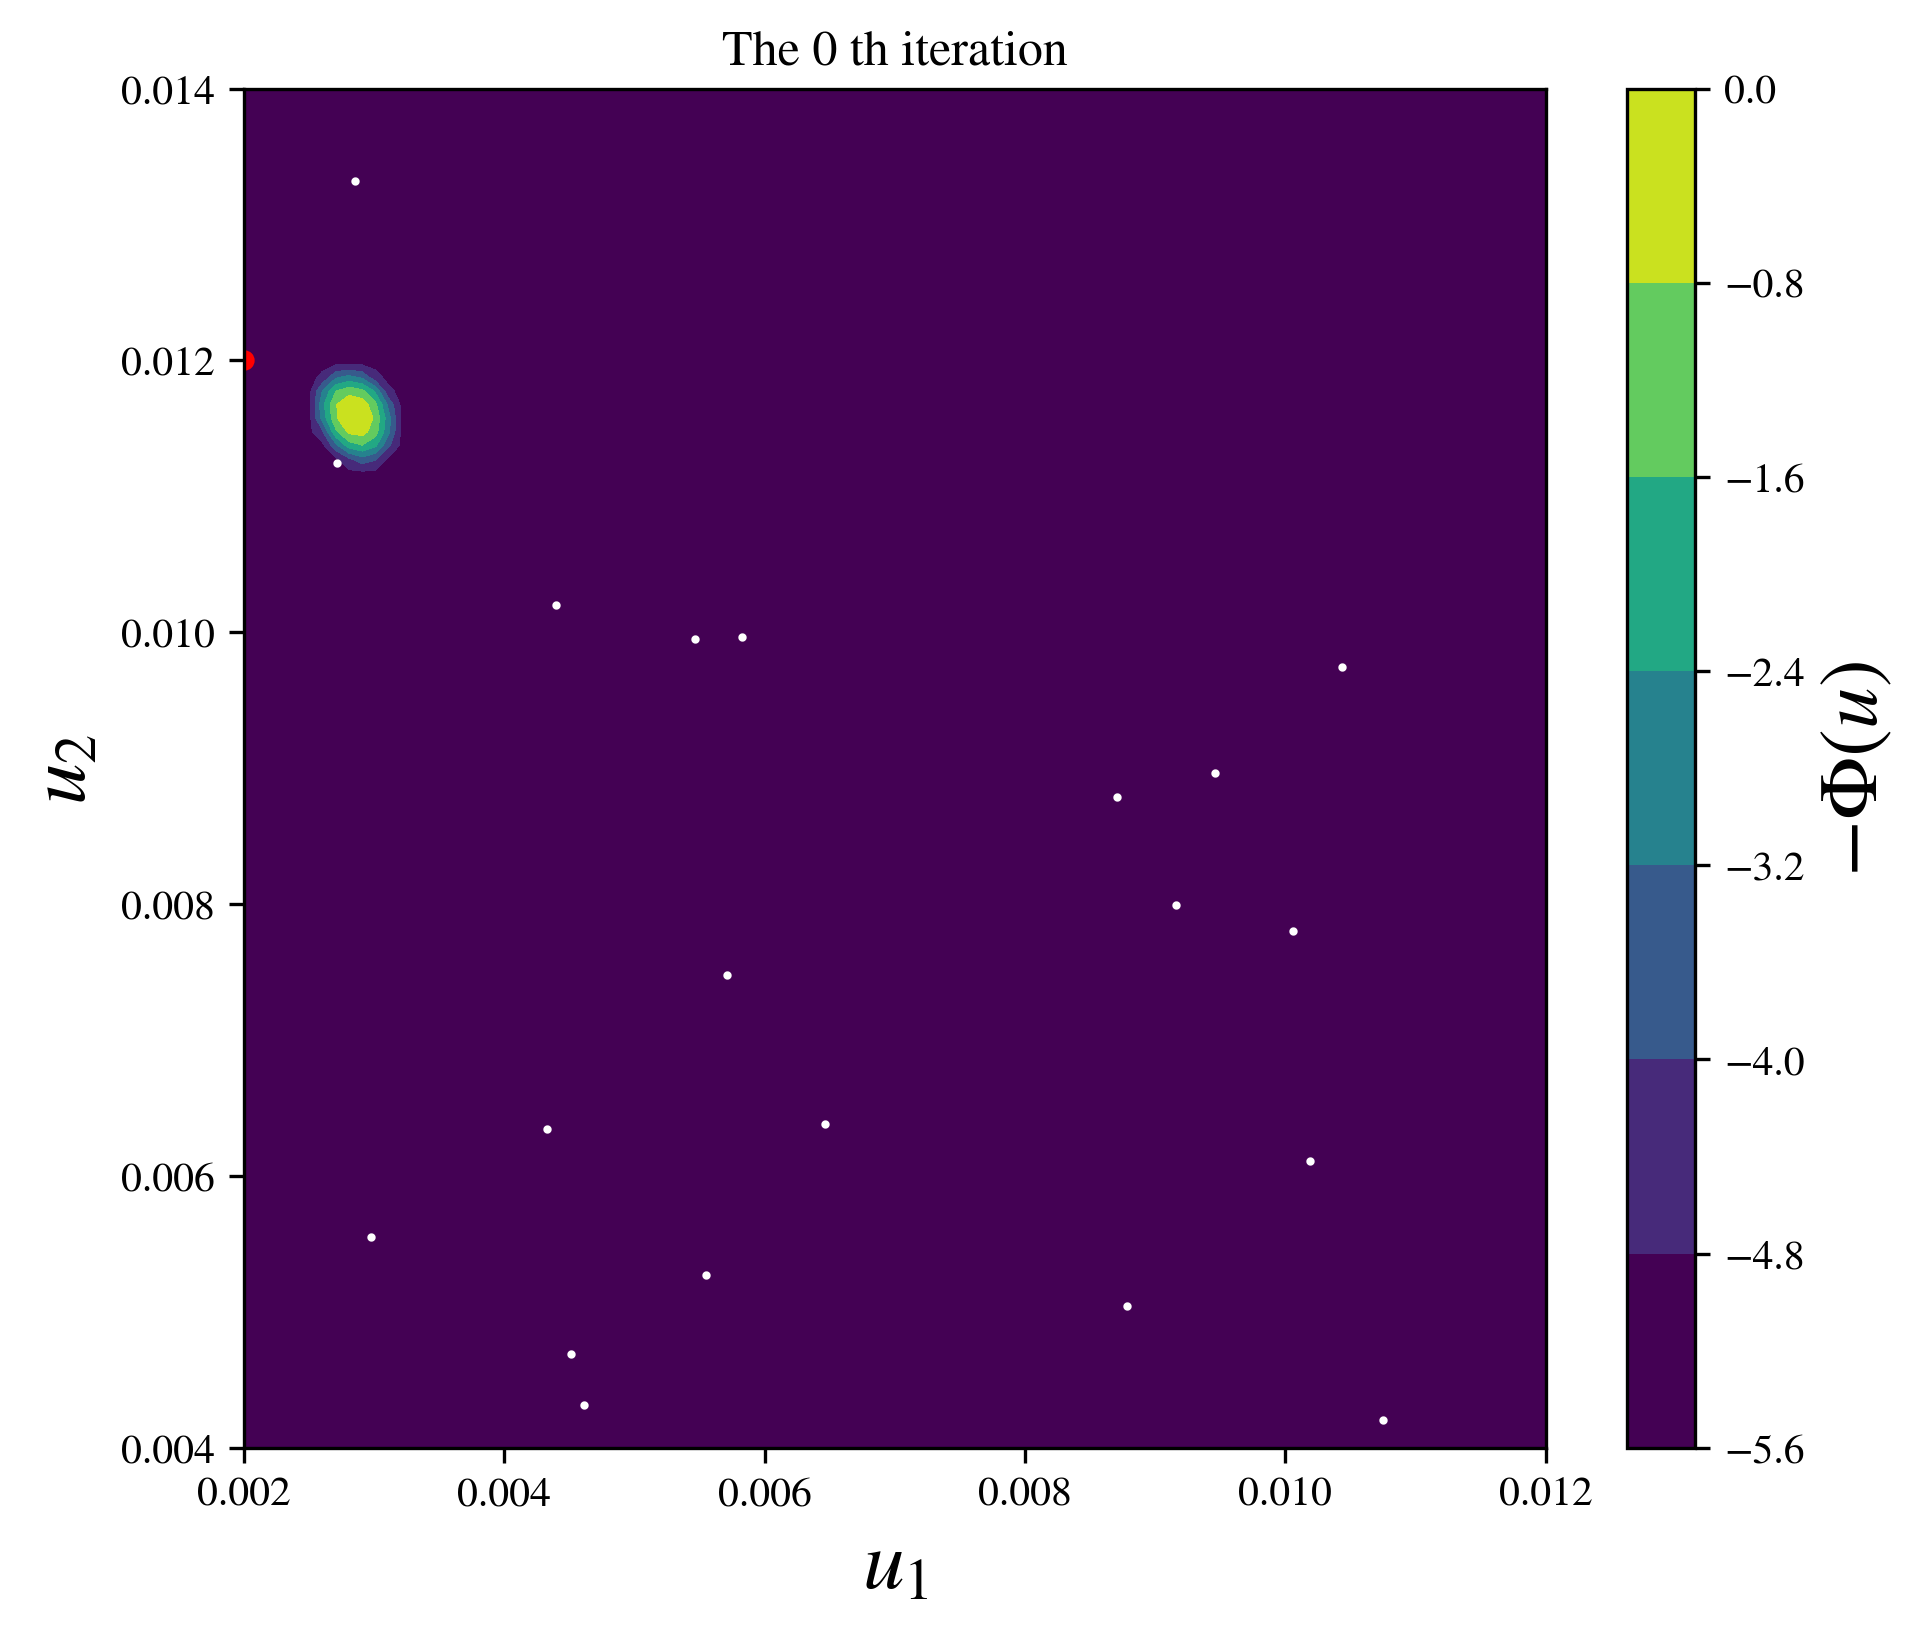

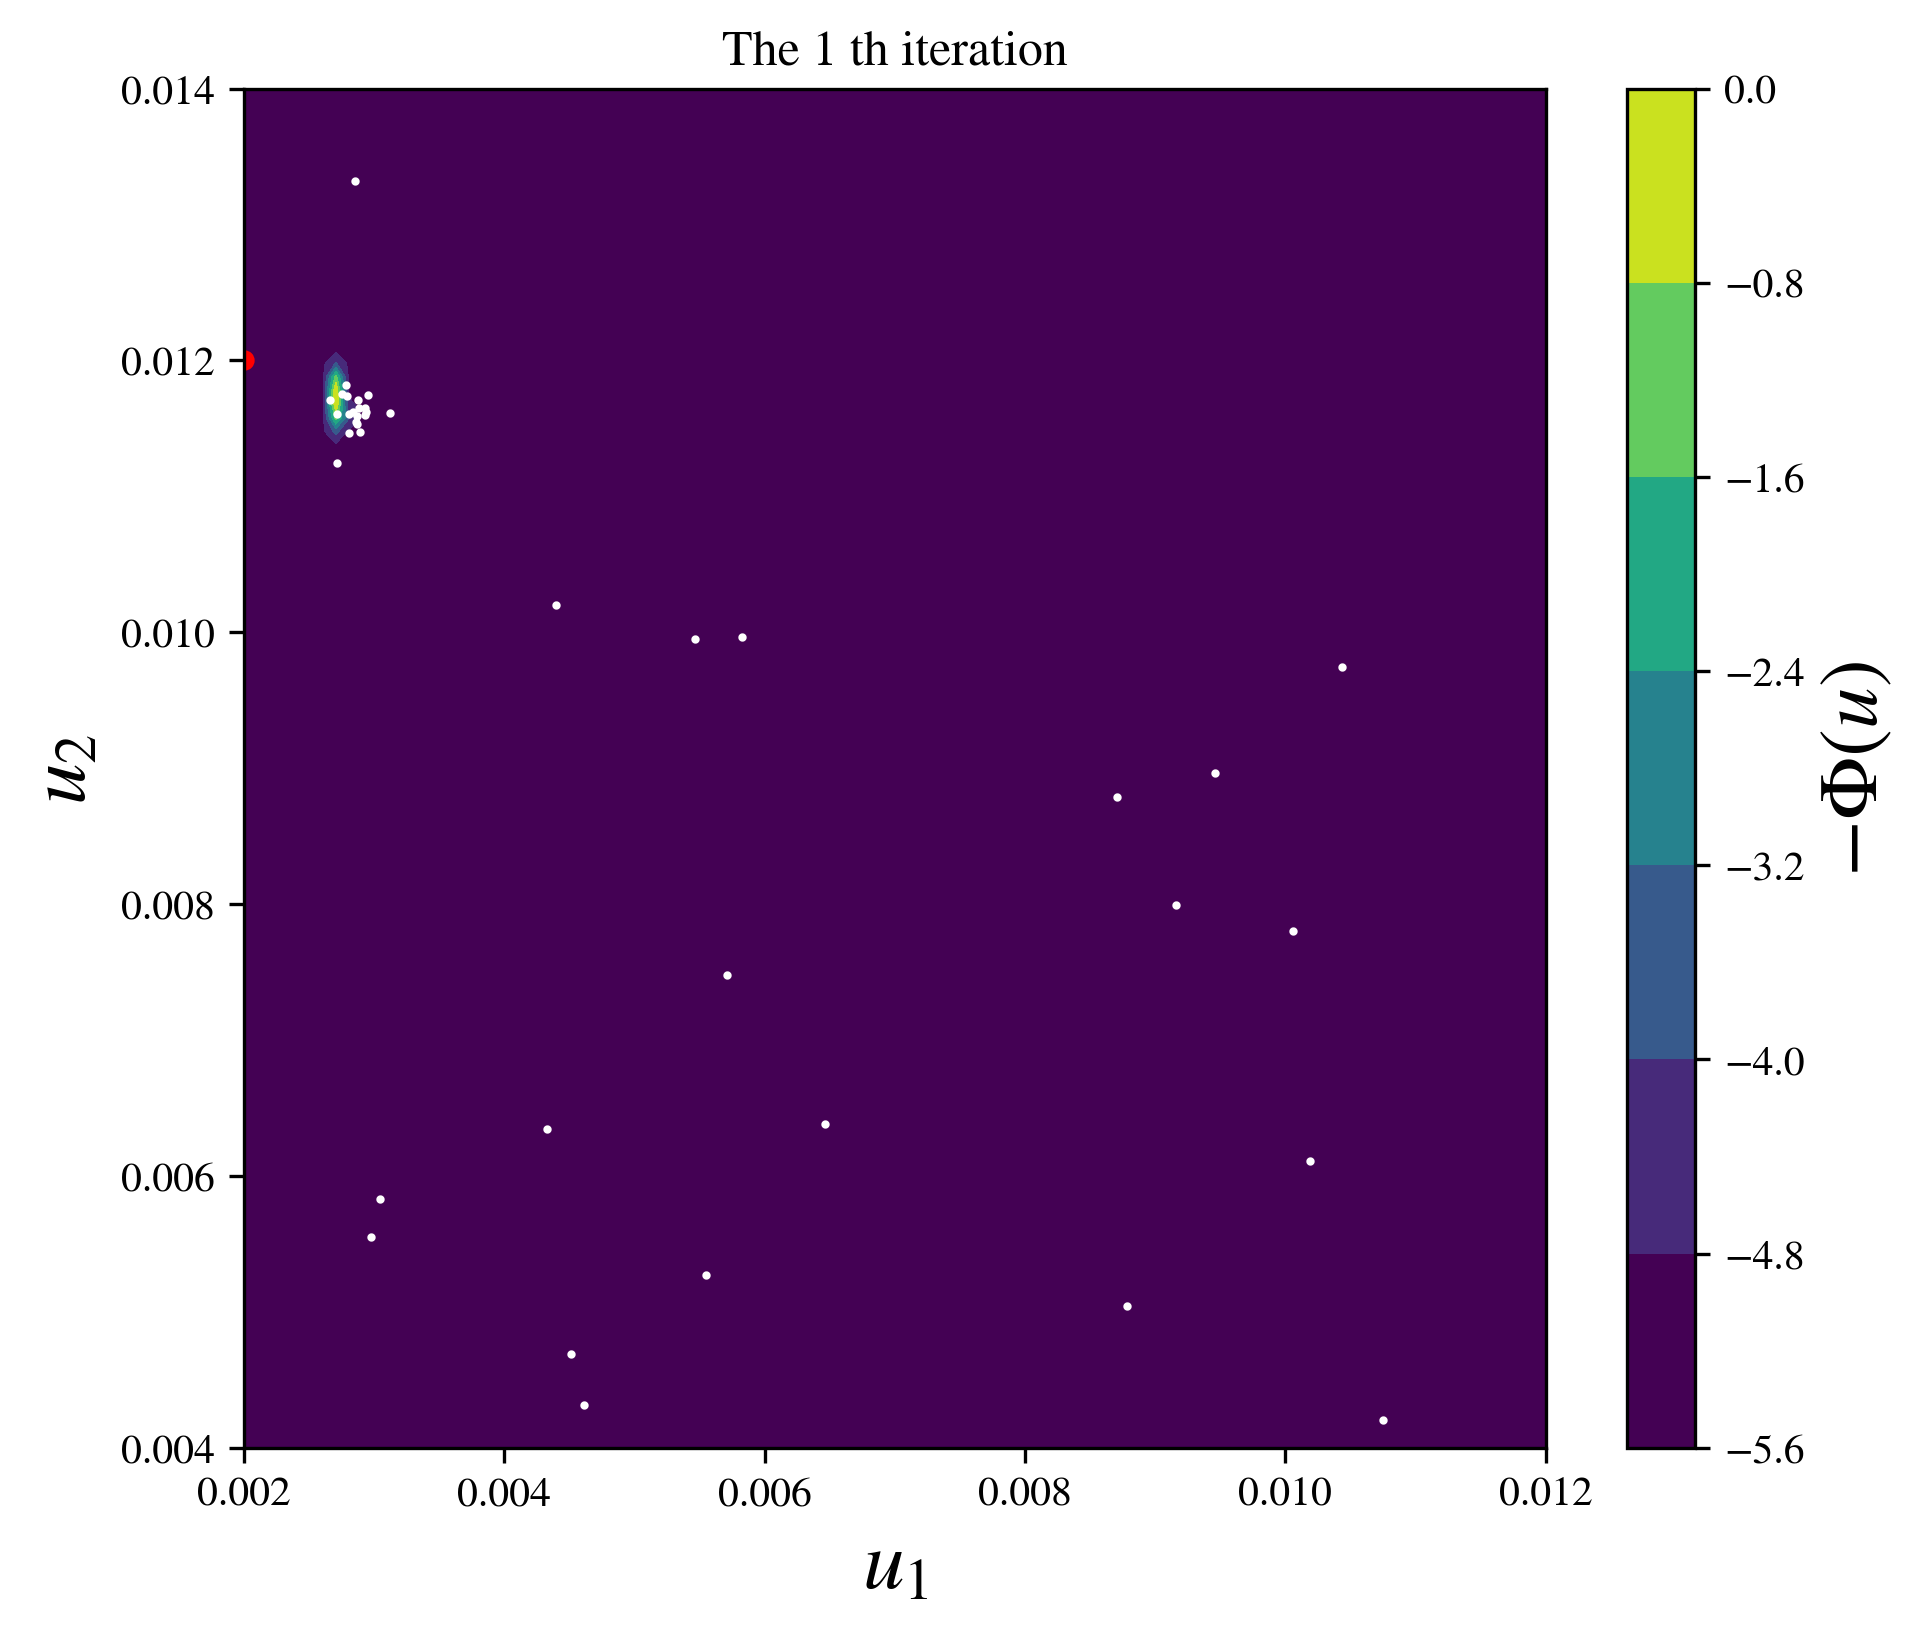

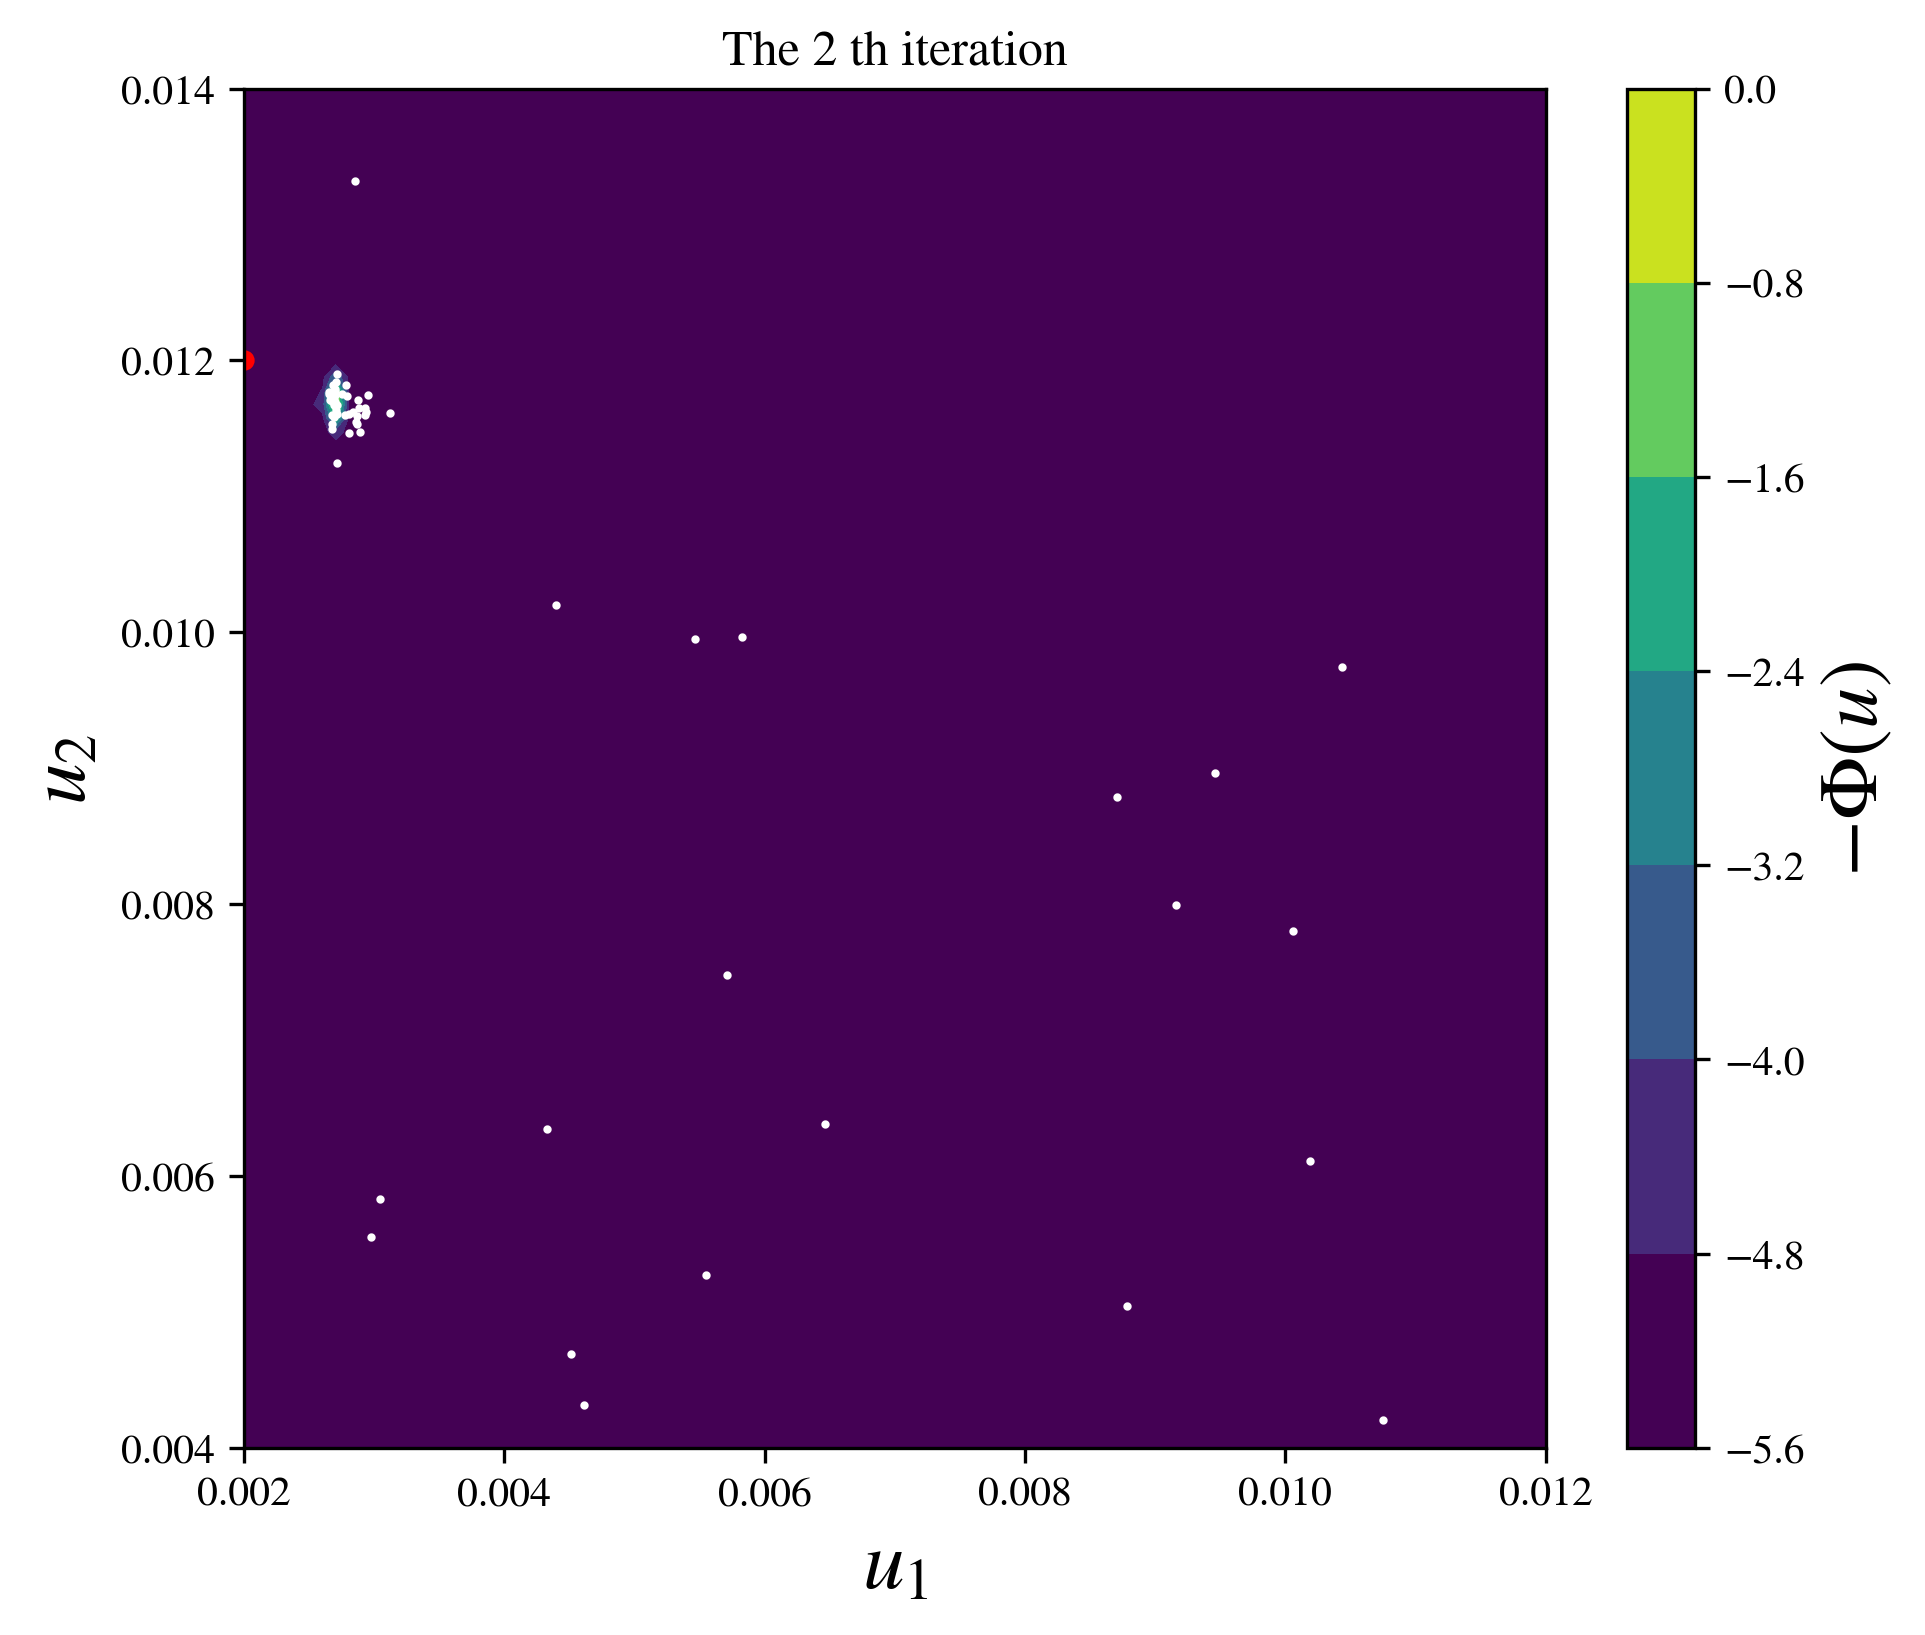

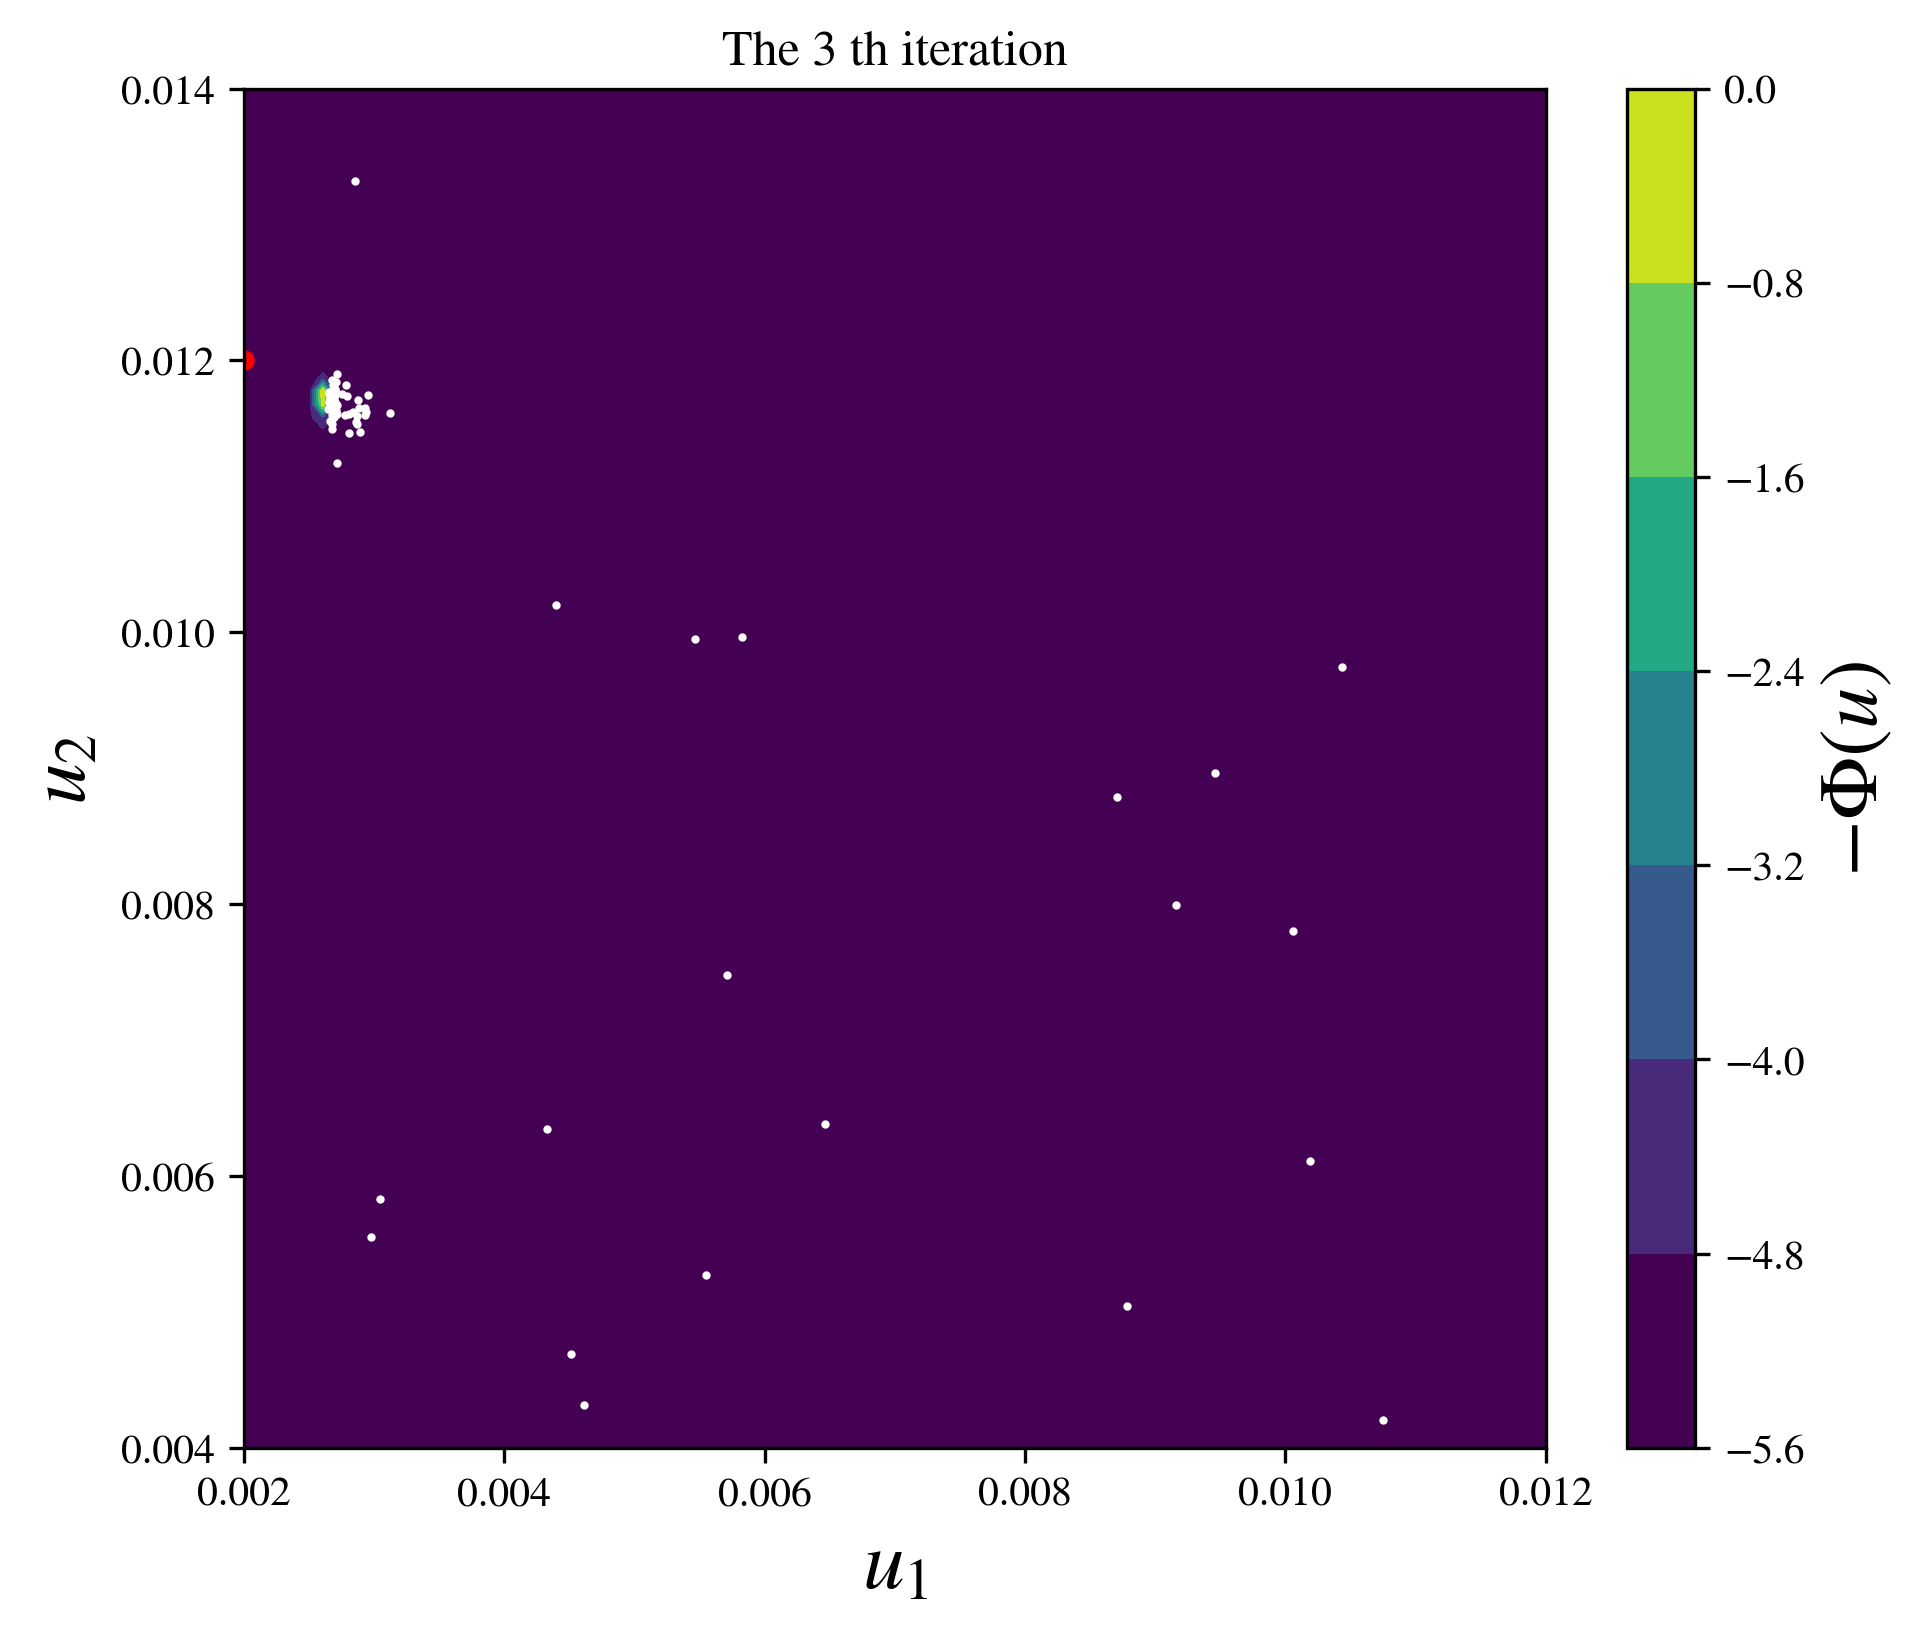

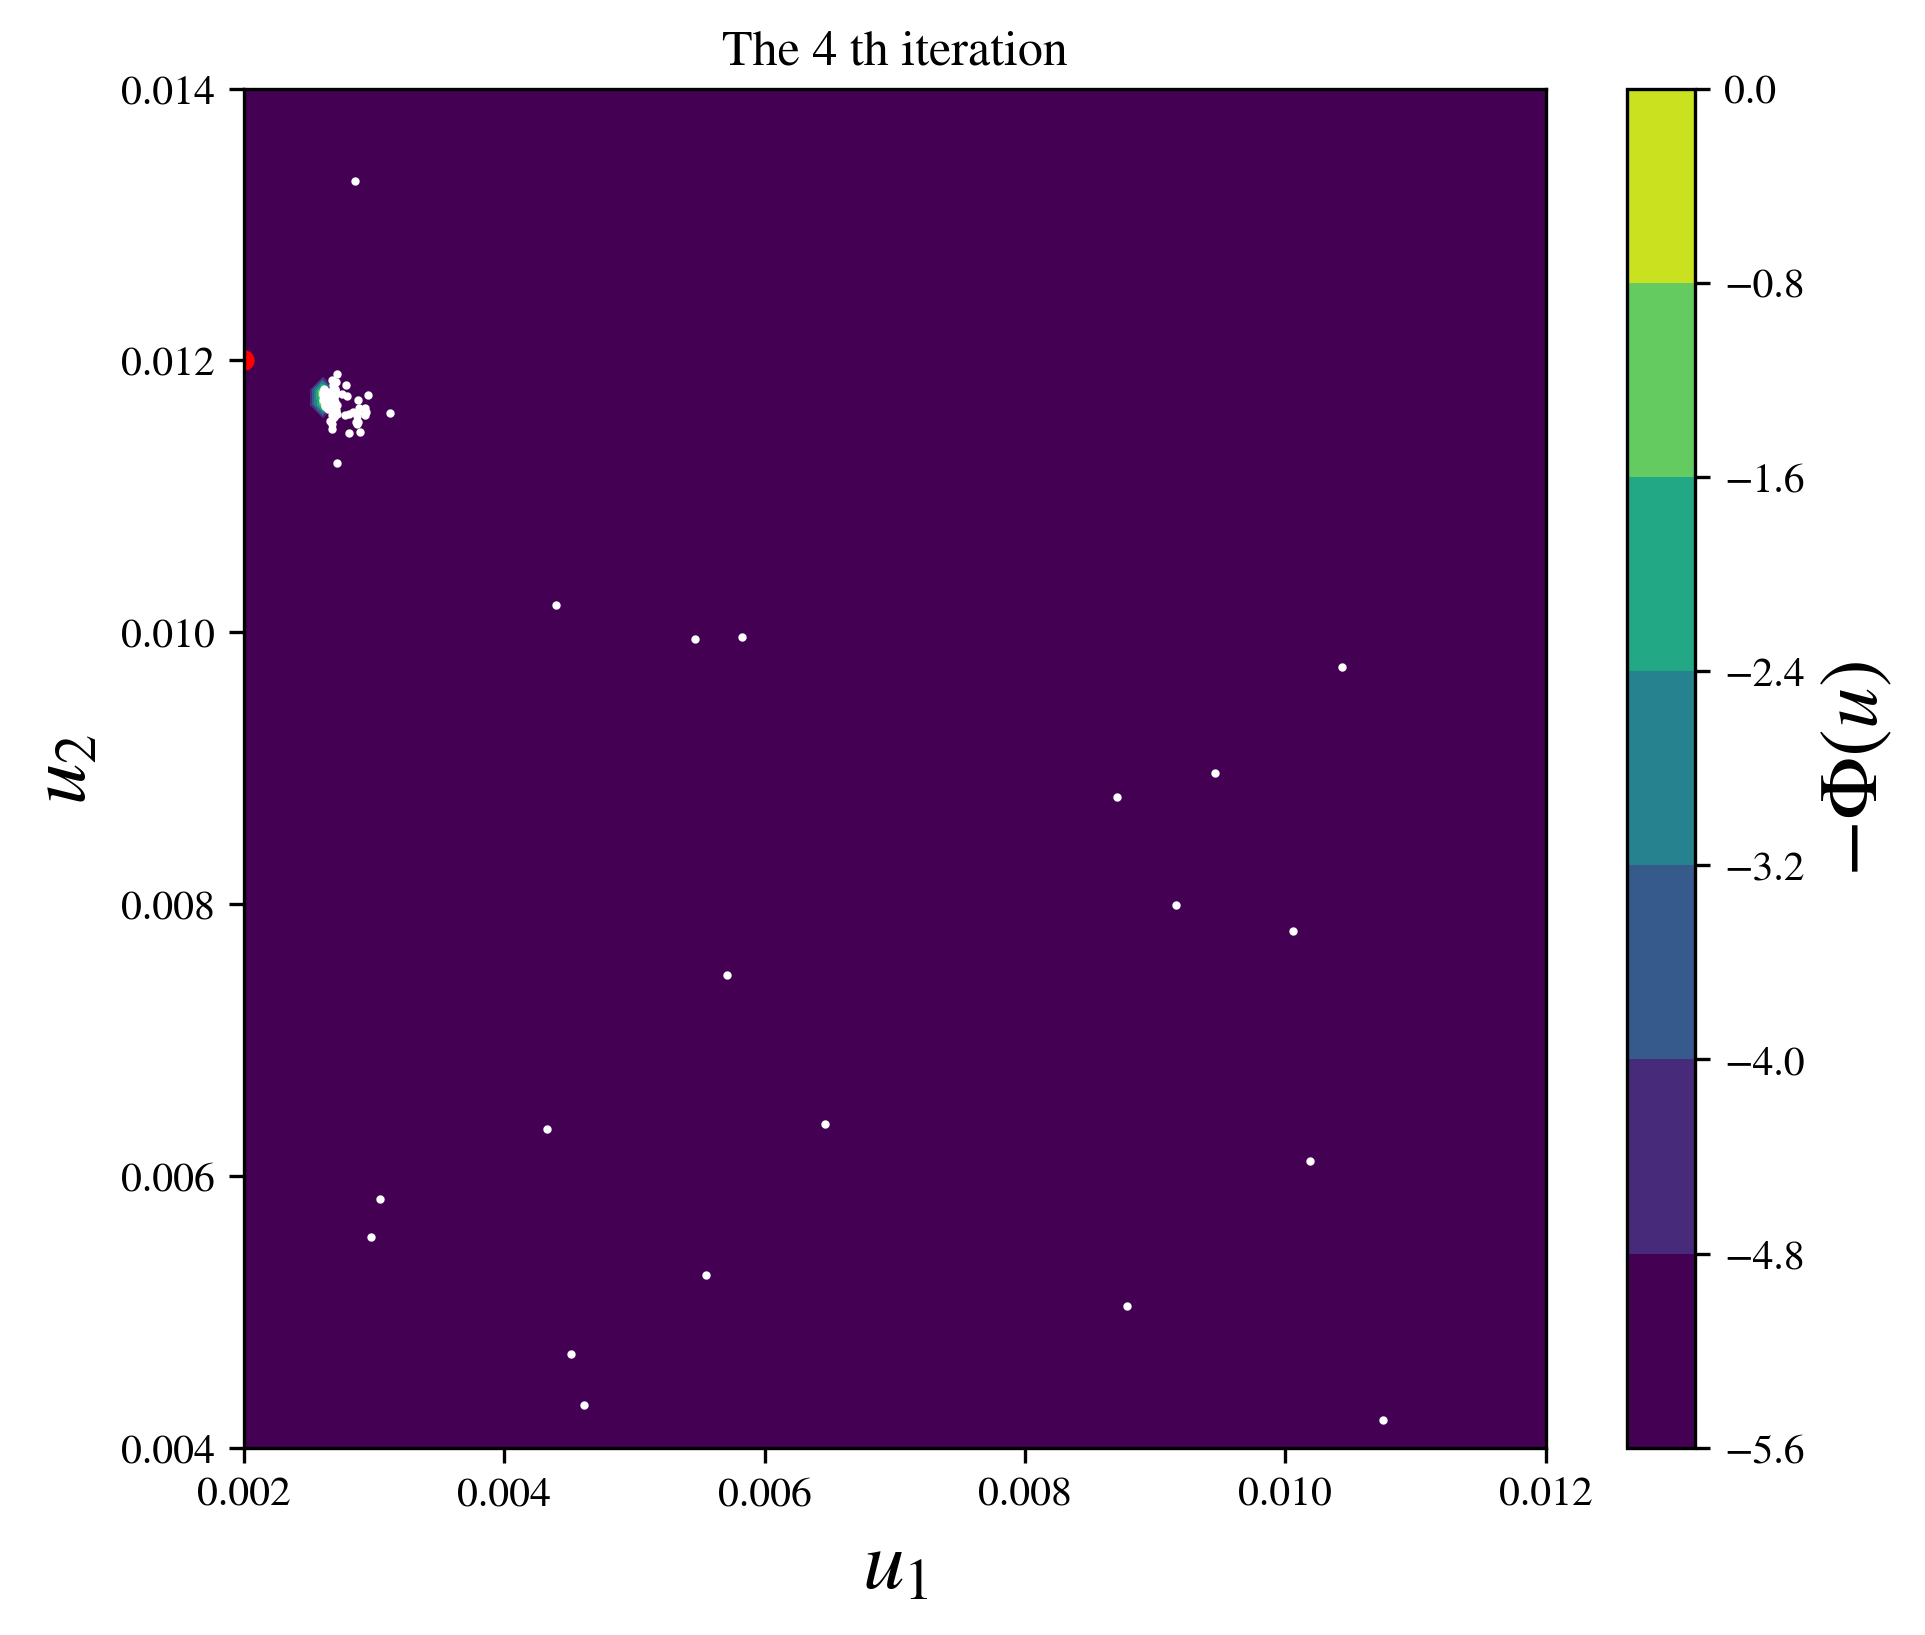

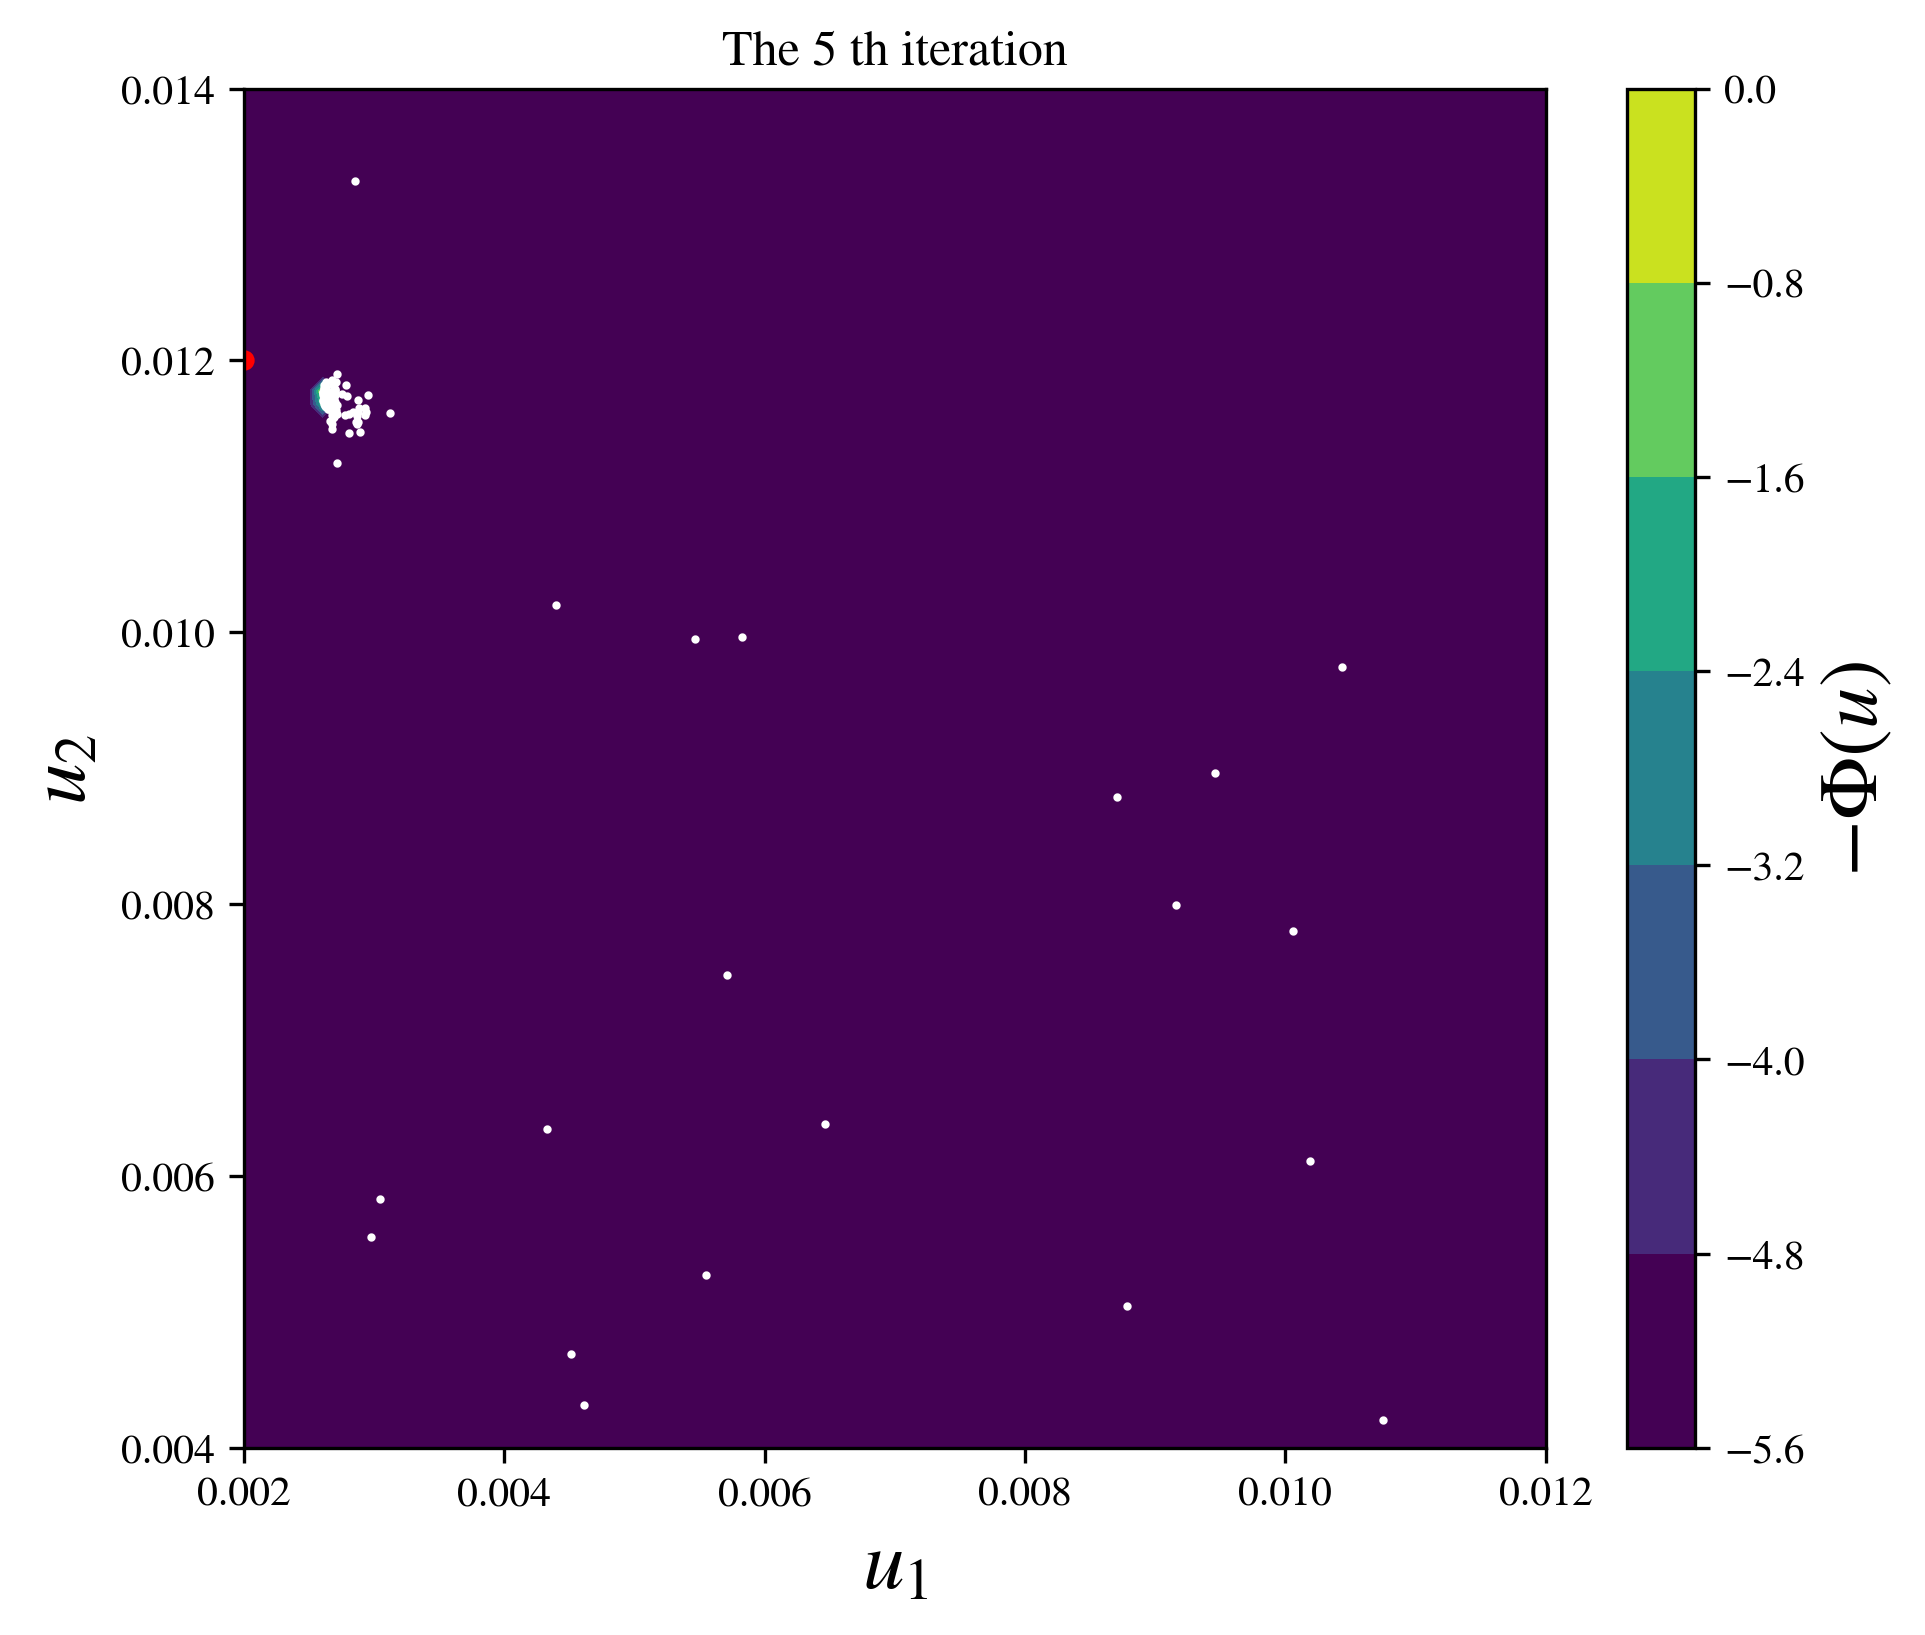

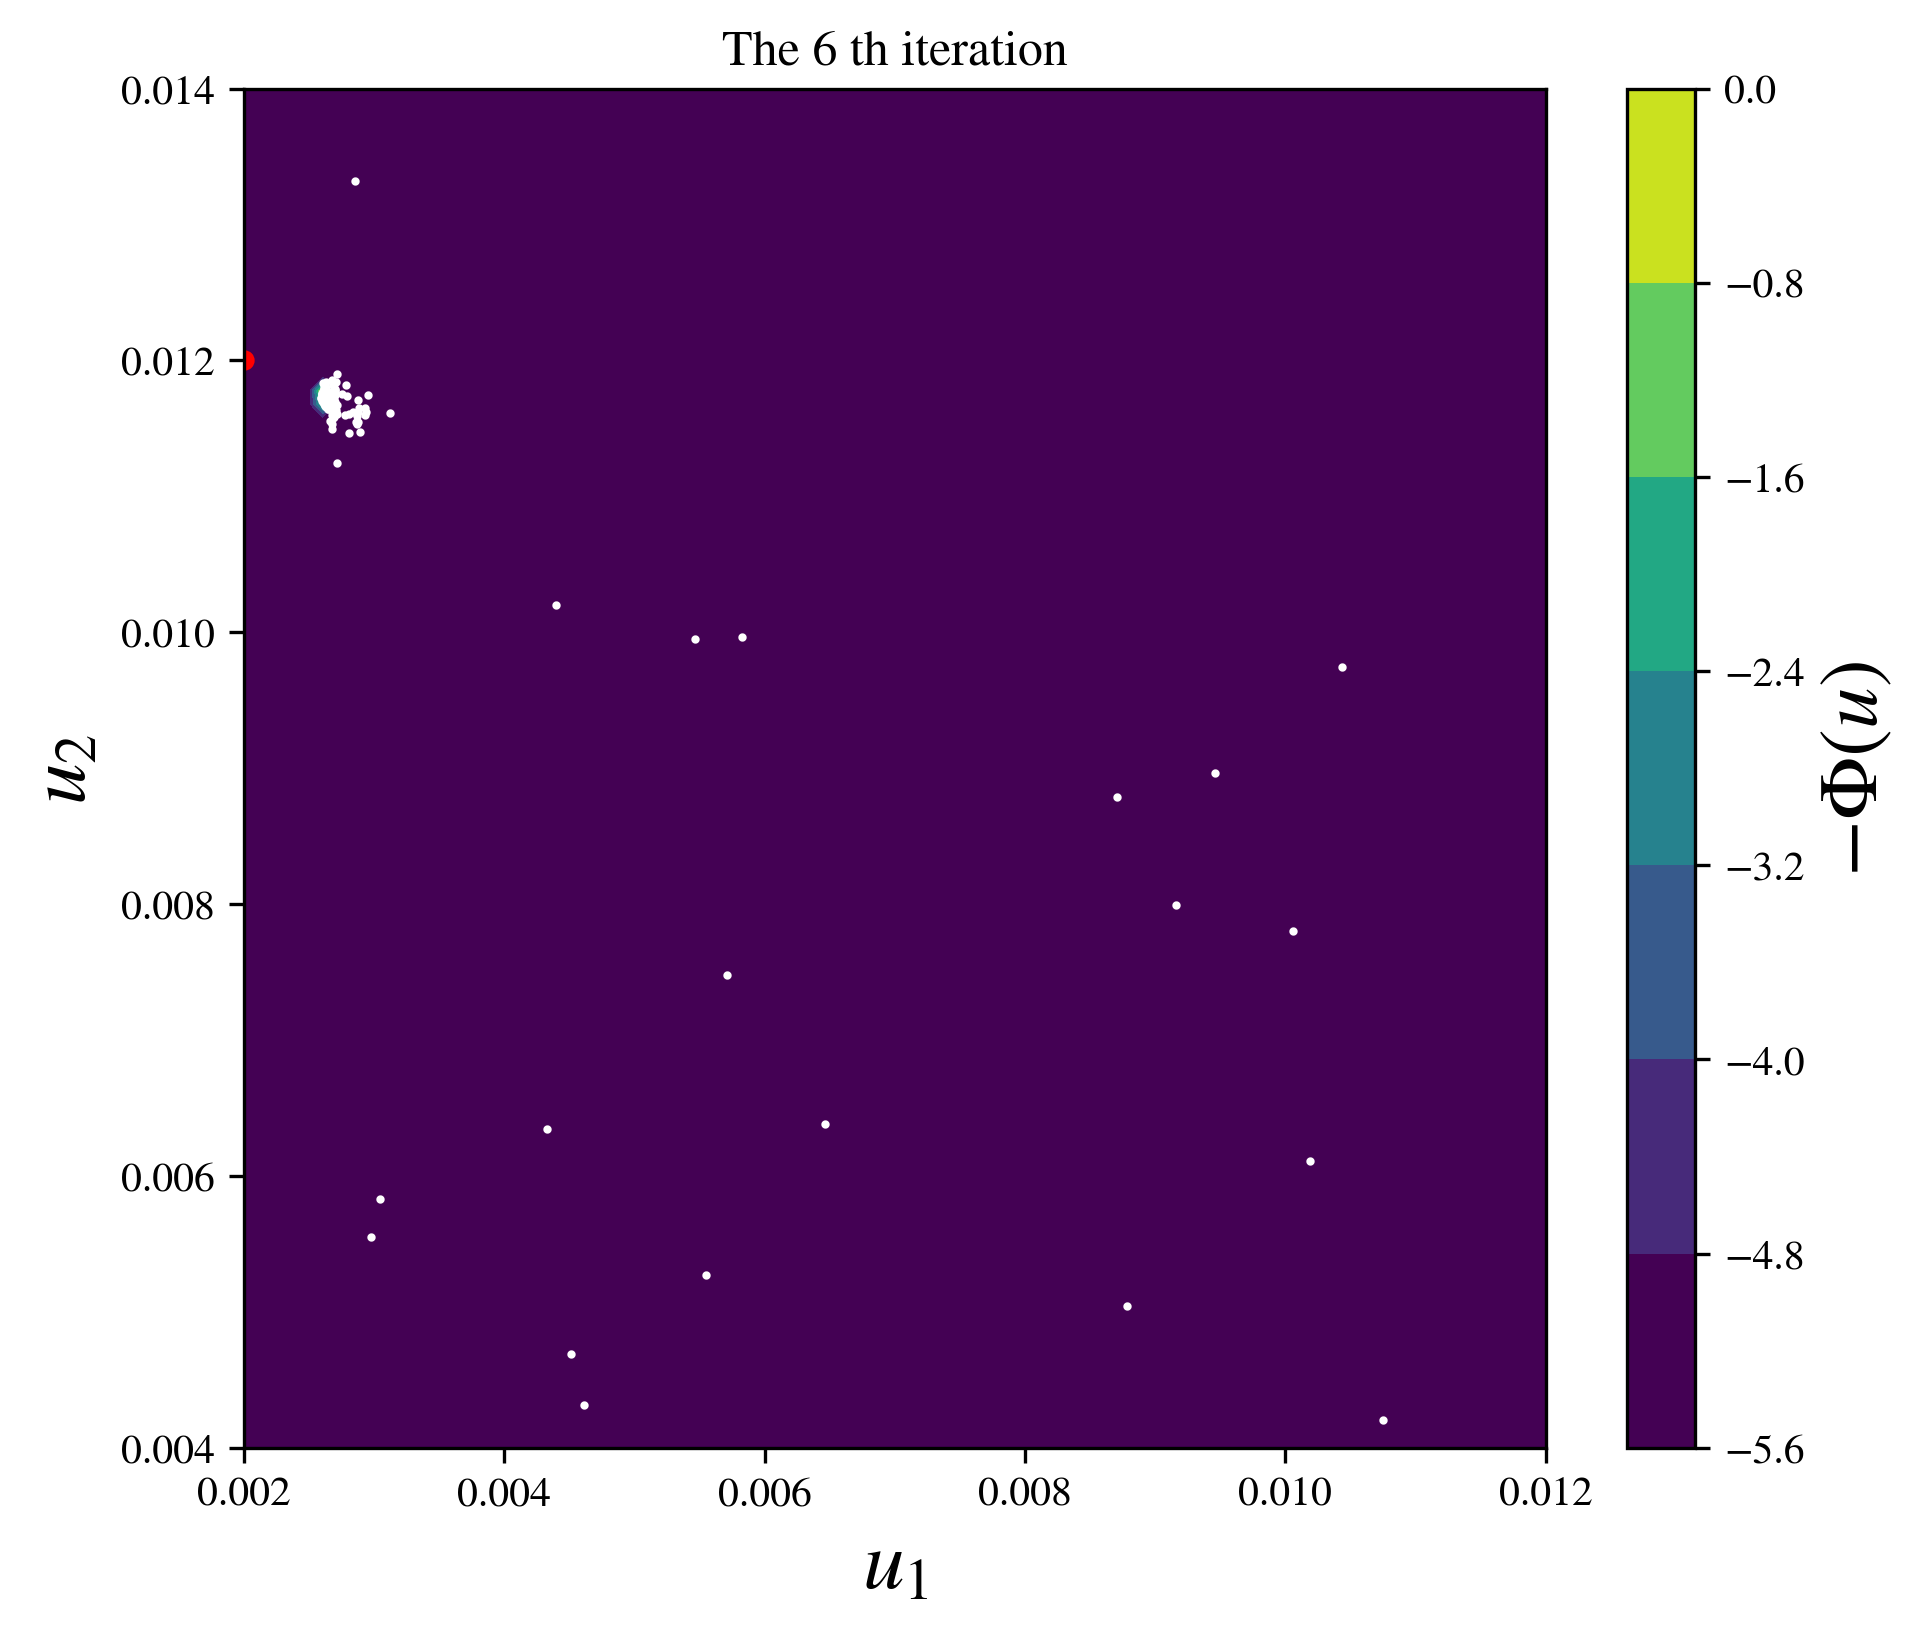

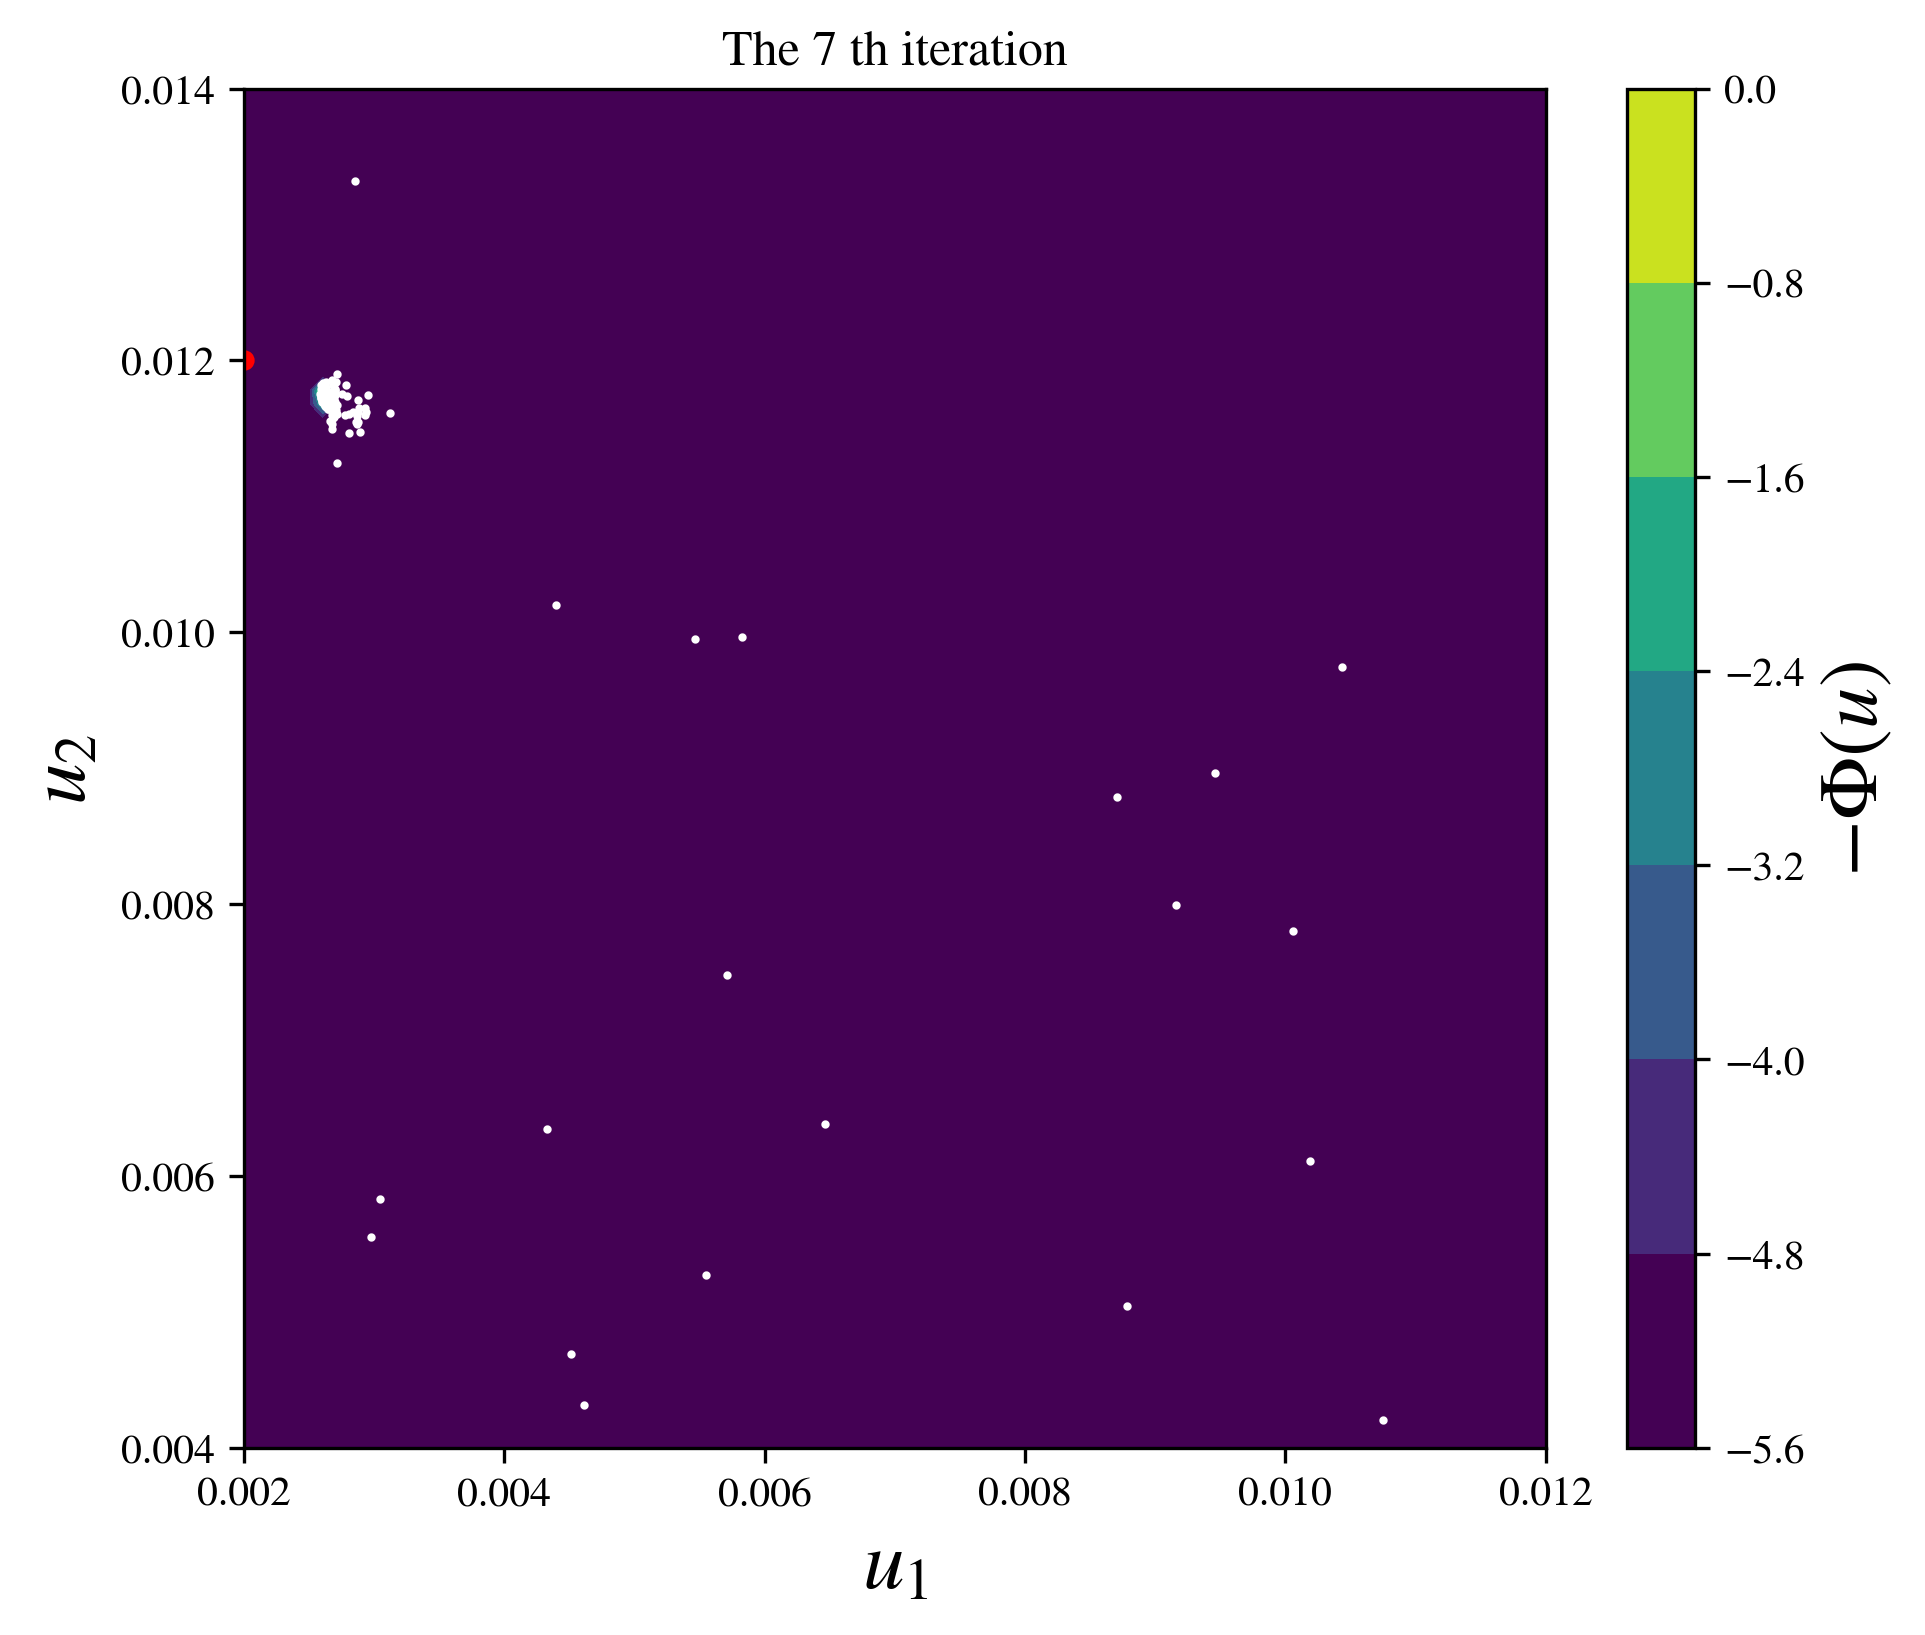

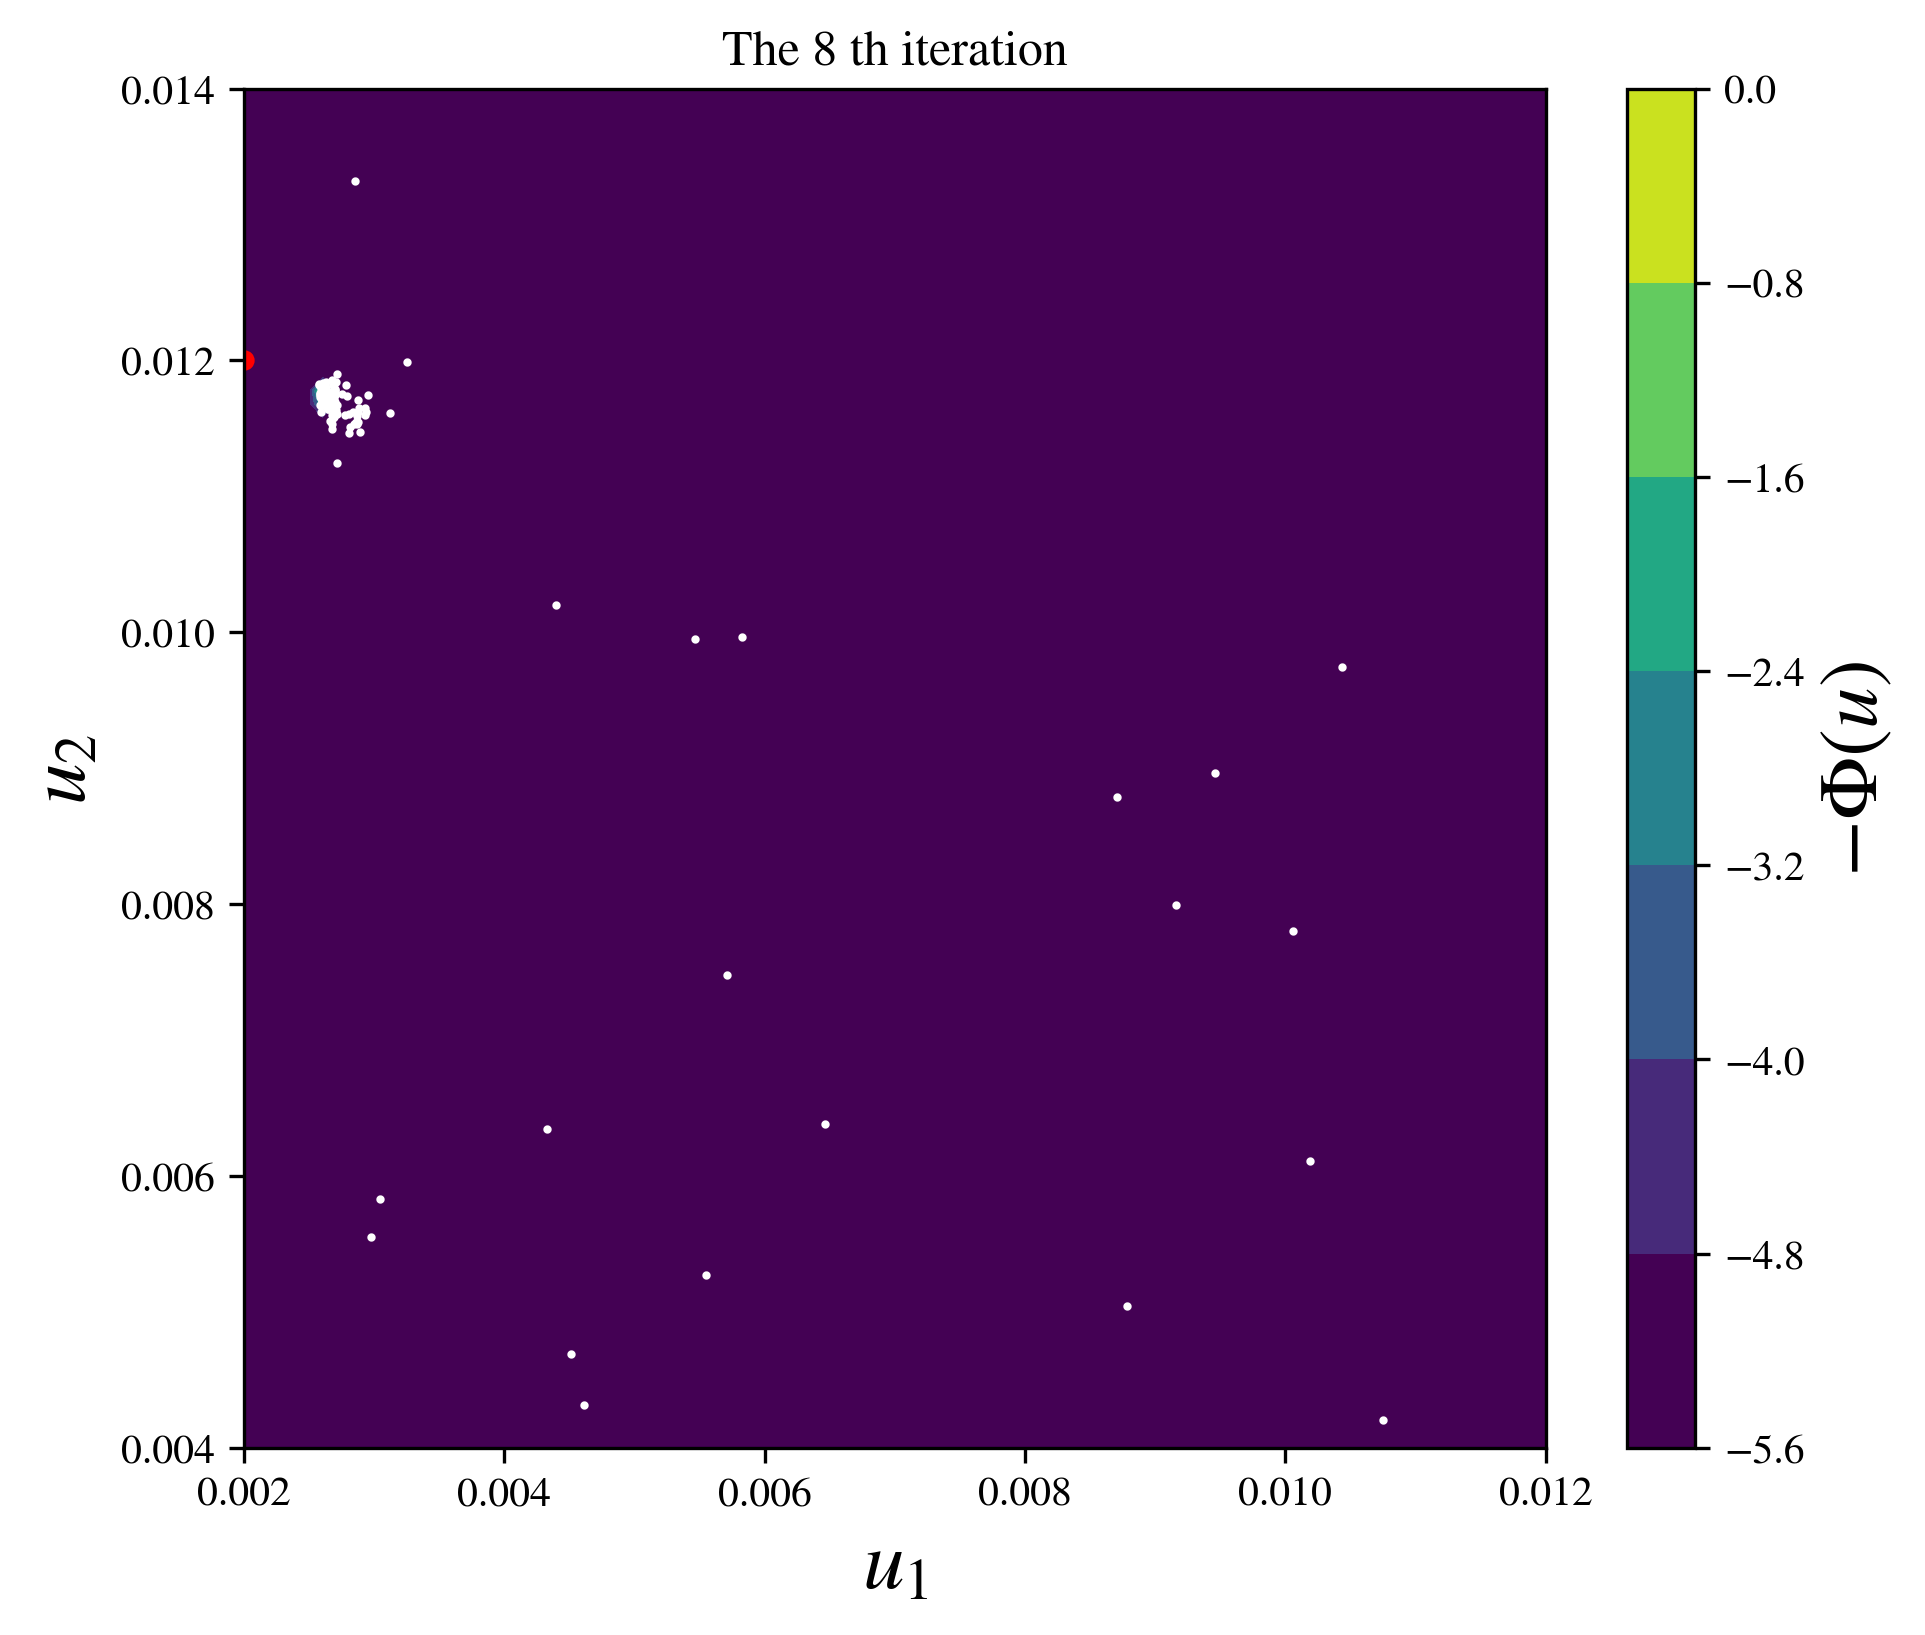

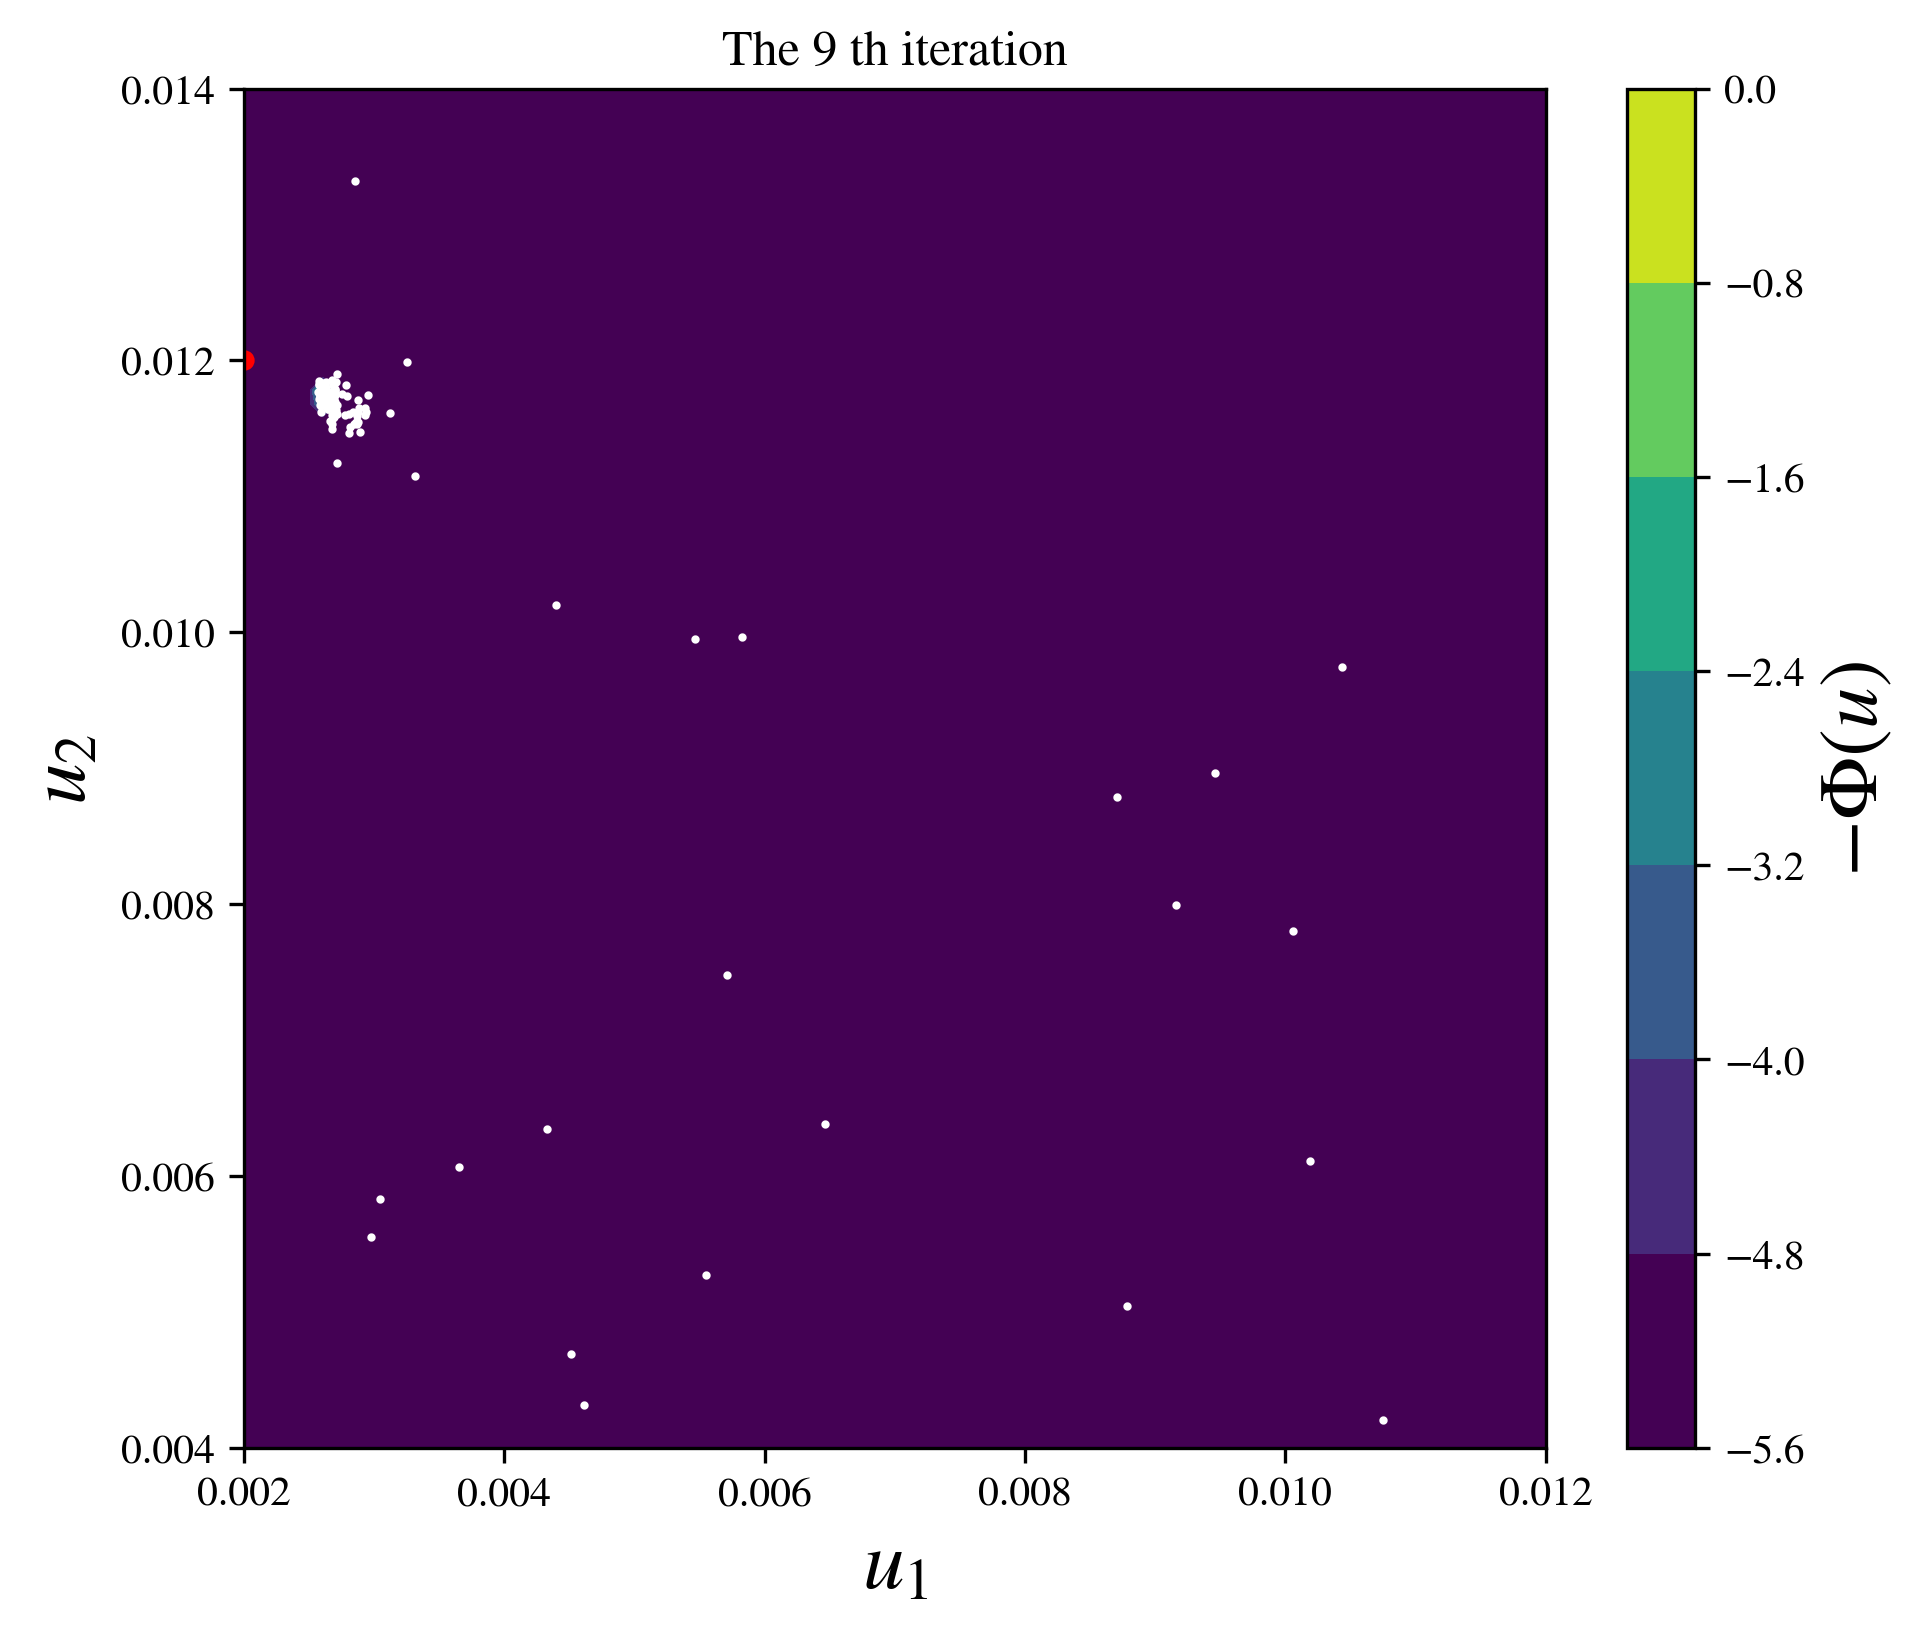

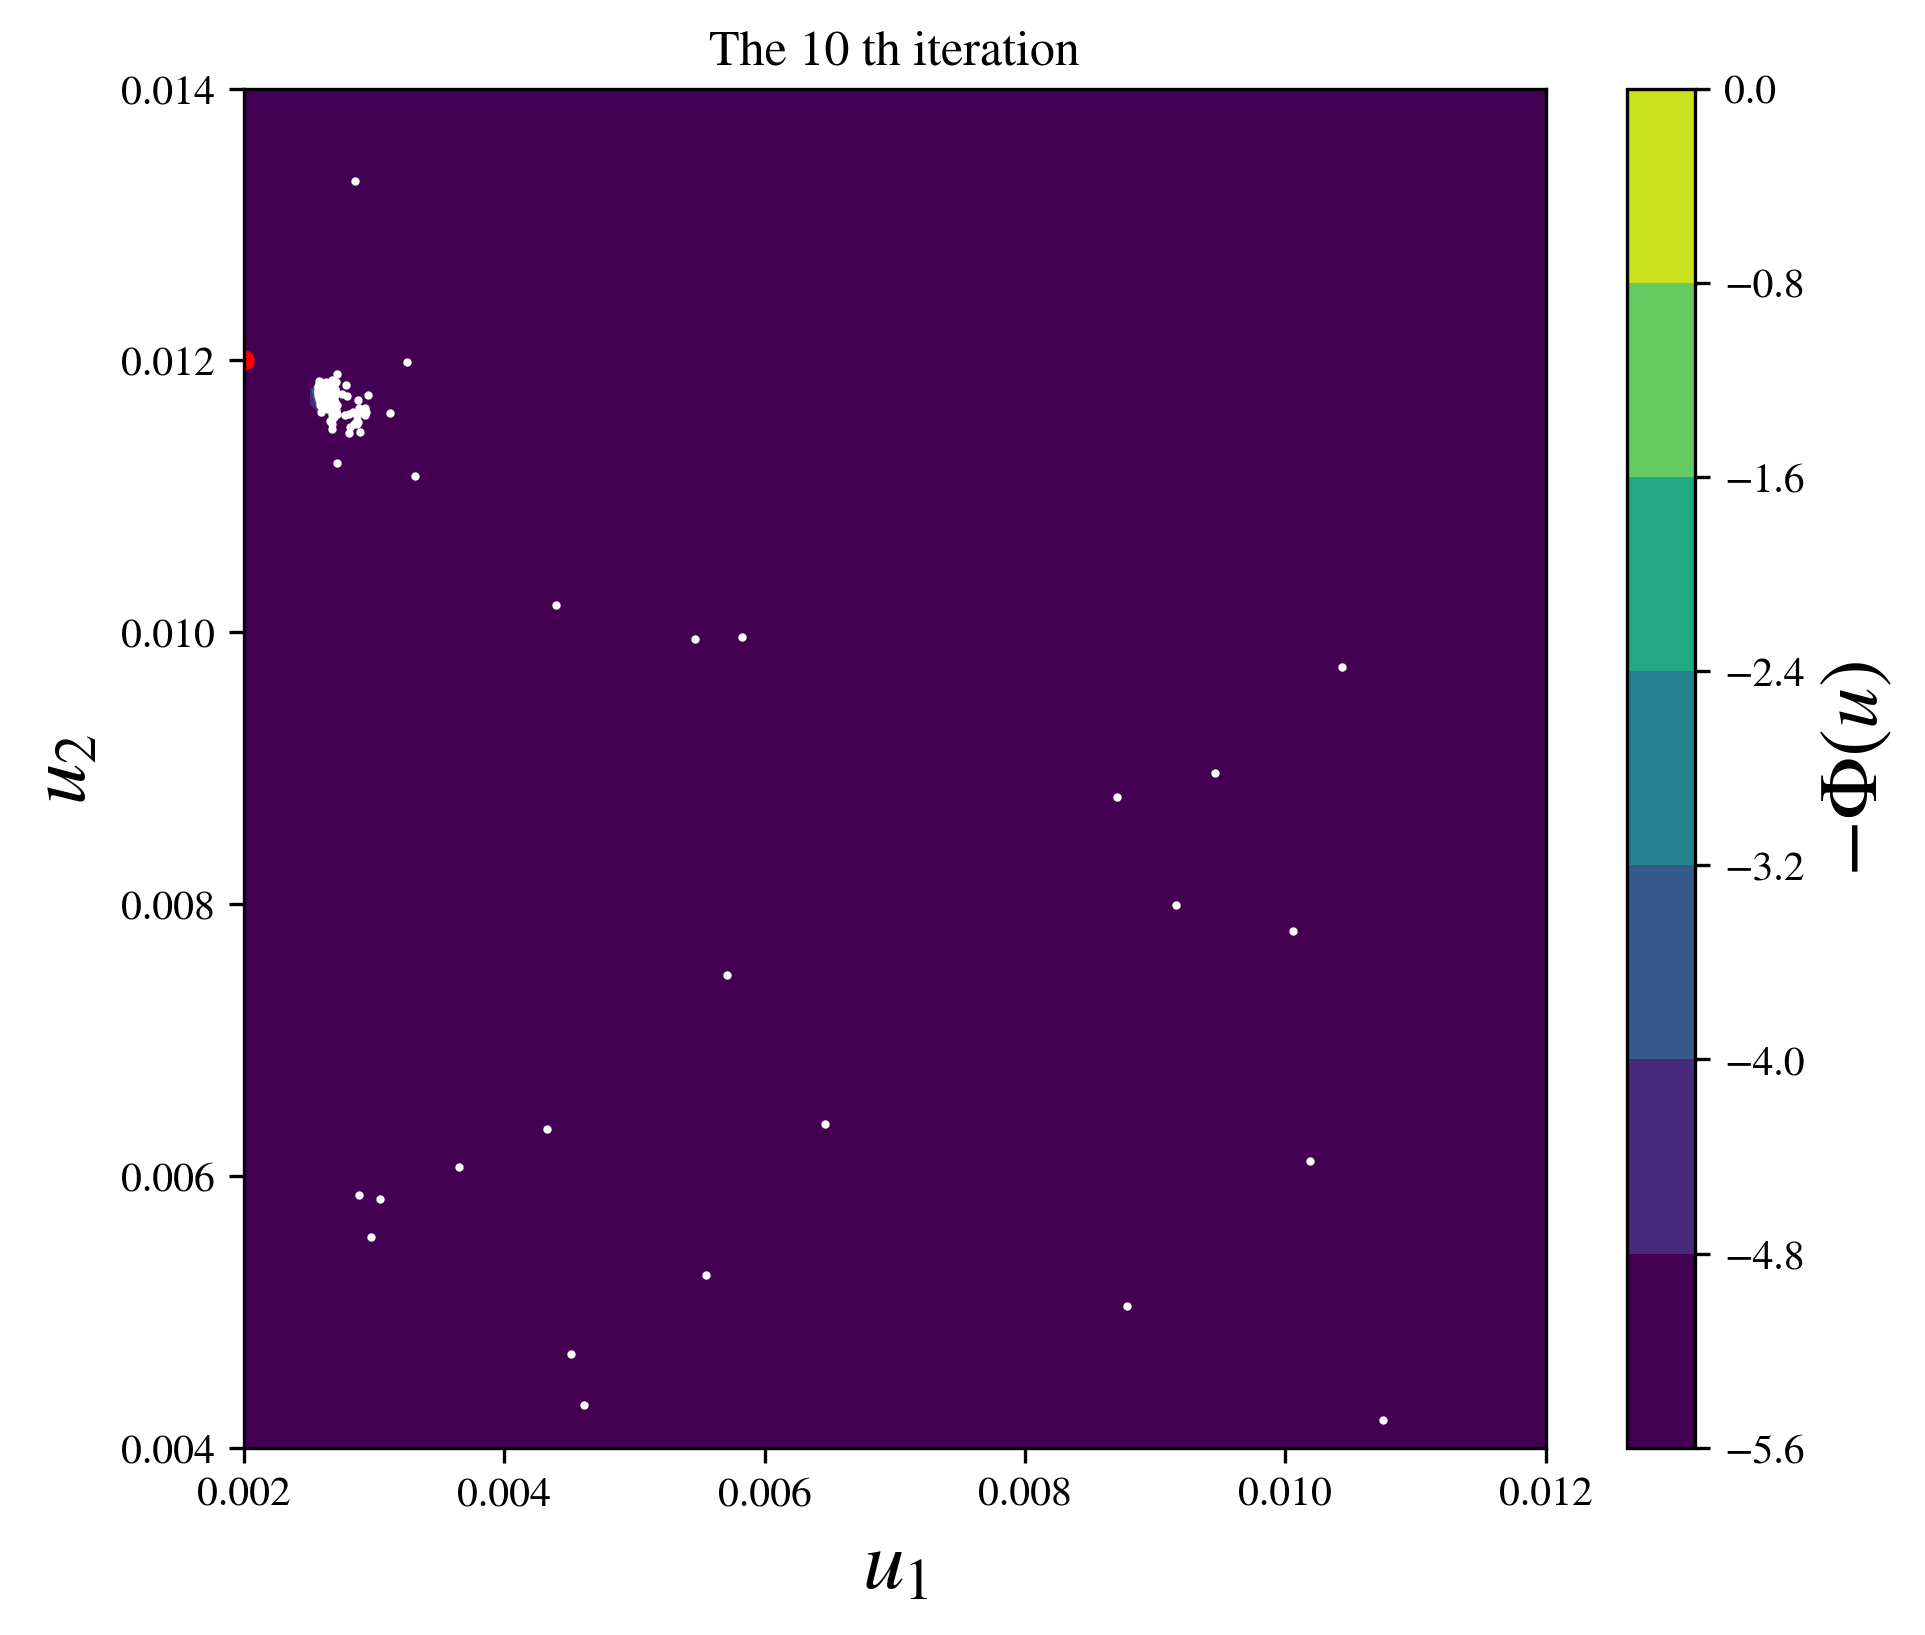

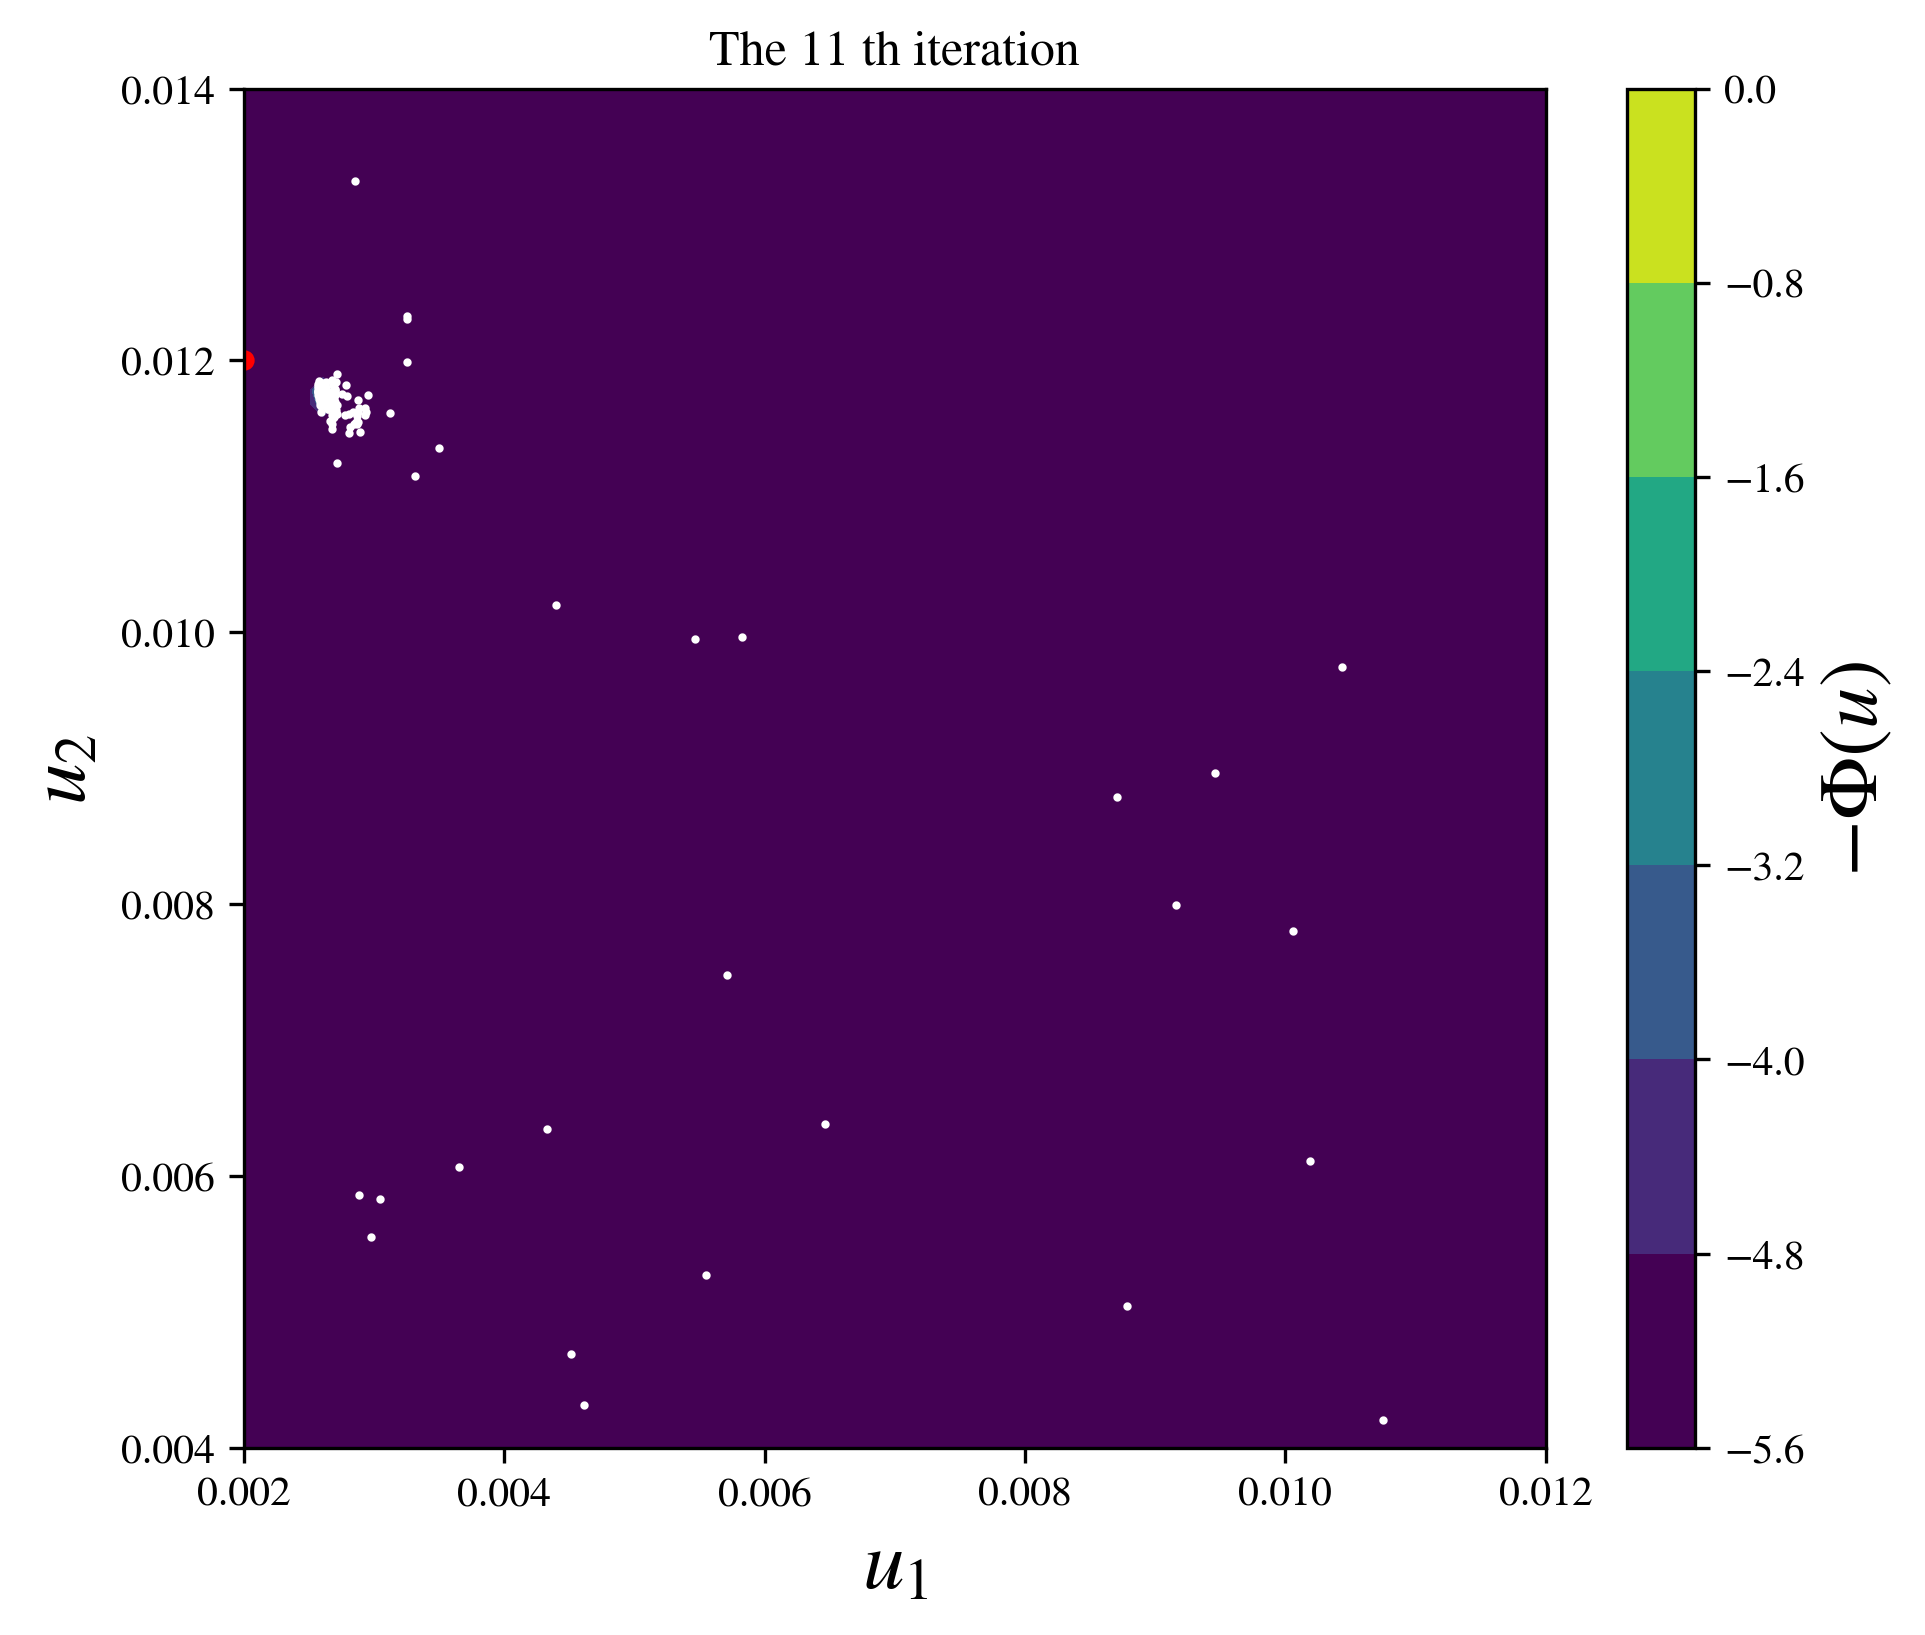

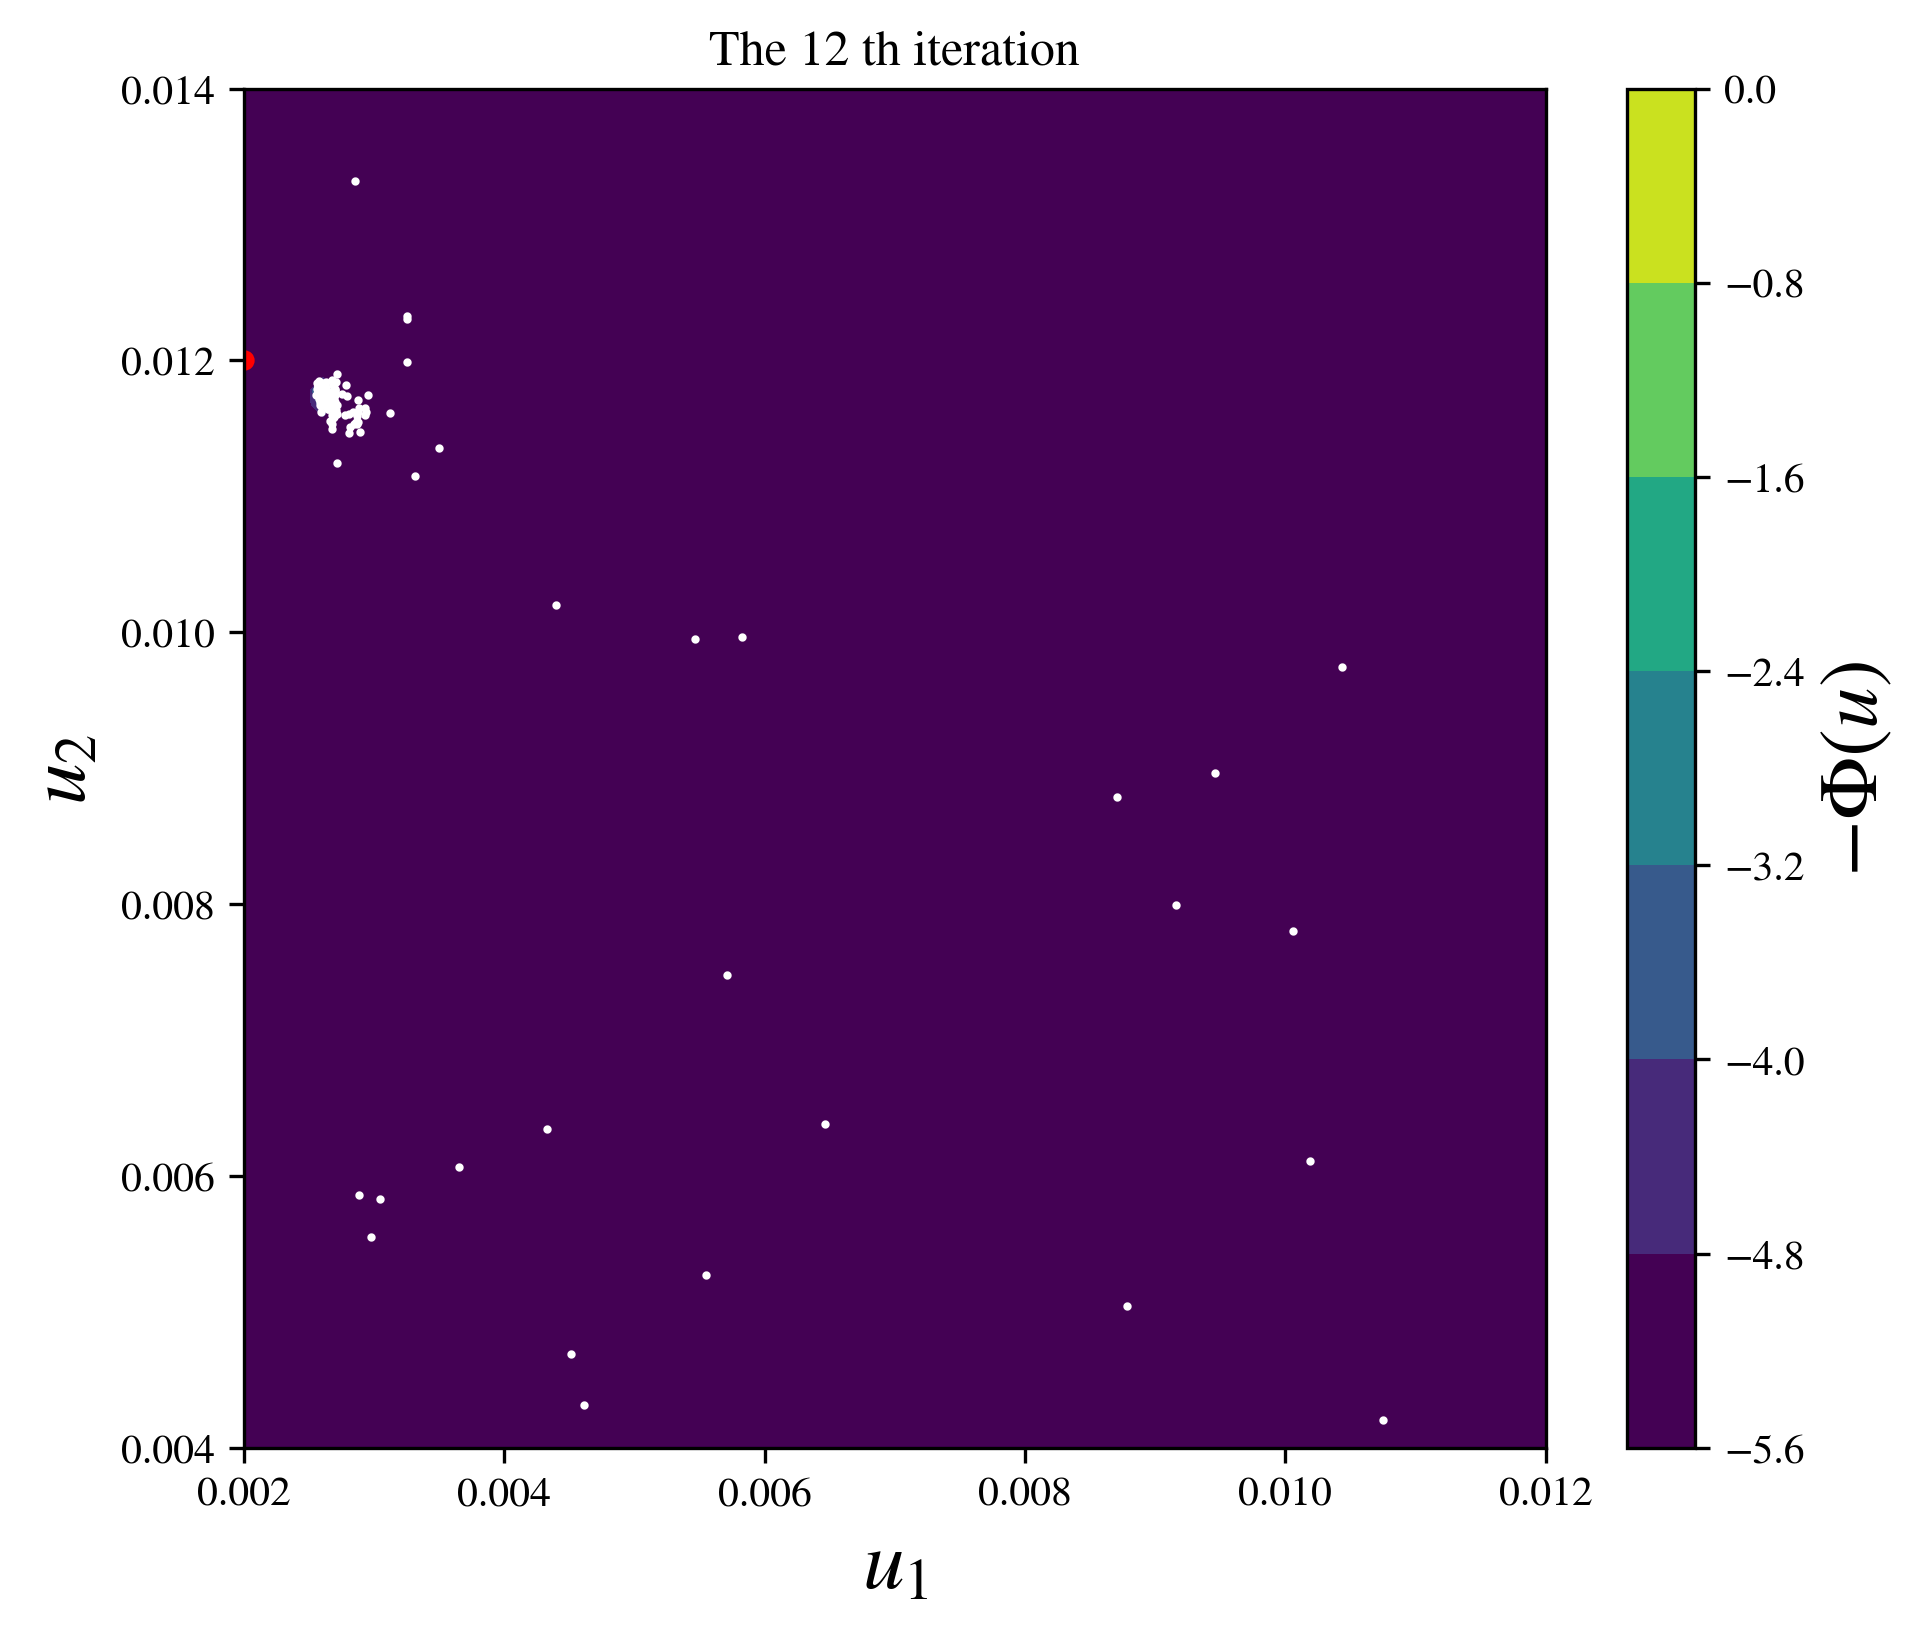

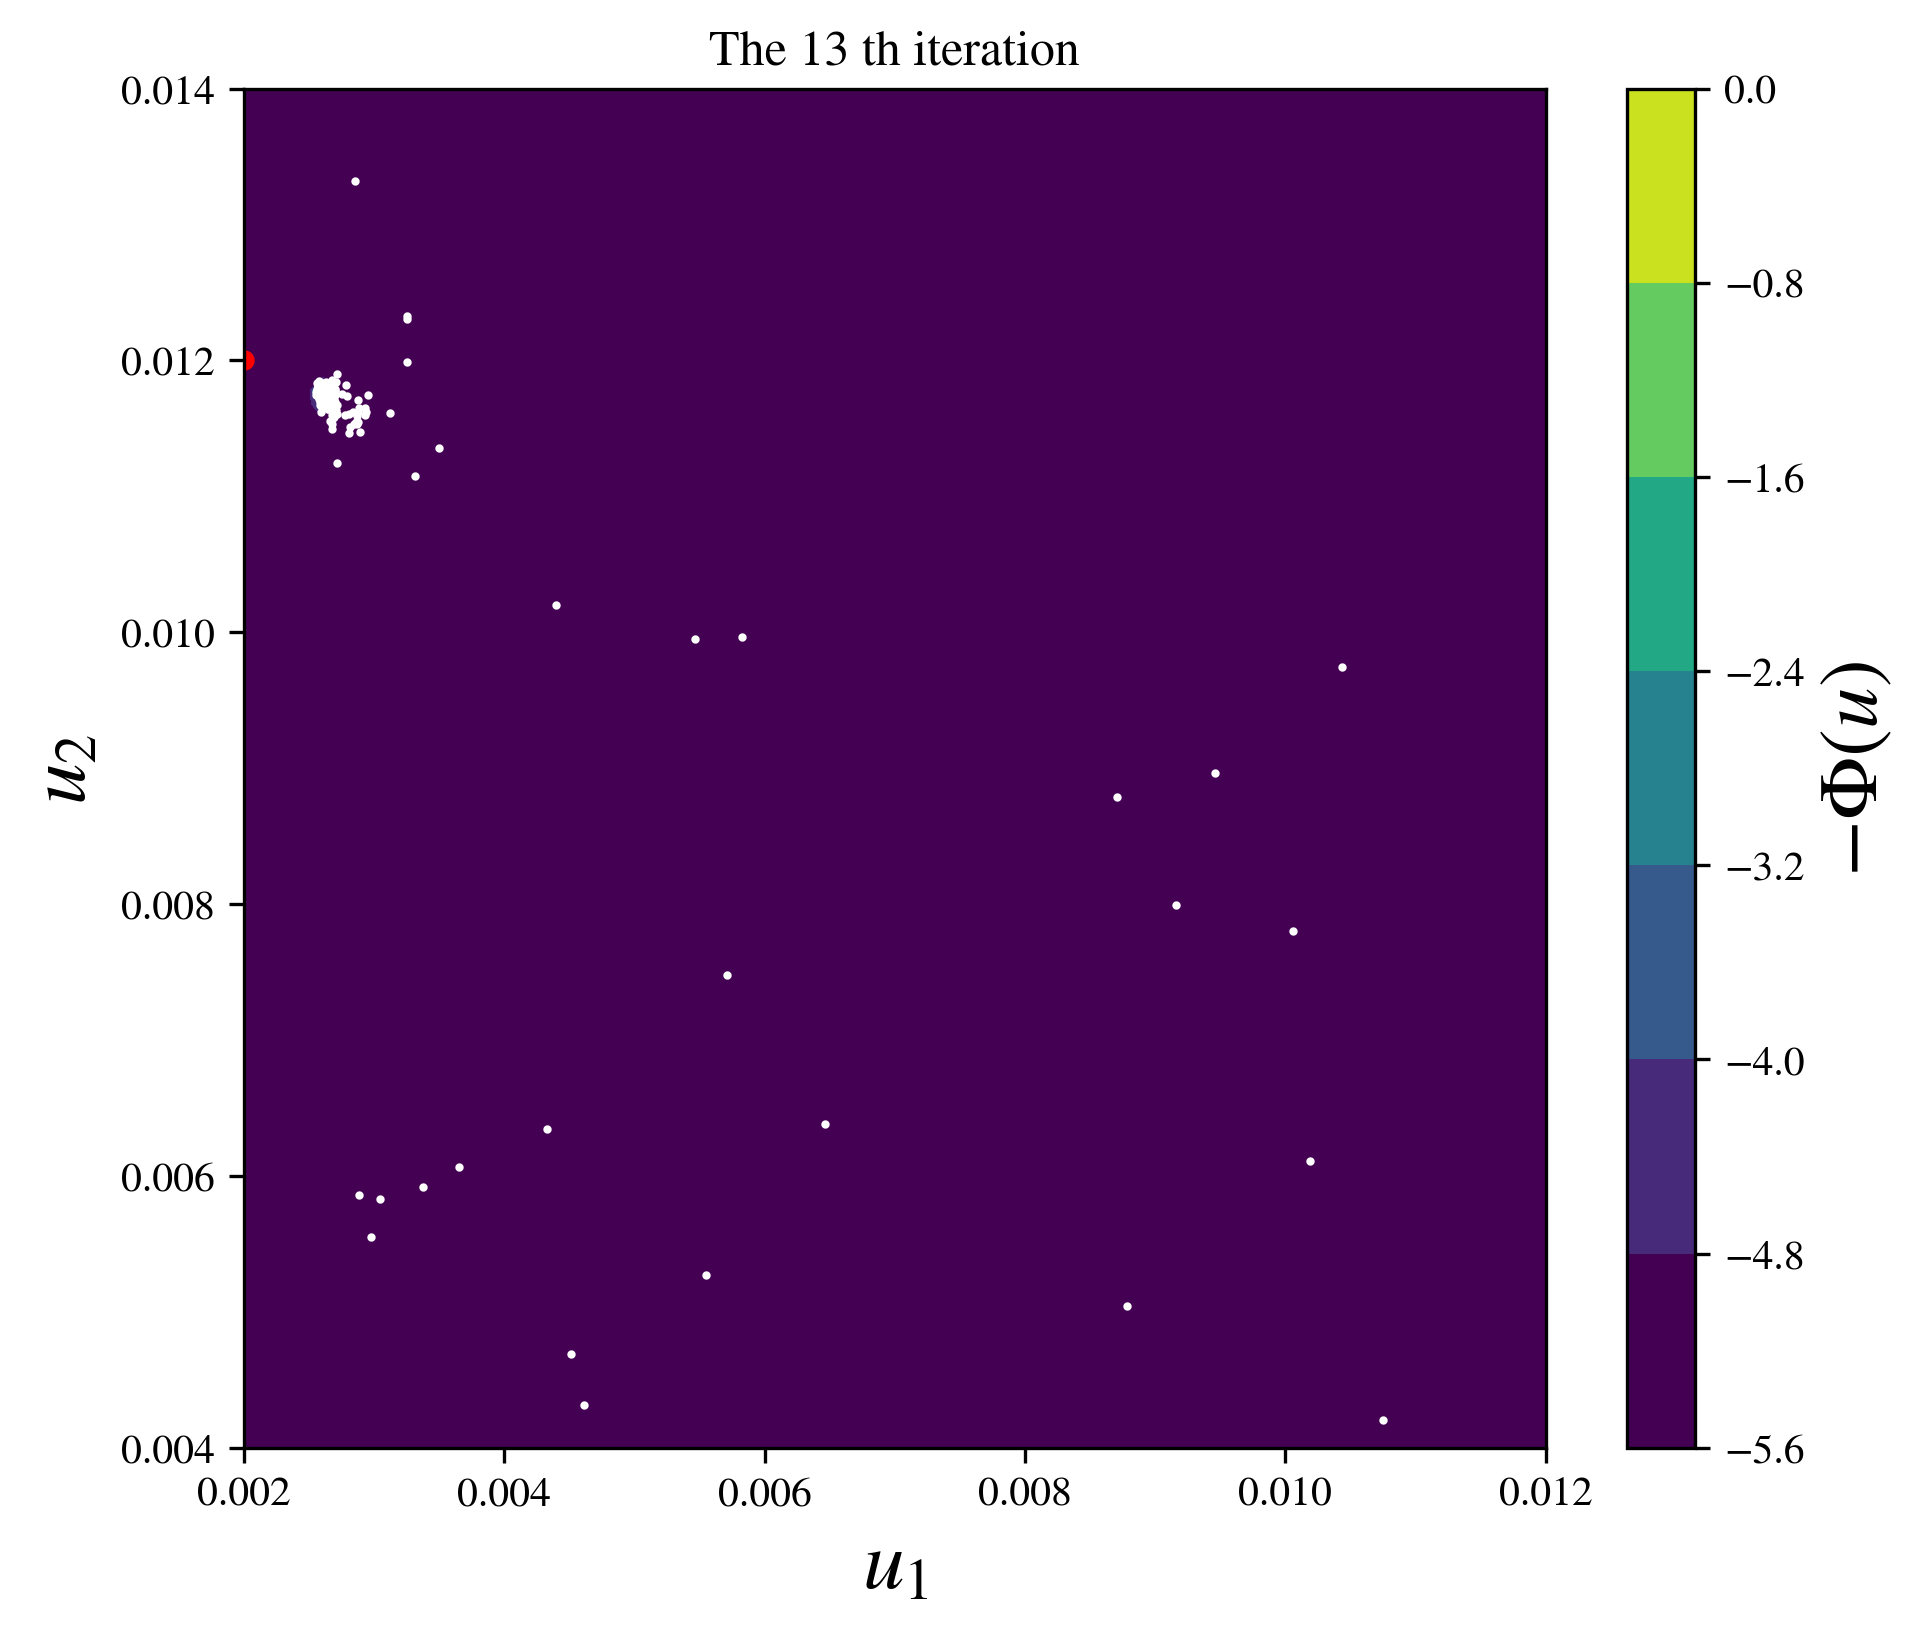

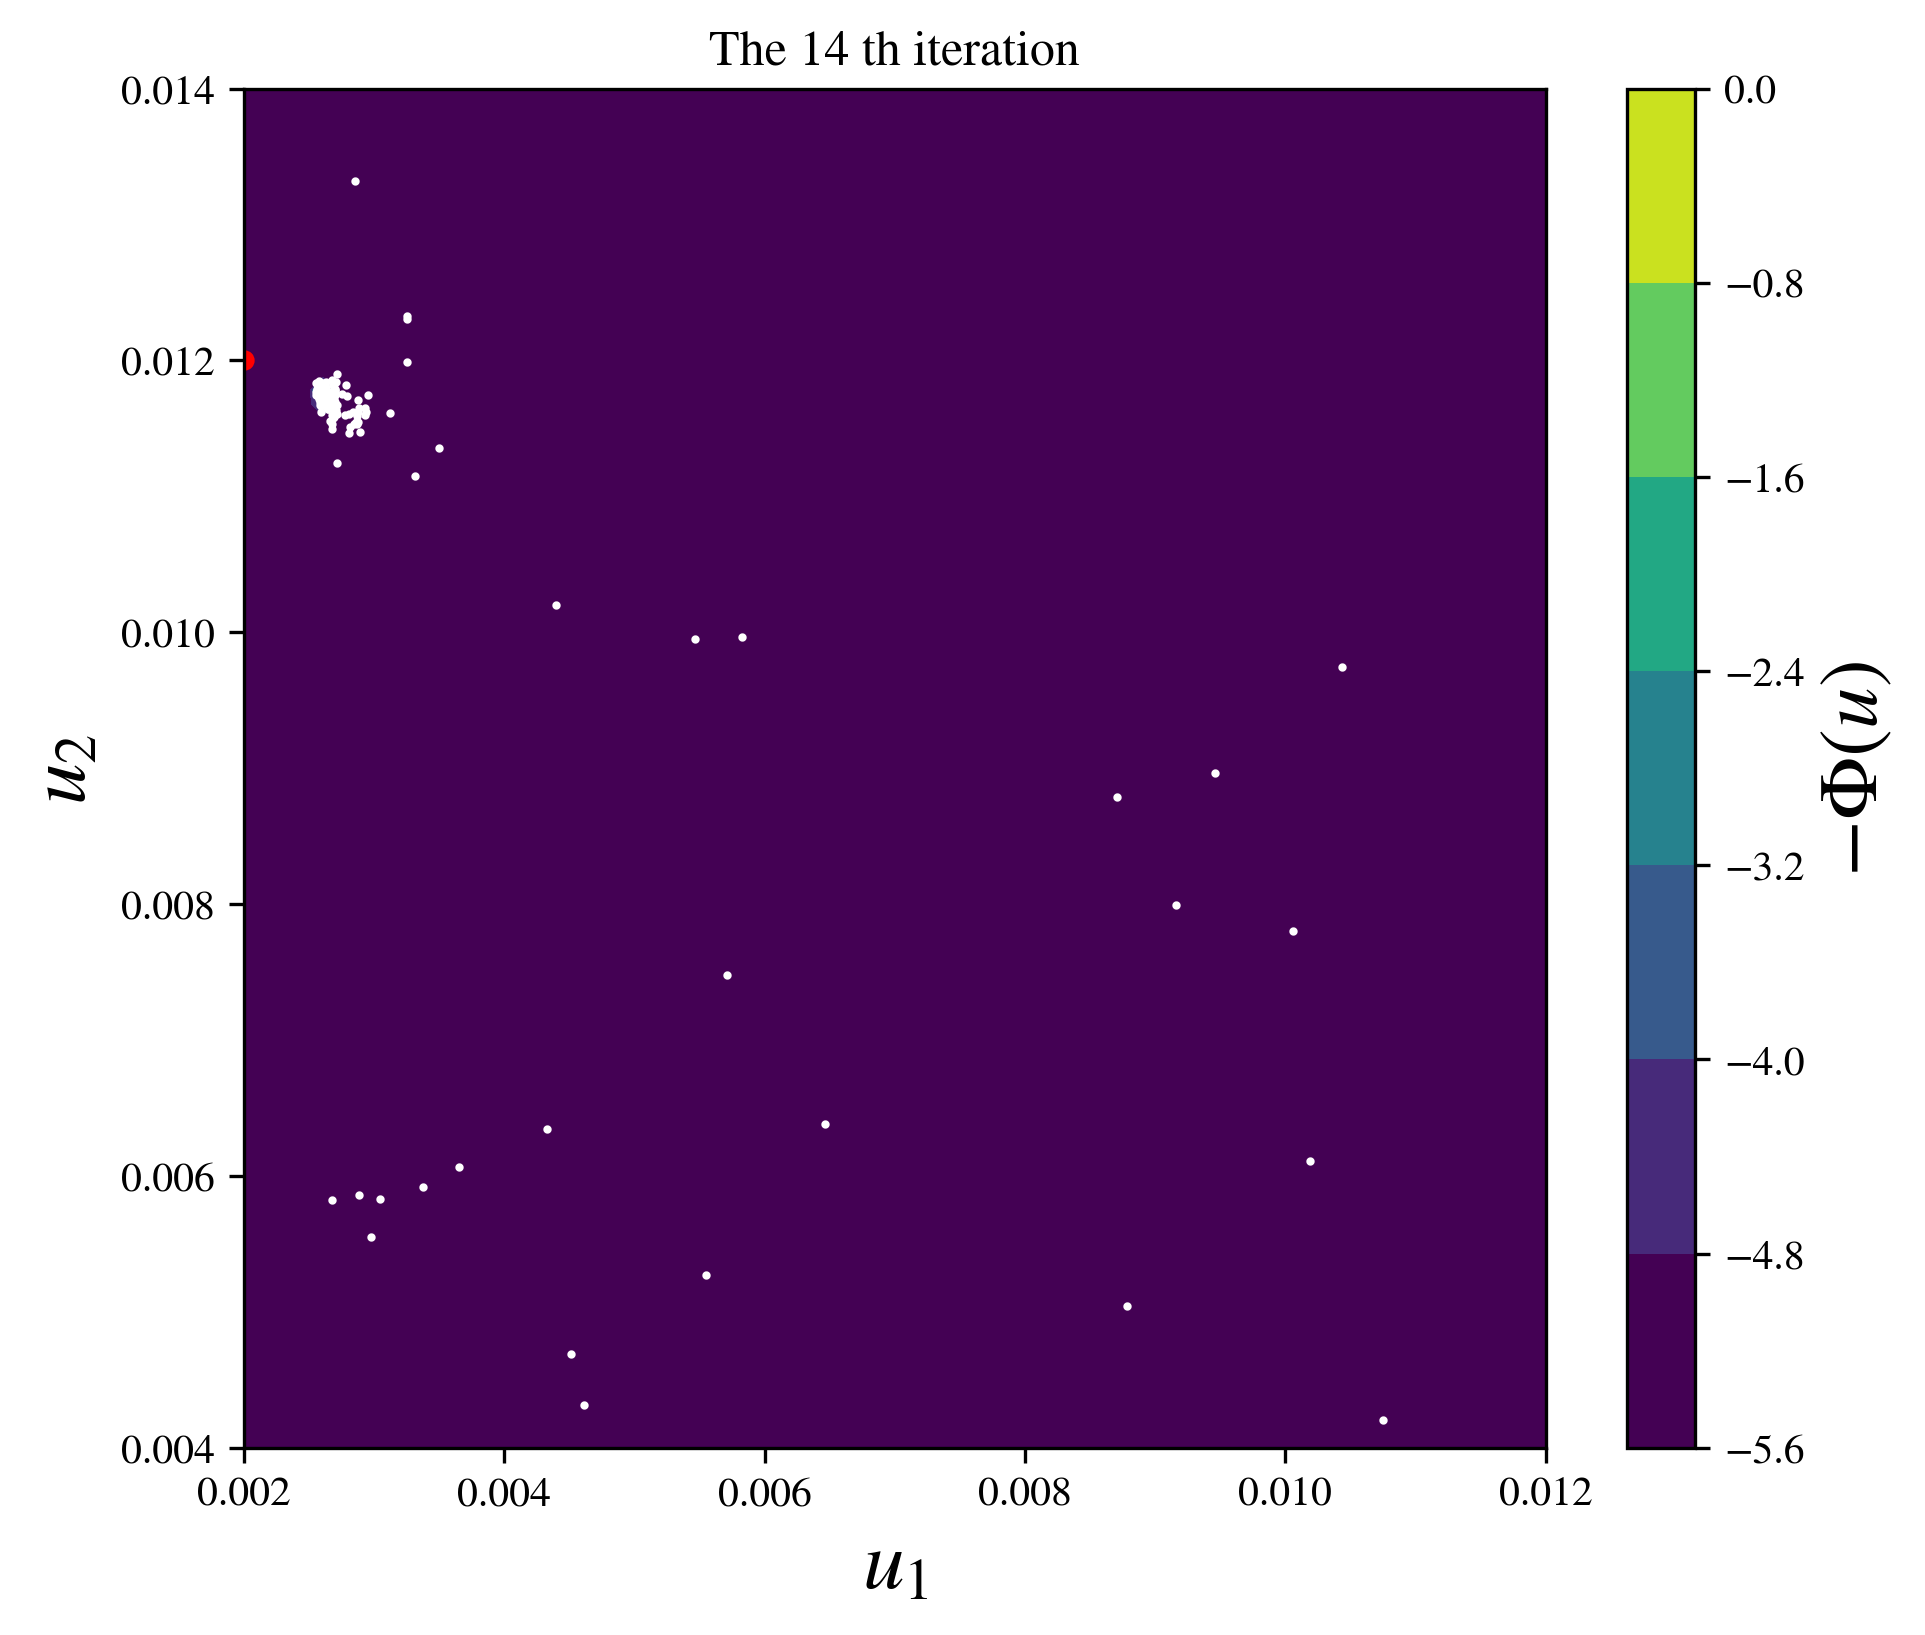

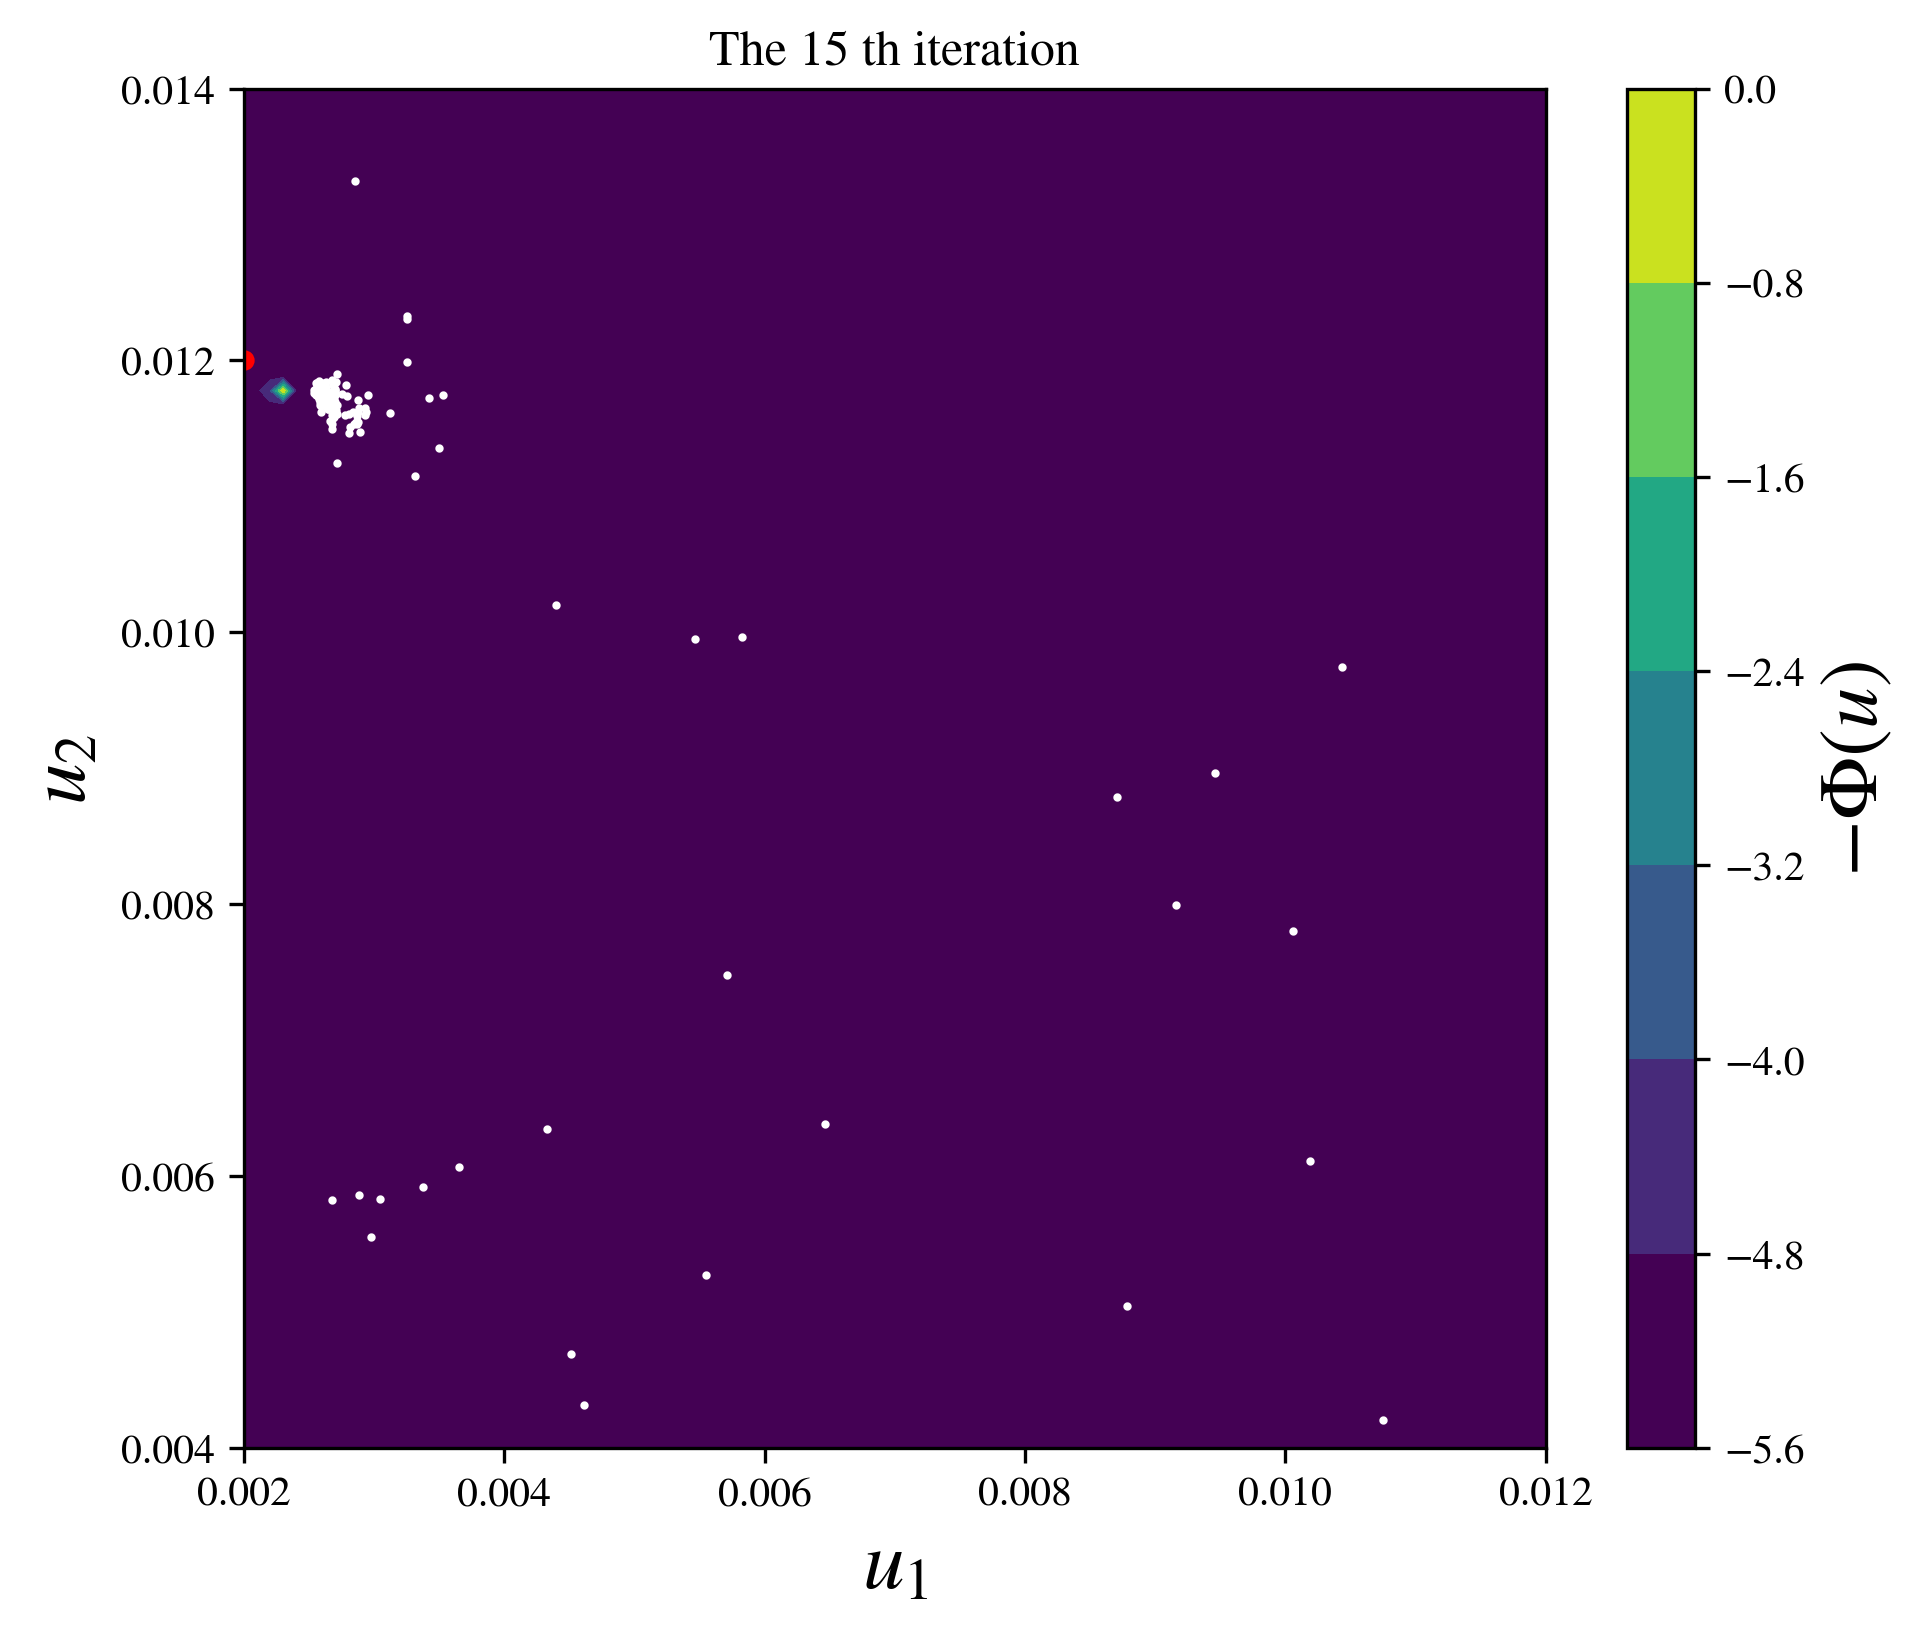

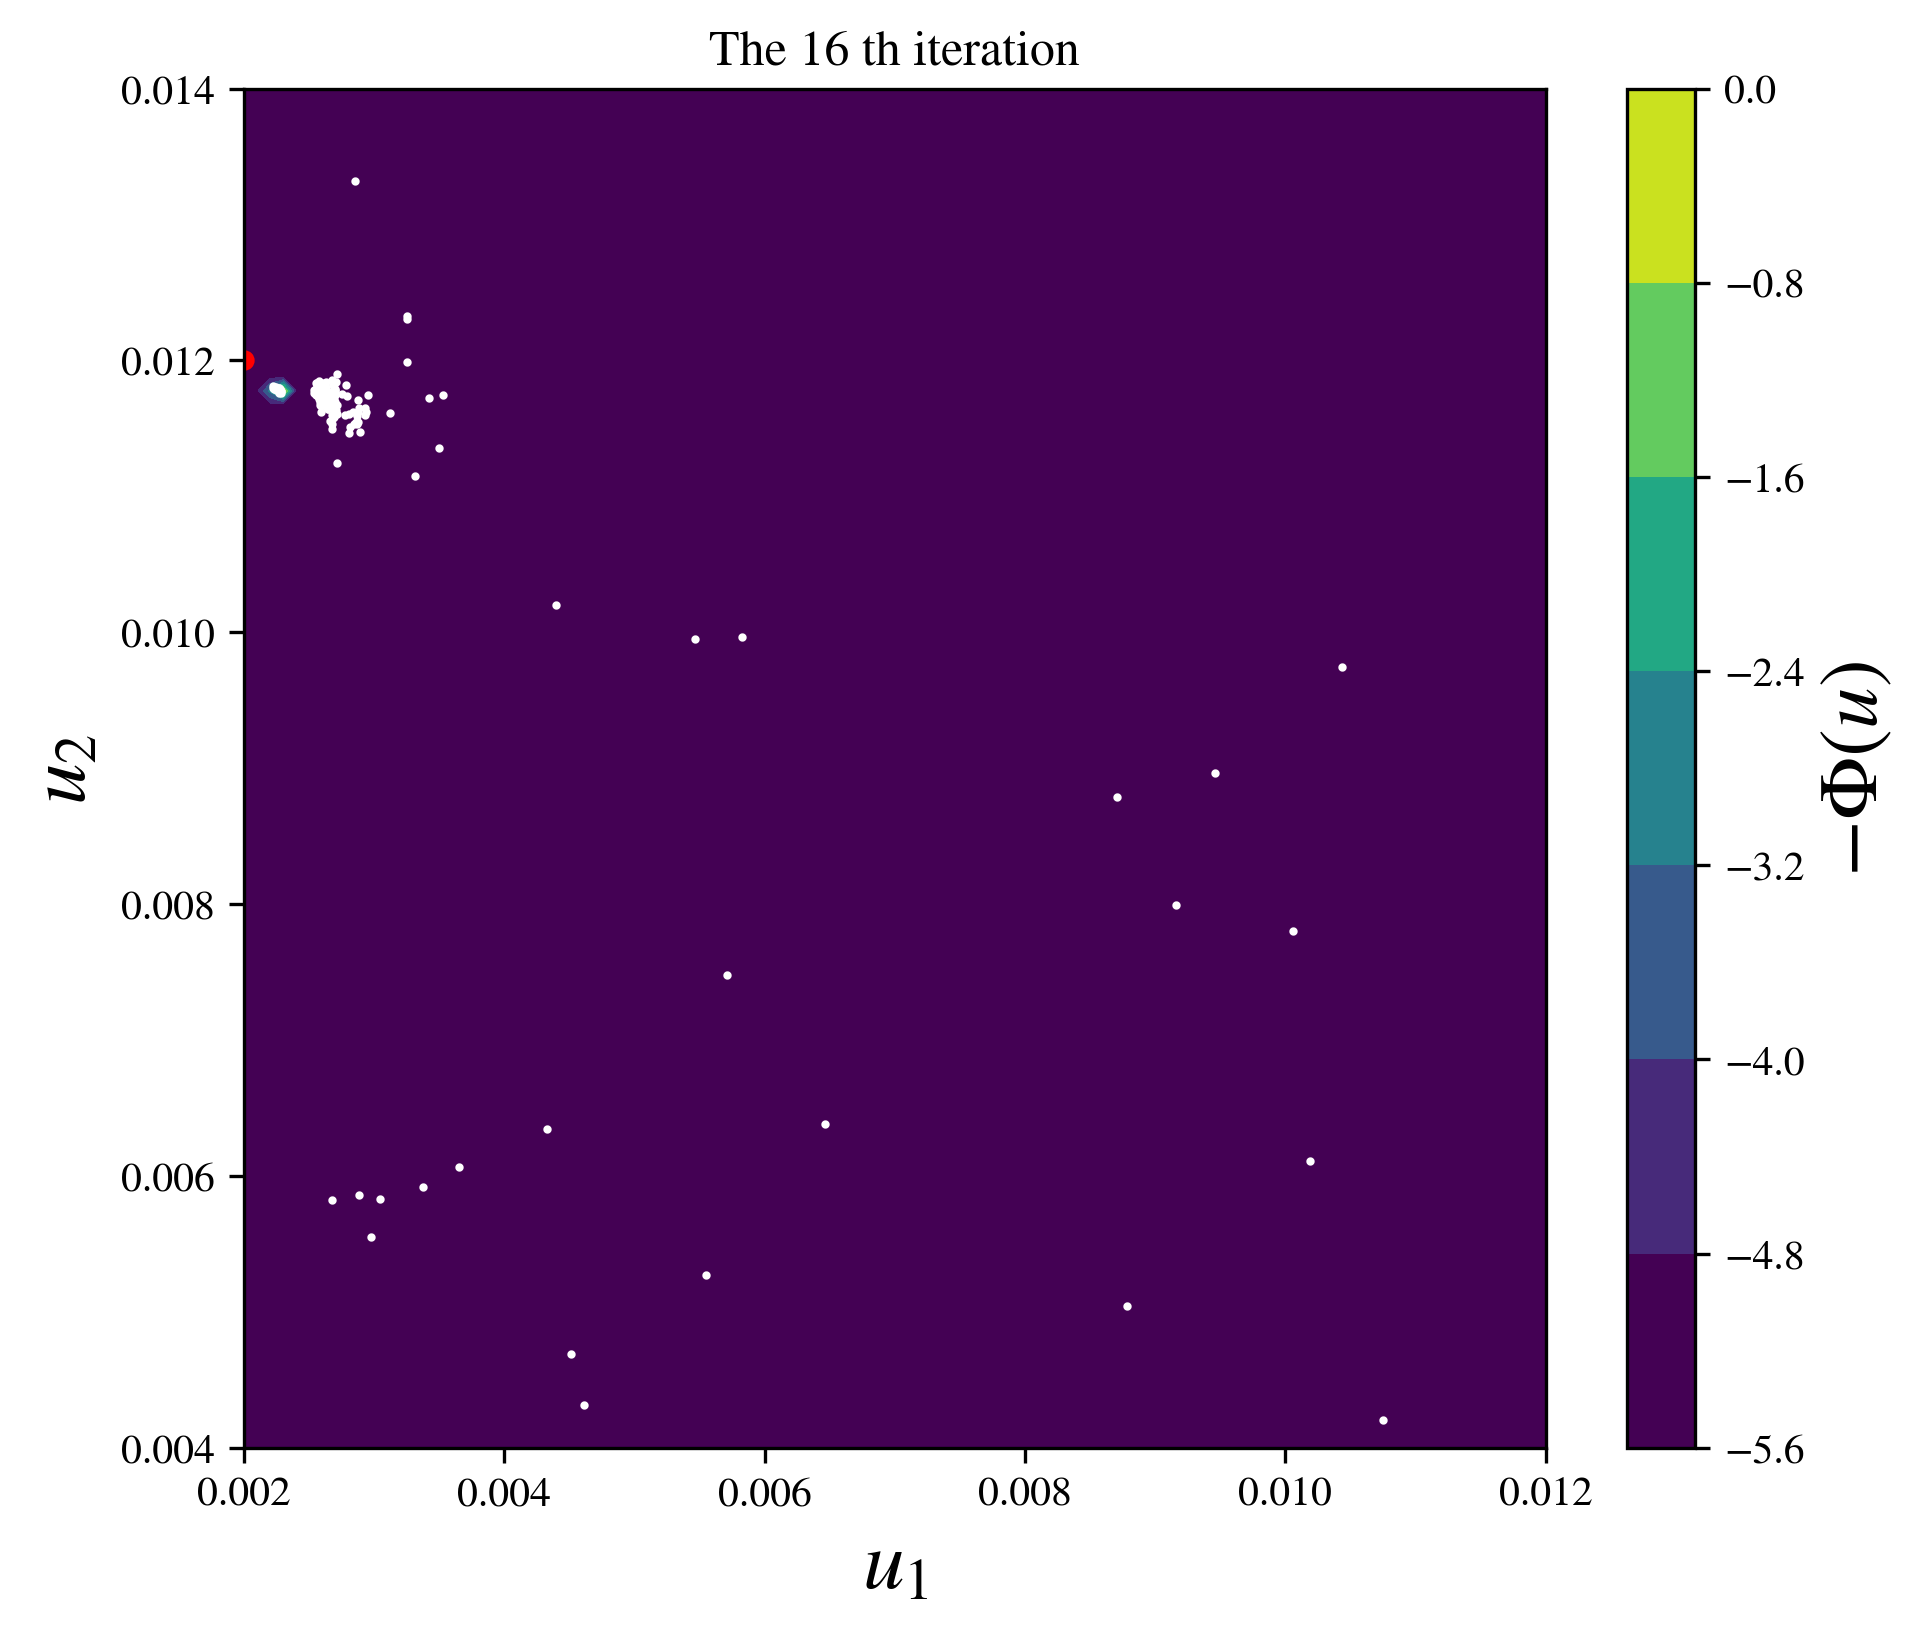

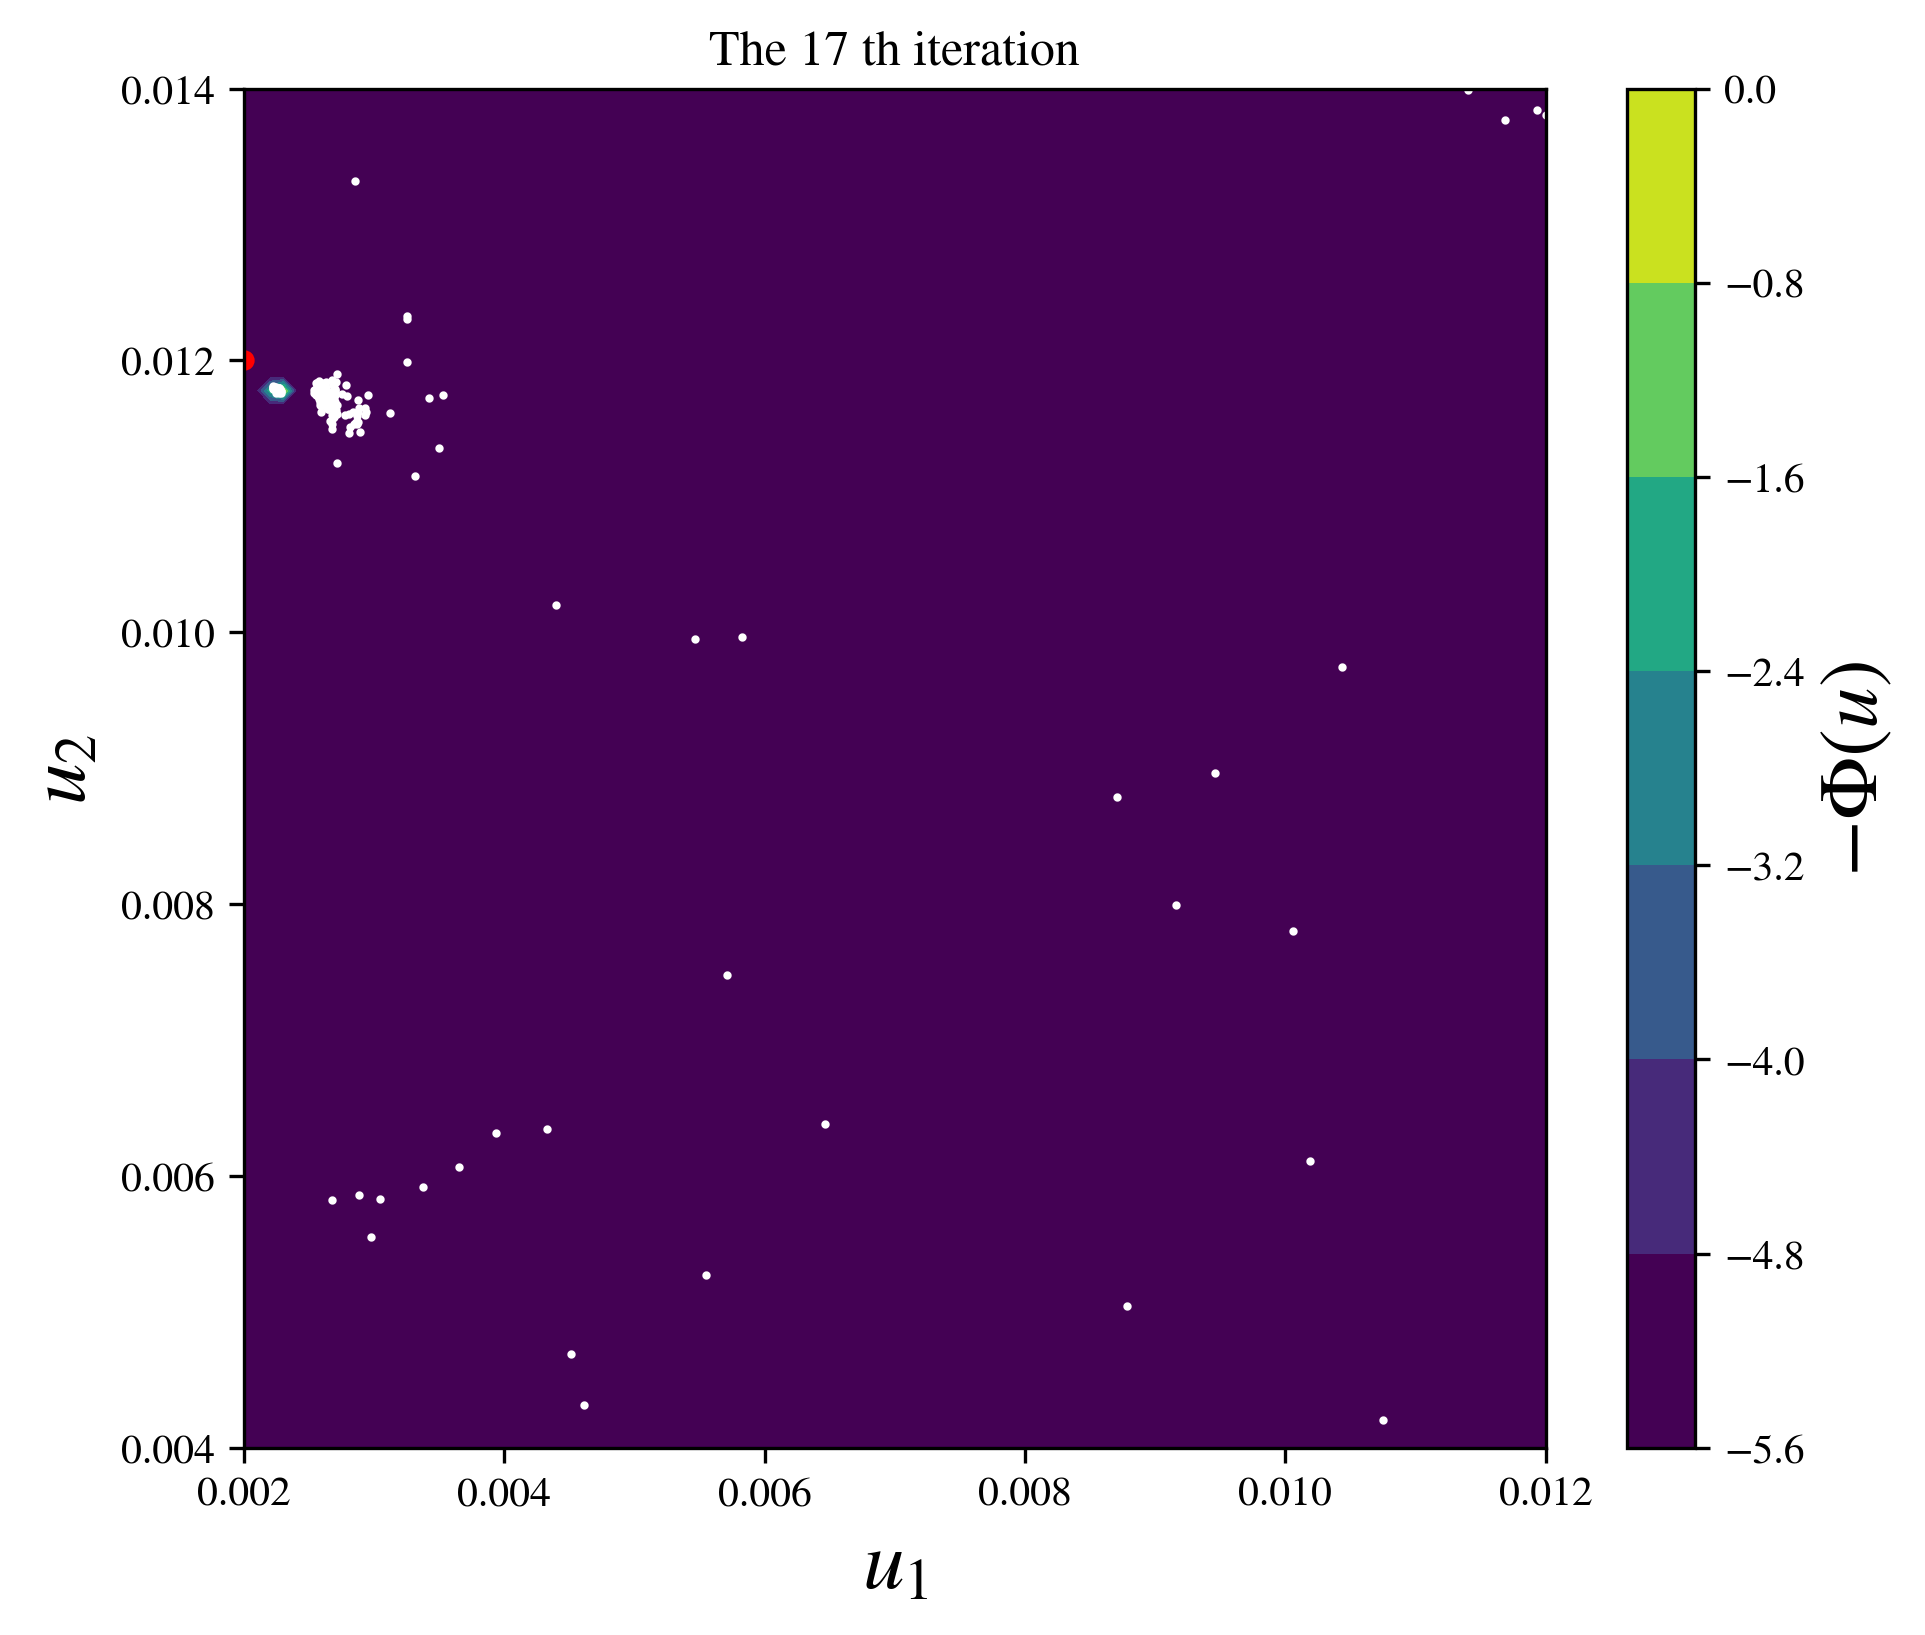

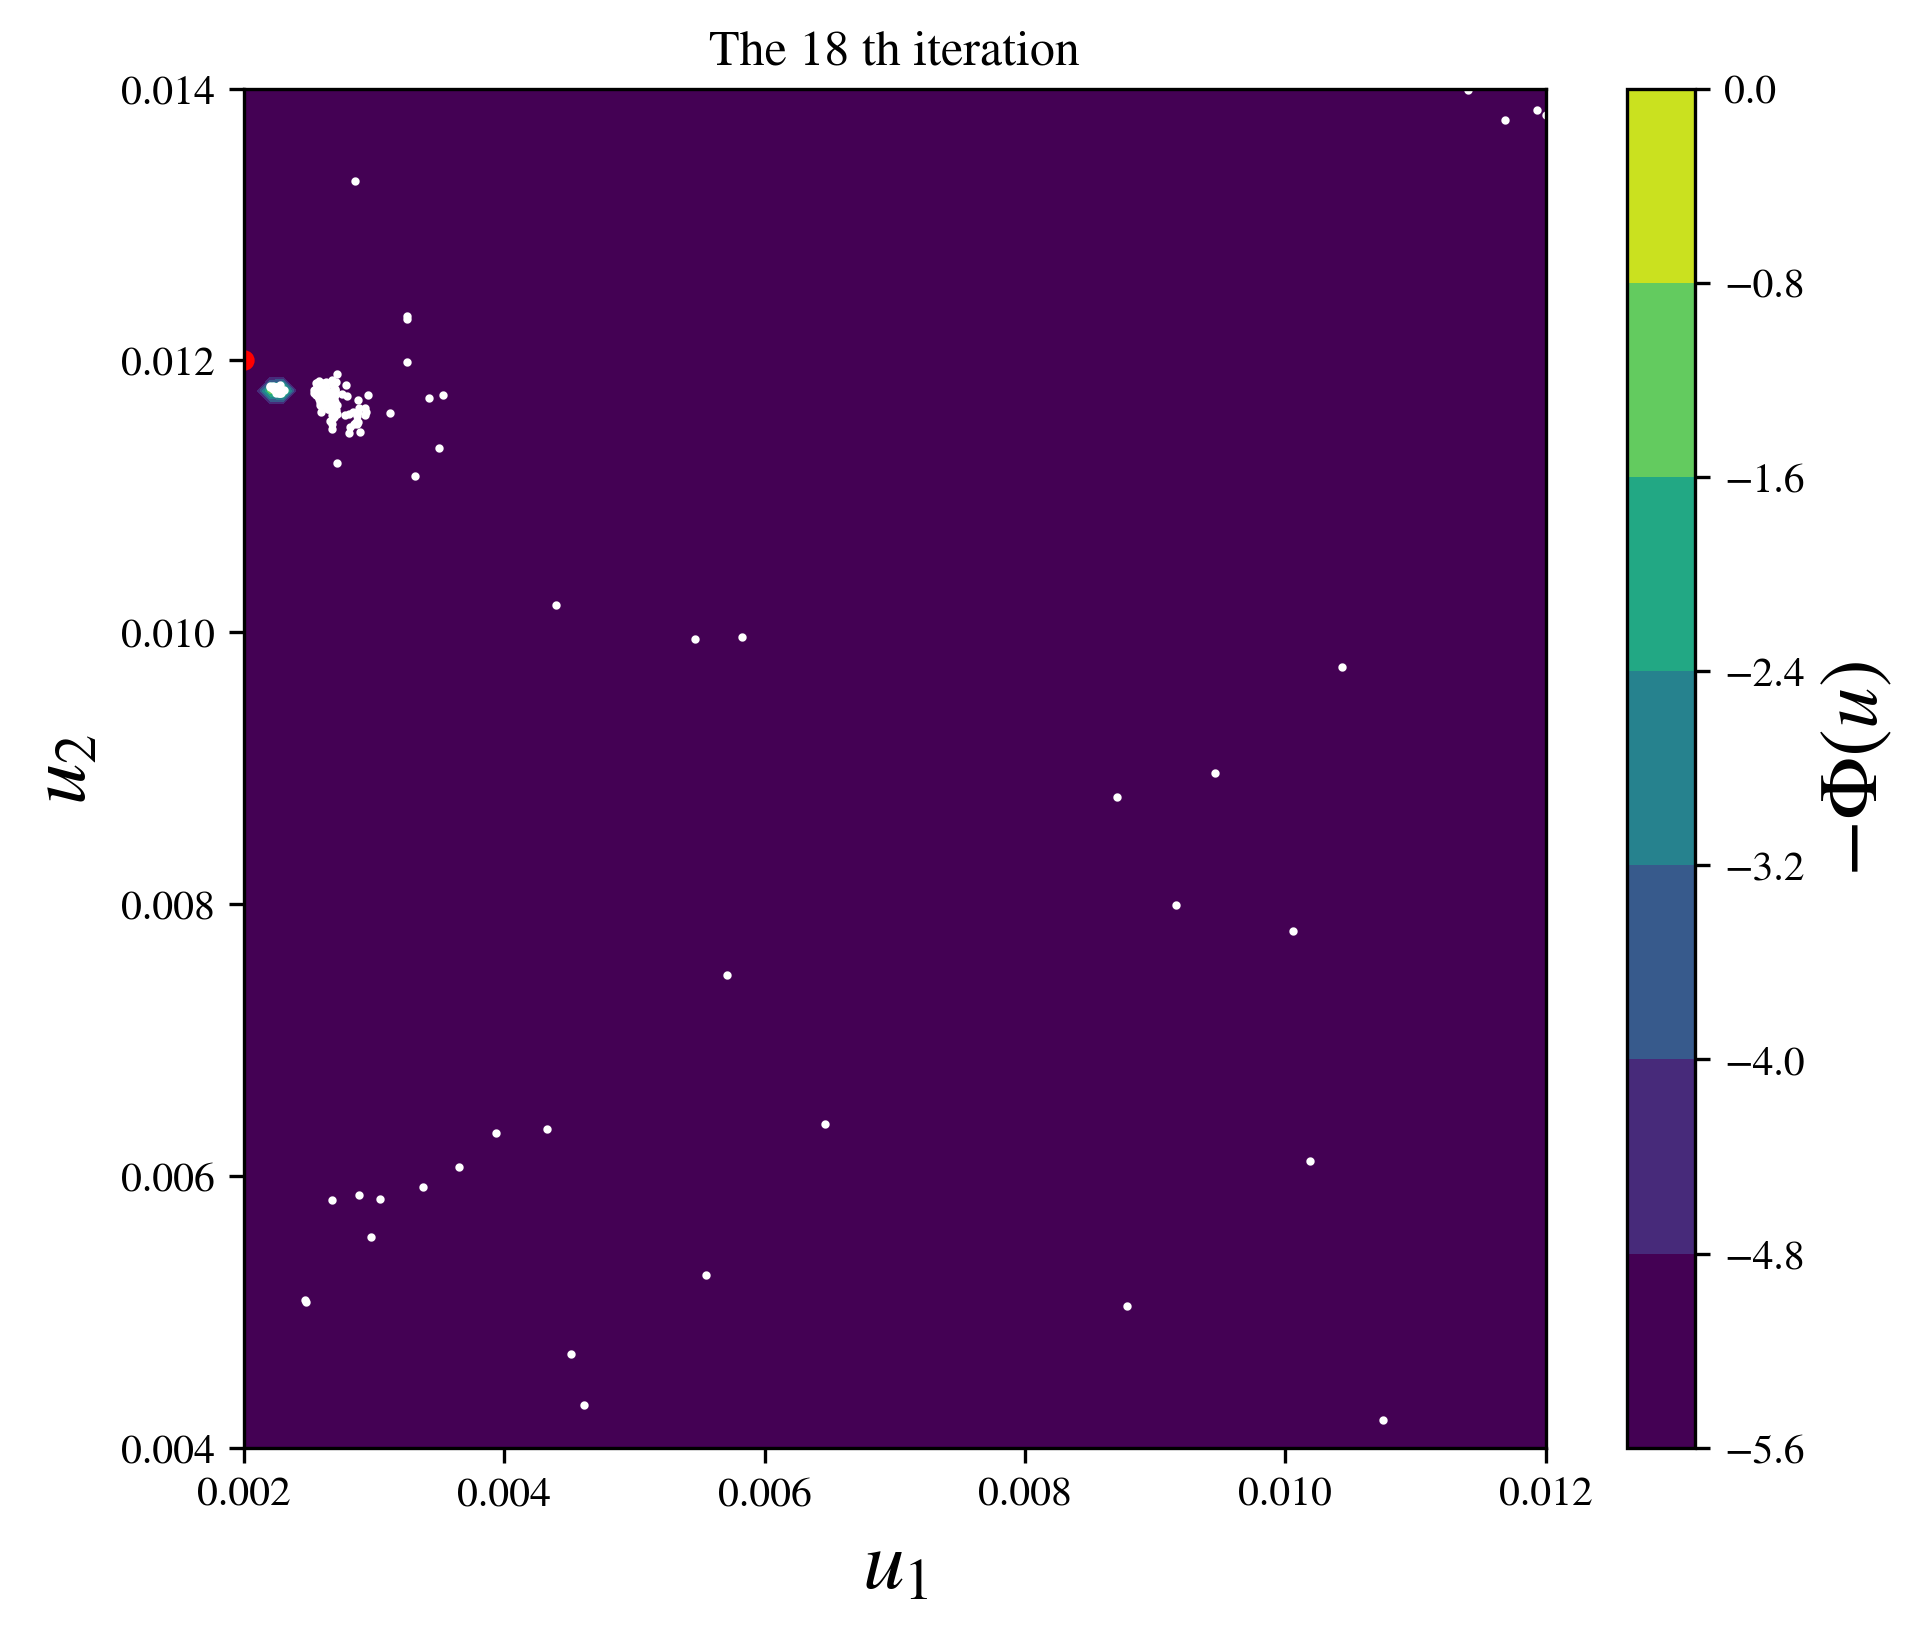

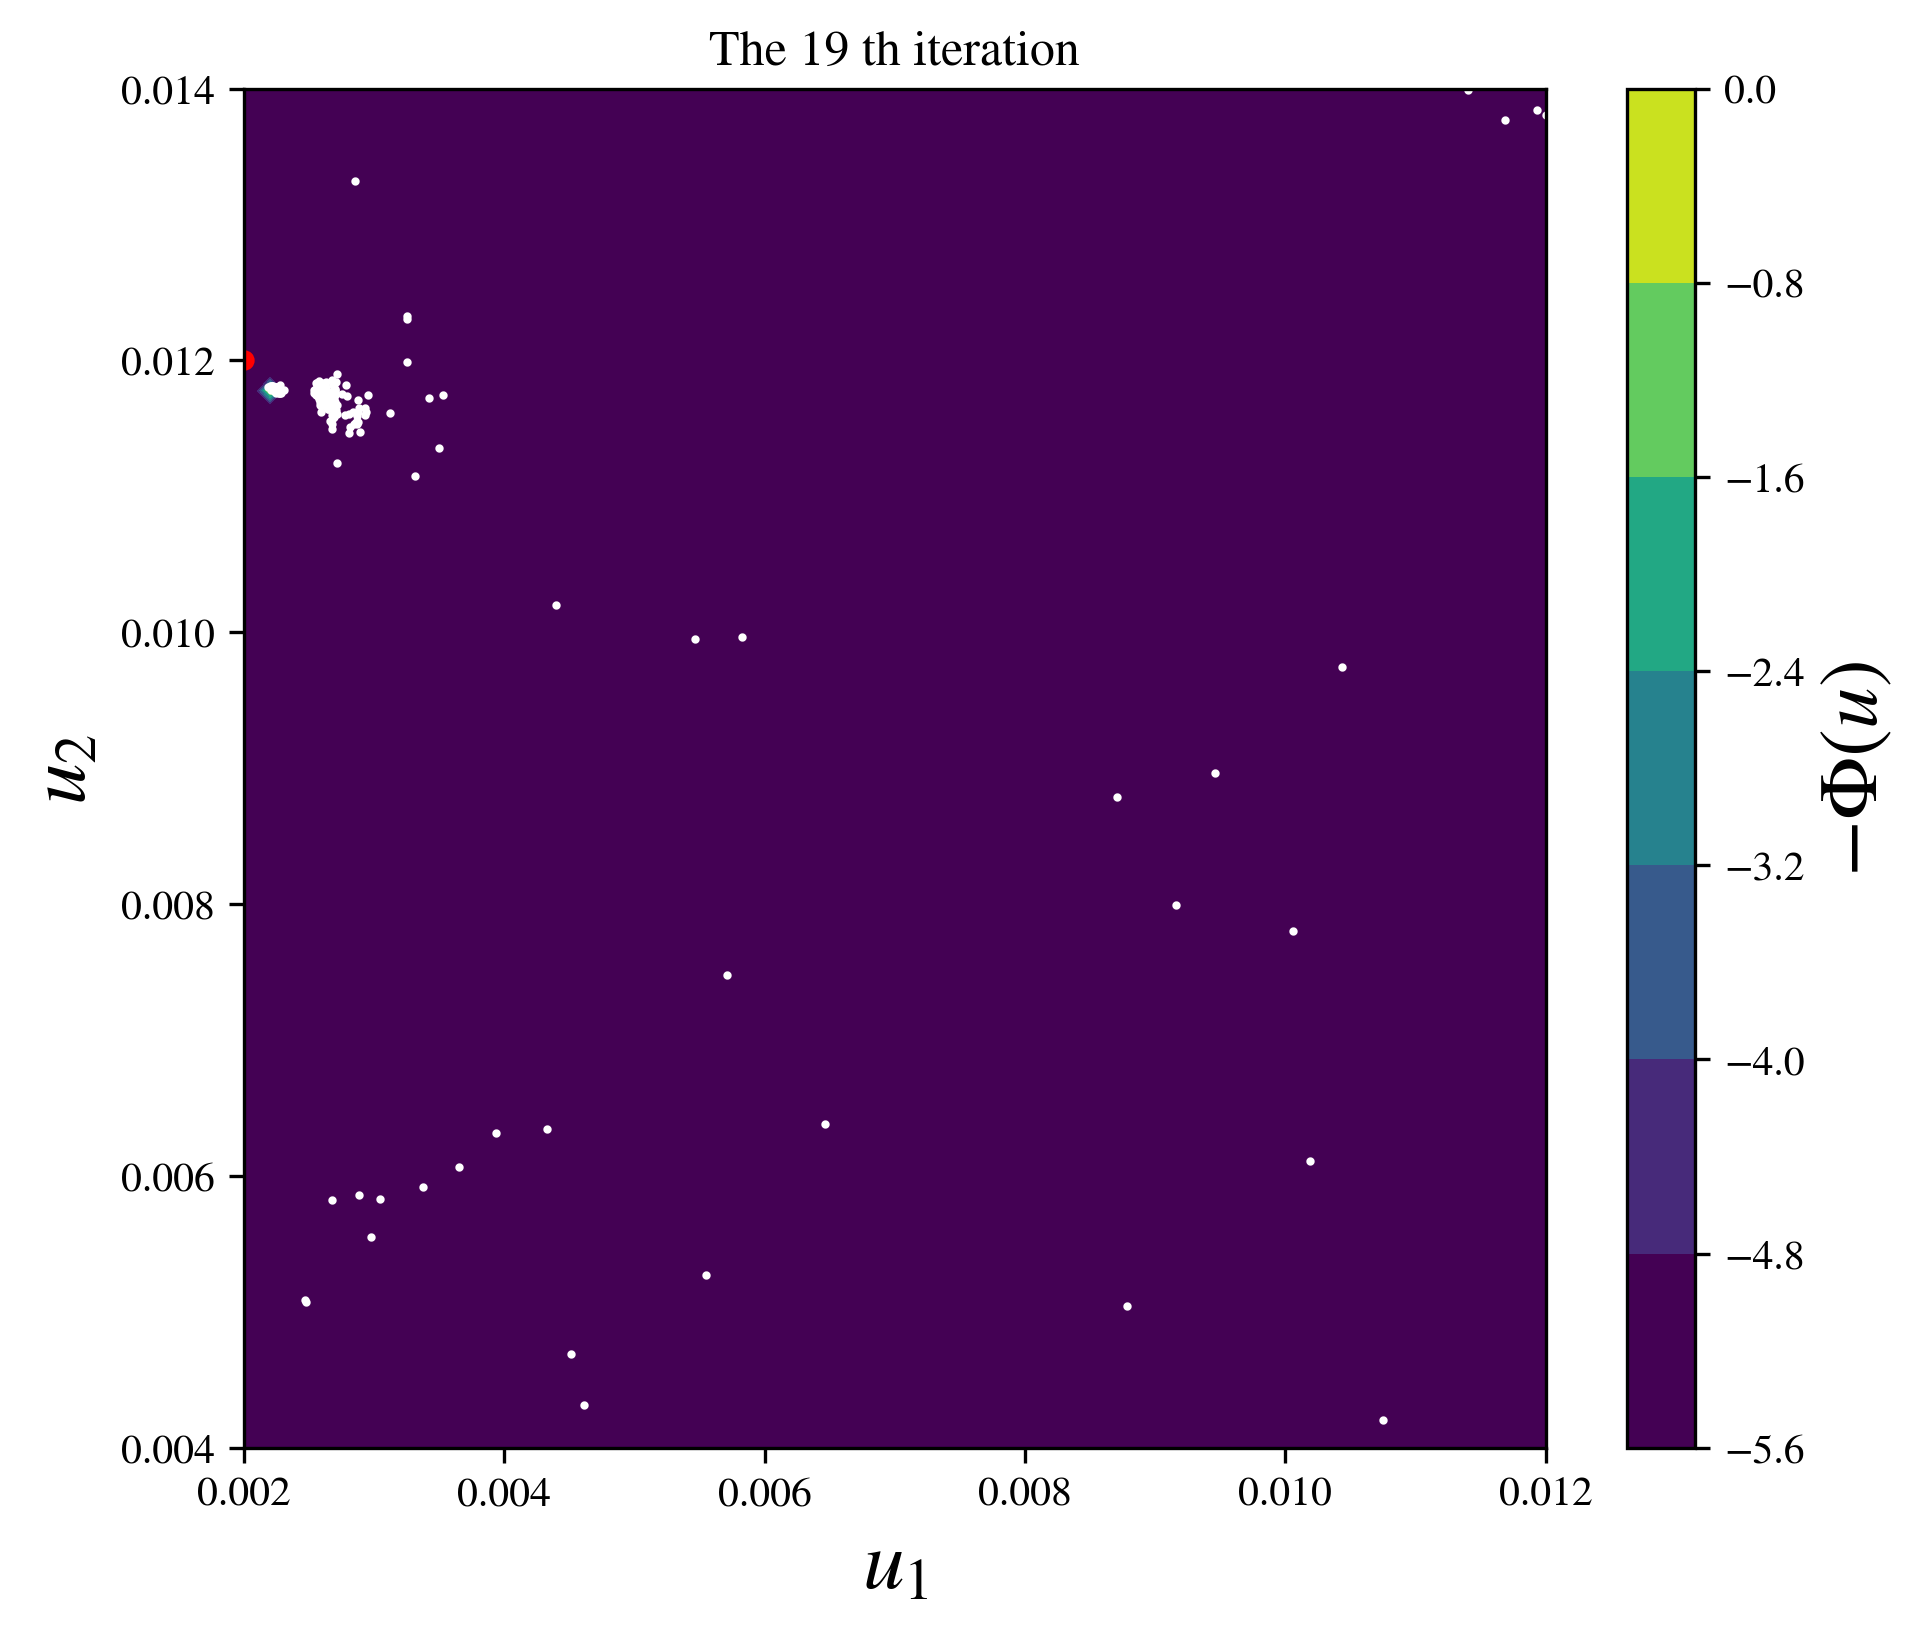

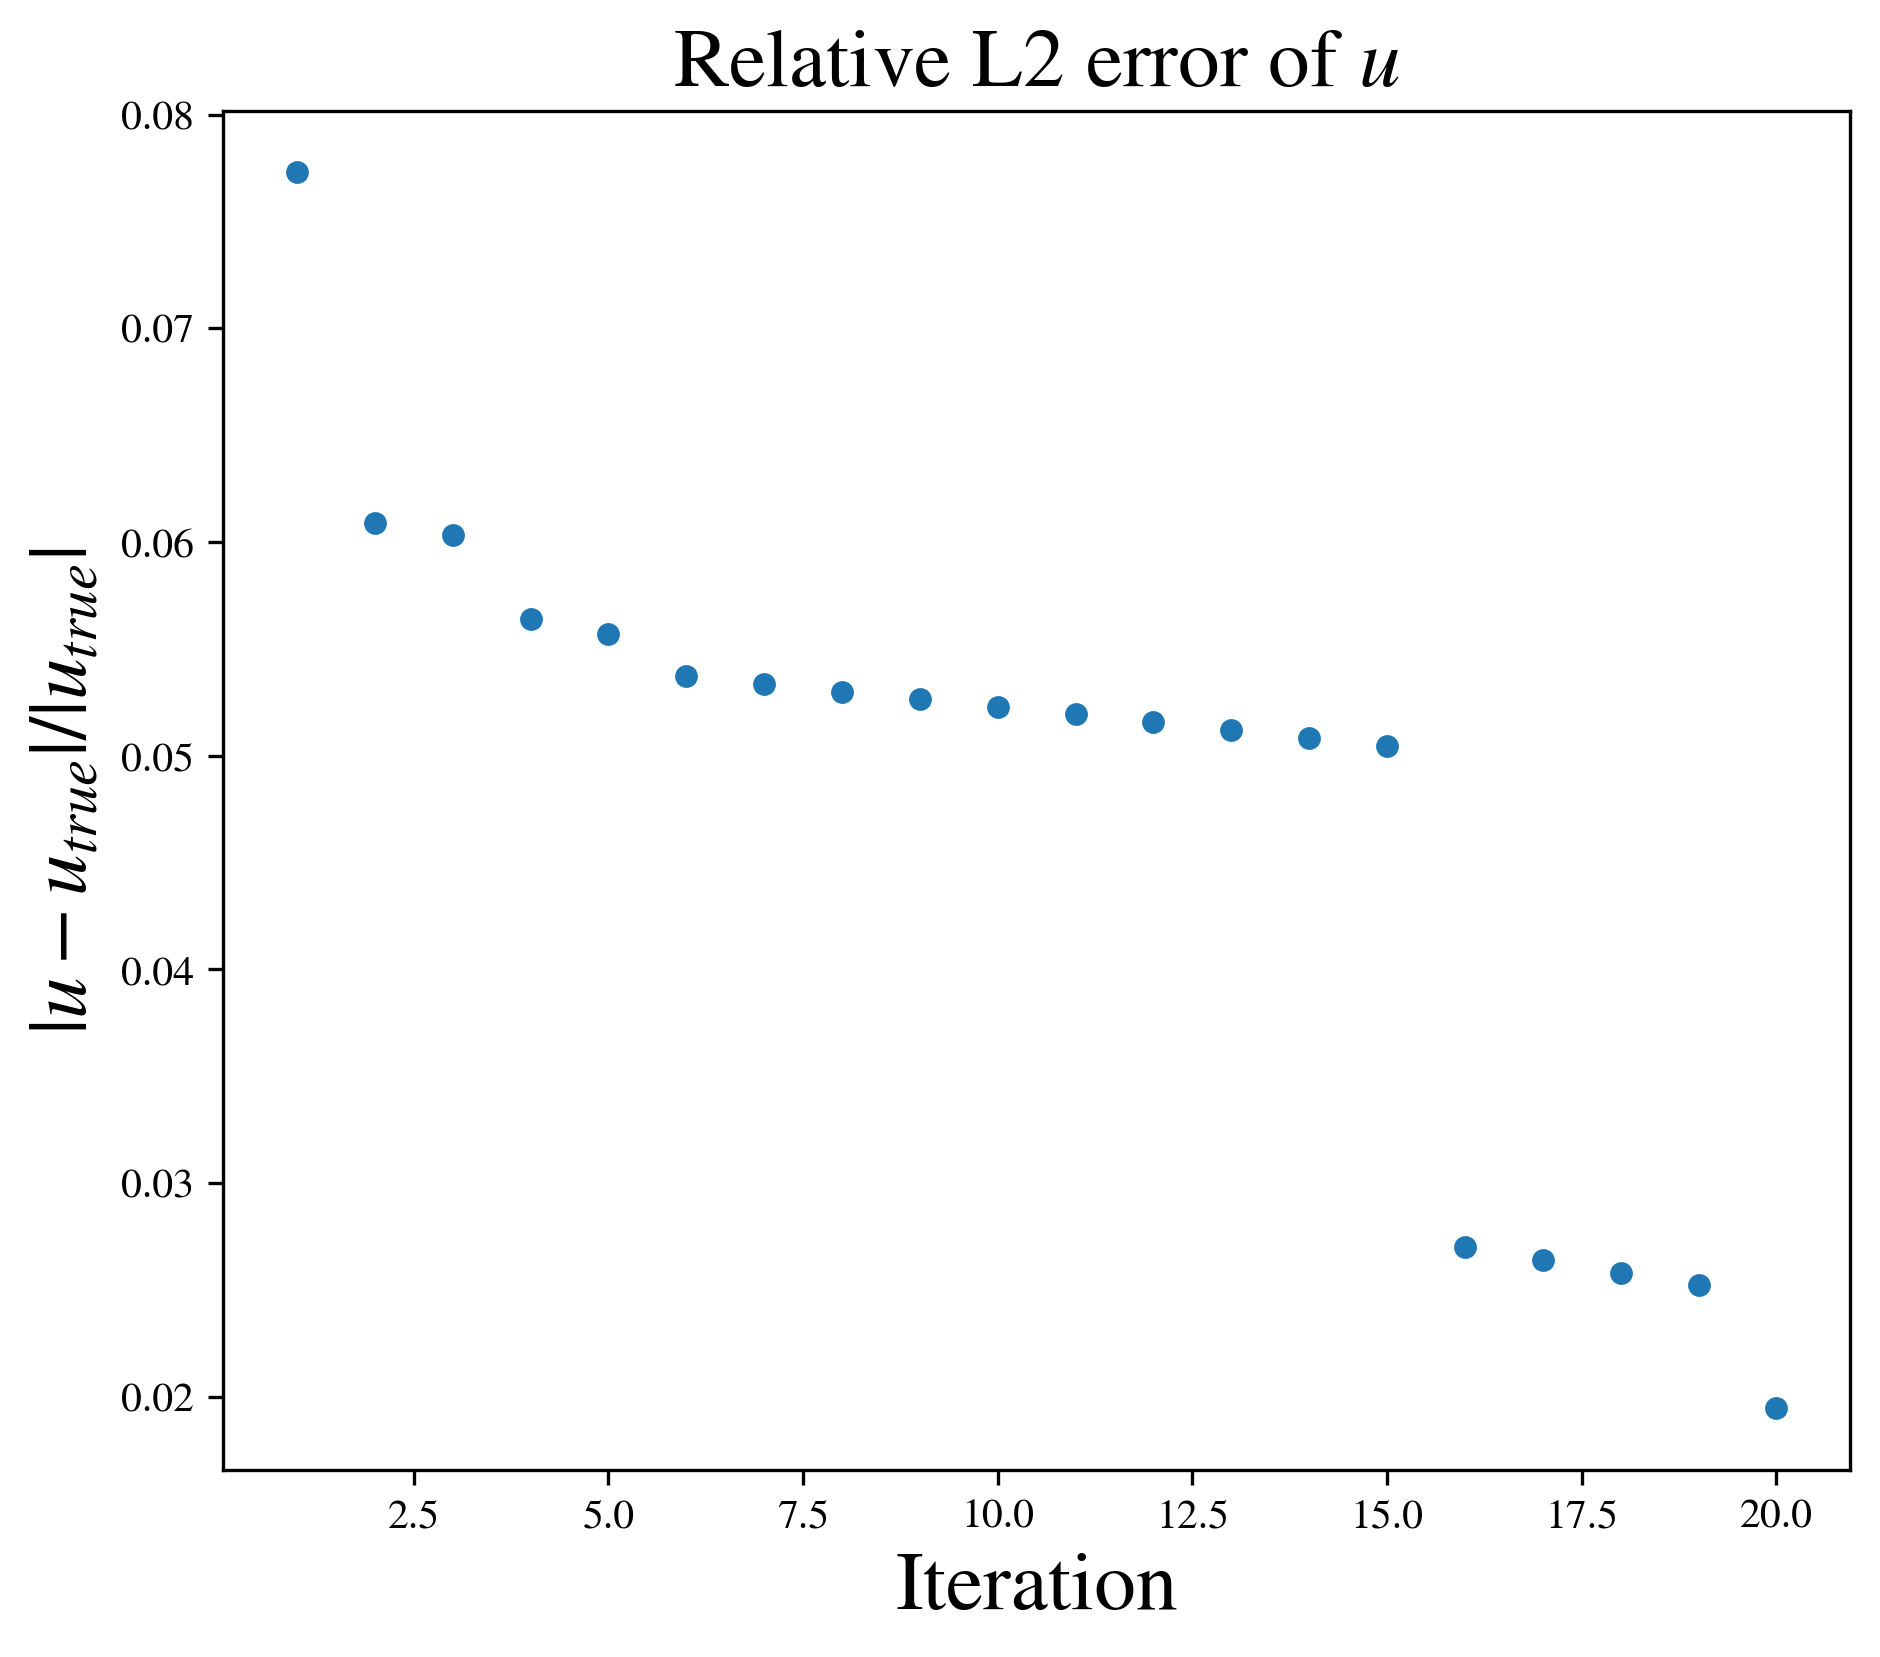

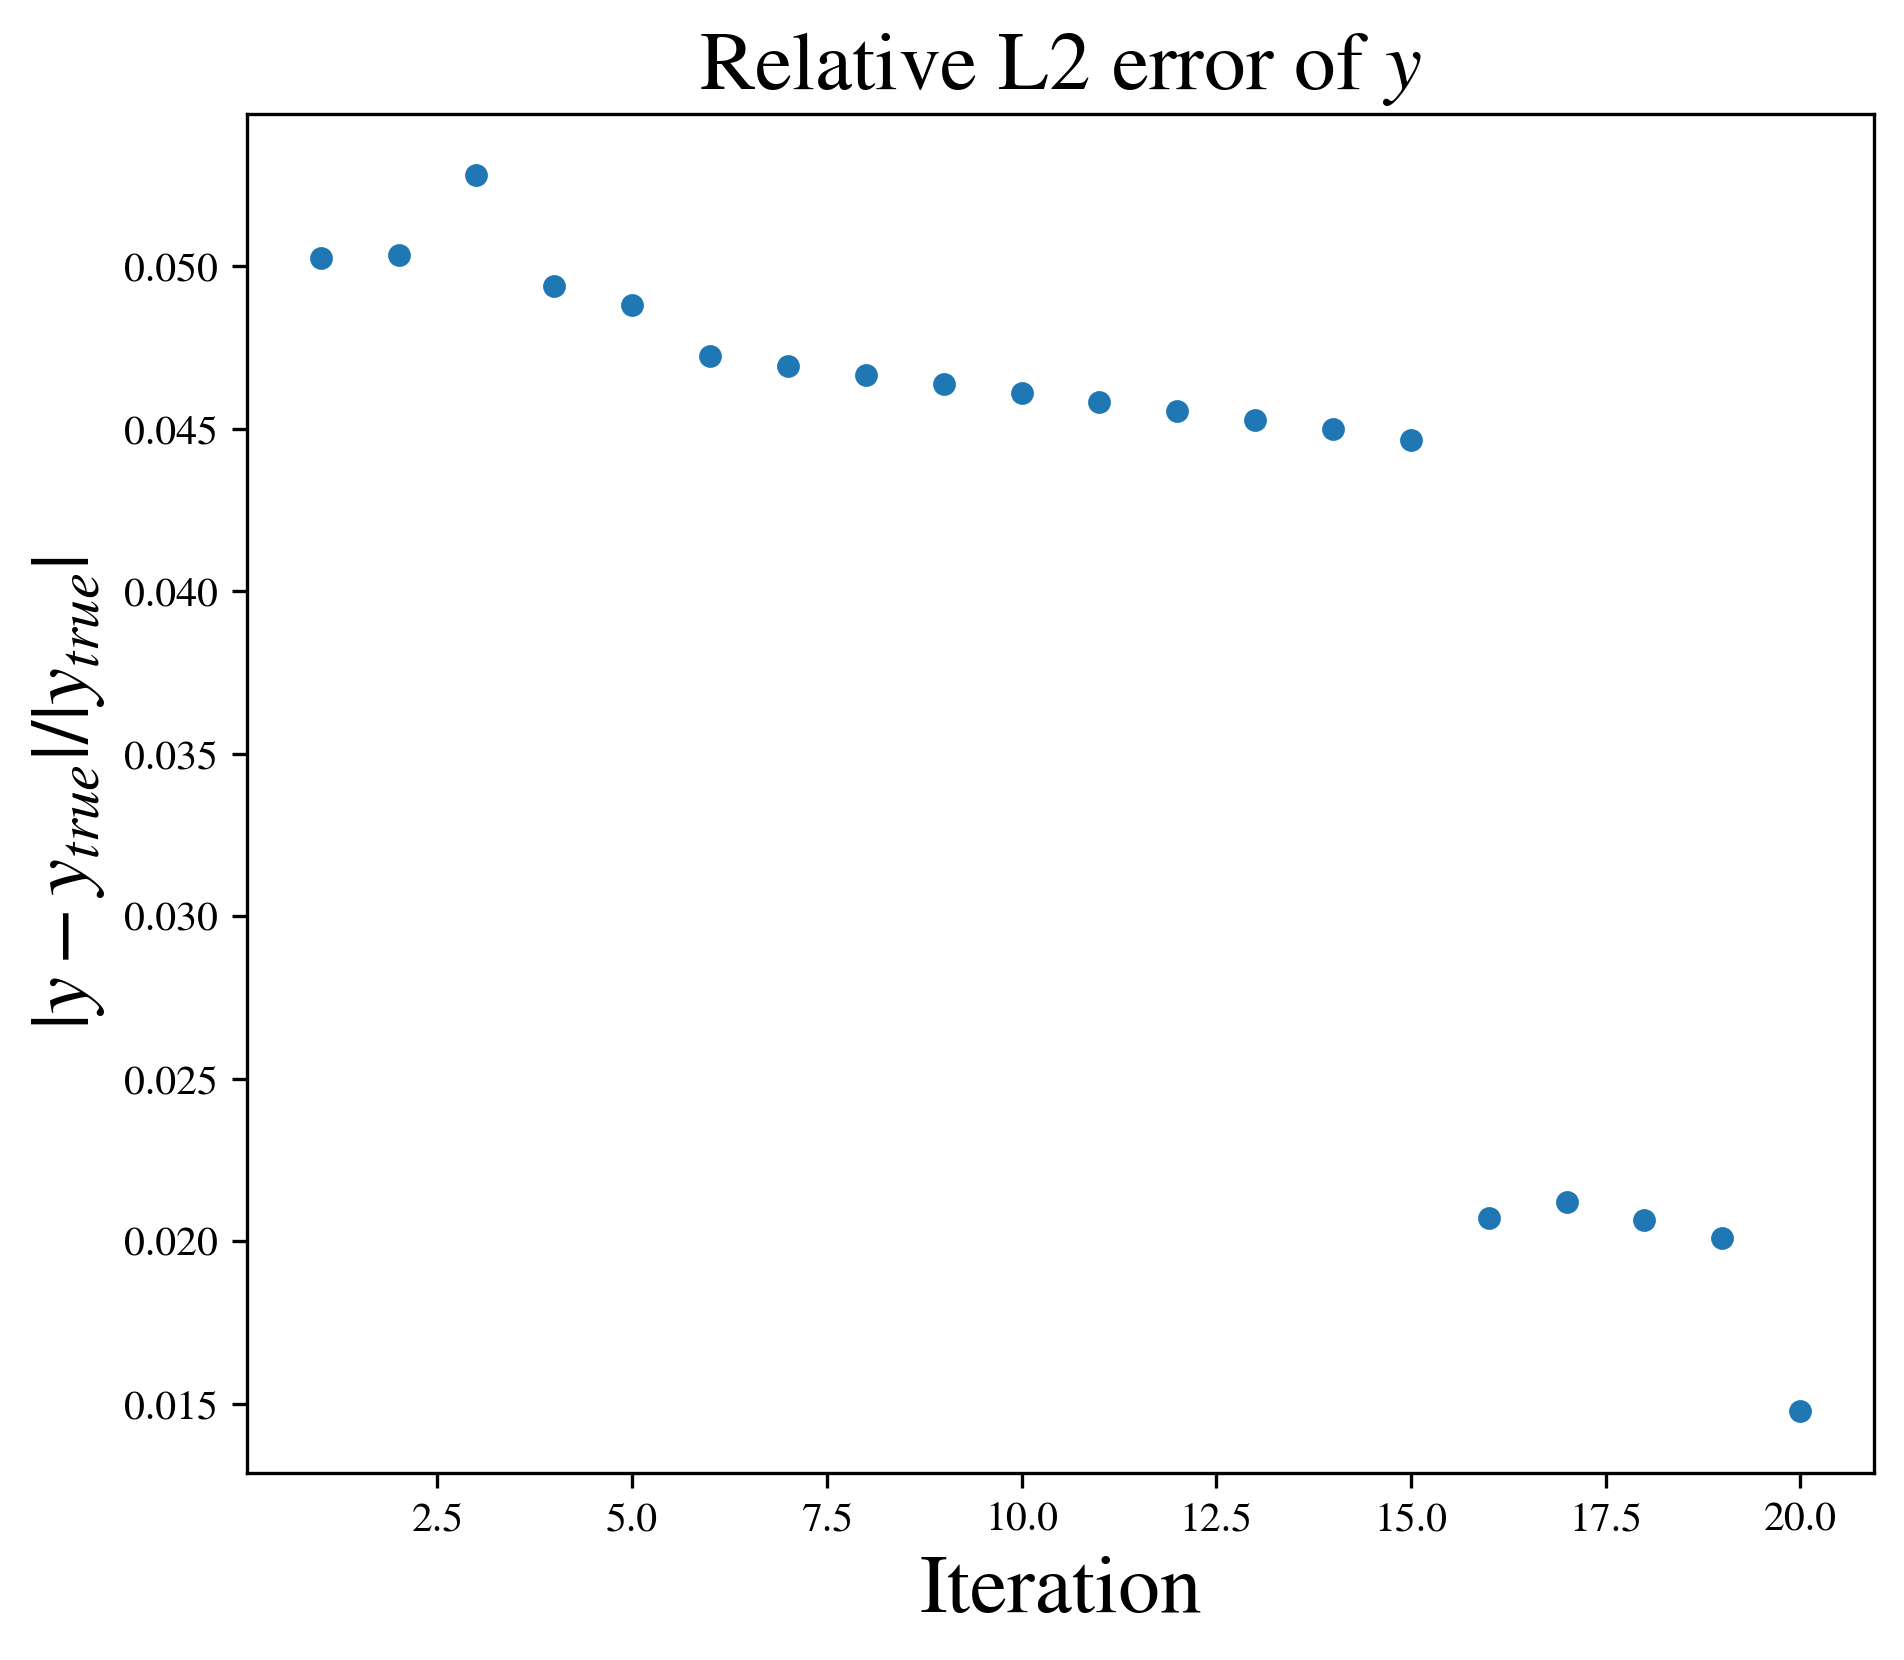

In [769]:
myInv.plotGIF()

array([0.77021421, 0.16604244, 0.18676673, 0.1720861 , 0.14464393,
       0.20573411, 0.18515219, 0.10601985, 0.31992228, 0.16605579])

In [669]:
# Run another 10 iterations
myInv.run(n_iter_max = 10)

==============================  Iteration  10   ==============================
eta_times, MaxMinDistRatio:  6 1.4890050034444144e+02
Running case A0.007726298838598189_B0.004099786065870086
Finished in 5 s!

Running case A0.009933576245099596_B0.005467182681028729
Finished in 5 s!

Running case A0.007631668887039629_B0.00408877780111573
Finished in 6 s!

Running case A0.009928042363567011_B0.005053155123200017
Finished in 5 s!

Running case A0.007594074927871309_B0.004093784884240049
Finished in 6 s!

Running case A0.009987706220013095_B0.005205393868838193
Finished in 5 s!

Running case A0.009864922825612972_B0.005320055059290592
Finished in 5 s!

Running case A0.0074583921319527355_B0.00416555726765884
Finished in 6 s!

Running case A0.010048378244994993_B0.005049503880207782
Finished in 5 s!

Running case A0.010021544456314648_B0.004946660051202907
Finished in 5 s!

Running case A0.009897882835096518_B0.0051972547771771075
Finished in 6 s!

Running case A0.00996660013408564_B0.00528

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  165.70064544677734  s
Average error in this iteration:  1.6311554146553277e+02
Maximum to minimum distance in the sample points:  148.90050034444144
Mean of the posterior after this iteration:  [0.0077055  0.00569293]
Stdv of the posterior after this iteration:  [0.0021319  0.00259671]
==============================  Iteration  11   ==============================
eta_times, MaxMinDistRatio:  6 263.3511091150065
Running case A0.0076865965136074_B0.004292524175037893
Finished in 5 s!

Running case A0.00993308028367723_B0.005355487413850588
Finished in 5 s!

Running case A0.007615630630436629_B0.0043042237722148765
Finished in 6 s!

Running case A0.009972643111327582_B0.005152710497857723
Finished in 5 s!

Running case A0.010000313378554788_B0.005205656940282946
Finished in 5 s!

Running case A0.006225244094918465_B0.013935286973329736
Finished in 6 s!

Running case A0.007631926897786193_B0.004096097729286501
Finished in 5 s!

Running case A0.007508067578422862_B0.004006928923

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  174.78107452392578  s
Average error in this iteration:  7.34476594192134e+02
Maximum to minimum distance in the sample points:  263.3511091150065
Mean of the posterior after this iteration:  [0.00837667 0.00477916]
Stdv of the posterior after this iteration:  [0.00110437 0.00226209]
==============================  Iteration  12   ==============================
eta_times, MaxMinDistRatio:  6 2.0621854440282036e+02
Running case A0.010012060132013268_B0.004920893286861886
Finished in 5 s!

Running case A0.00984291808641446_B0.0053755514762180295
Finished in 5 s!

Running case A0.007540733890284714_B0.004296727427369802
Finished in 6 s!

Running case A0.009920501119423343_B0.005155588731382943
Finished in 5 s!

Running case A0.00782273695289891_B0.0044944324734745335
Finished in 6 s!

Running case A0.00998581388687124_B0.00525487752577539
Finished in 5 s!

Running case A0.009978303370792118_B0.005222224462165601
Finished in 5 s!

Running case A0.00996713021810944_B0.00513766984

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  179.1553032398224  s
Average error in this iteration:  1.8132755271727234e+02
Maximum to minimum distance in the sample points:  206.21854440282036
Mean of the posterior after this iteration:  [0.00862386 0.005652  ]
Stdv of the posterior after this iteration:  [0.0013181  0.00249064]
==============================  Iteration  13   ==============================
eta_times, MaxMinDistRatio:  6 2034.0120967303612
Running case A0.009952746922517535_B0.005252091035591522
Finished in 5 s!

Running case A0.00991947987022776_B0.005042790351164142
Finished in 5 s!

Running case A0.009984680245273278_B0.005144955913939884
Finished in 5 s!

Running case A0.00769662888424653_B0.004171579969387265
Finished in 5 s!

Running case A0.00624605140324888_B0.013930180538892518
Finished in 5 s!

Running case A0.007836211271723193_B0.004130043855281543
Finished in 6 s!

Running case A0.009987072470298808_B0.0050818496380318785
Finished in 5 s!

Running case A0.009853398979807972_B0.005188178200

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  179.4357624053955  s
Average error in this iteration:  4.346911902731699e+02
Maximum to minimum distance in the sample points:  2034.0120967303612
Mean of the posterior after this iteration:  [0.00739155 0.00668051]
Stdv of the posterior after this iteration:  [0.00159787 0.00376711]
==============================  Iteration  14   ==============================
eta_times, MaxMinDistRatio:  4 81.28634588373353
Running case A0.00984771802548571_B0.005323023181216344
Finished in 6 s!

Running case A0.007844283455622365_B0.004196579710211771
Finished in 5 s!

Running case A0.009951381780944428_B0.005410048765670182
Finished in 5 s!

Running case A0.009778914534674372_B0.005409872220311106
Finished in 6 s!

Running case A0.009944938847190334_B0.005231006720482528
Finished in 5 s!

Running case A0.007557542965277971_B0.004075083931119003
Finished in 6 s!

Running case A0.007850656646121659_B0.004231605732224278
Finished in 5 s!

Running case A0.007769879859758138_B0.0040999687552

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  166.81294012069702  s
Average error in this iteration:  7.395707742085709e+01
Maximum to minimum distance in the sample points:  88.30909235550462
Mean of the posterior after this iteration:  [0.0096798  0.00503494]
Stdv of the posterior after this iteration:  [0.00180844 0.00103935]
==============================  Iteration  17   ==============================
eta_times, MaxMinDistRatio:  6 2.120463859000862e+02
Running case A0.007731342948522915_B0.004068511193340574
Finished in 6 s!

Running case A0.00985478459239935_B0.005091237493704532
Finished in 5 s!

Running case A0.0076970908752293015_B0.004052061901108317
Finished in 5 s!

Running case A0.009917561341094746_B0.005463545797201836
Finished in 5 s!

Running case A0.009886535704873562_B0.005088698716008428
Finished in 5 s!

Running case A0.007764590977635461_B0.004219026438580294
Finished in 6 s!

Running case A0.0078060839039330535_B0.00407912399755114
Finished in 5 s!

Running case A0.007593506738283217_B0.00409888

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  197.45496678352356  s
Average error in this iteration:  8.56141566991758e+01
Maximum to minimum distance in the sample points:  212.0463859000862
Mean of the posterior after this iteration:  [0.00956586 0.00508212]
Stdv of the posterior after this iteration:  [0.00174365 0.00110766]
==============================  Iteration  18   ==============================
eta_times, MaxMinDistRatio:  6 2.3421672112162187e+02
Running case A0.007752555409363301_B0.004052868582118417
Finished in 5 s!

Running case A0.009740470629997082_B0.005456308336590794
Finished in 6 s!

Running case A0.007462890471806323_B0.004114225550097842
Finished in 5 s!

Running case A0.007669030448366276_B0.004162716738065691
Finished in 5 s!

Running case A0.007744566650201538_B0.004219614974048135
Finished in 5 s!

Running case A0.00775021976925341_B0.00417945519414489
Finished in 5 s!

Running case A0.007653149986672115_B0.004106132691363035
Finished in 6 s!

Running case A0.007785448545834526_B0.0040502737

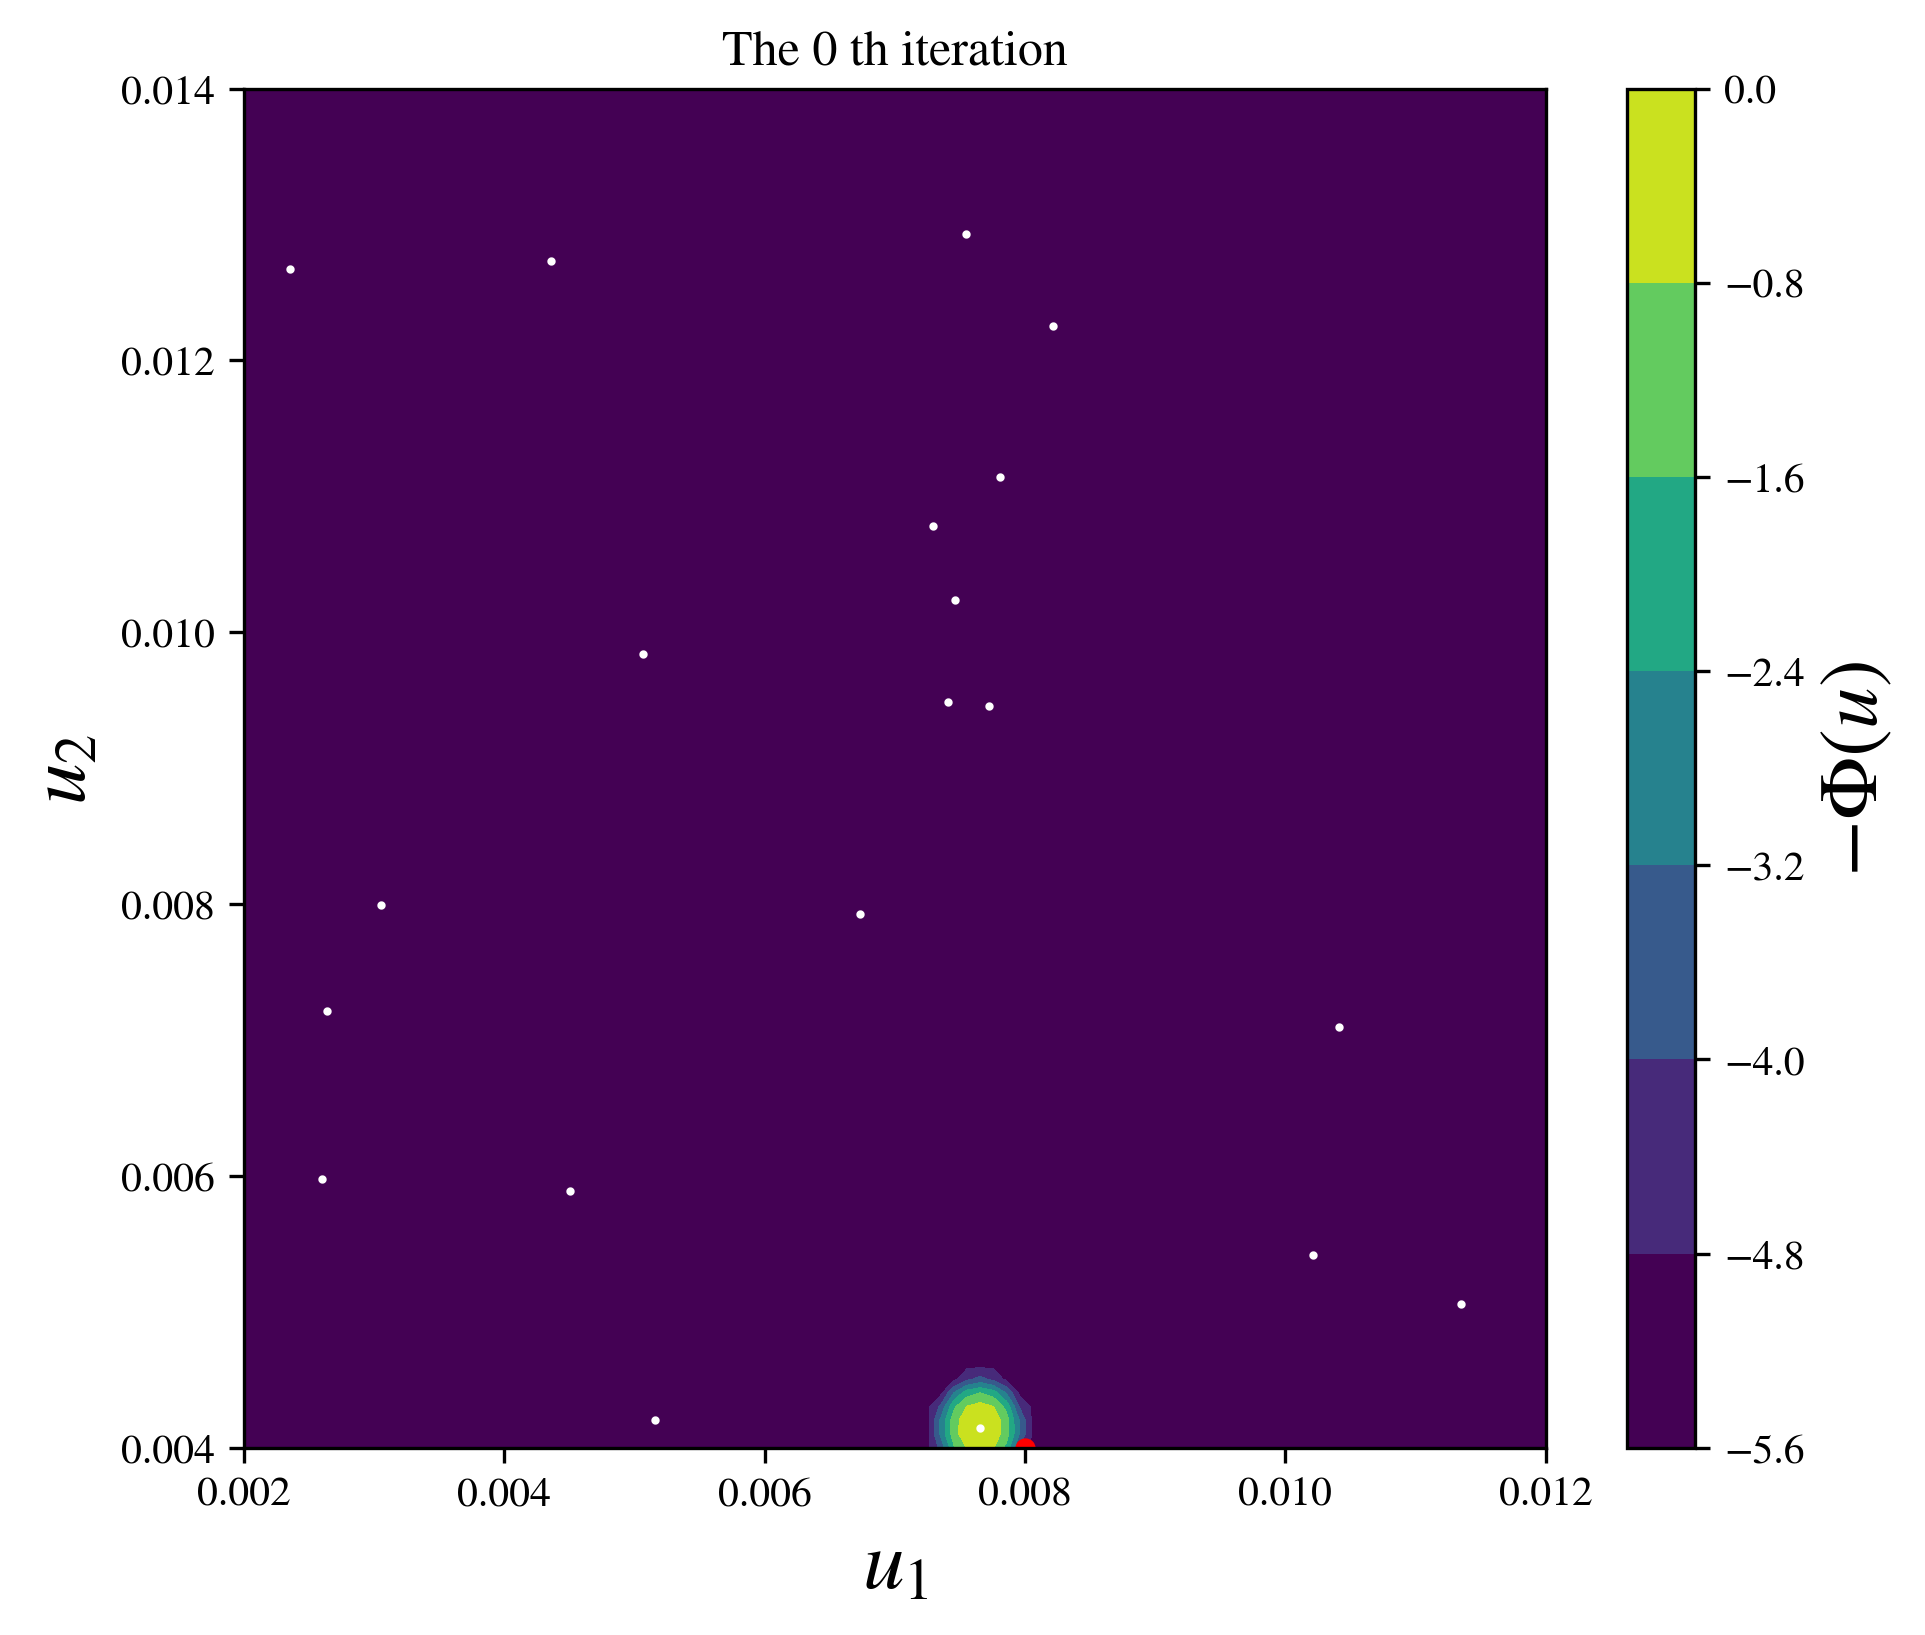

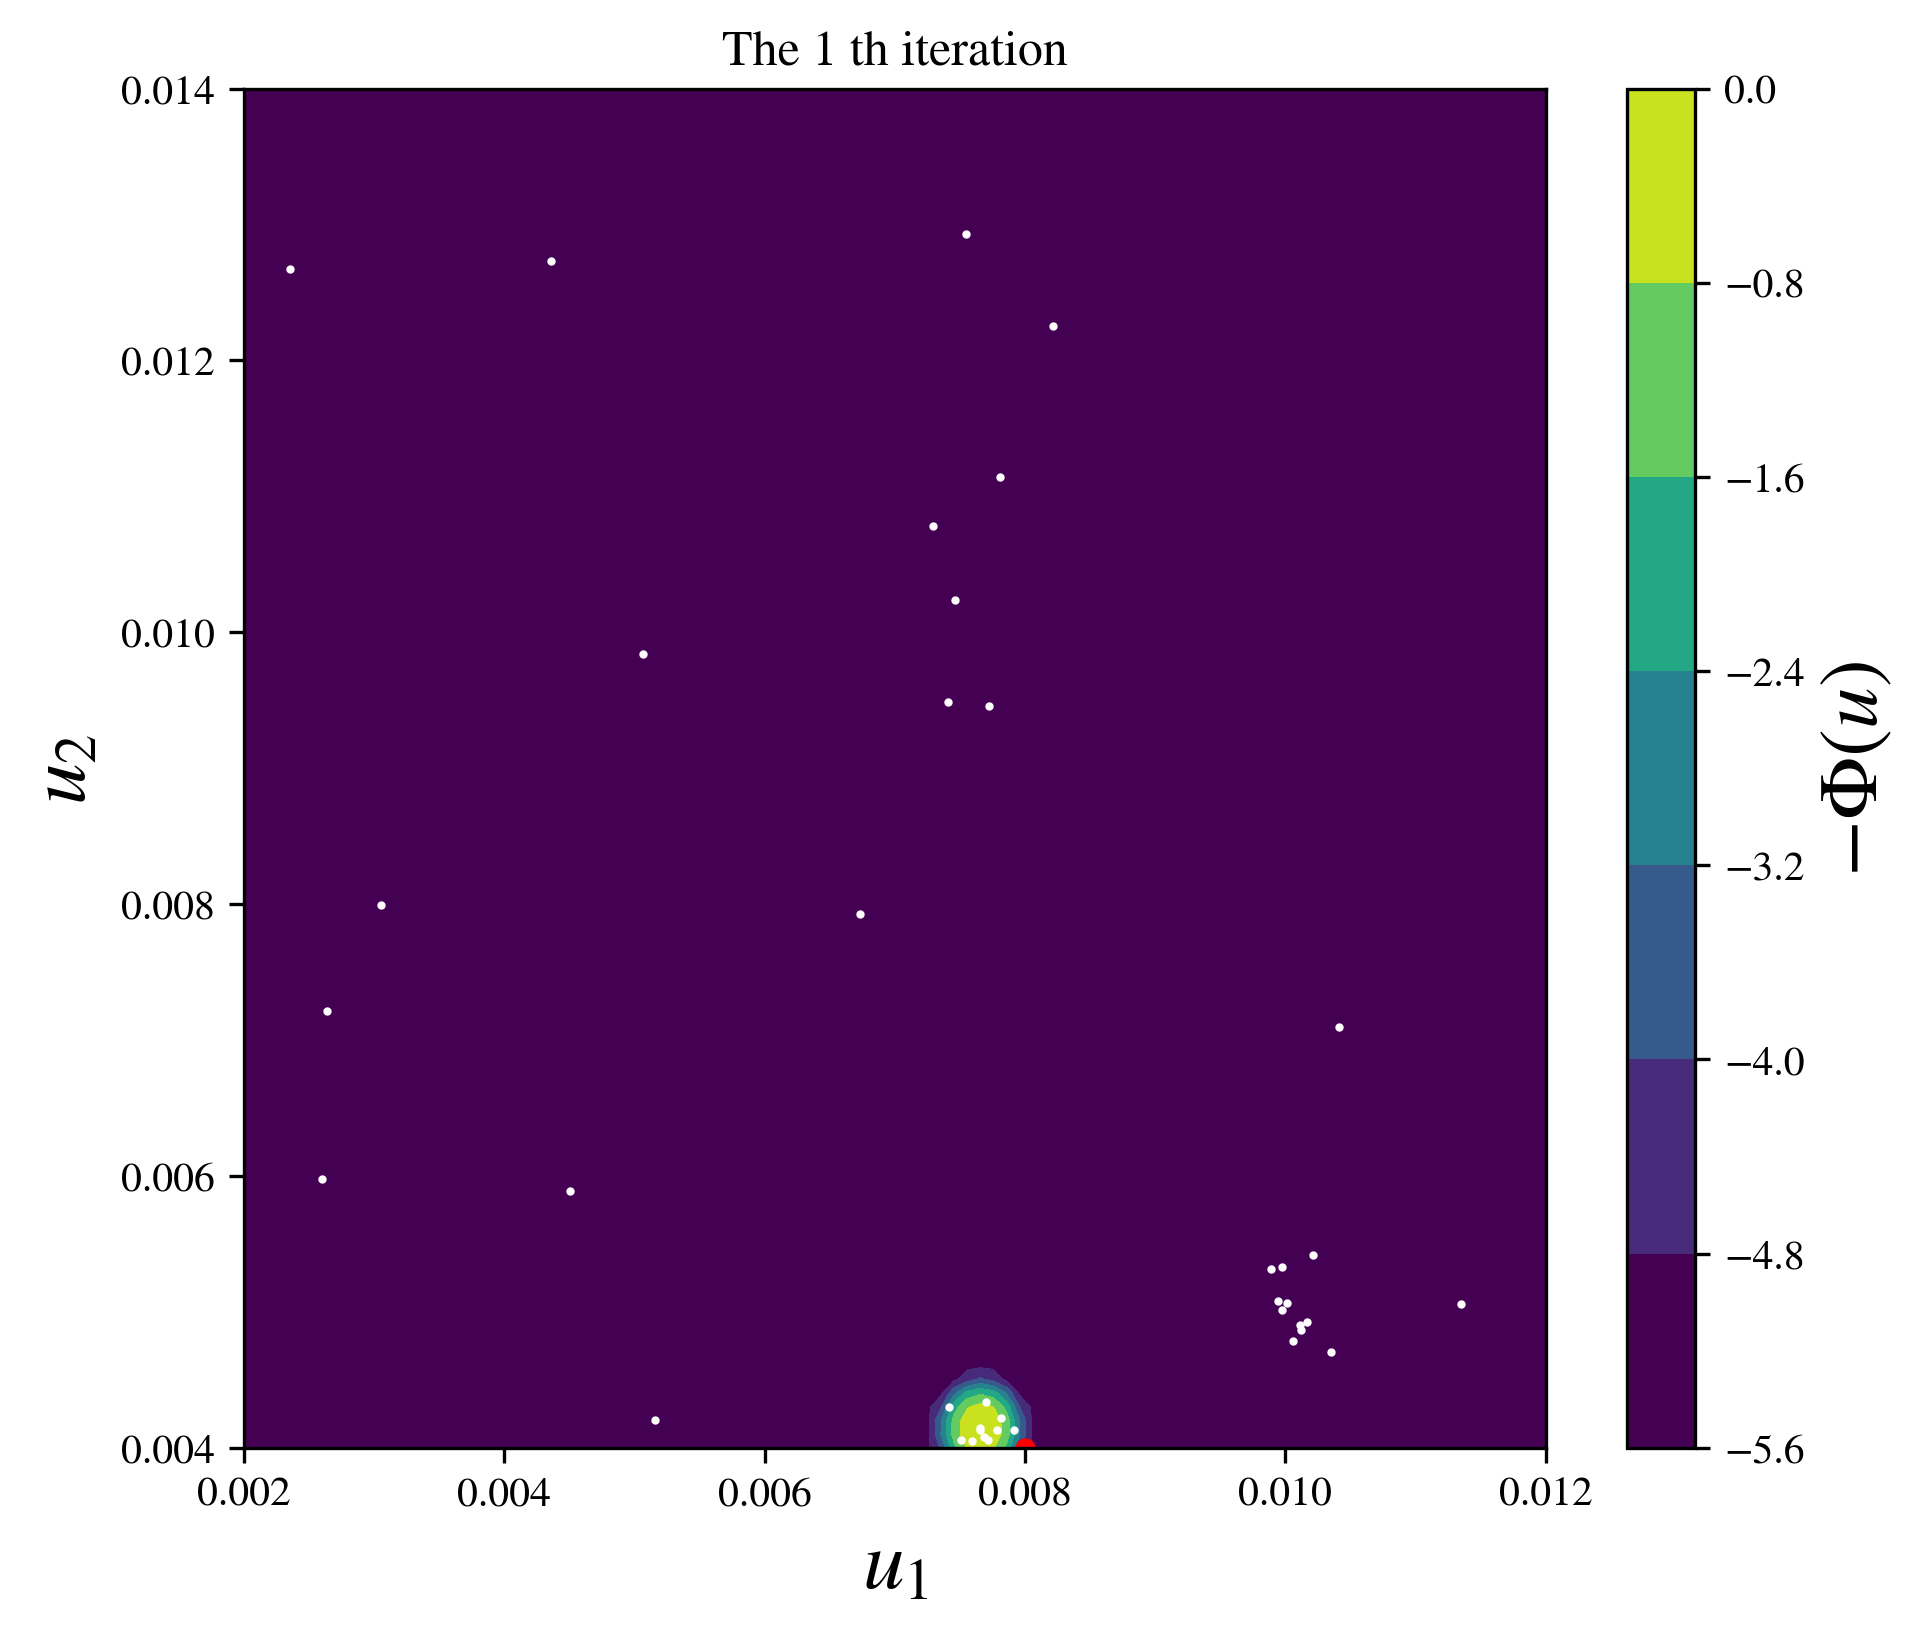

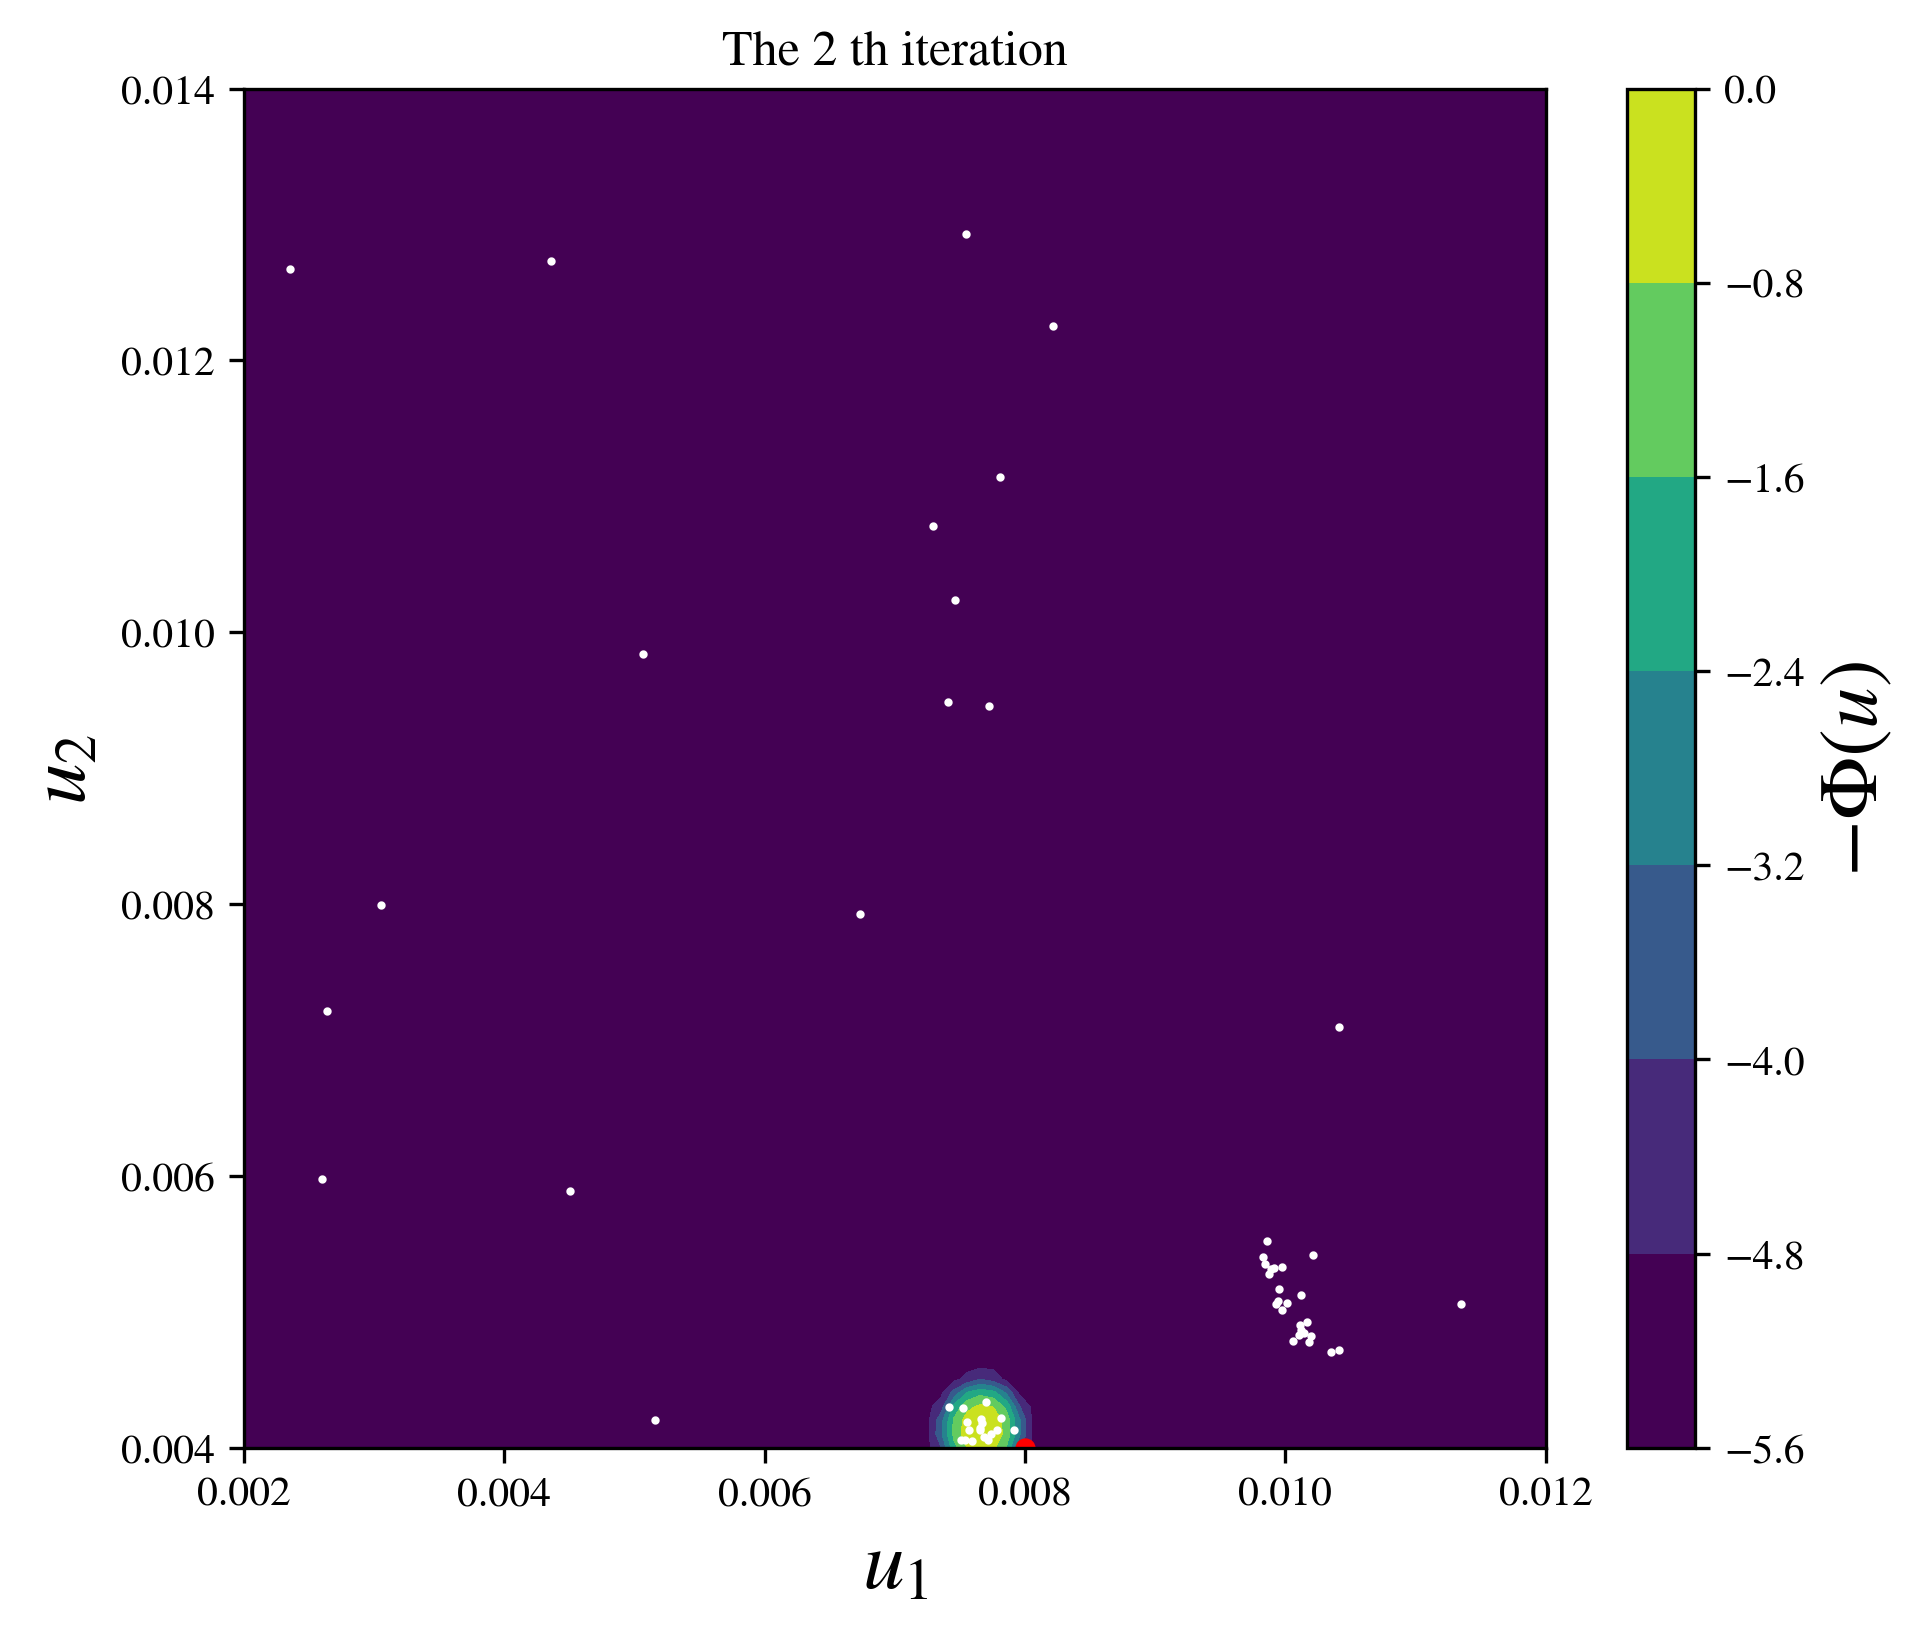

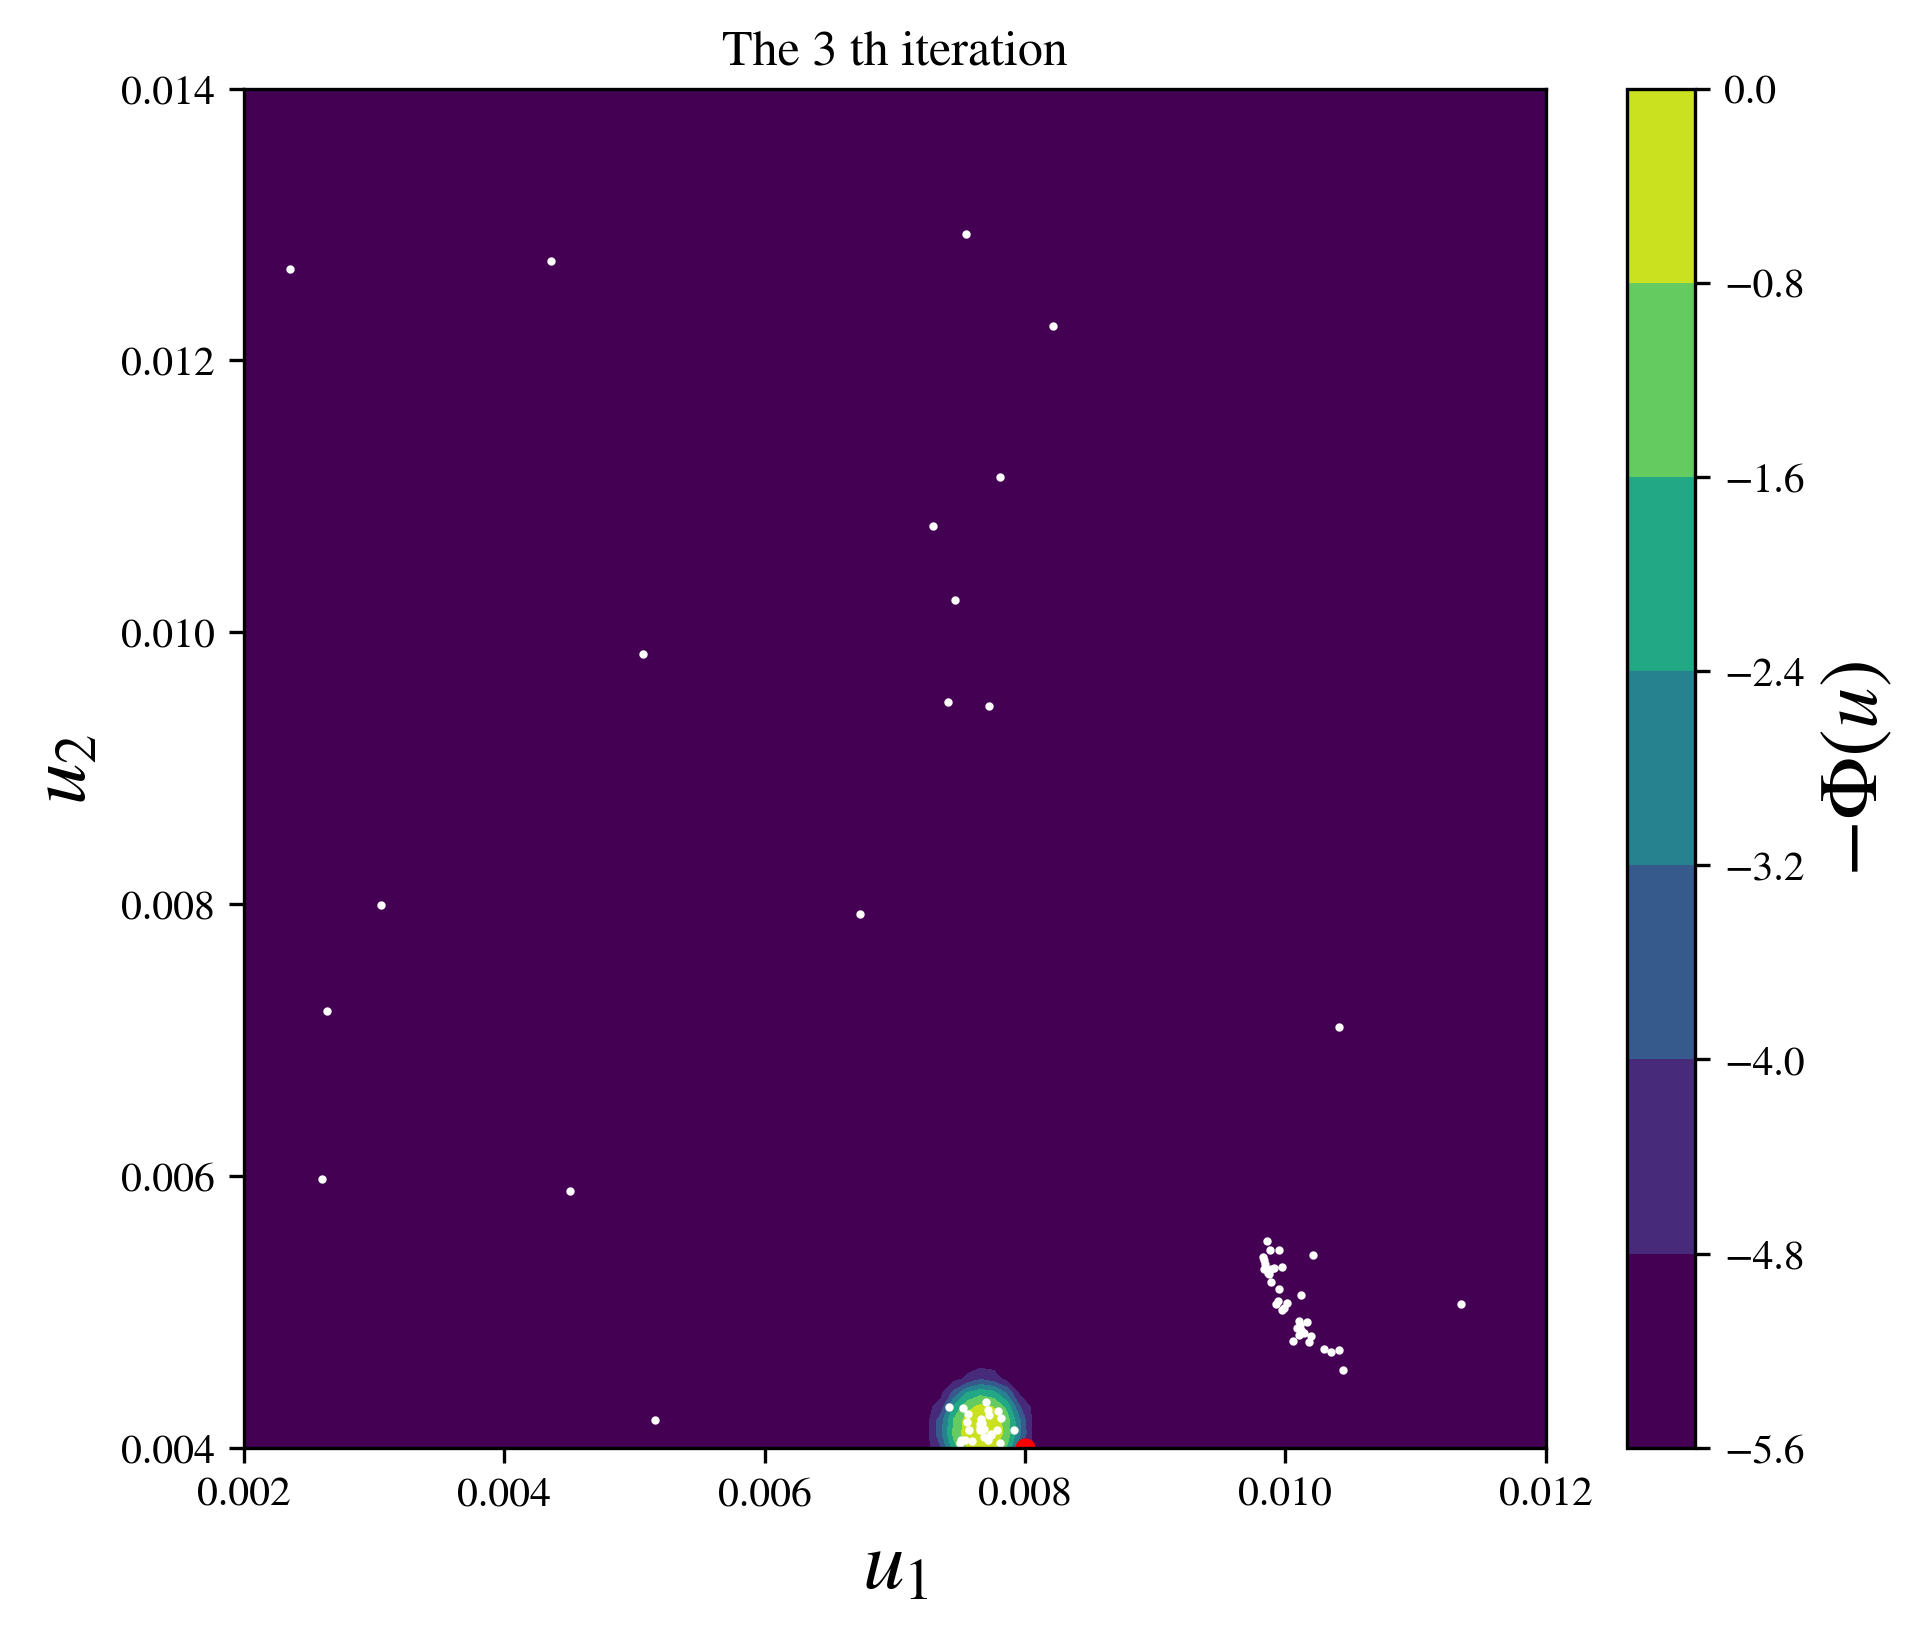

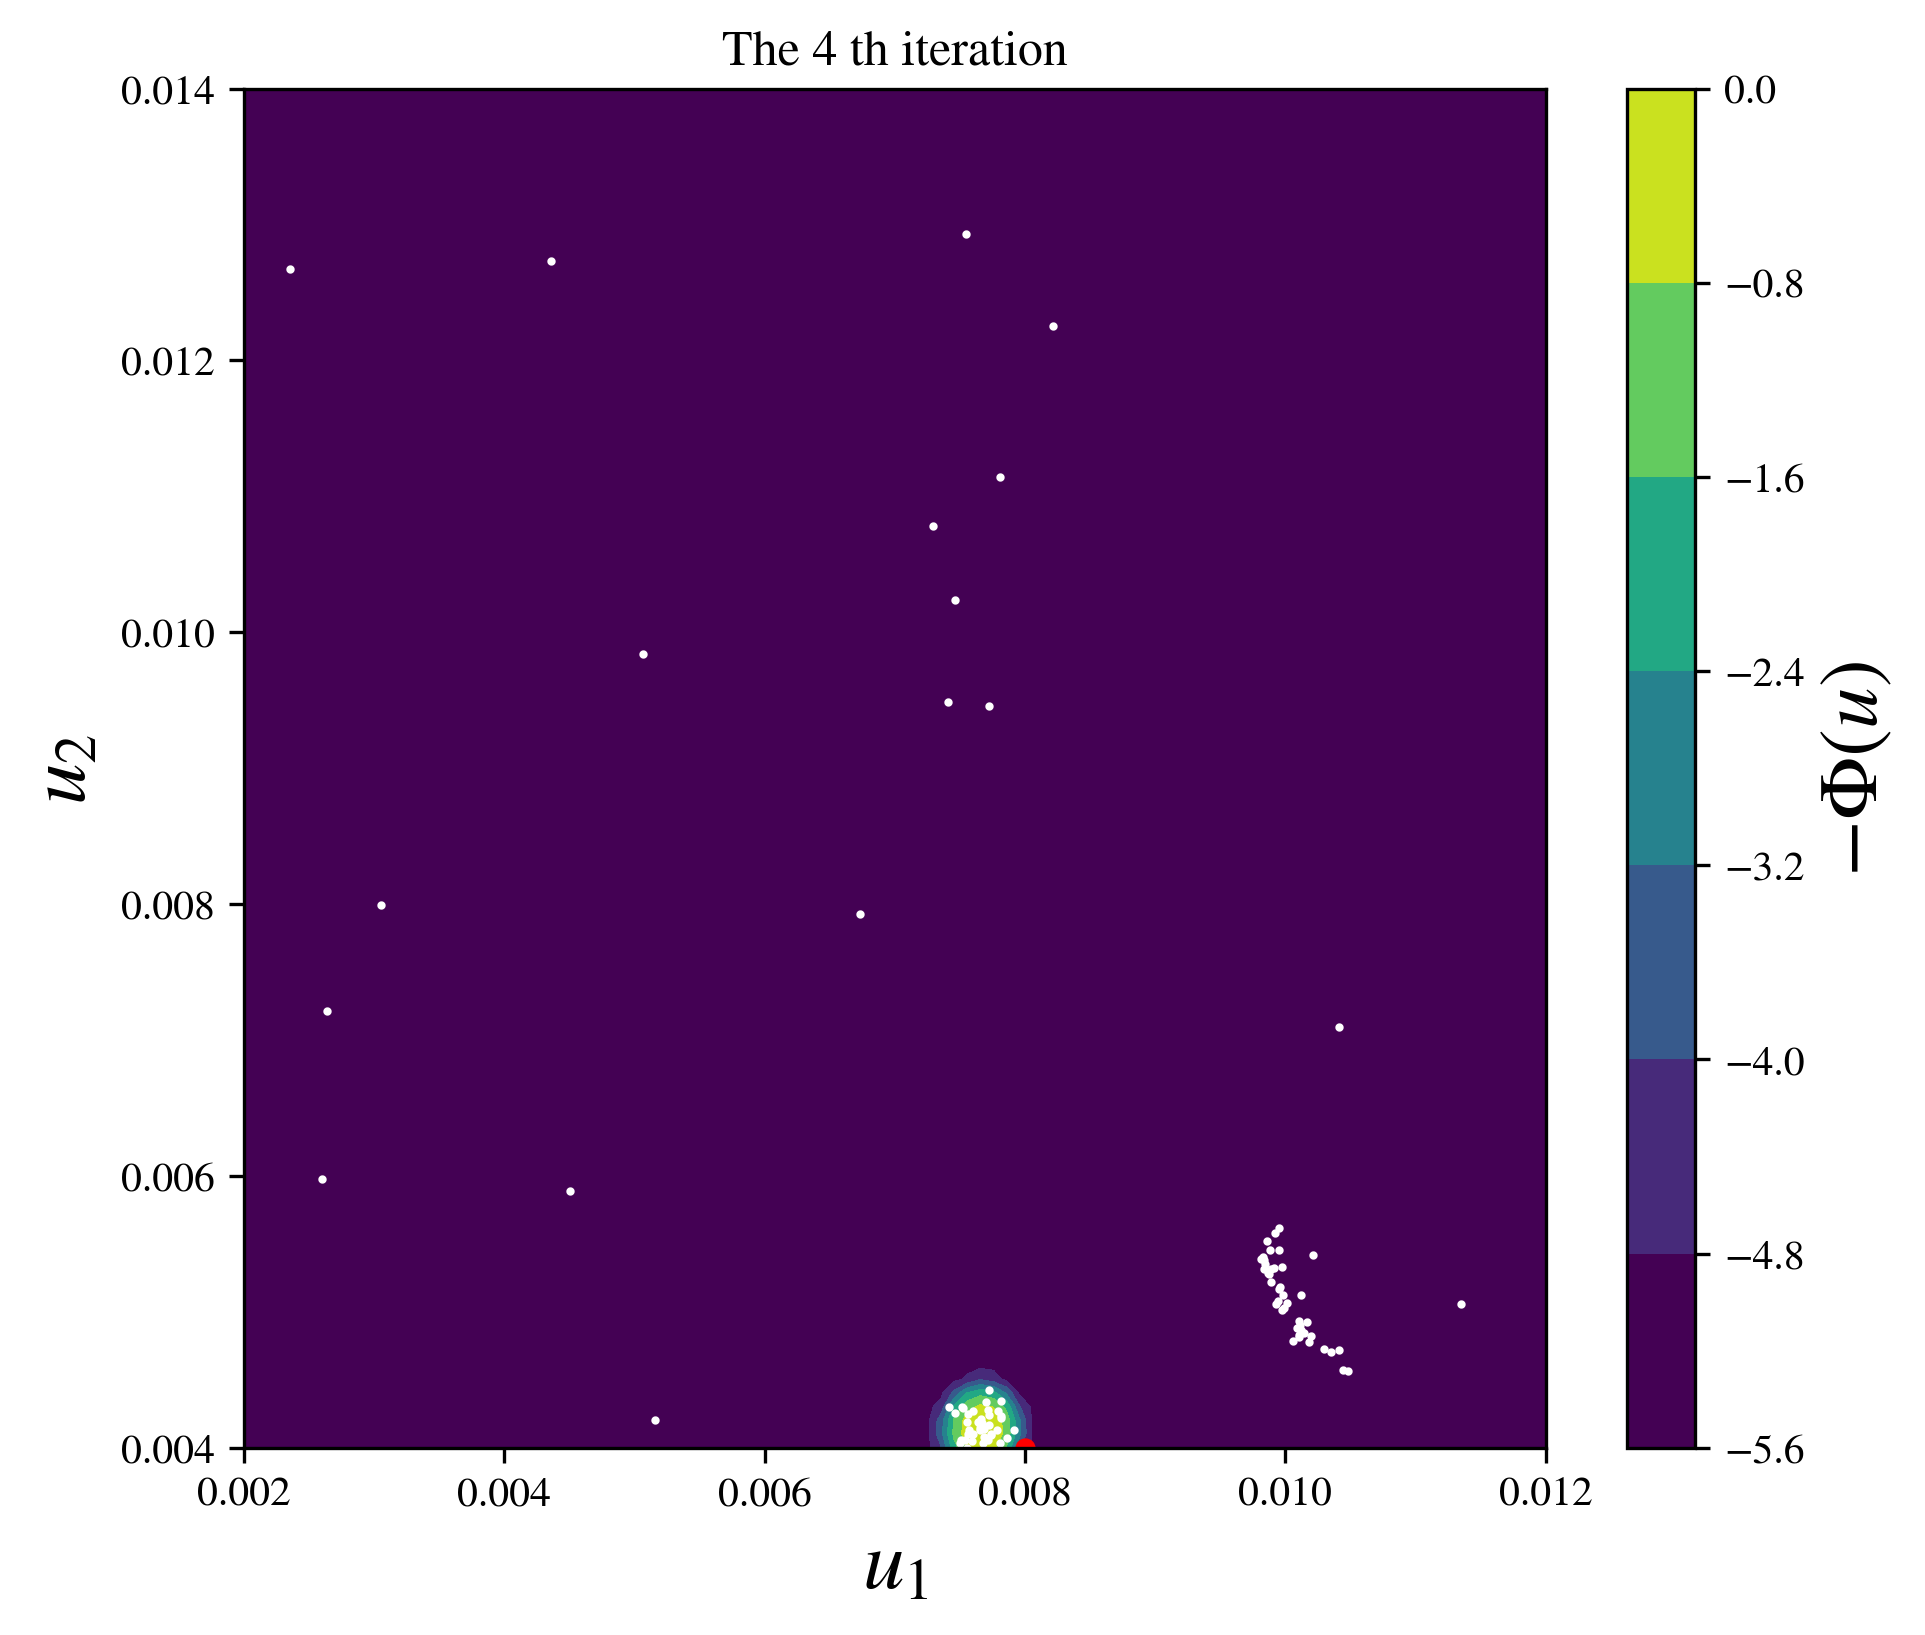

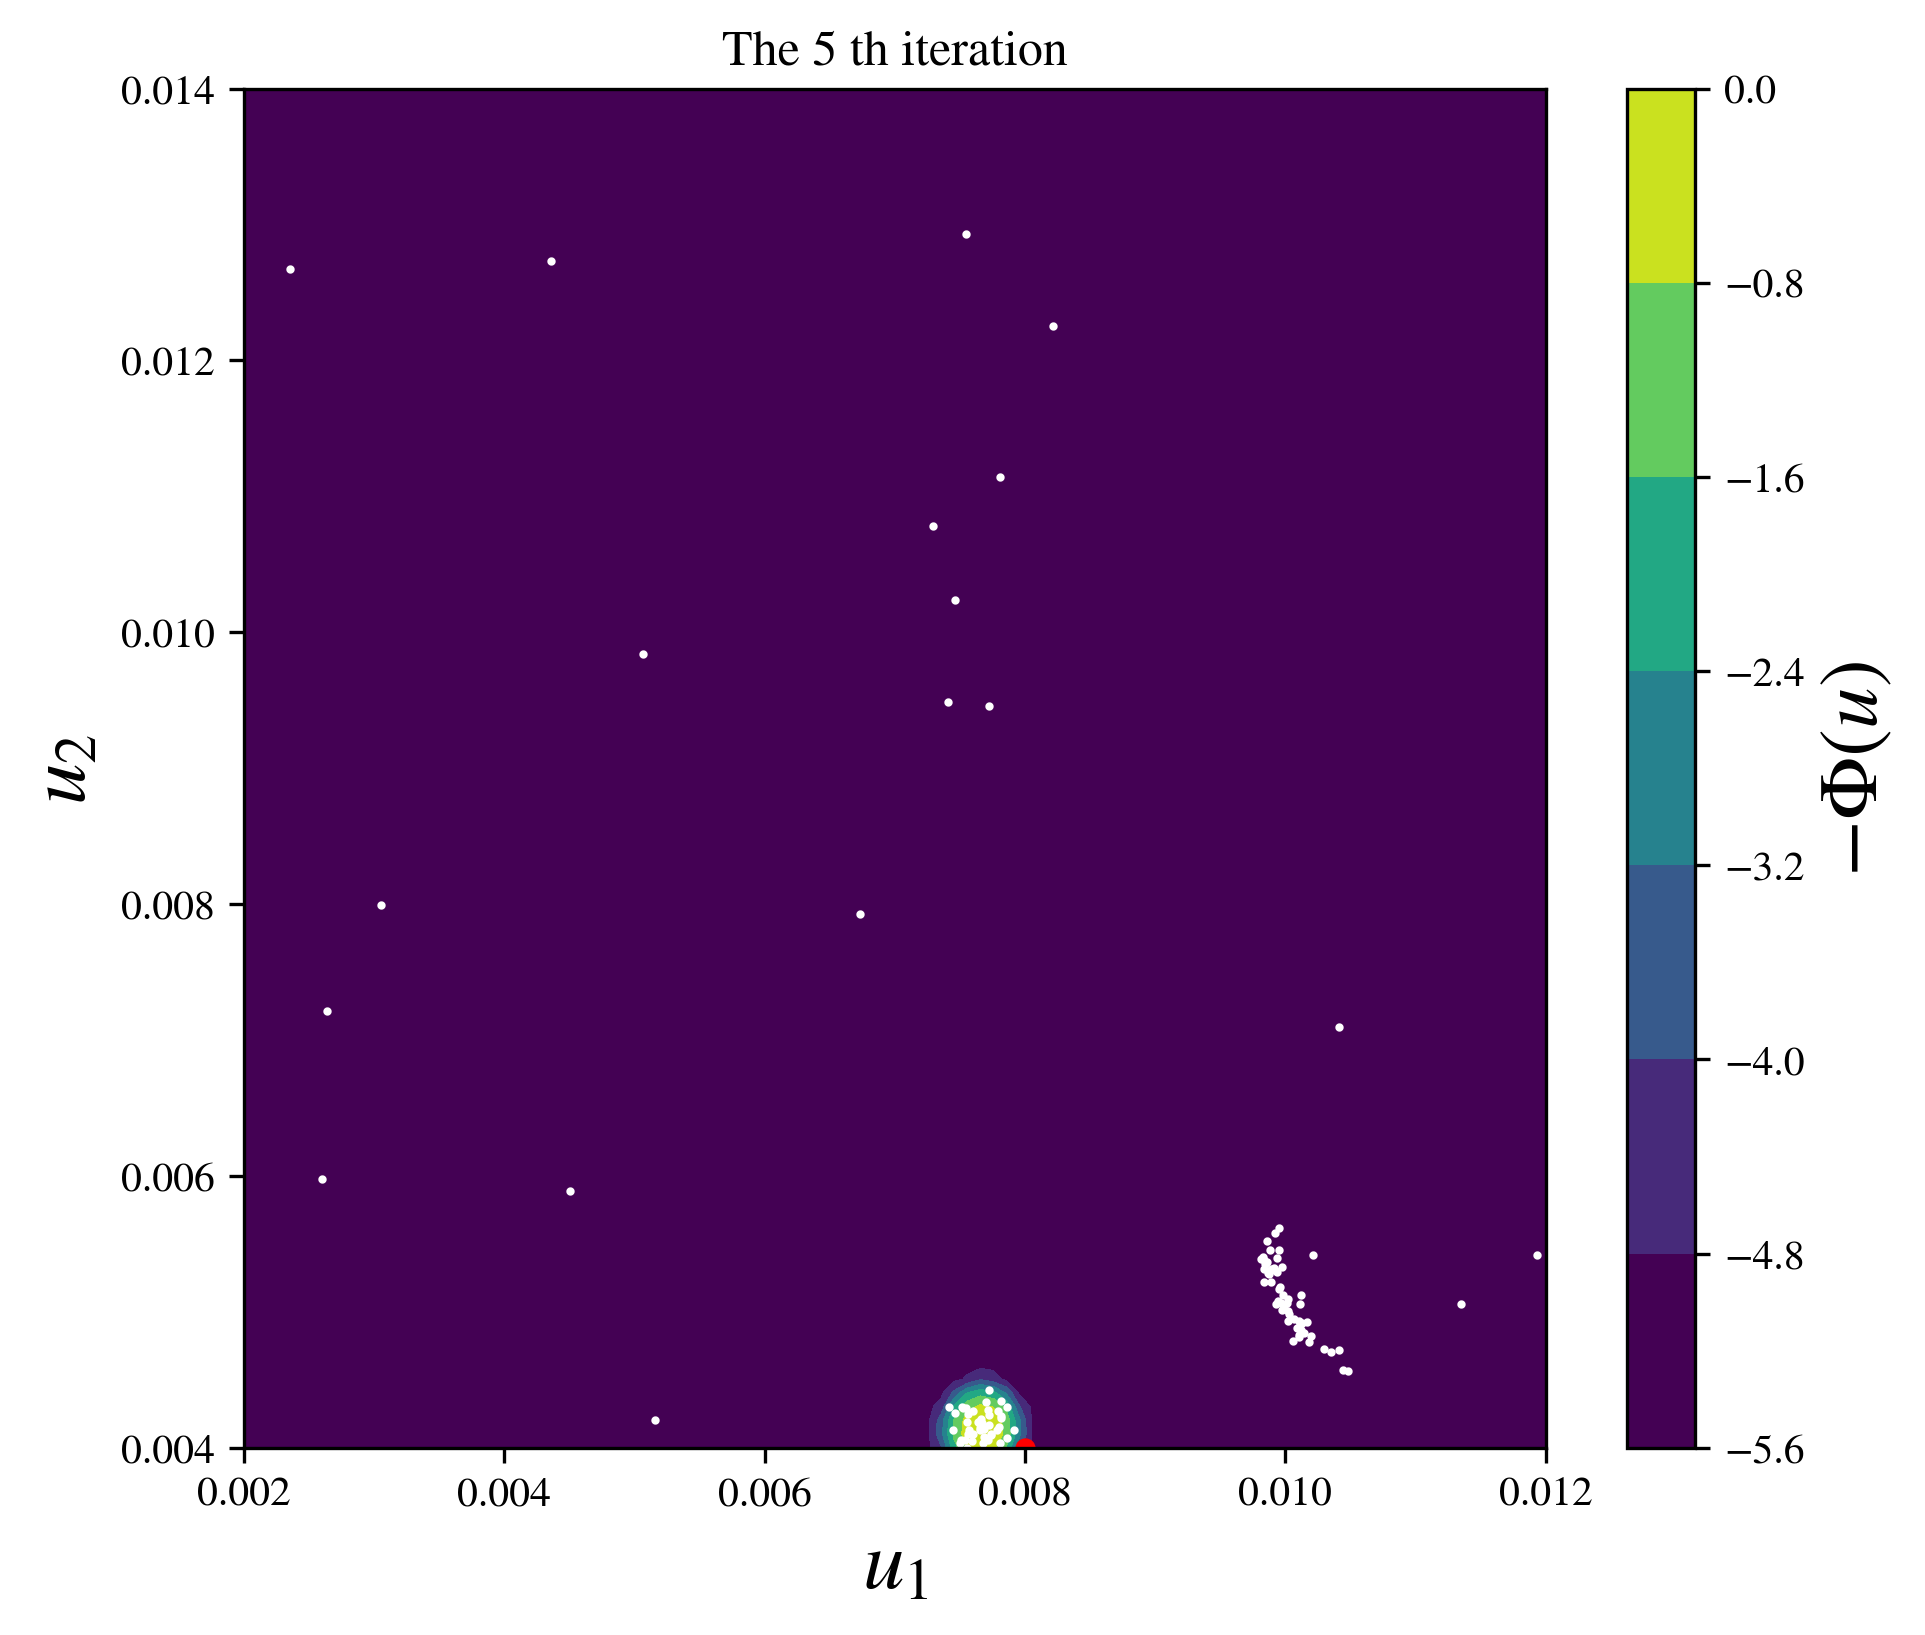

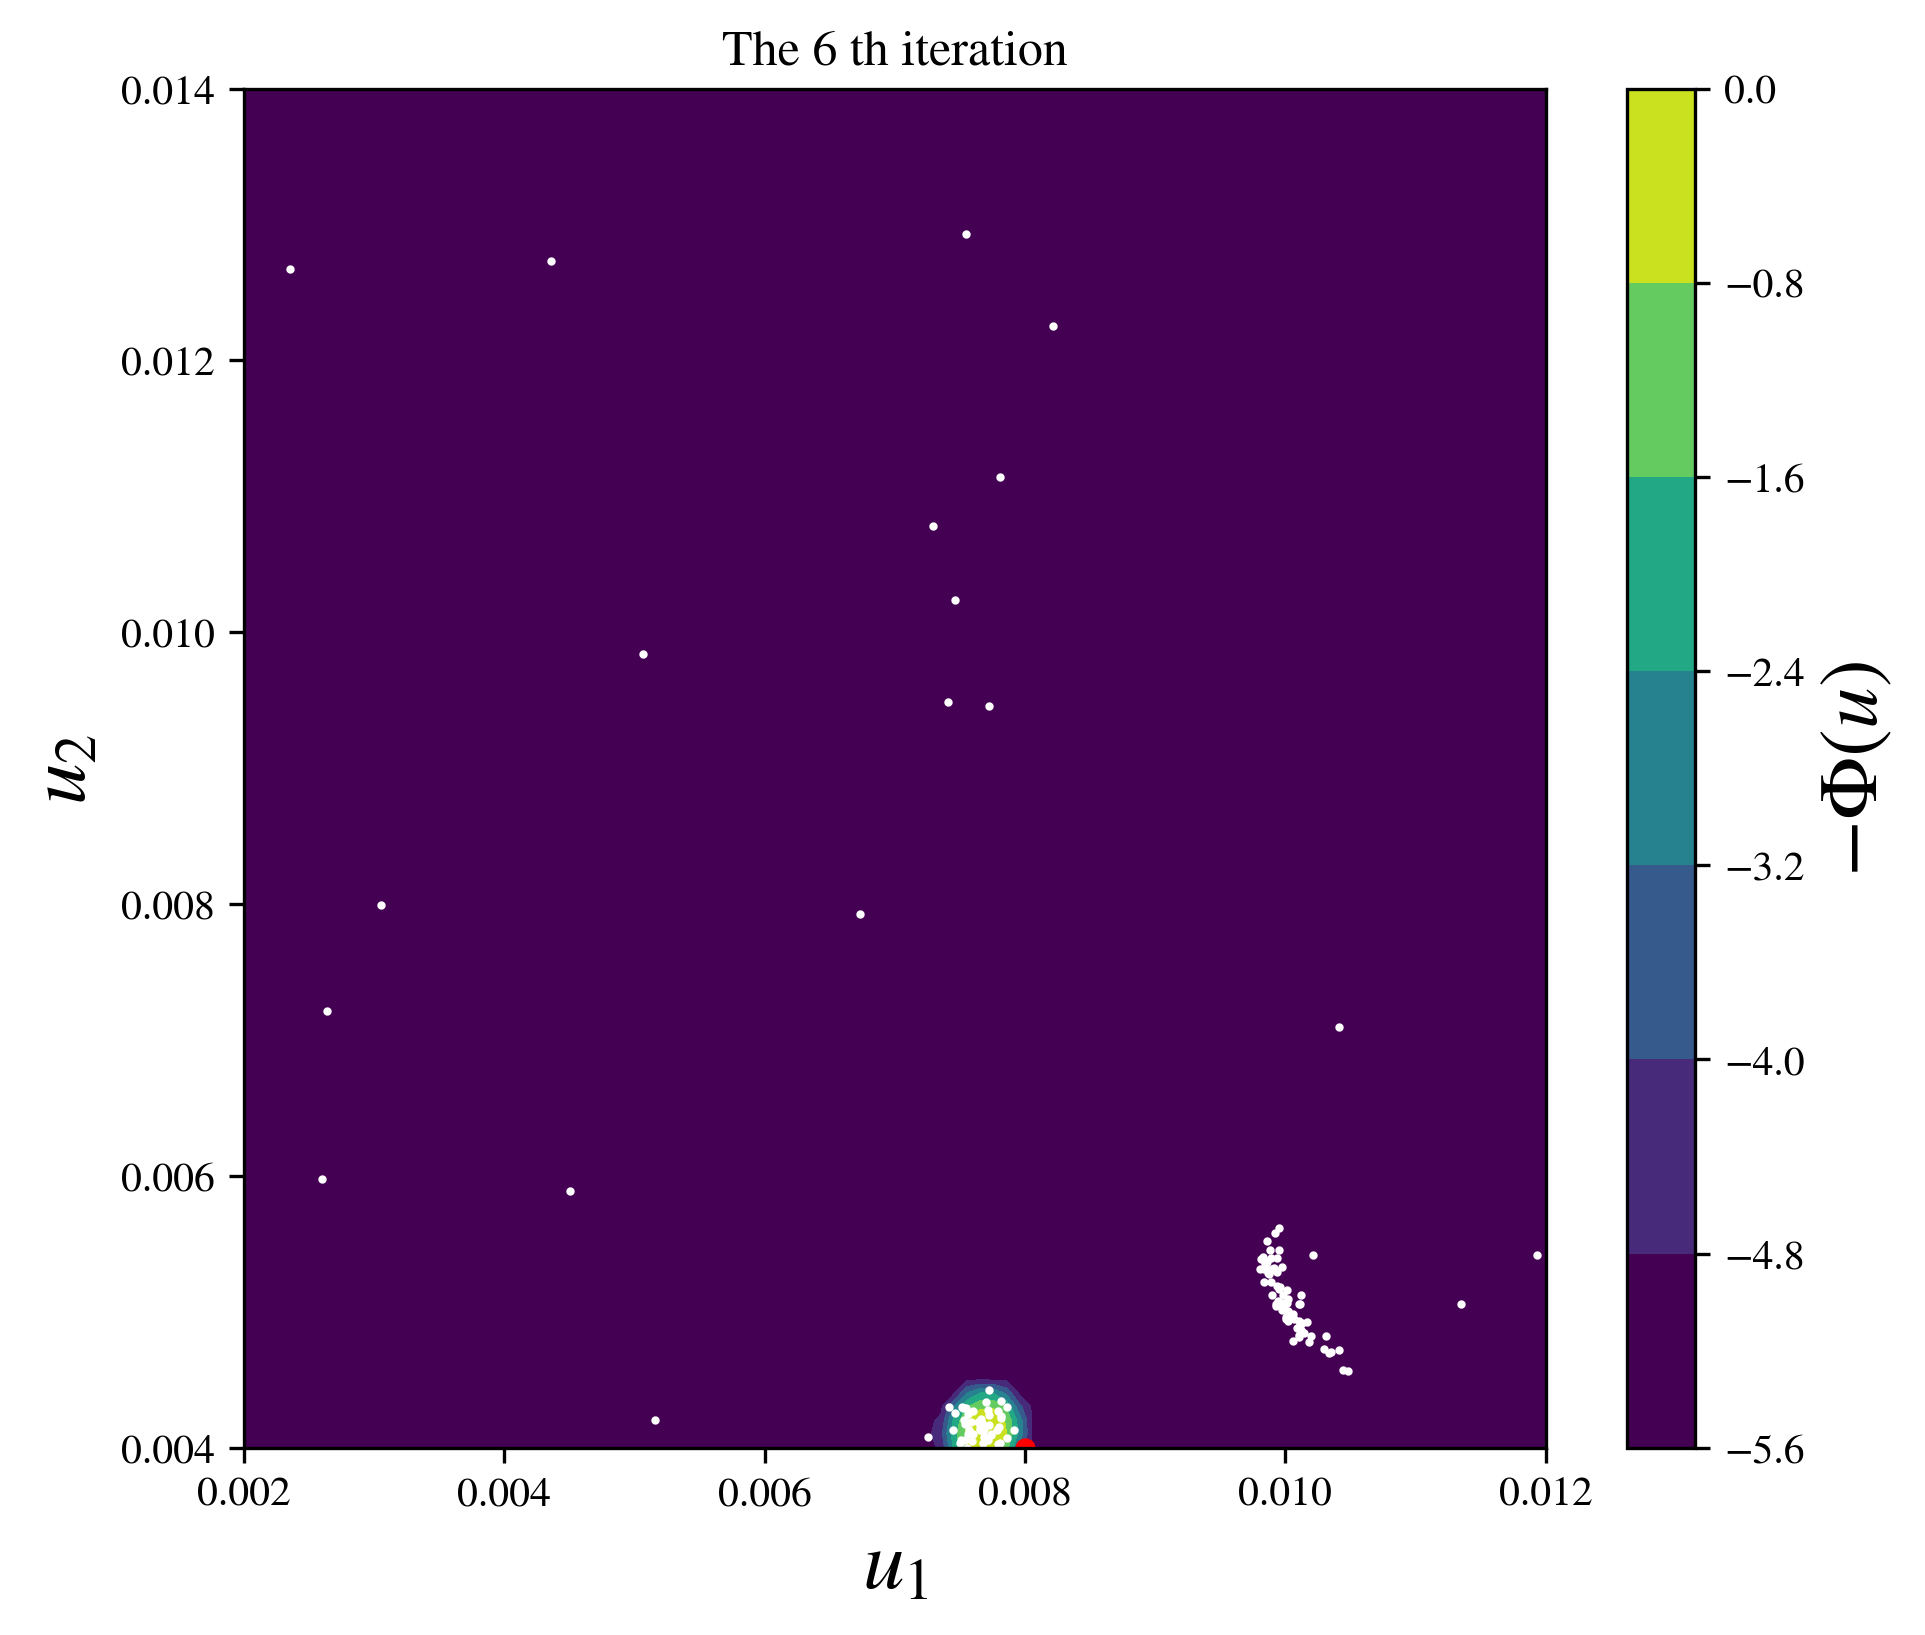

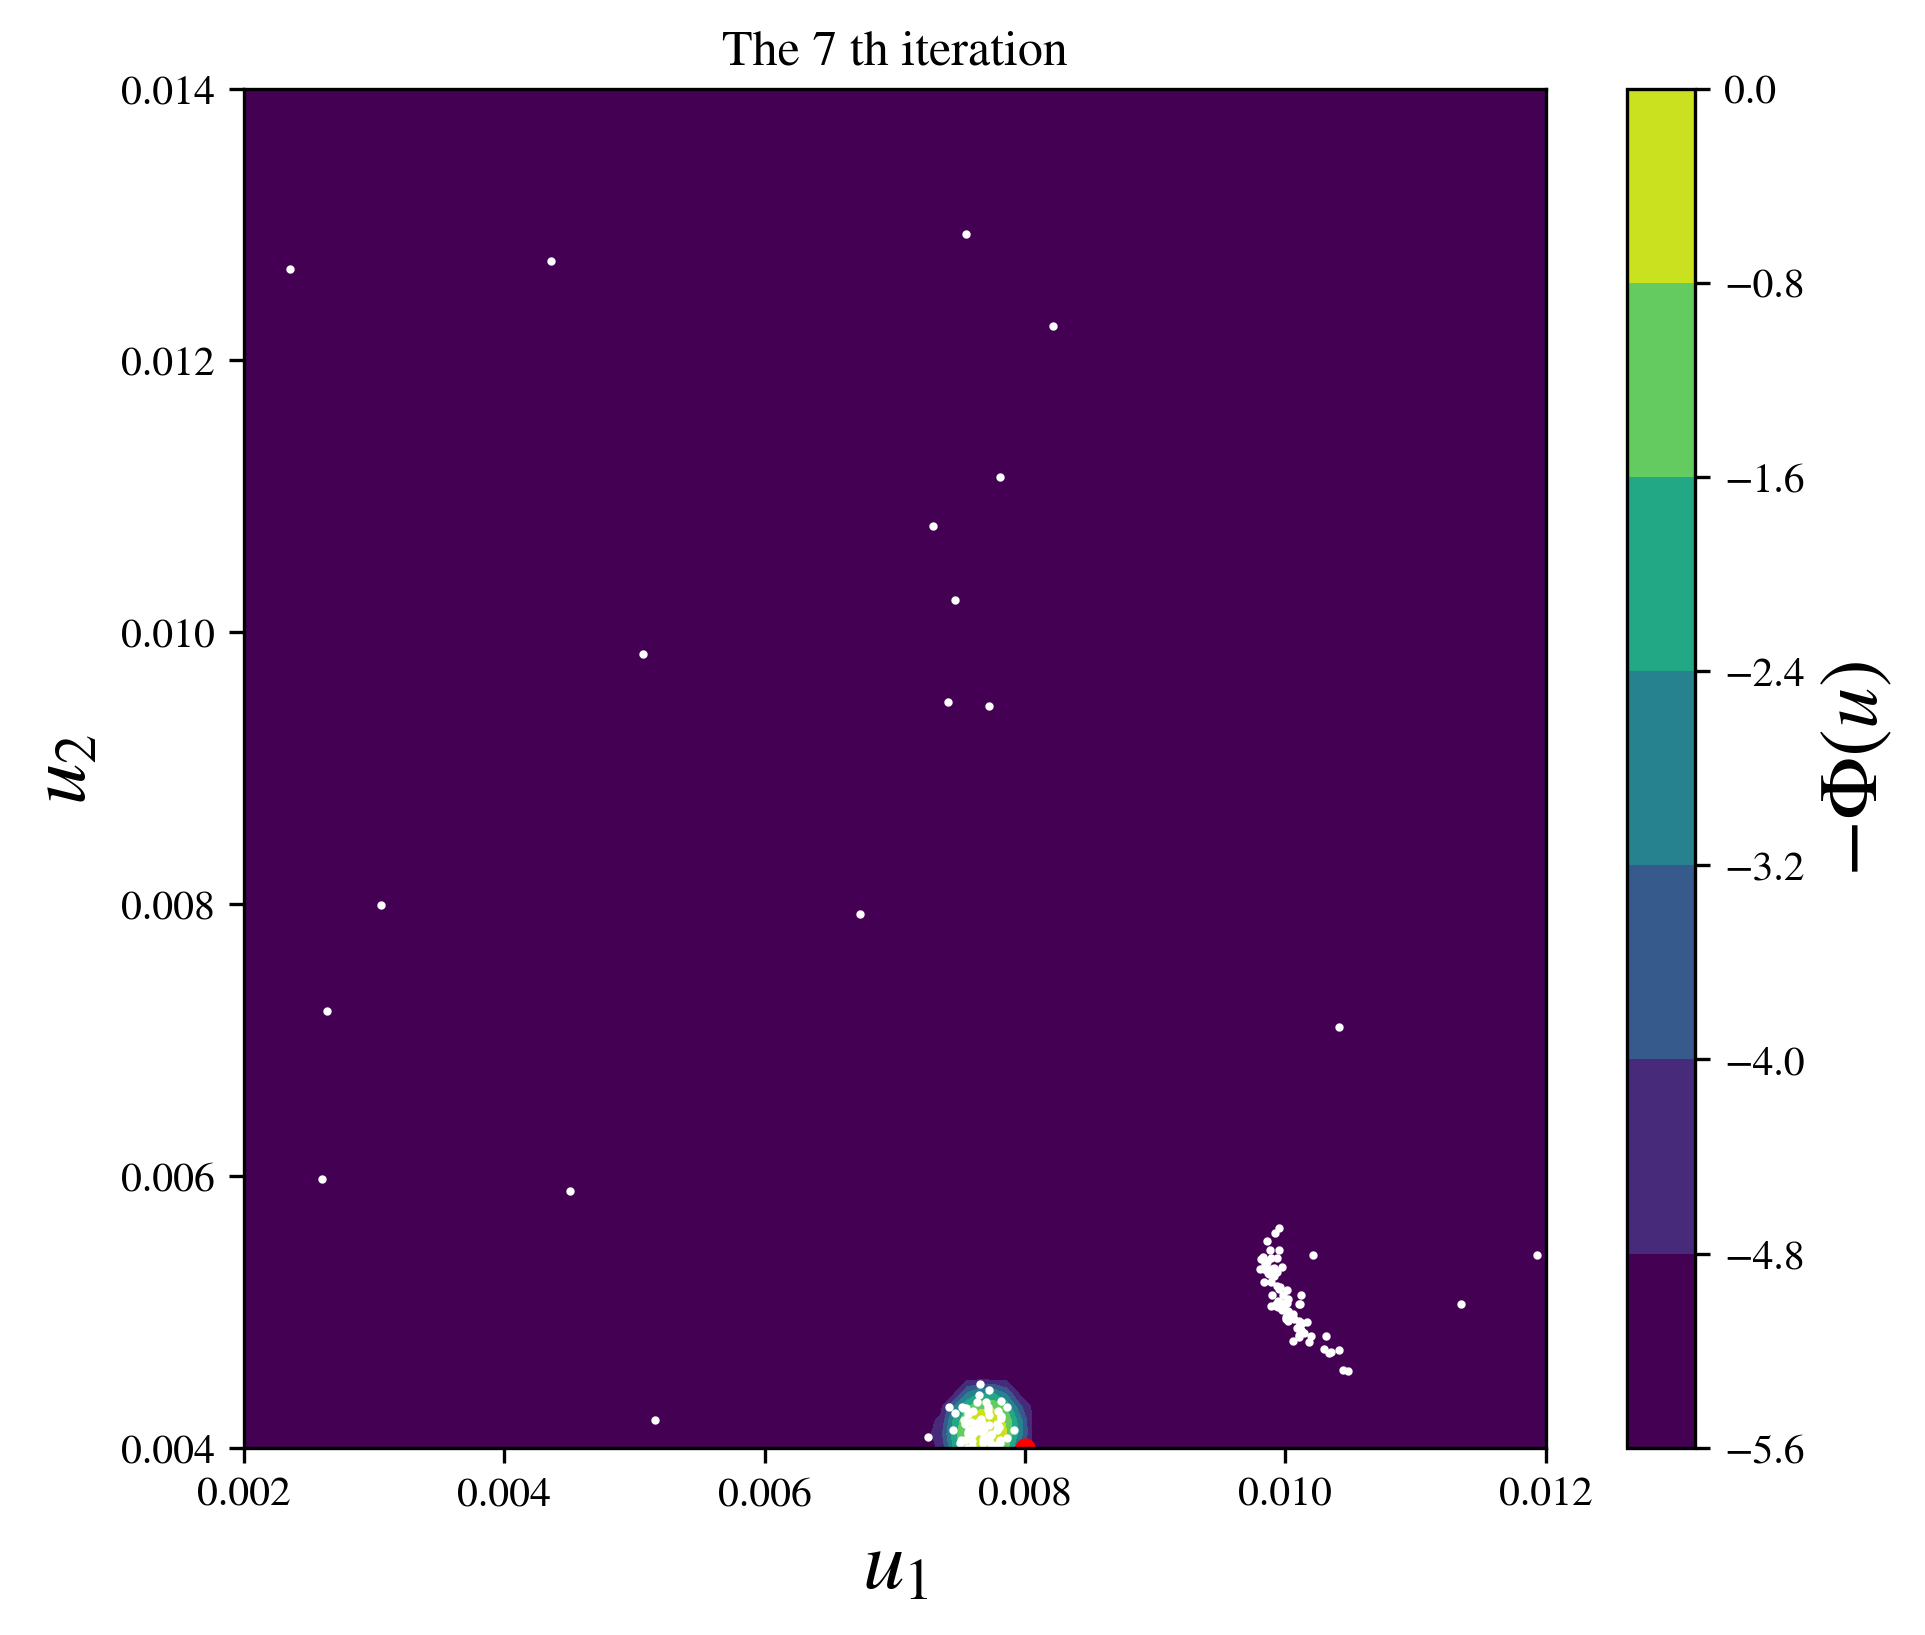

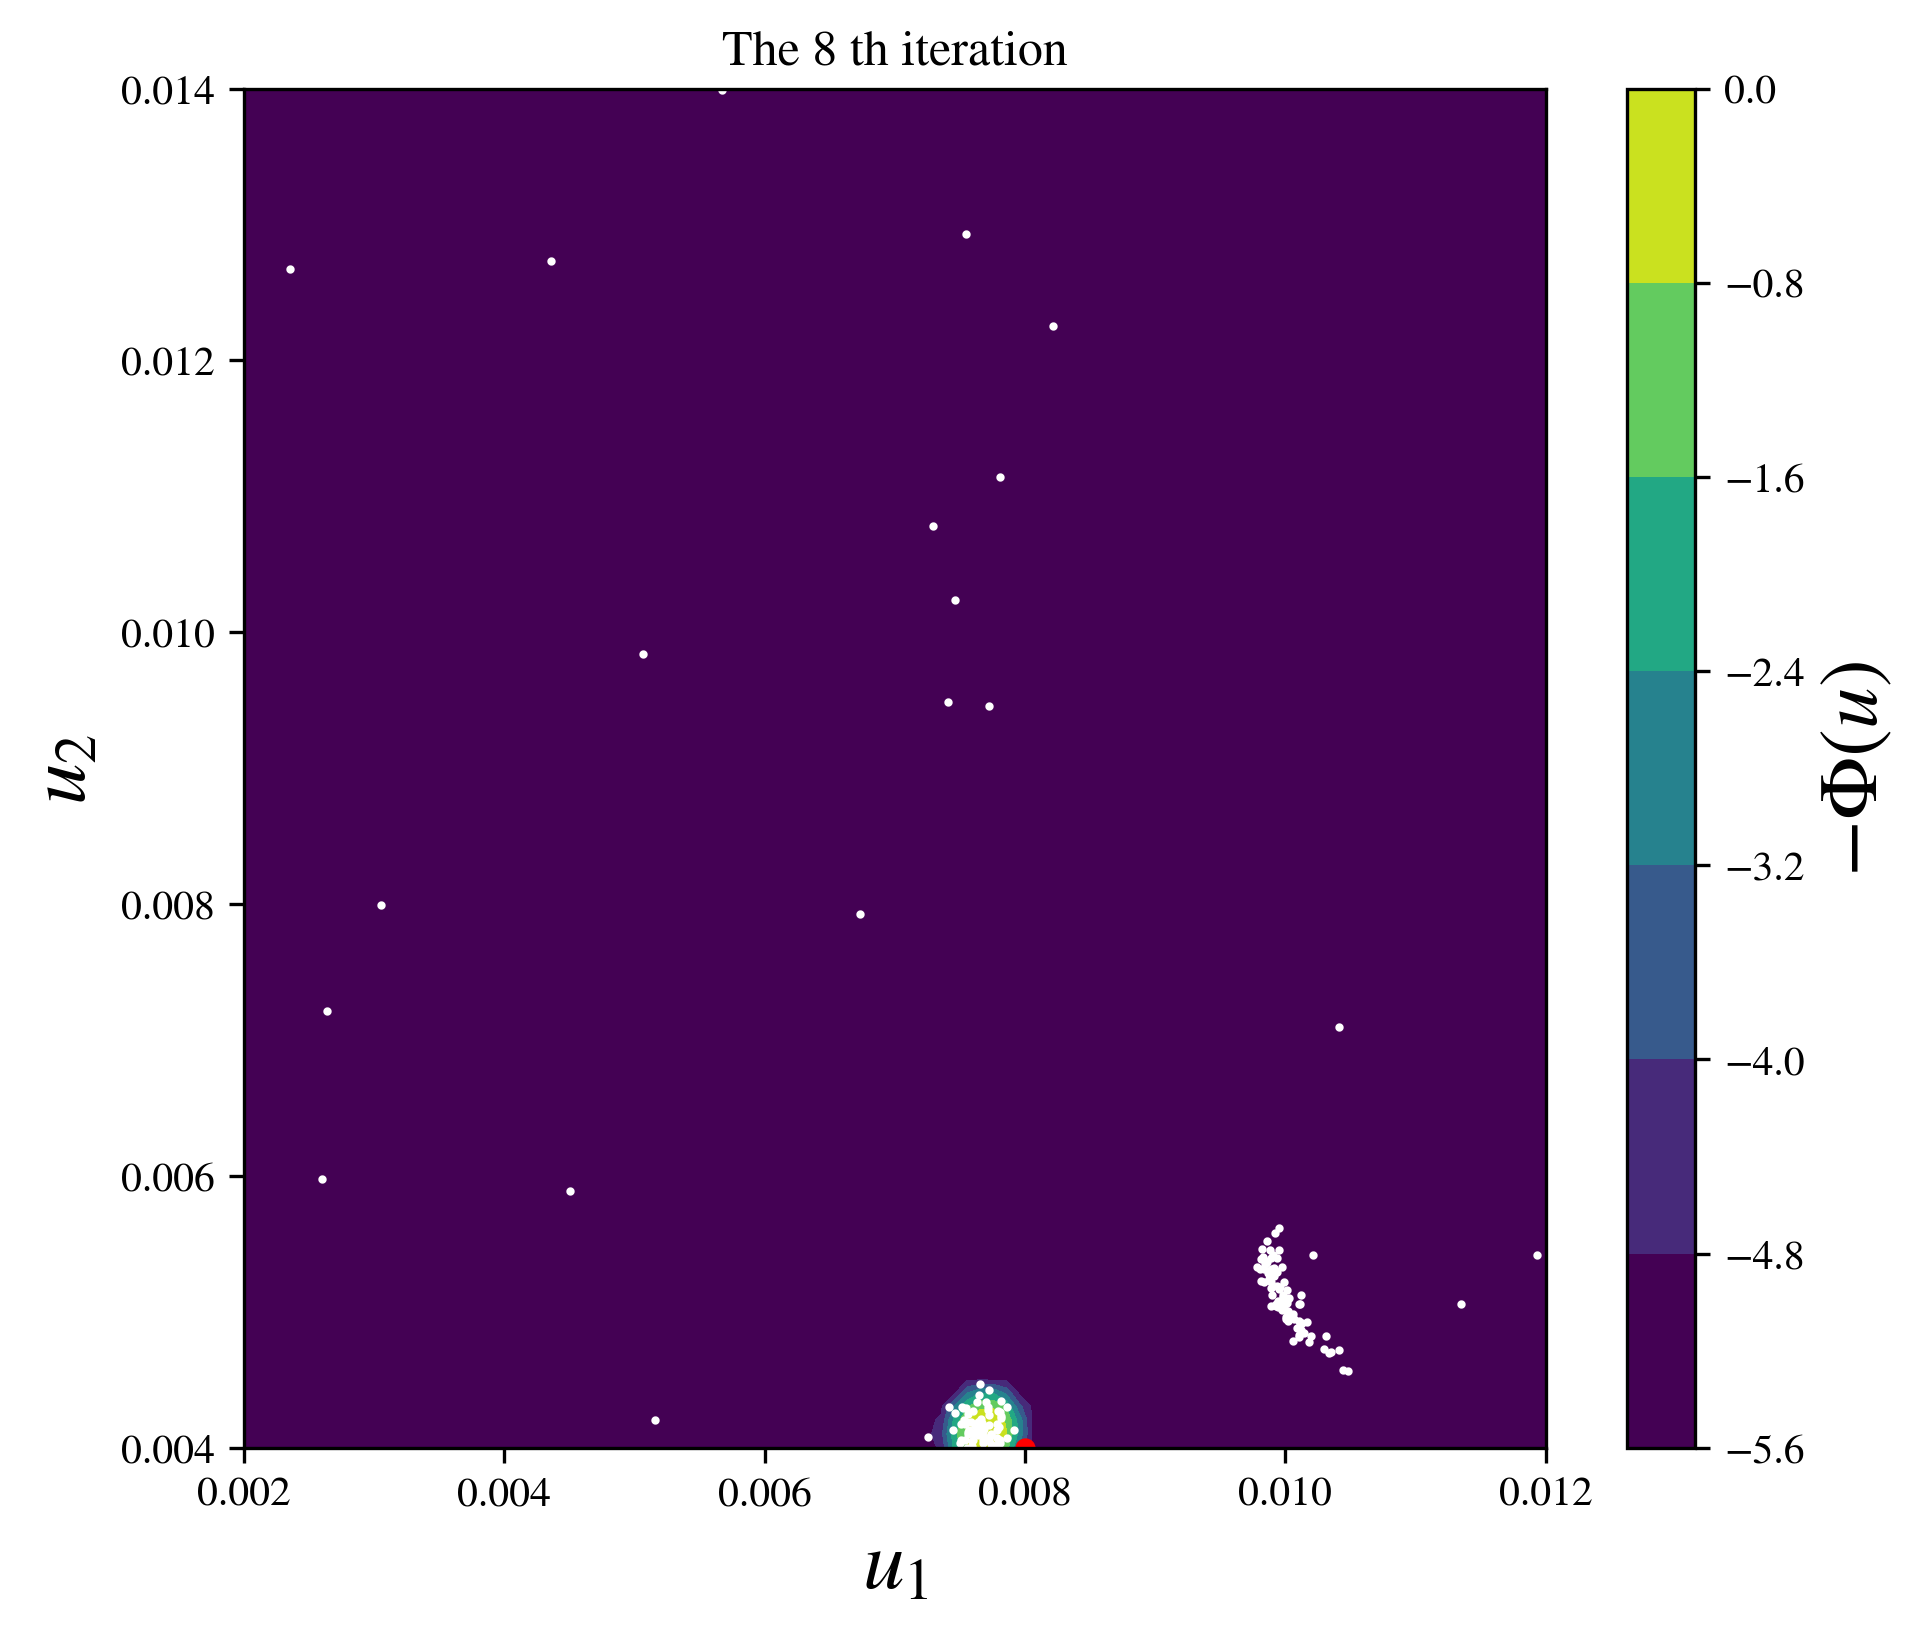

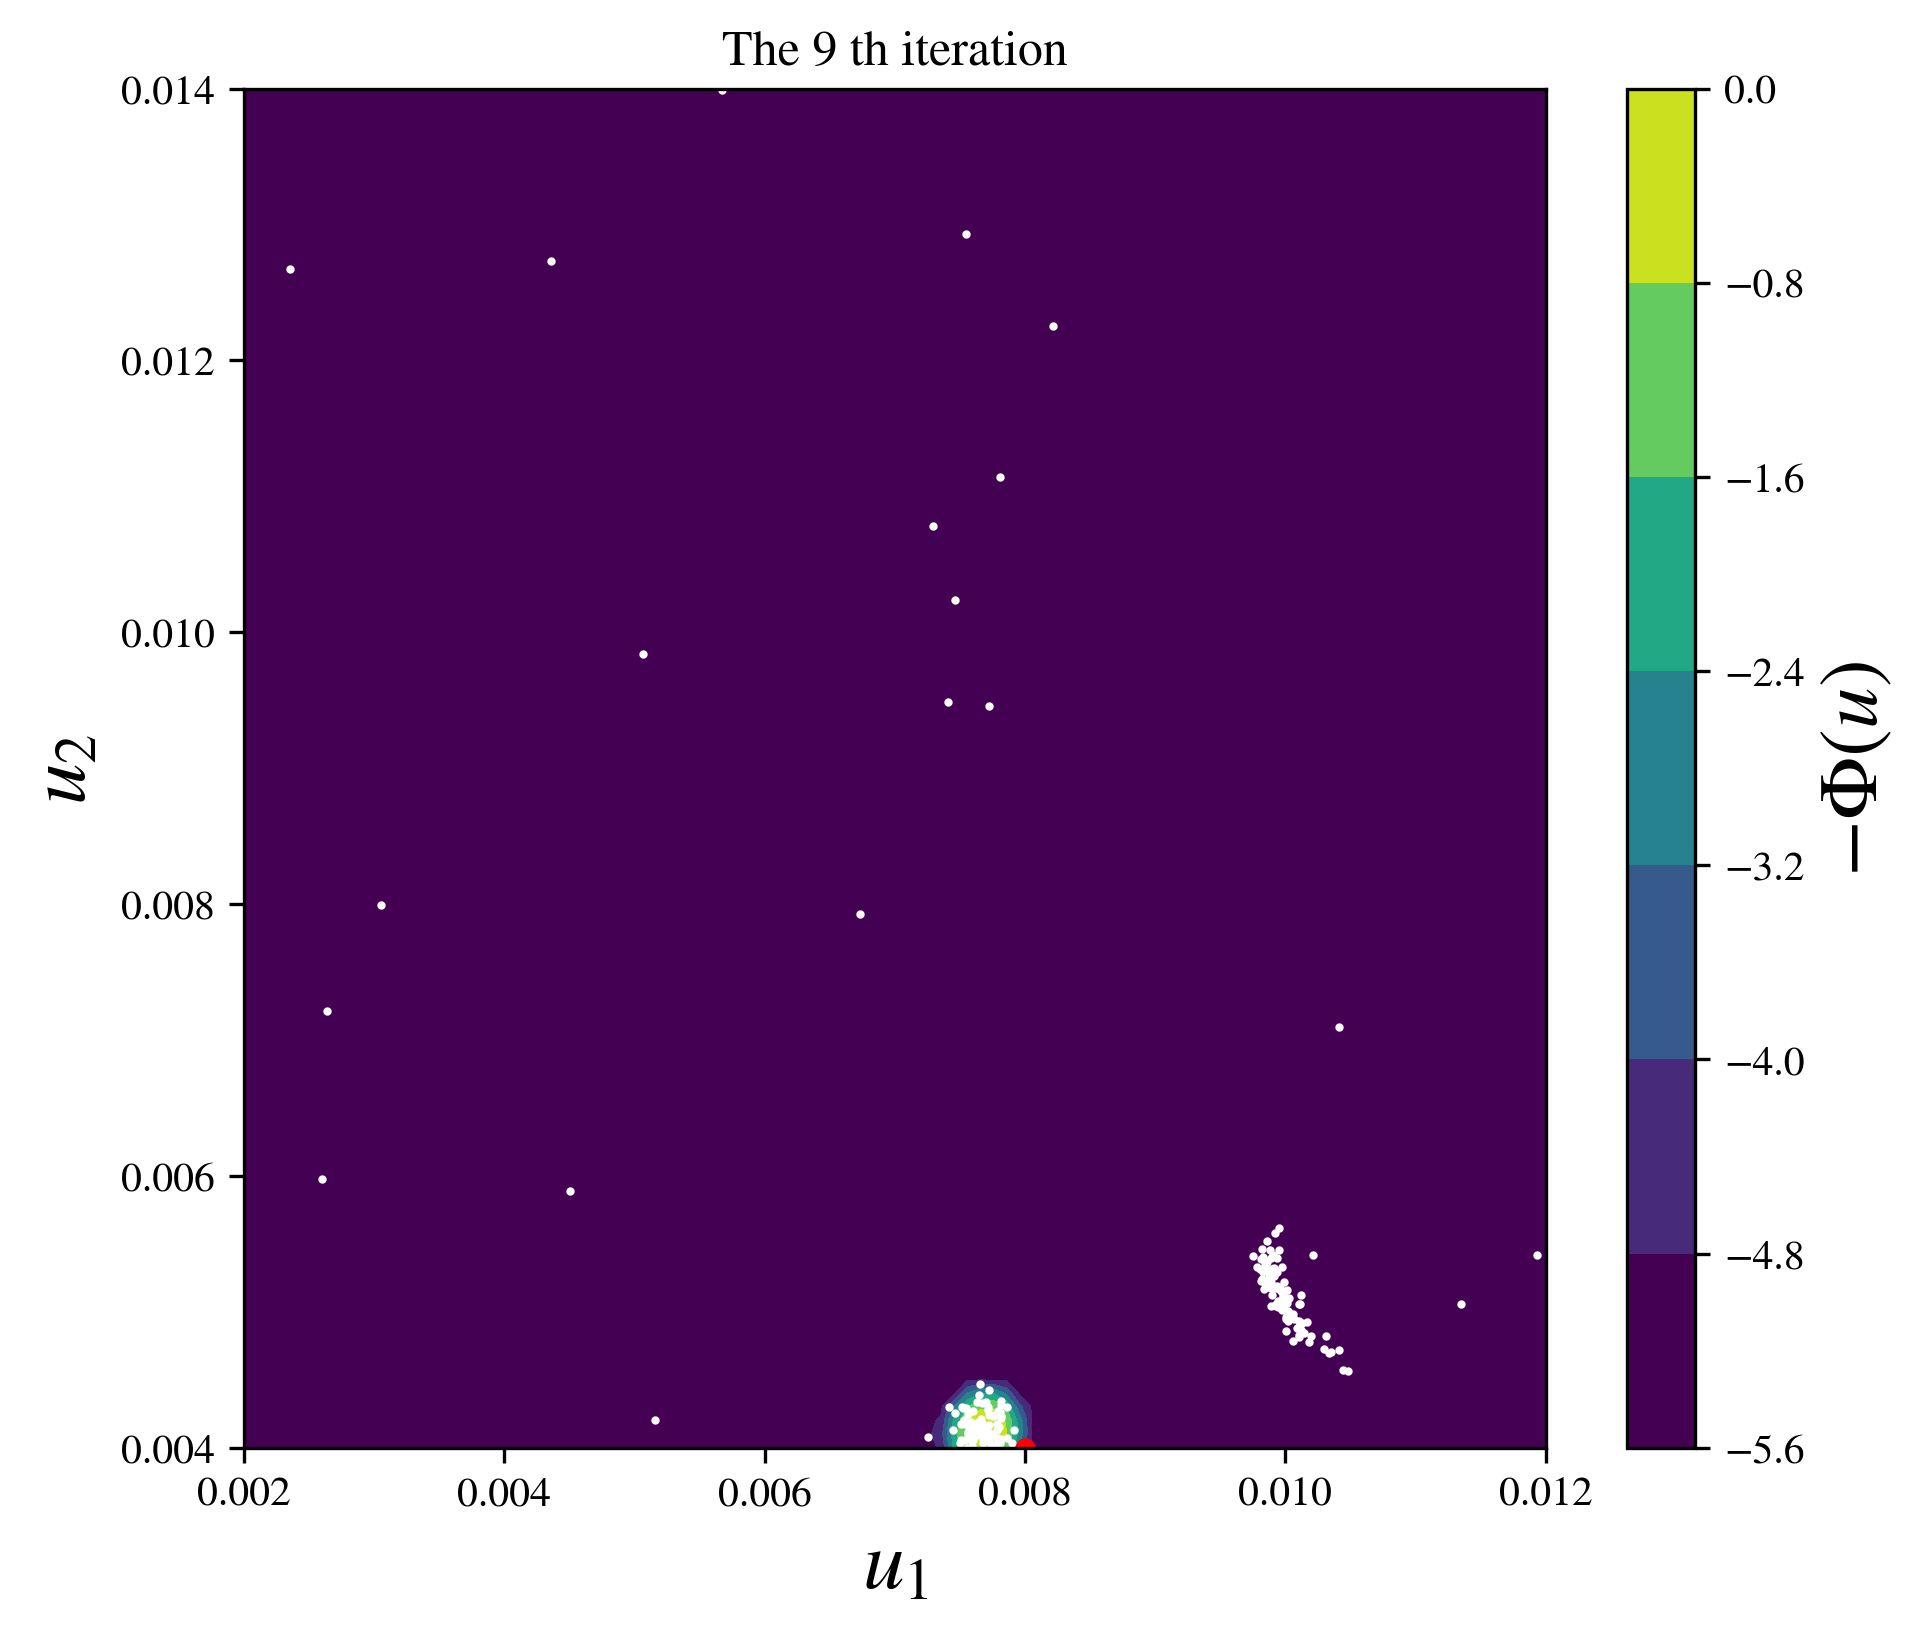

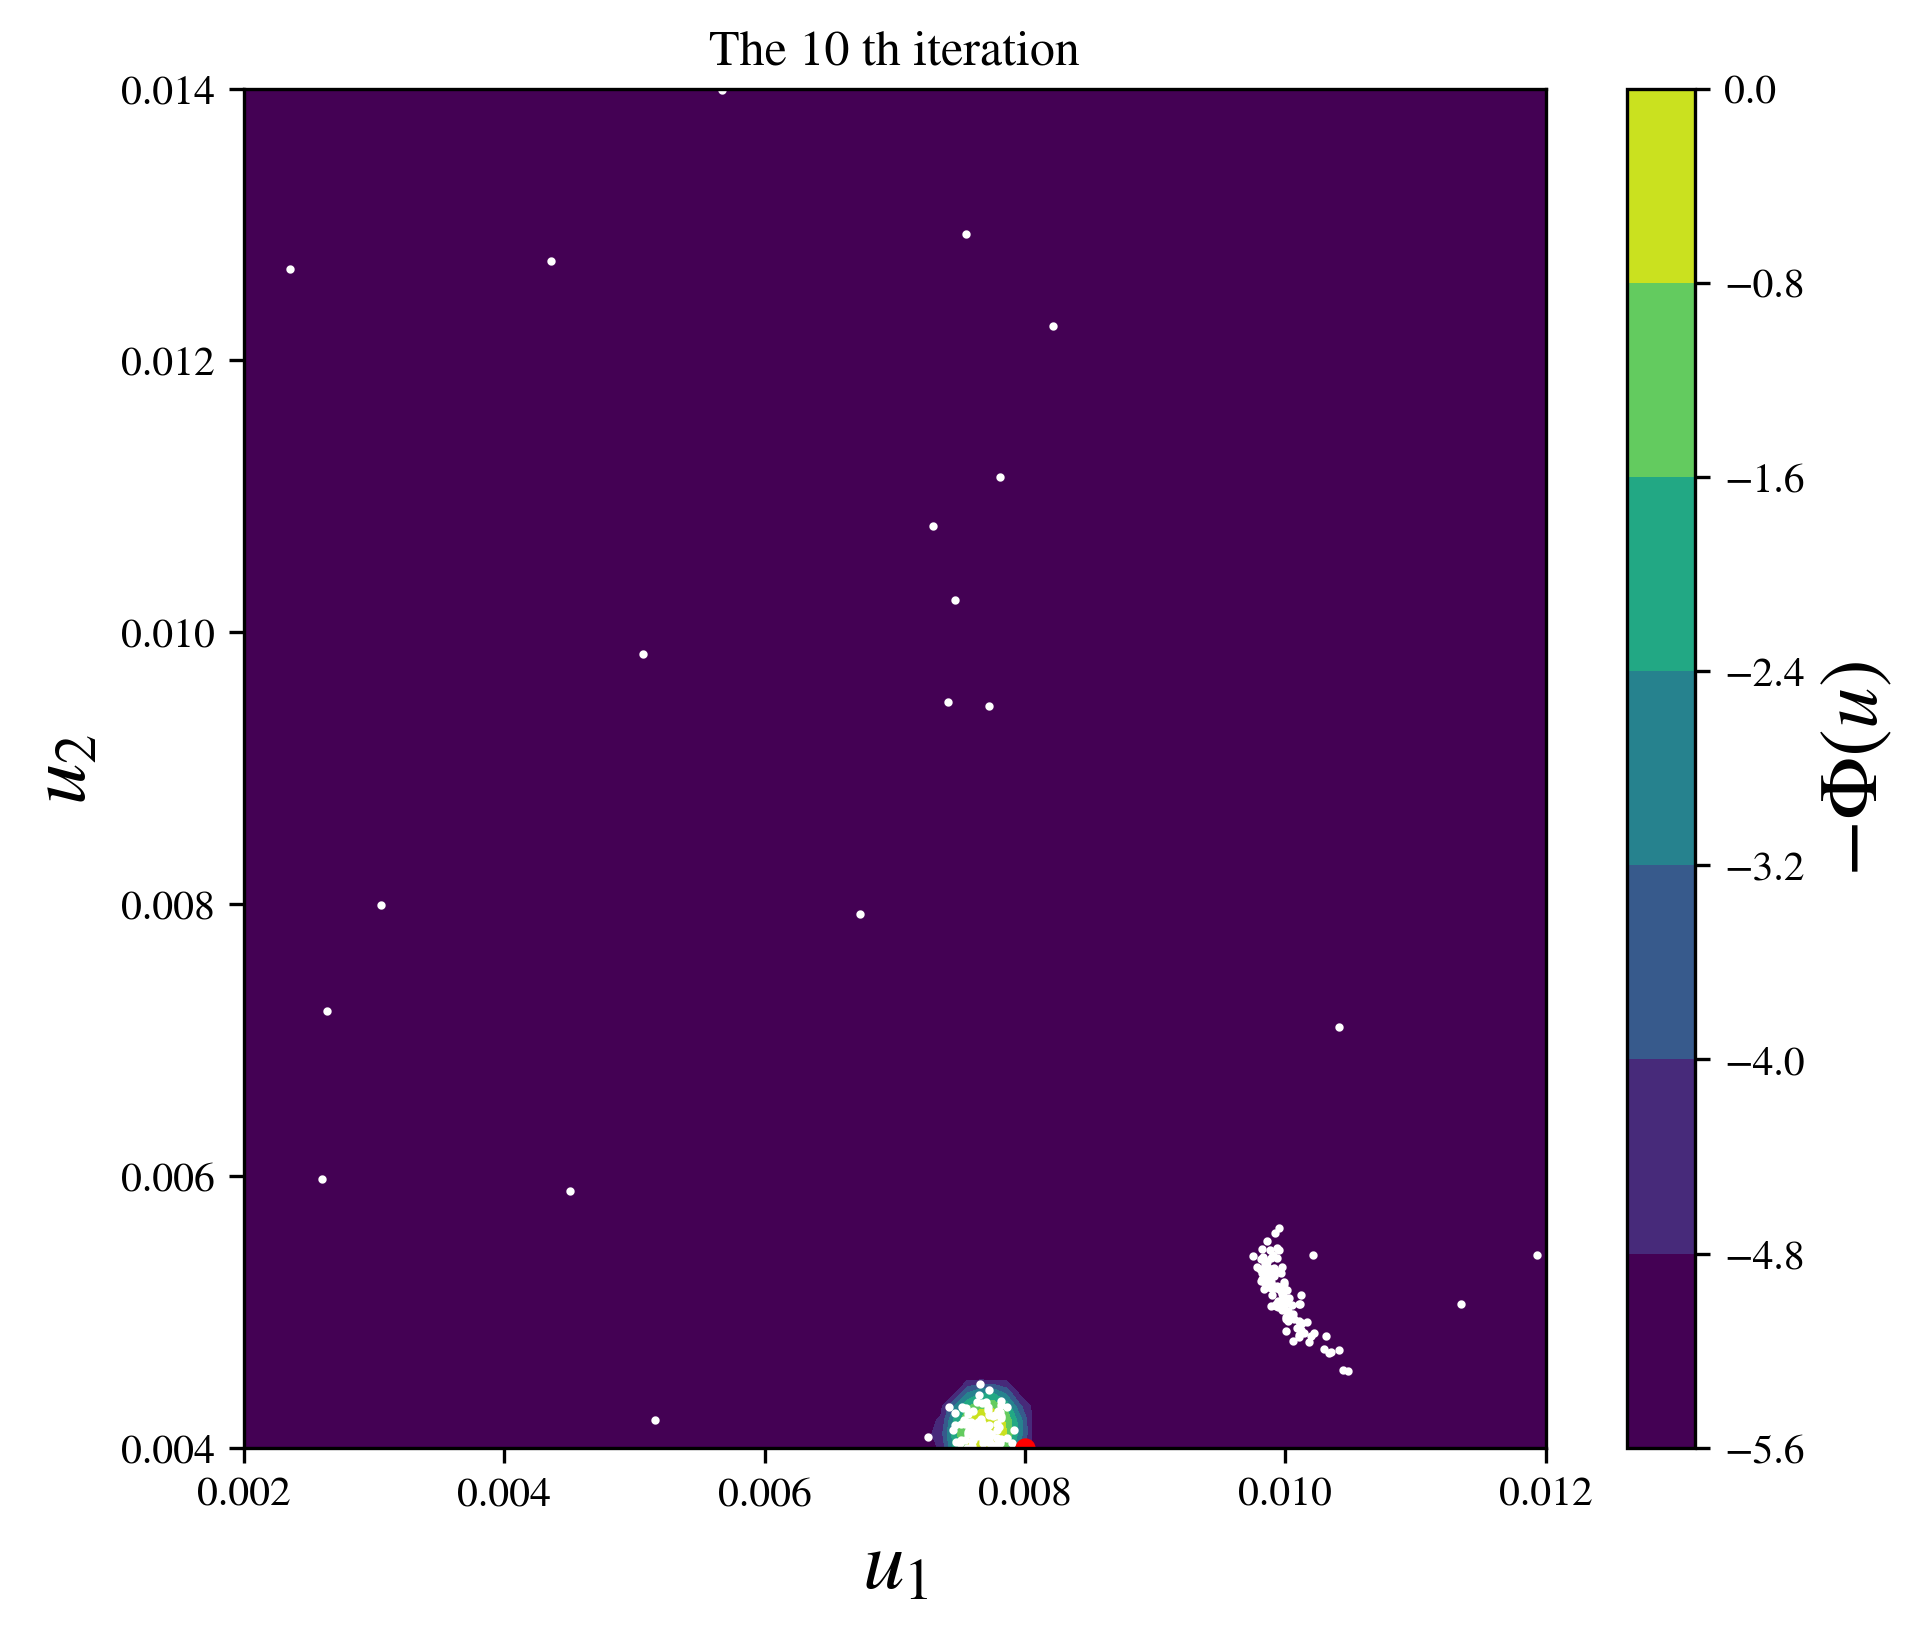

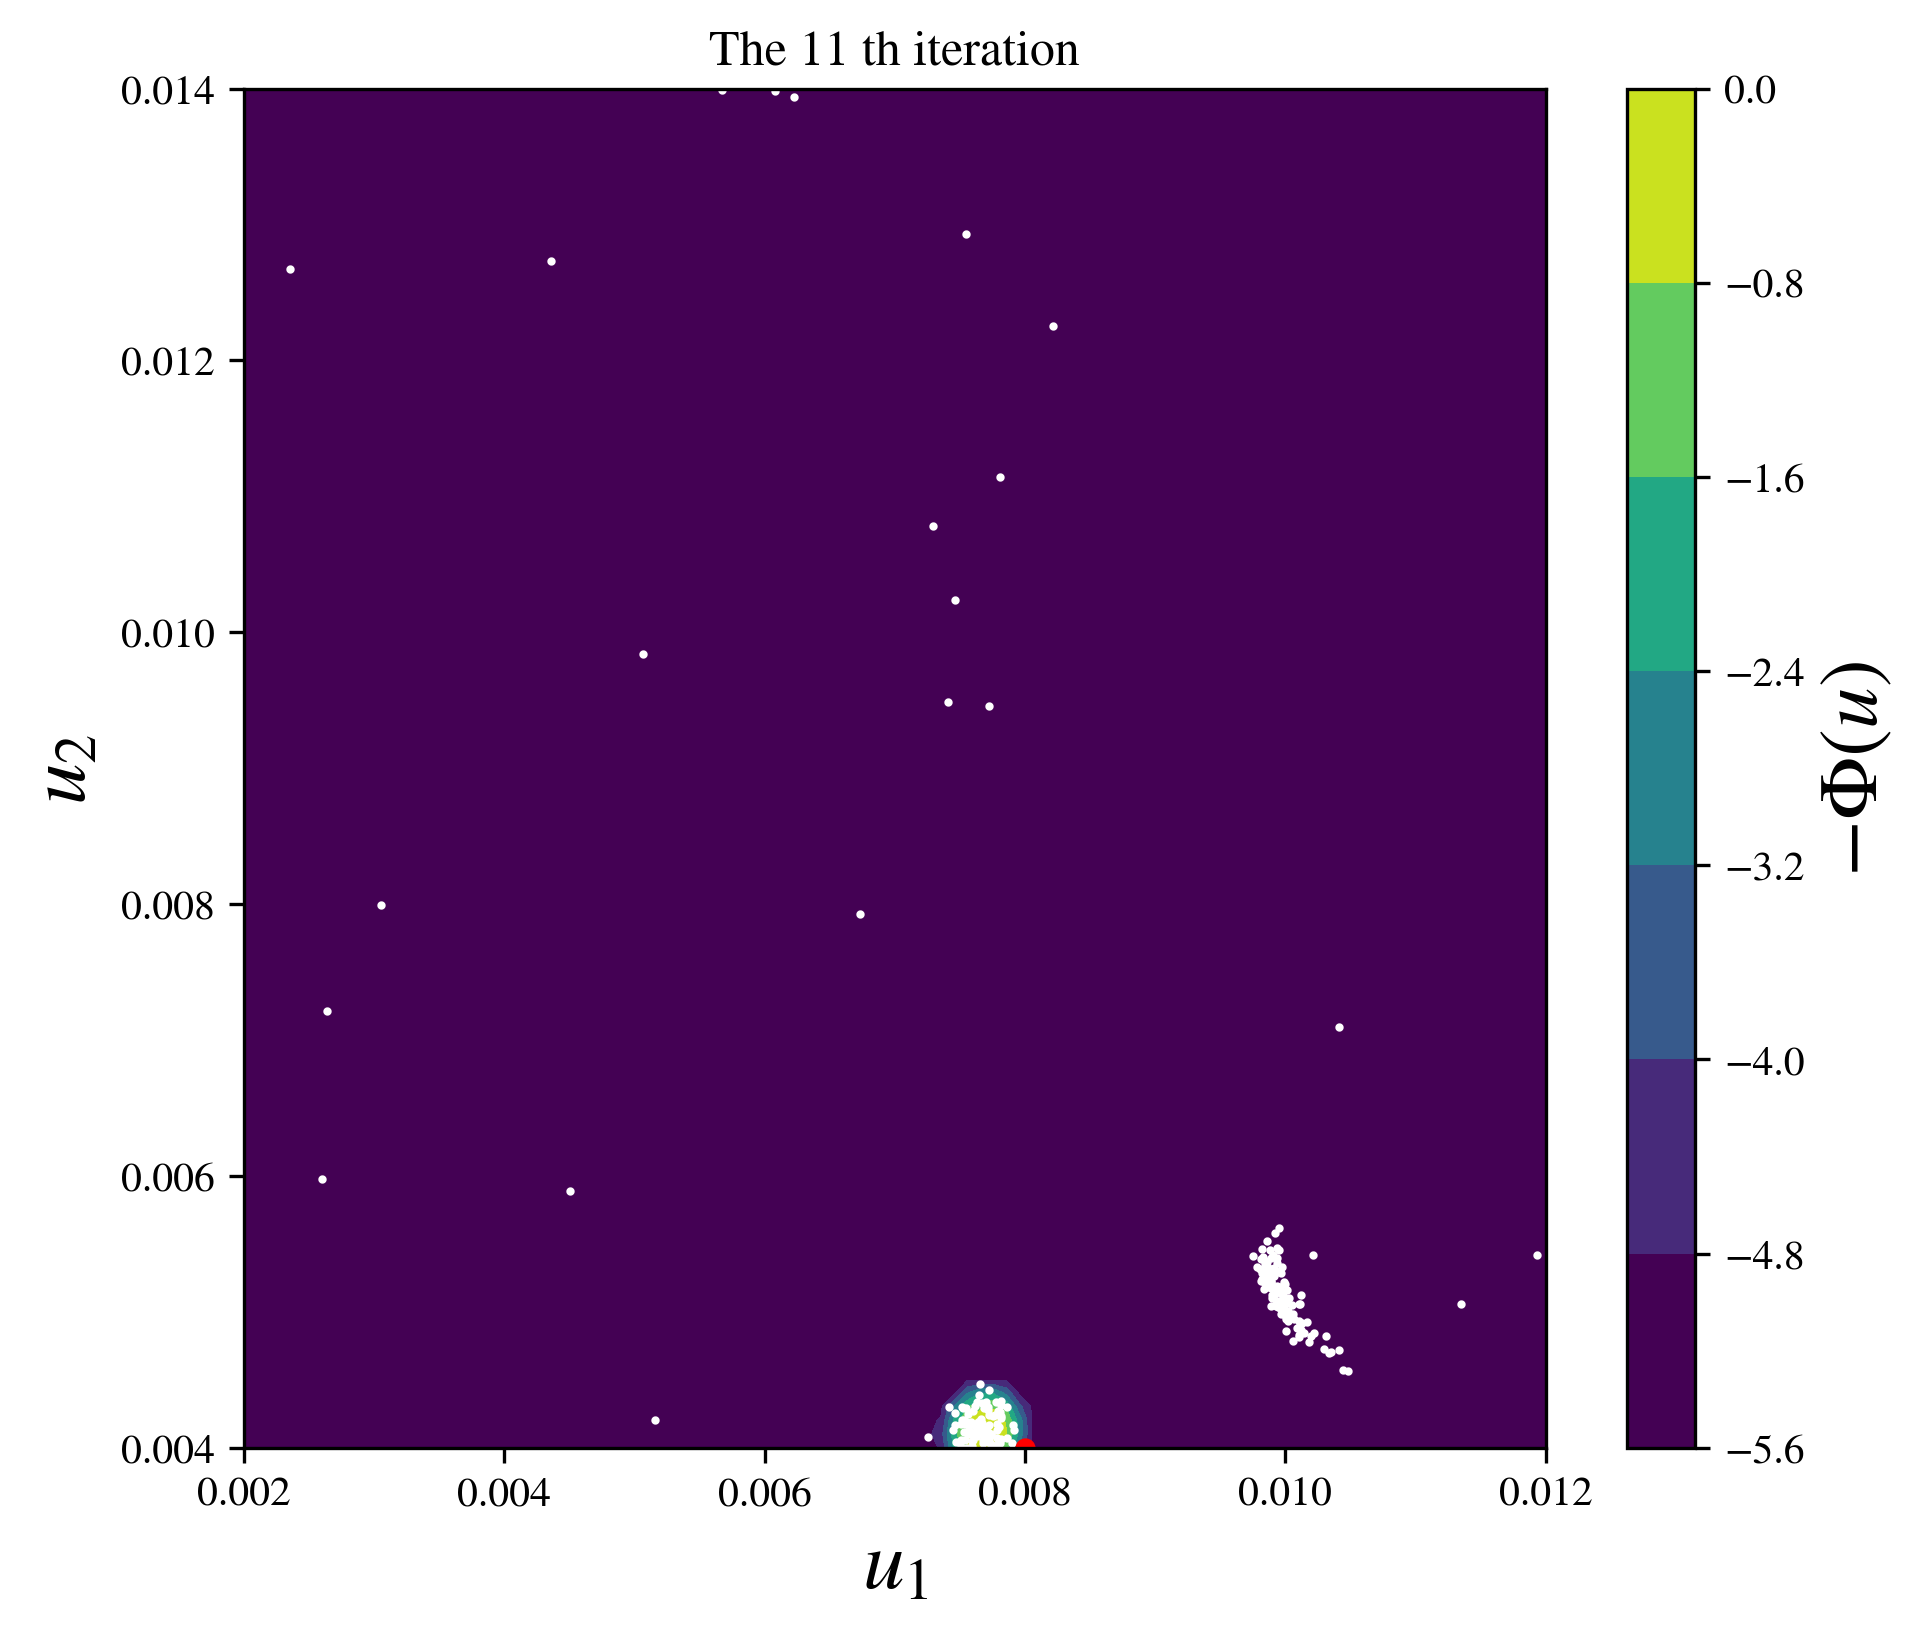

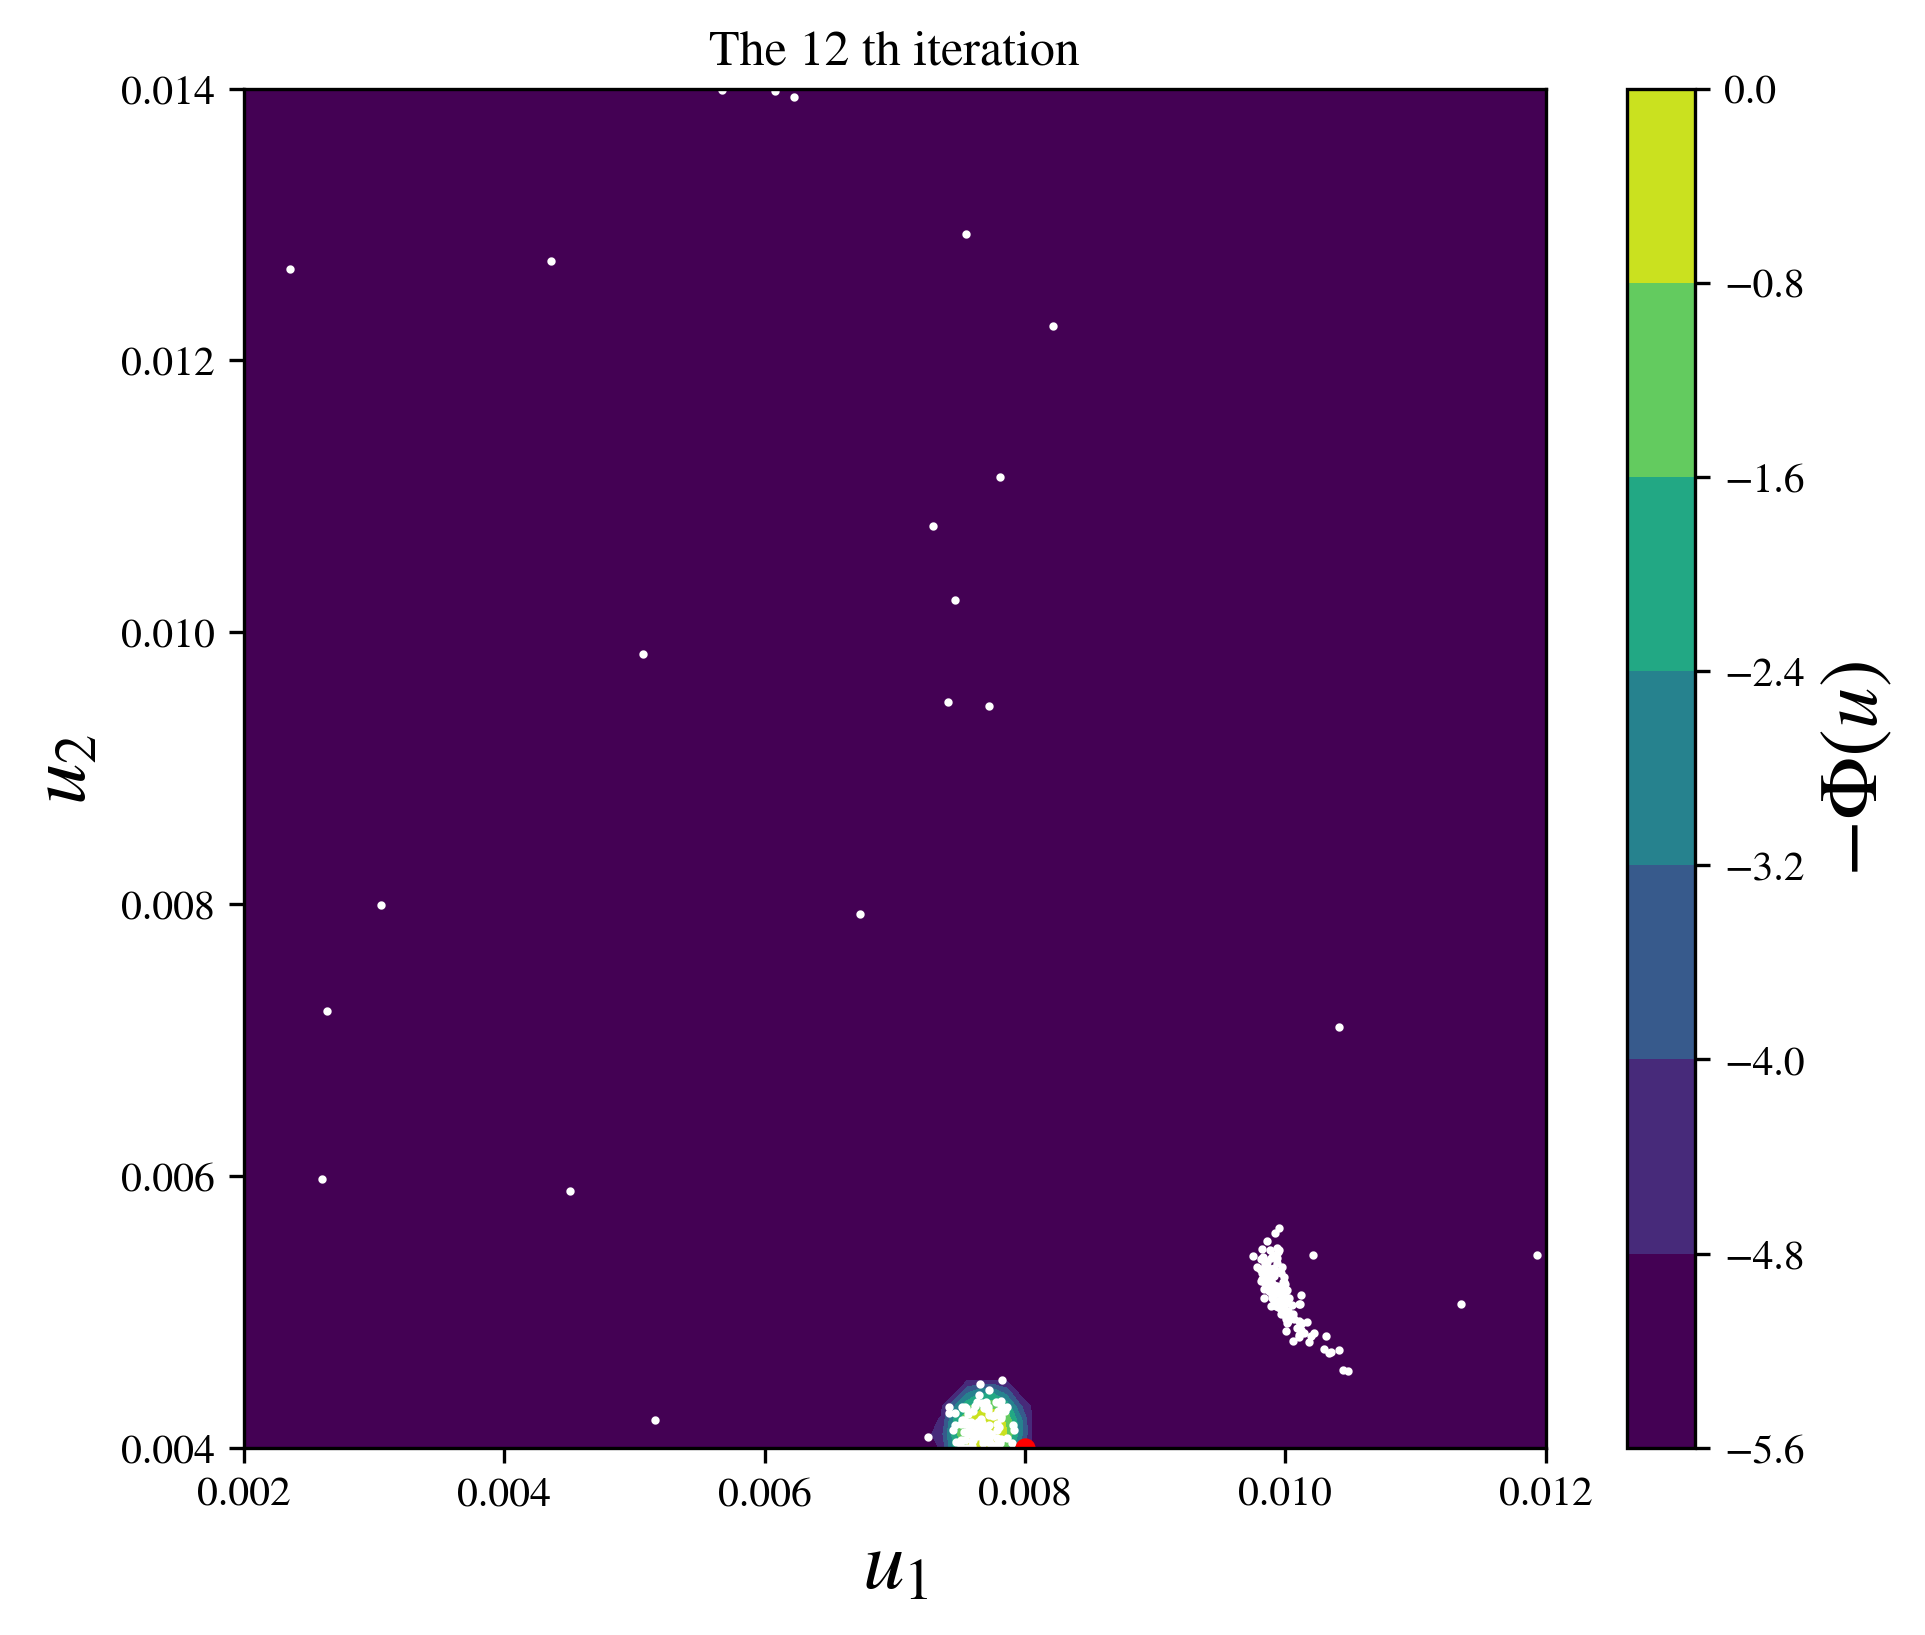

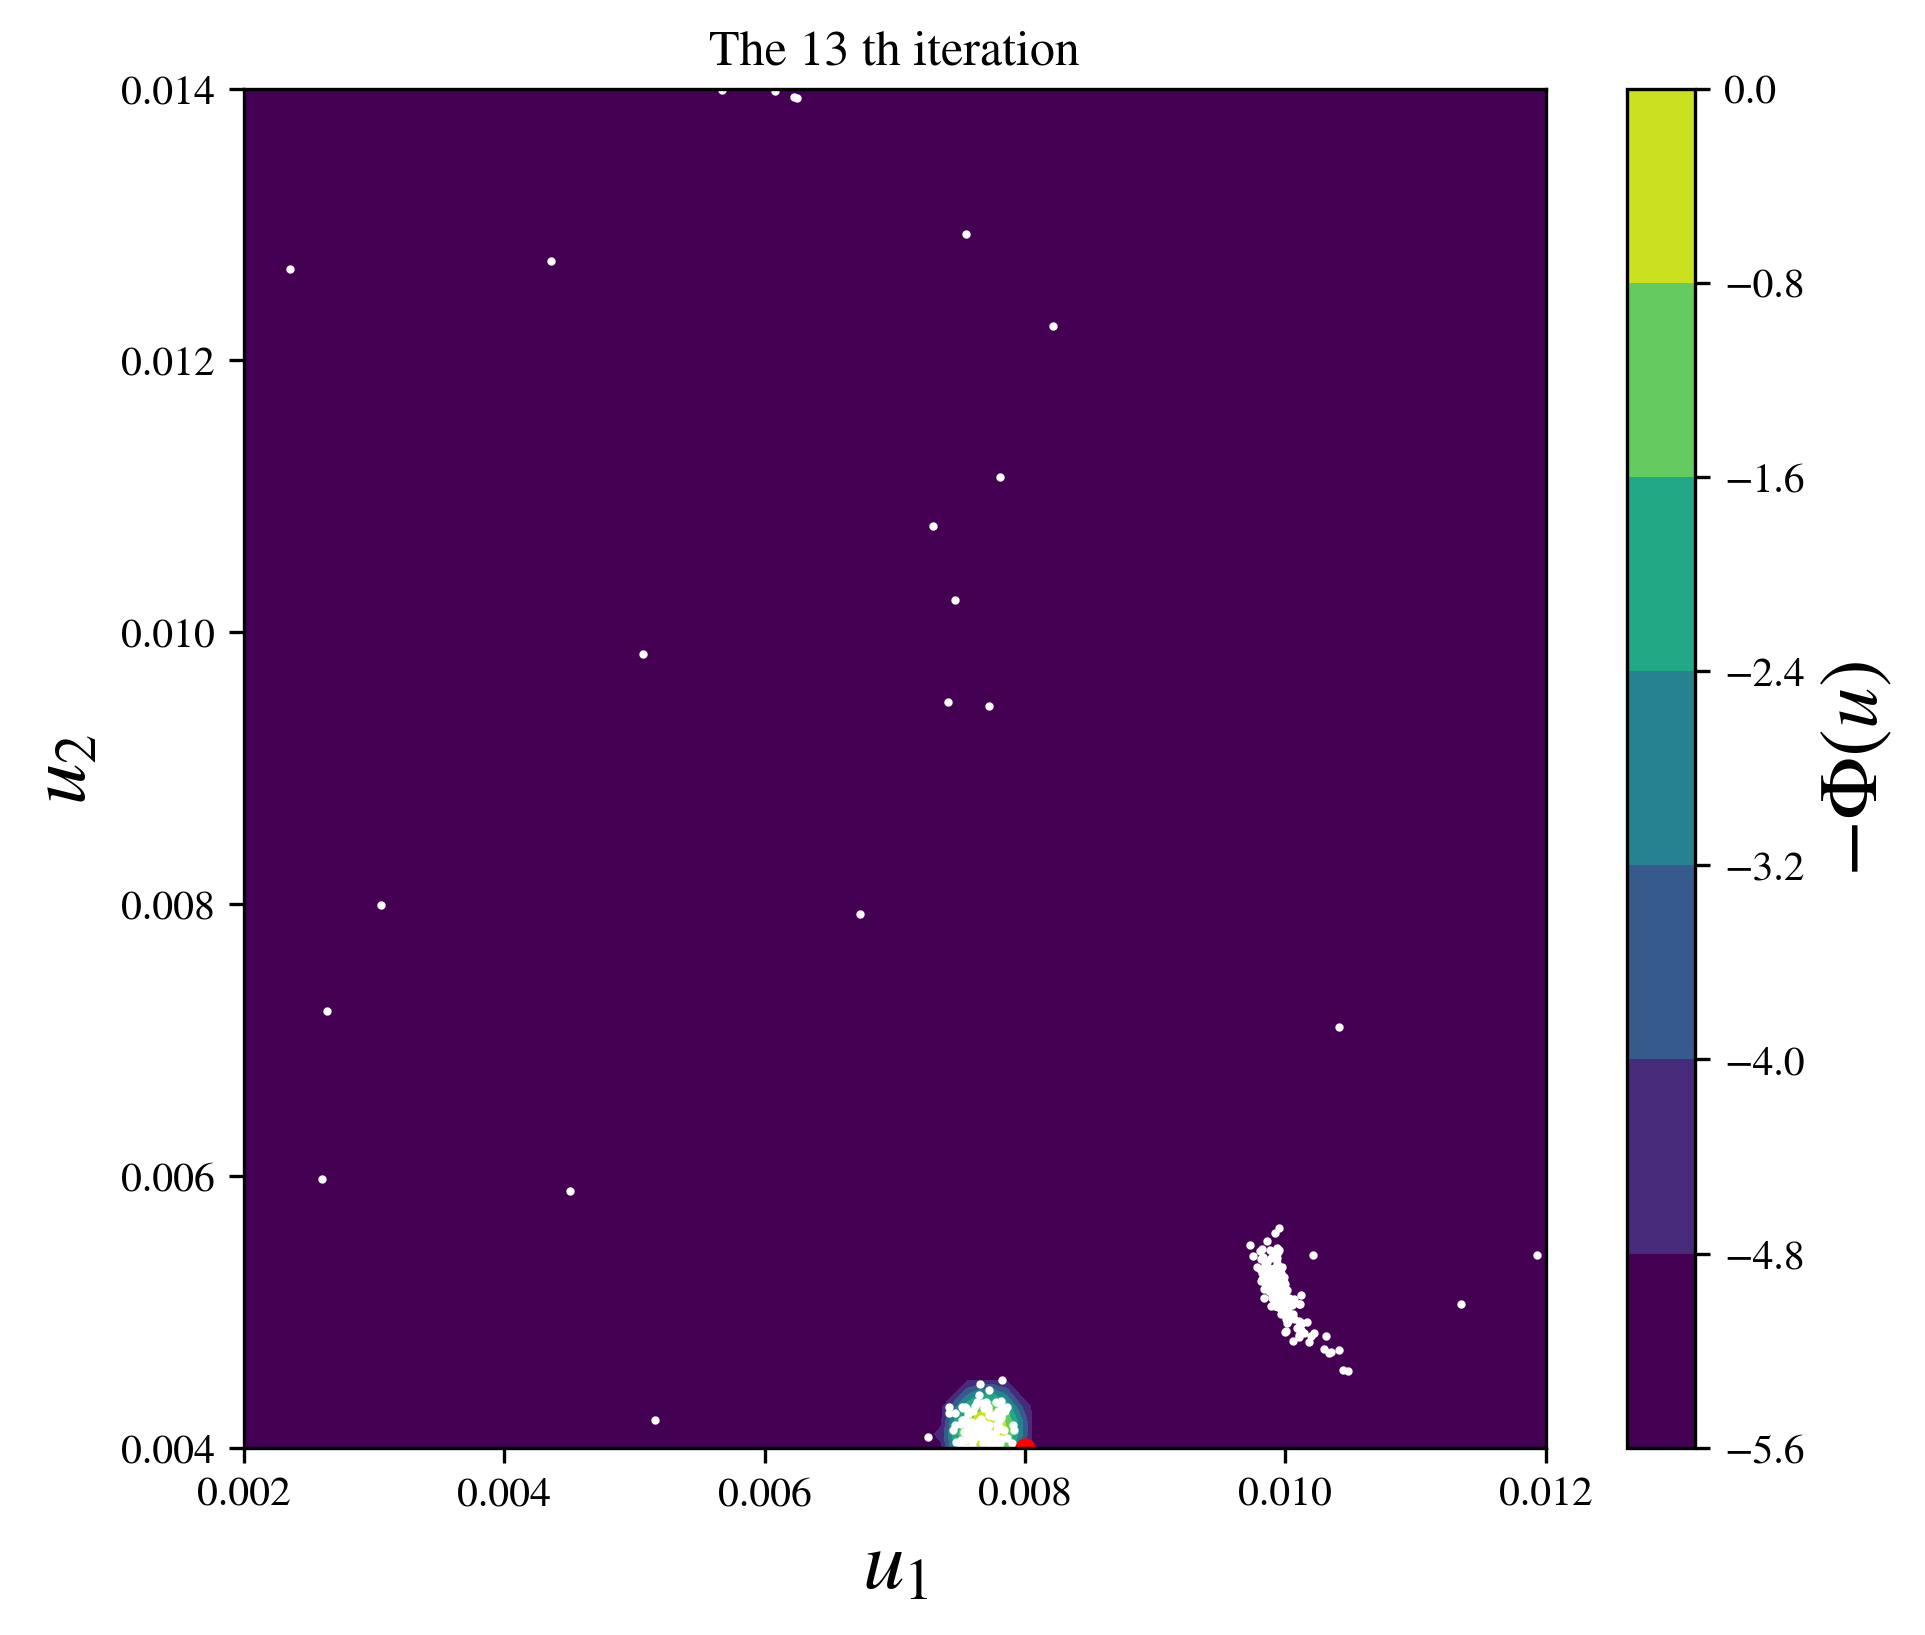

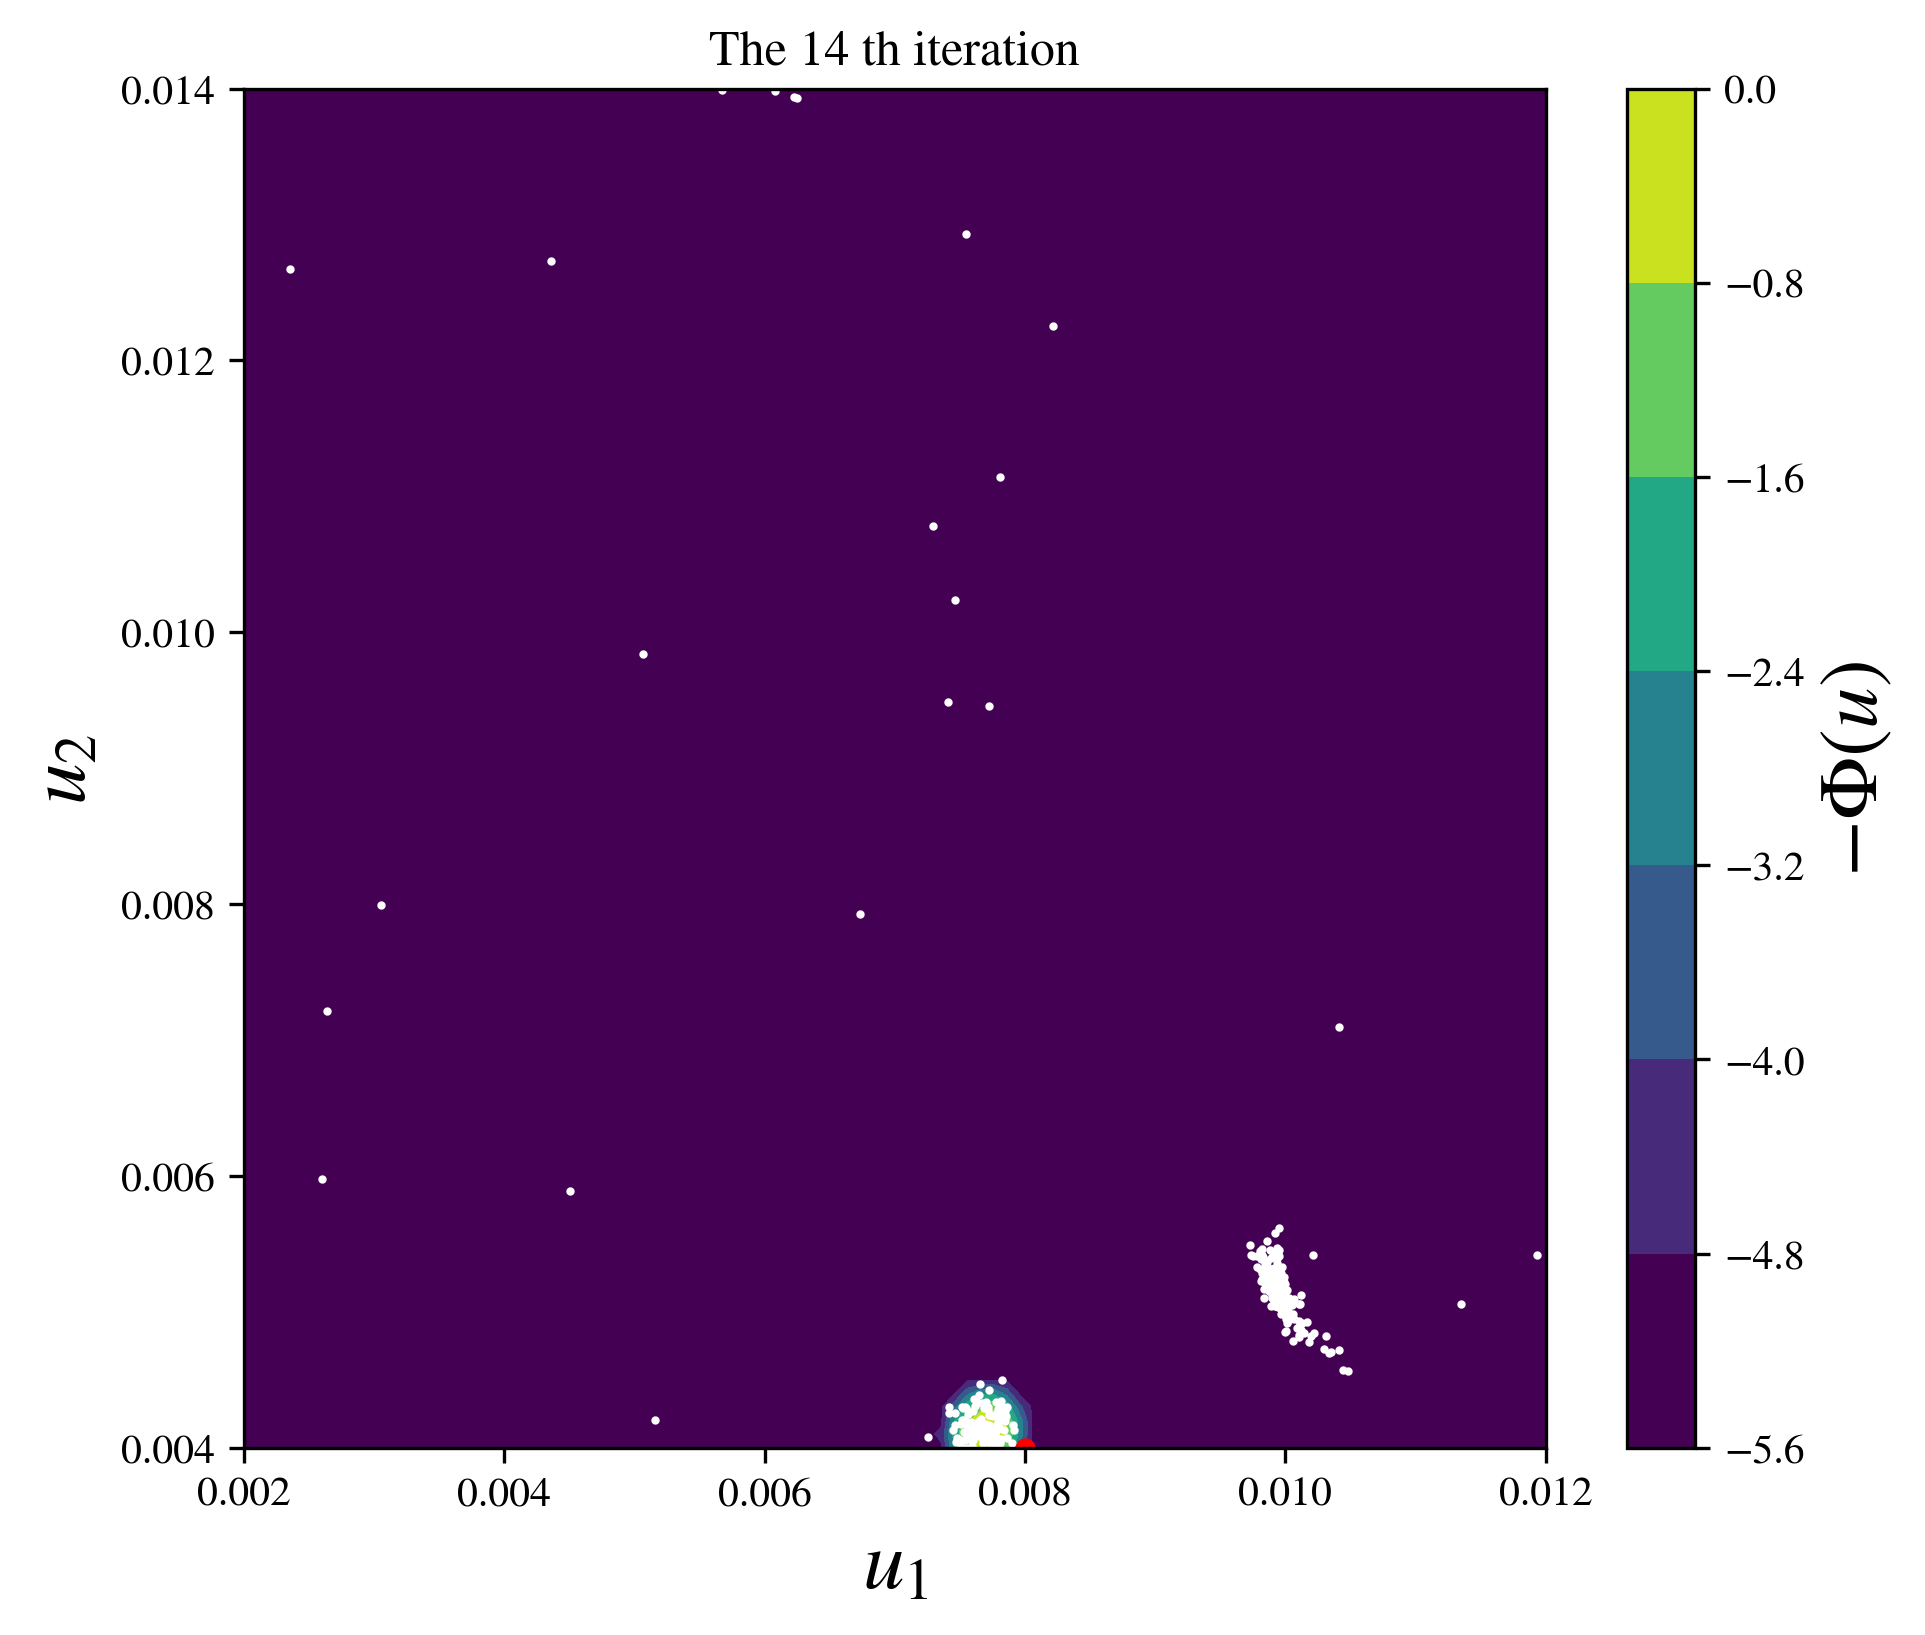

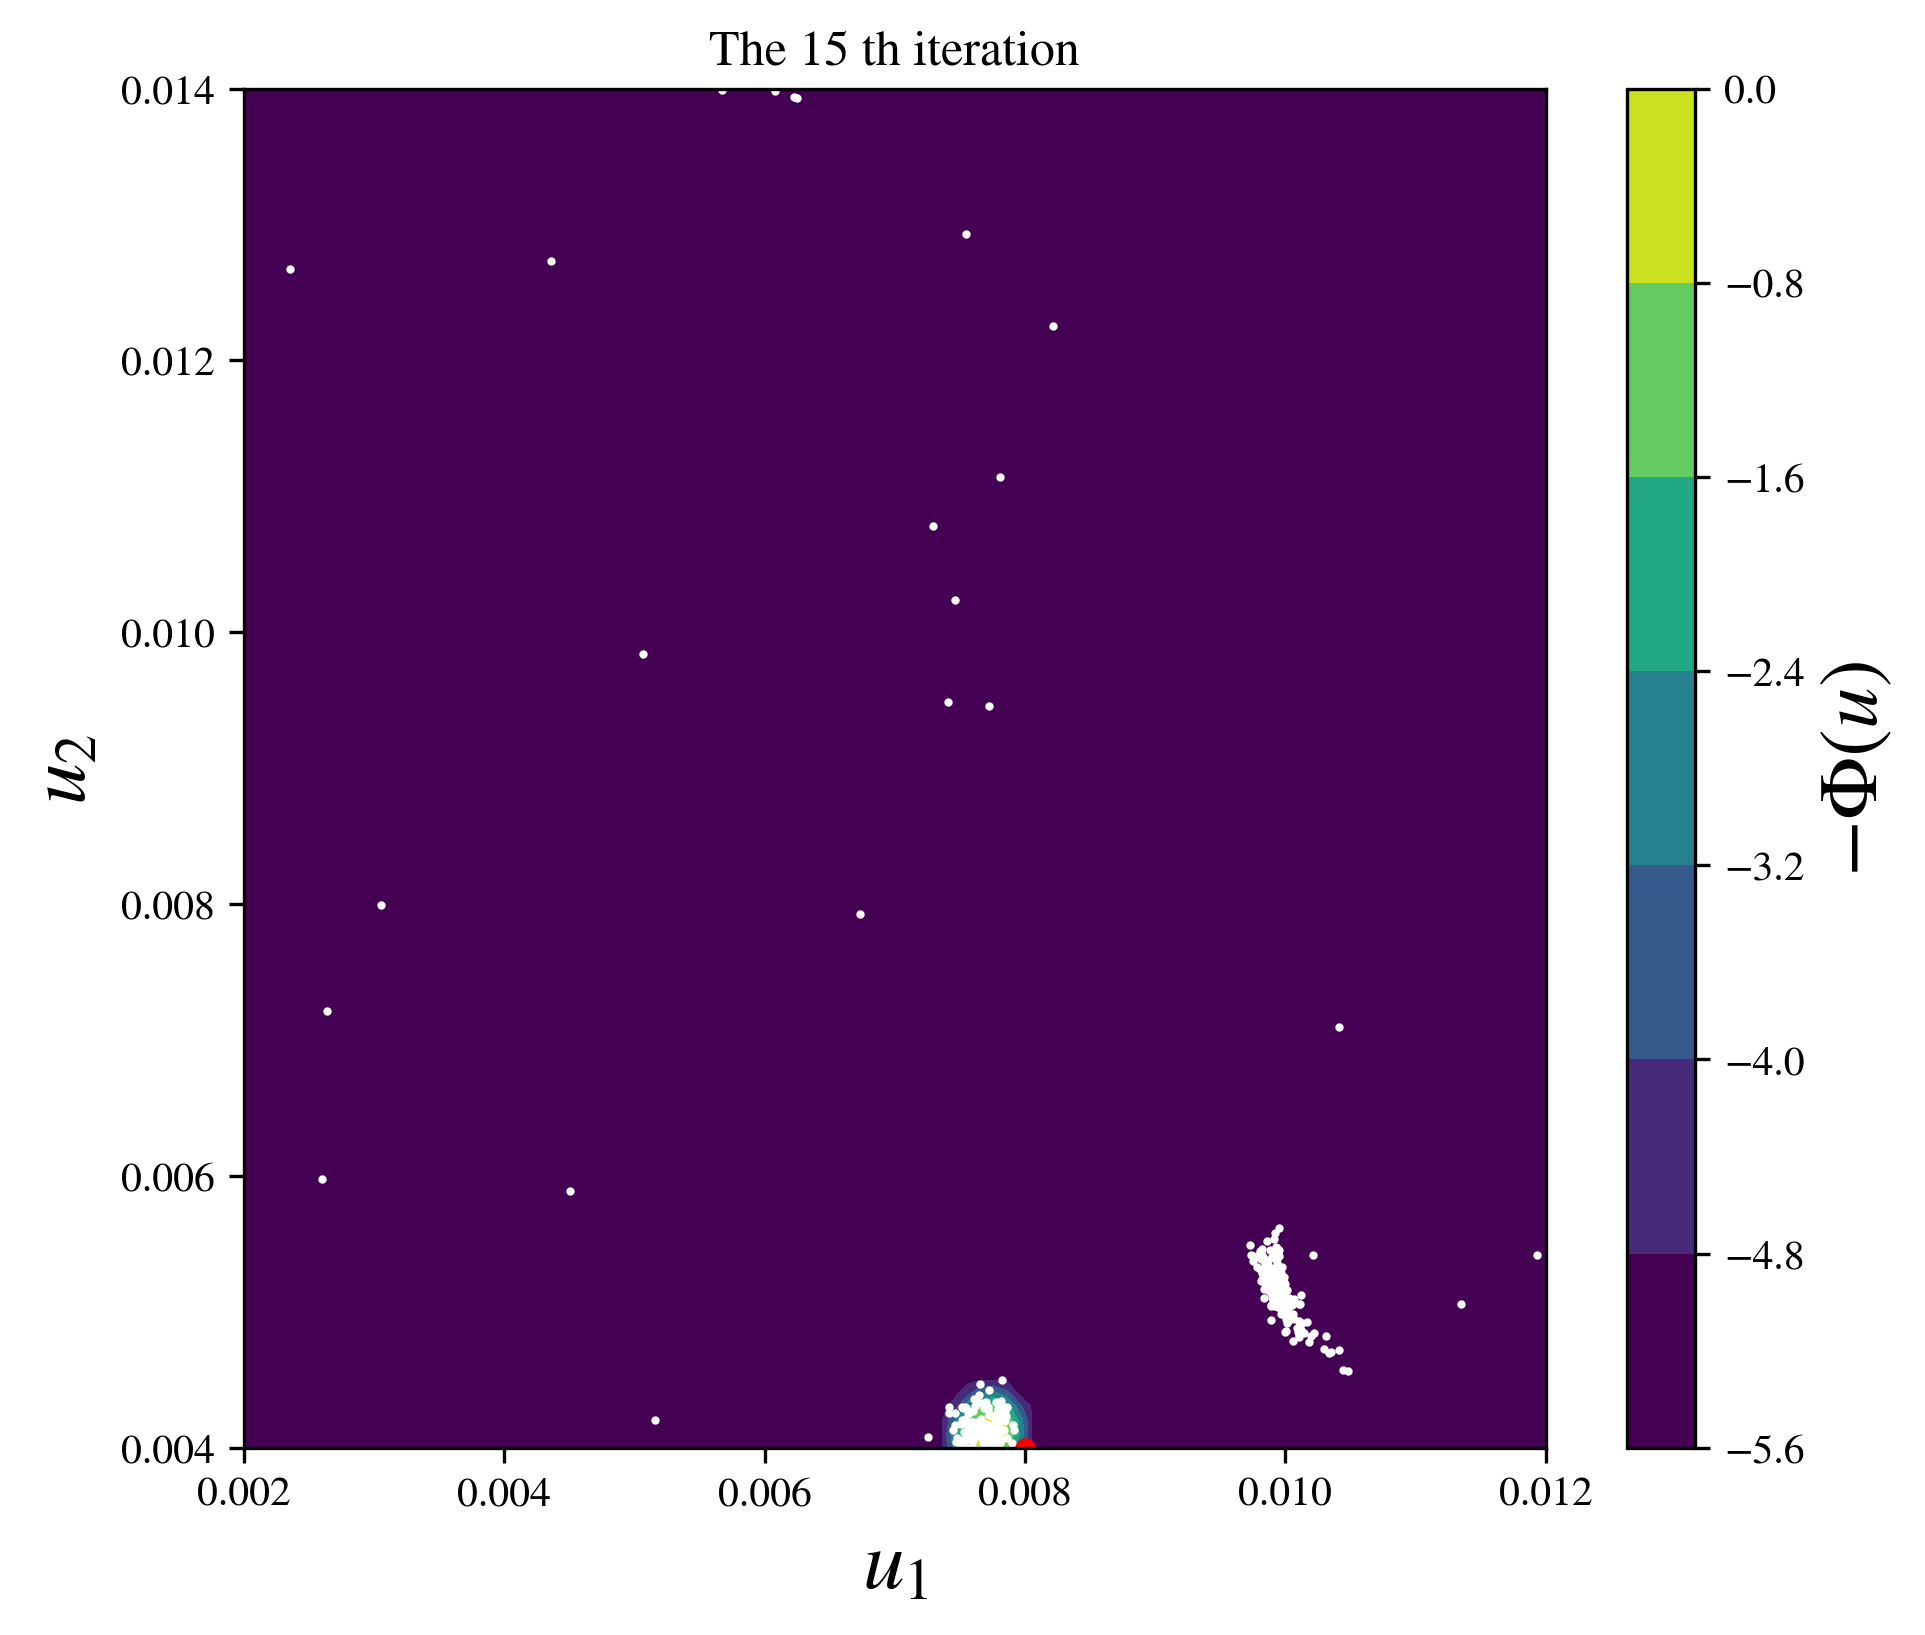

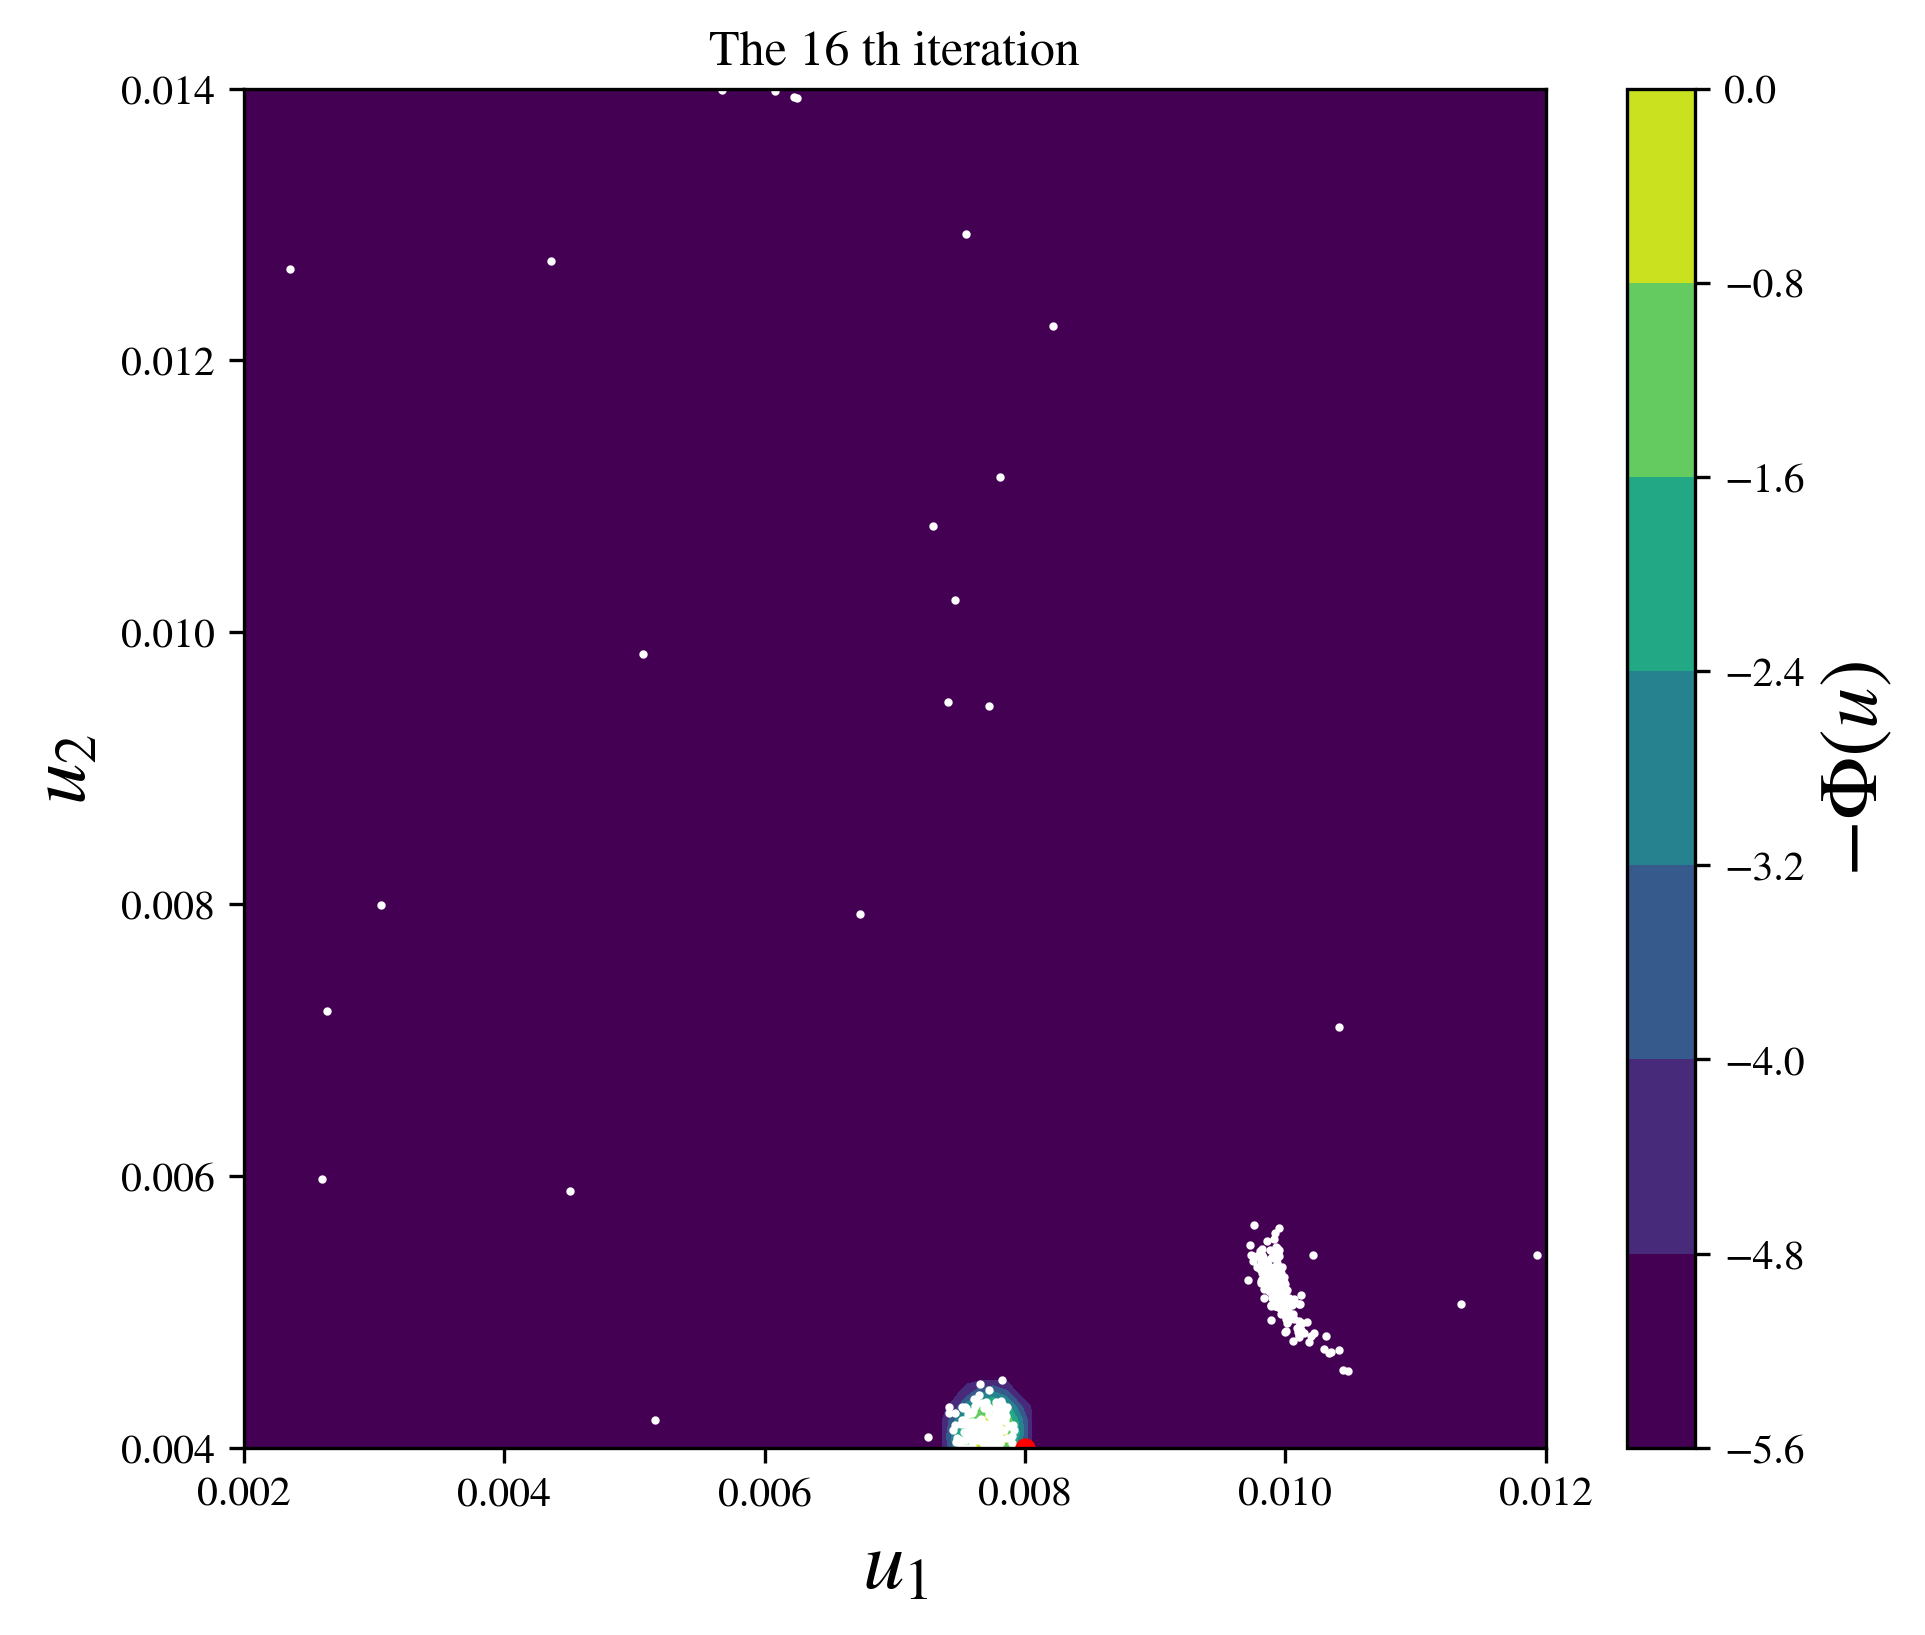

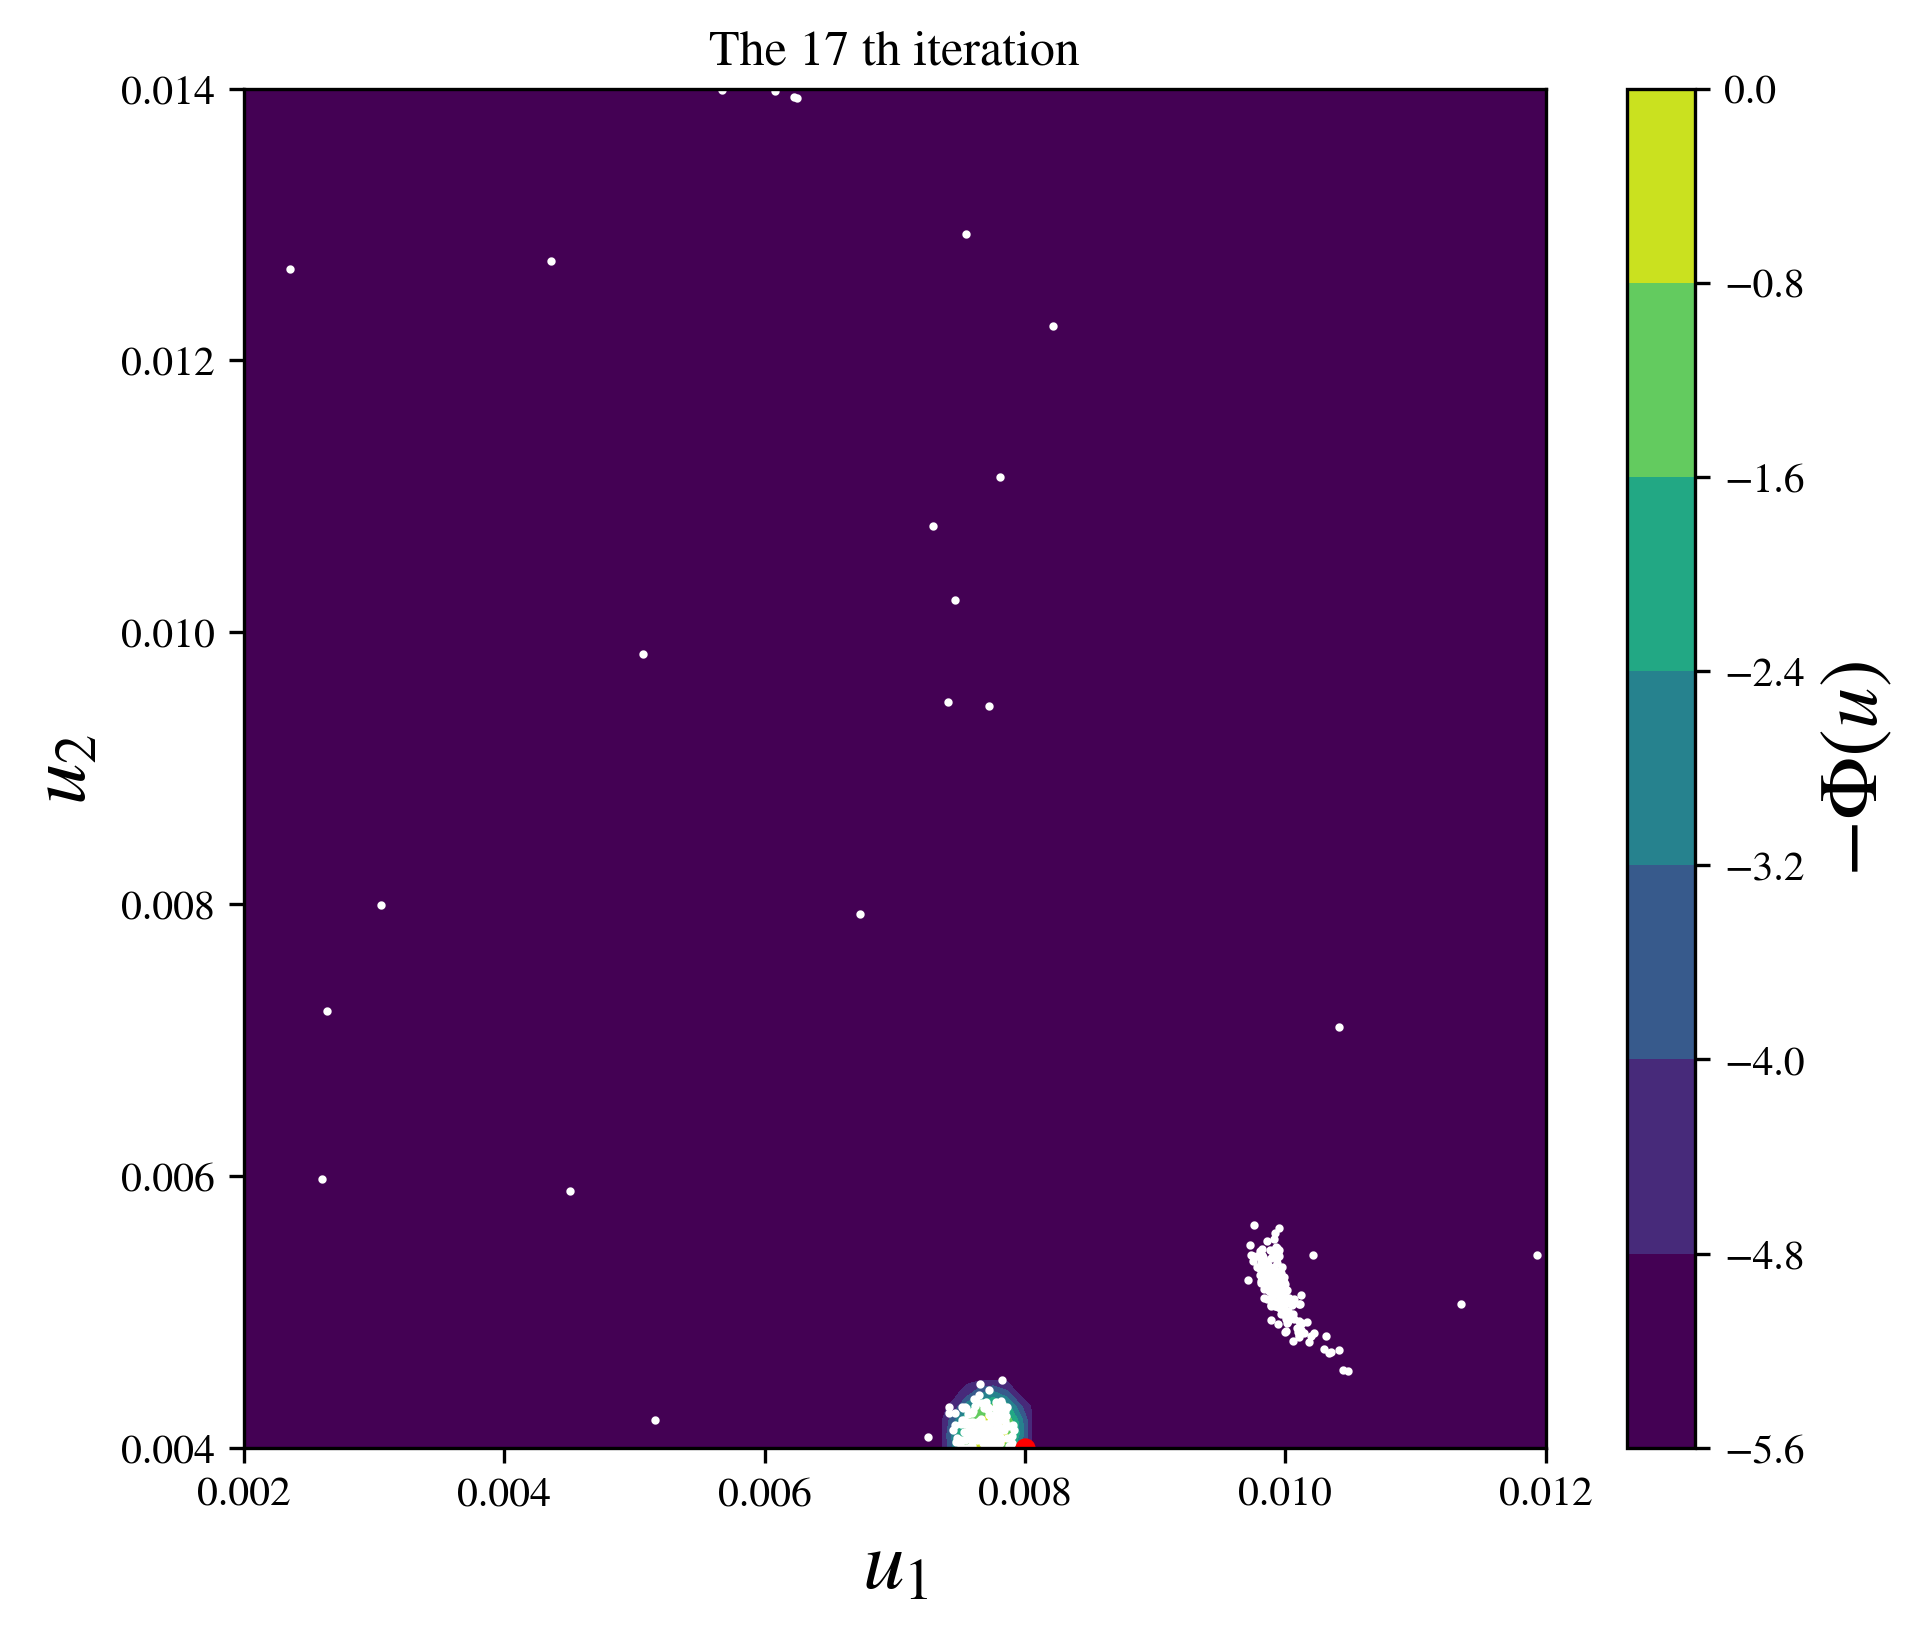

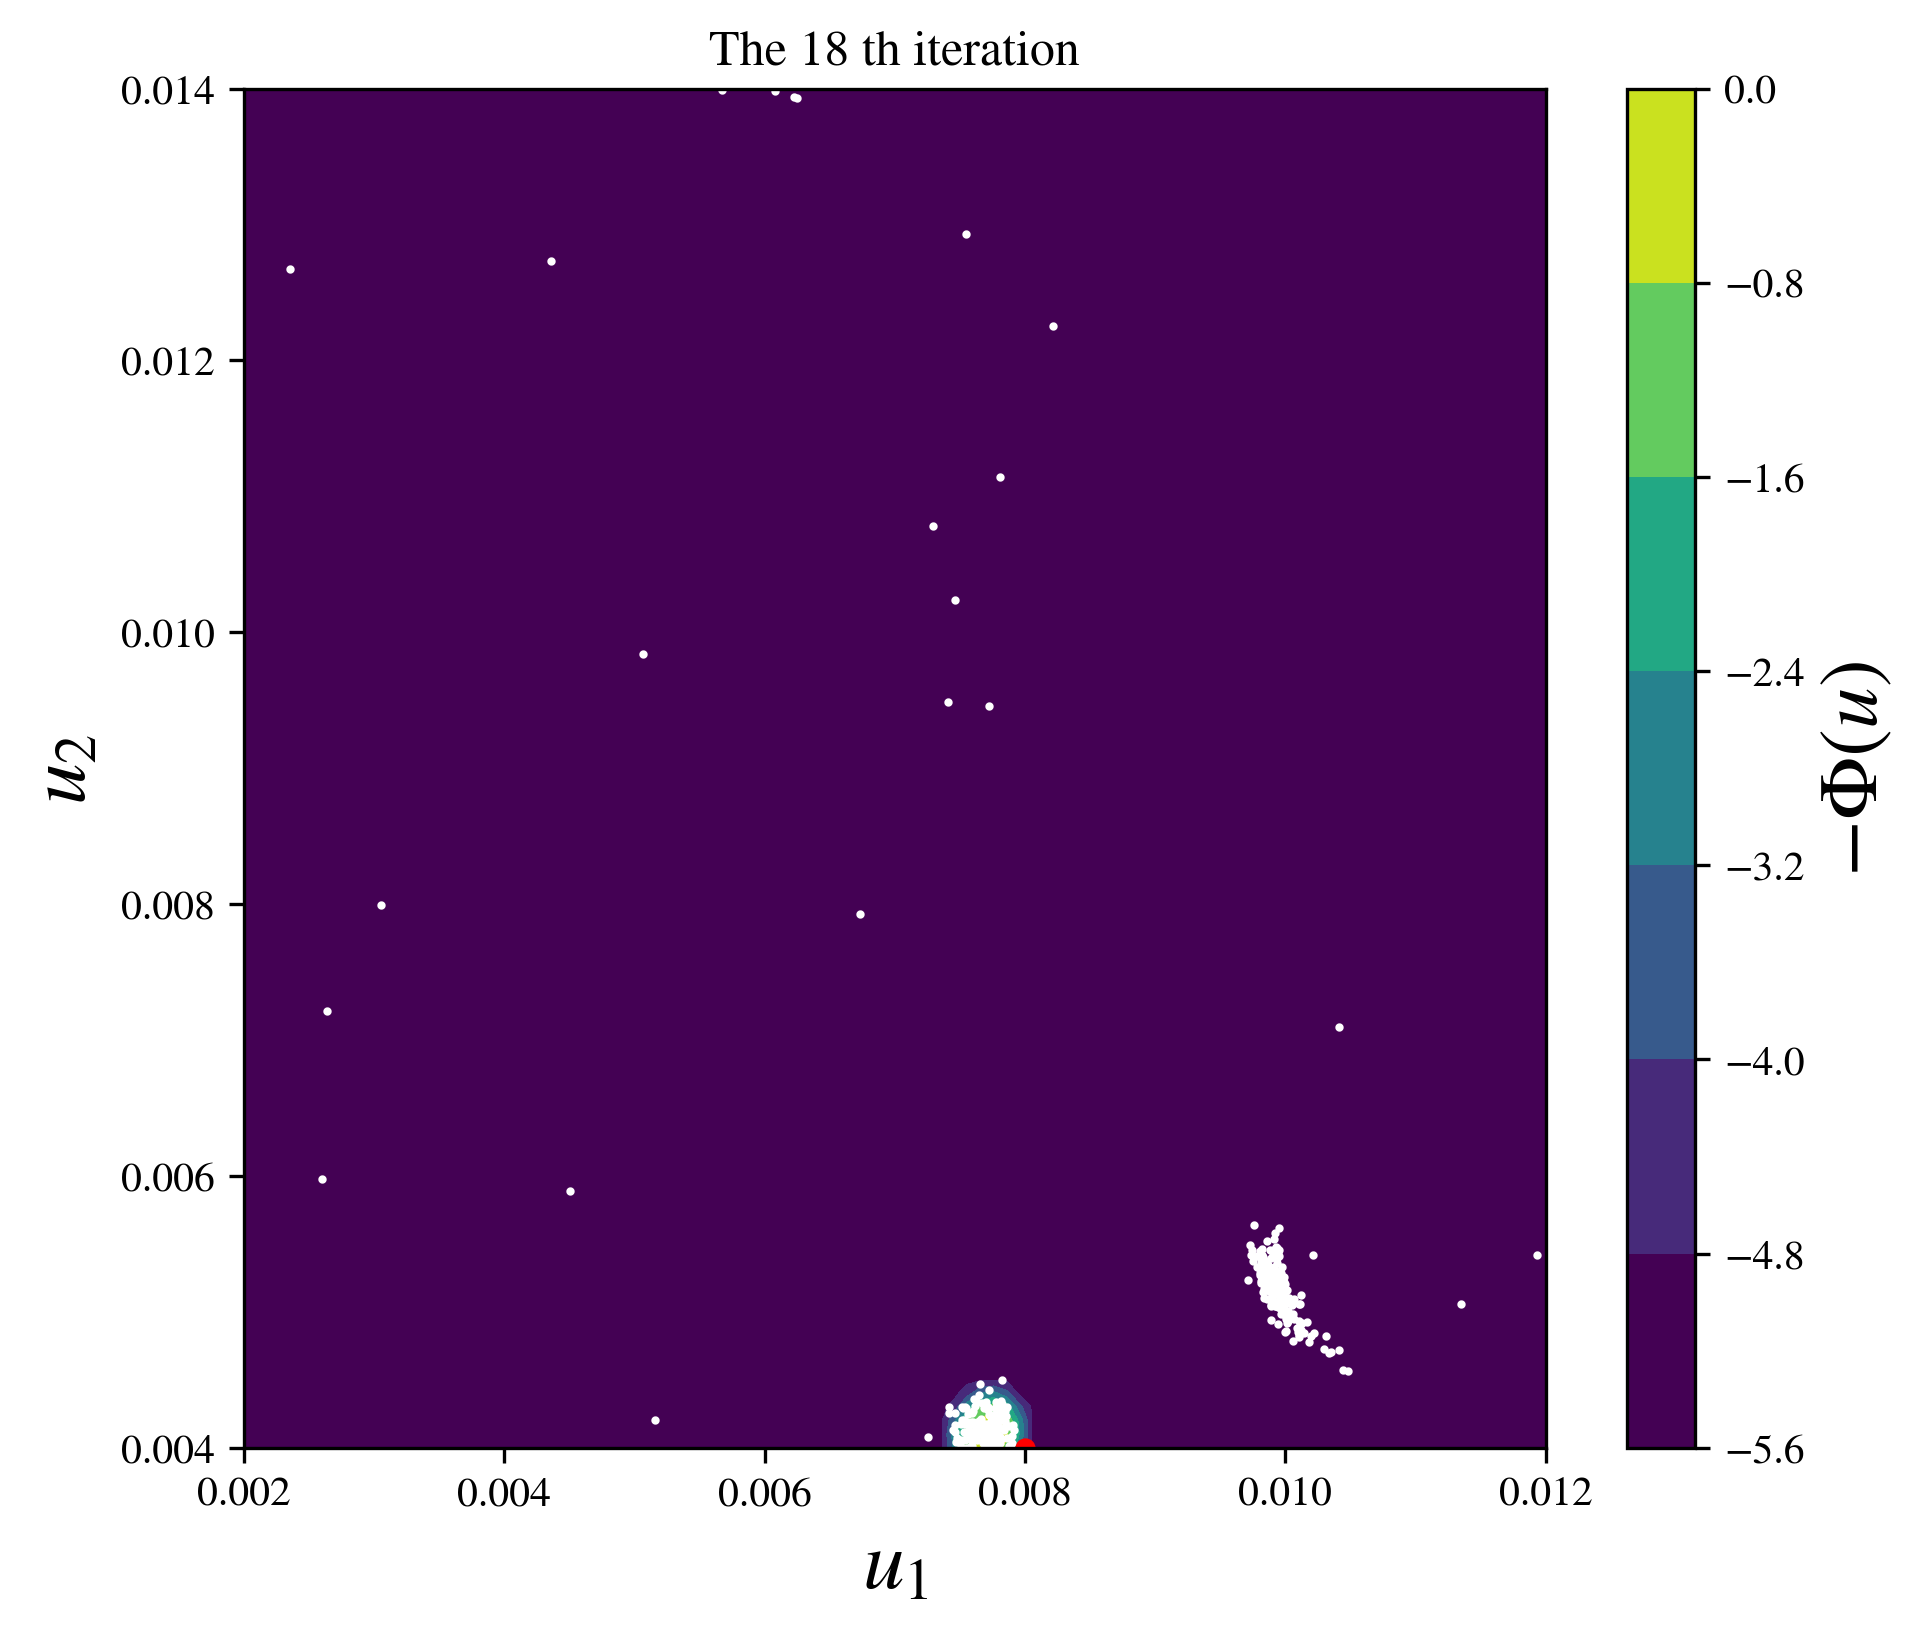

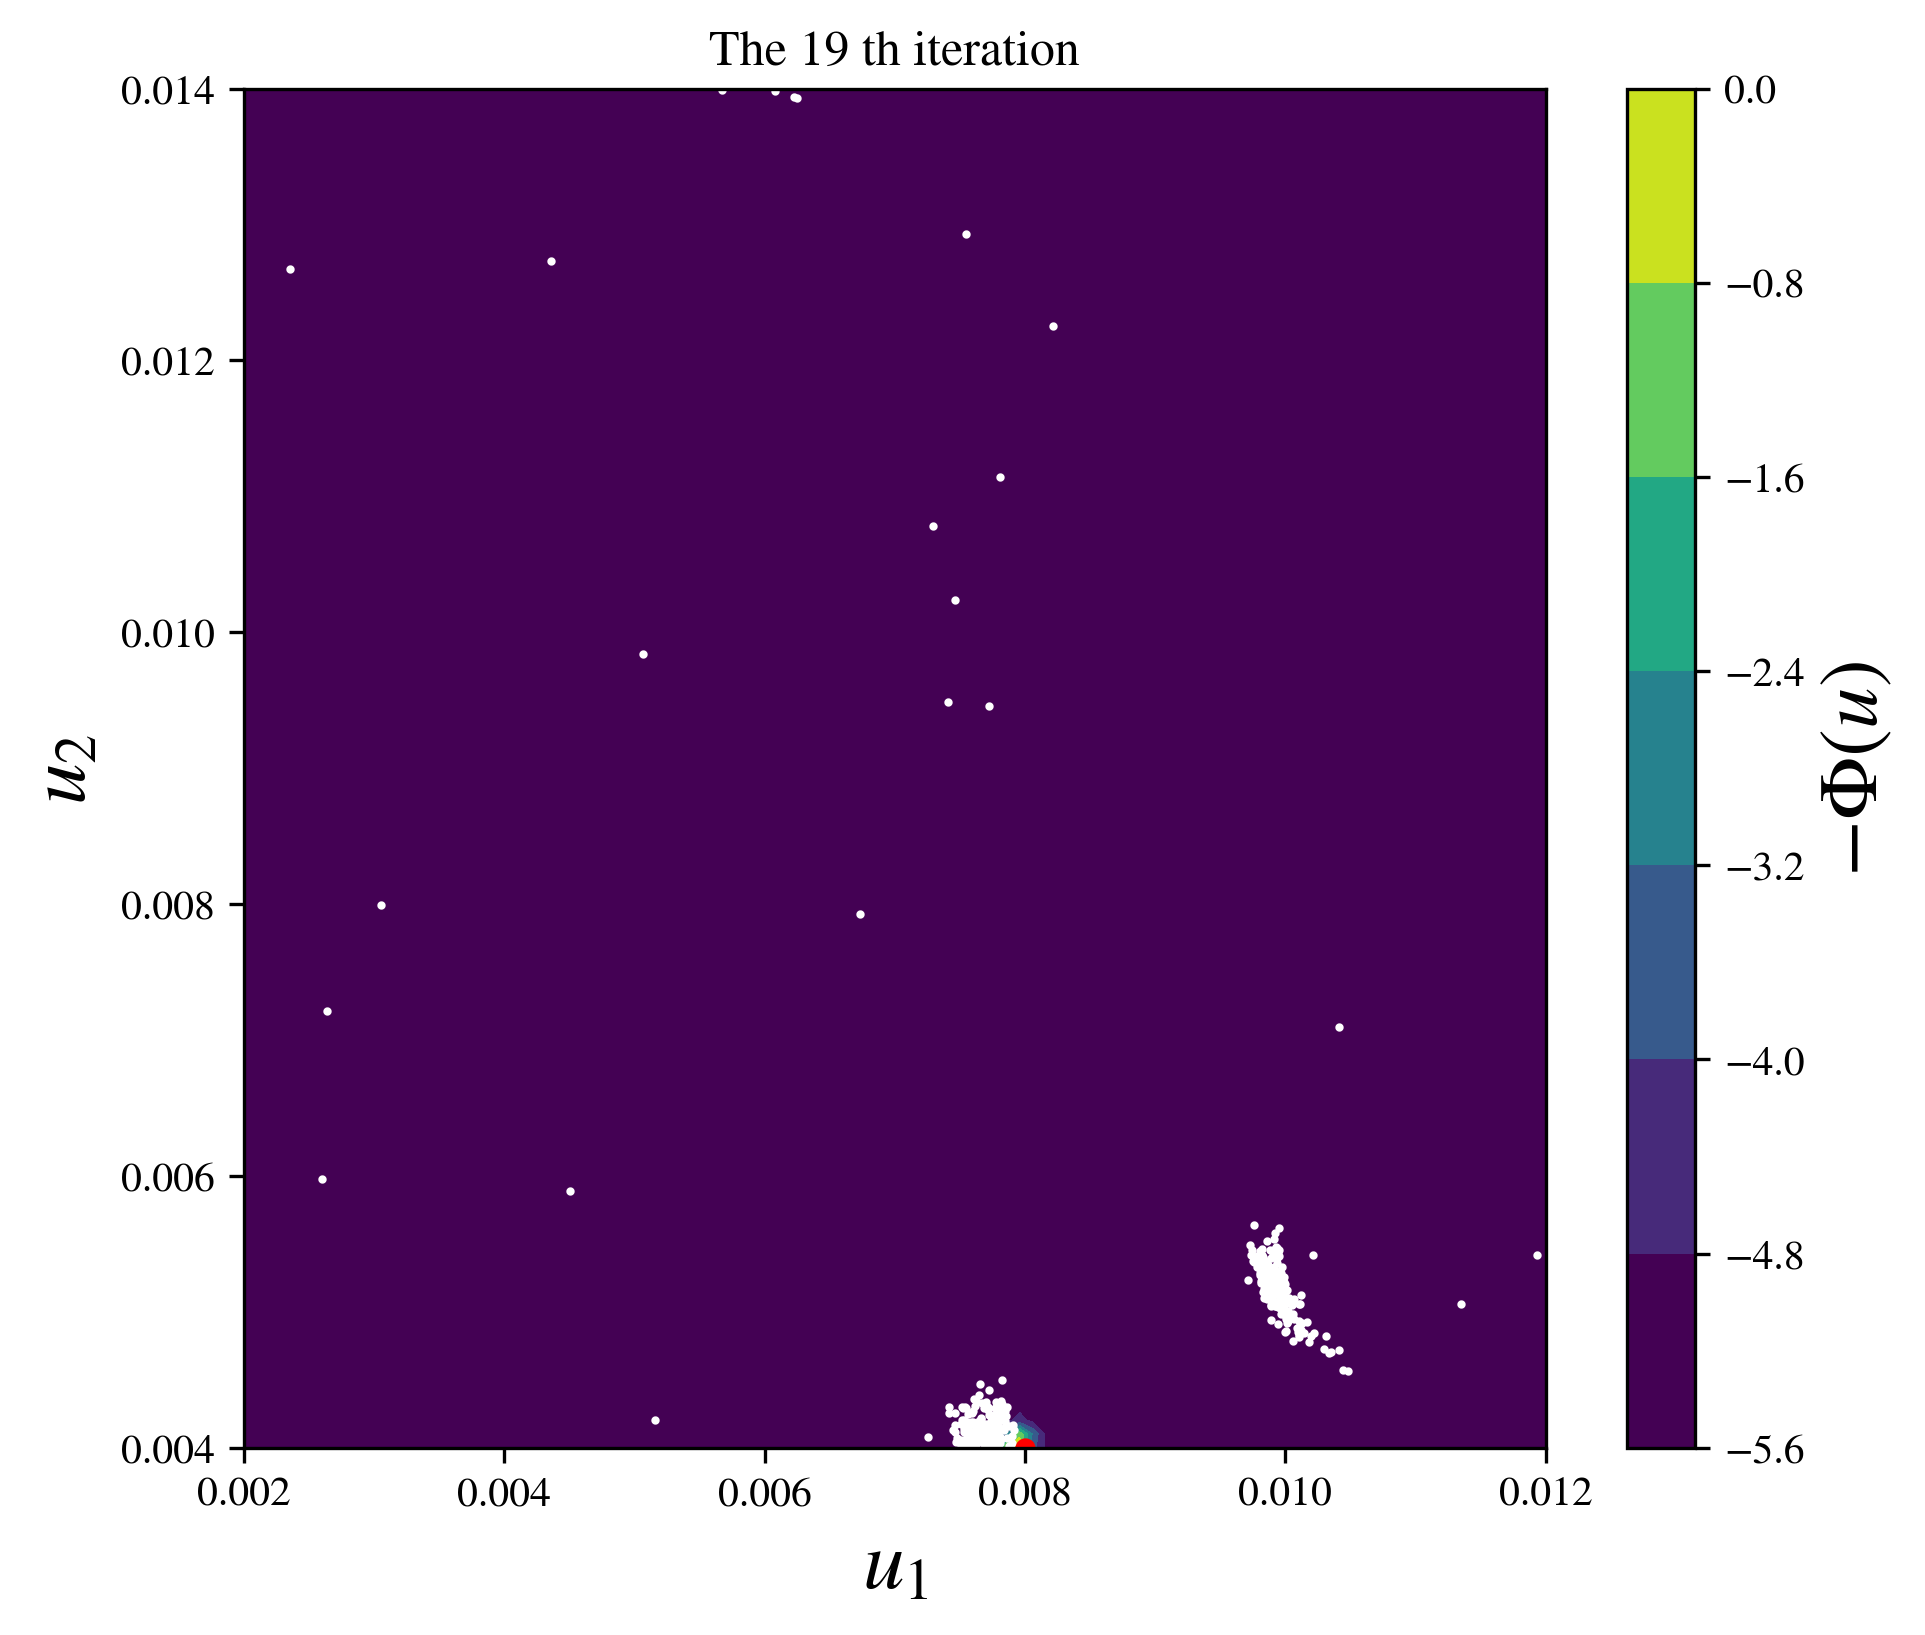

In [670]:
myInv.plotGIF()

Text(0, 0.5, 'Average error')

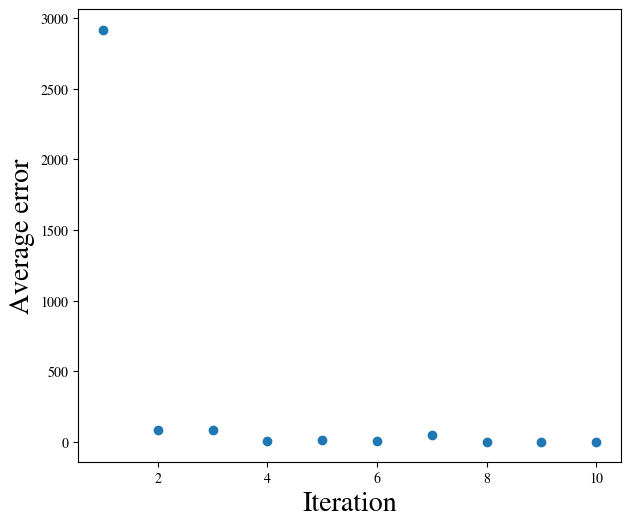

In [619]:
# Plot error versus iteration
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)
ax.plot(range(1, 1 + len(myInv.avg_errors)), myInv.avg_errors, 'o', linewidth=2.0)
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("Average error", fontsize = 20)

In [640]:
# Plot log likelihood of the give iteration step
def log_prob_best(self, iter_step, u, y):
    # Apply hard constraints
    normal_idx = np.all(np.concatenate([u >= self.u_low, u <= self.u_high], axis = 1), axis = 1)

    # First prior is uniform distribution
    res = np.ones(len(u))
    res[~normal_idx] = -np.inf

    # Add all posteriors in each iteration
    if (np.sum(normal_idx) > 0):
        for i in range(iter_step + 1):
            res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                np.sum(
                    (y - self.GPs[i].predict(u[normal_idx])) ** 2, 
                    axis = 1
                )
            )

    # Return the log_probability at the current iteration
    return res

# Plot a series and save the gif
def plotSeries(self, analytical_u, analytical_y, dpi_value = 300):
    # Calculate U_plot
    minU = self.u_low
    maxU = self.u_high
    nOfGridPoints = 100

    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    
    gifName = "./figures/A{0}_B{1}.gif".format(analytical_u[0], analytical_u[1])
    
    writer = imageio.get_writer(gifName, mode='I', duration = 1.0)
    
    # Plot the series
    for i in range(0, self.iterations):
        plt.figure(figsize = (7, 6), dpi = dpi_value)
        YPlotGridFat = log_prob_best(self, i, UPlotGridFat, analytical_y)
        YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
        YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])
        cp = plt.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))
        
        # Give the color bar
        cbar = plt.colorbar(cp)
        plt.clim([-5., 0.])
        cbar.set_label('$-\\Phi(u)$', fontsize = 20)
        
        # Scatter the sample points
        plt.scatter(self.U[ :(i + 1) * self.n_samples, 0], 
                    self.U[ :(i + 1) * self.n_samples, 1], s = 1, color = 'white')
        plt.scatter(analytical_u[0], analytical_u[1], s = 15, color = 'red')
        plt.xlabel('$u_1$', fontsize = 20)
        plt.ylabel('$u_2$', fontsize = 20)
        plt.title("The " + str(i) + " th iteration")
        figName = "./figures/shit" + str(i) + ".png"
        plt.savefig(figName, dpi = dpi_value)
        
        # Save the figures into a gif
        image = imageio.imread(figName)
        writer.append_data(image)
        !rm $figName
    writer.close()
        
#    return figs

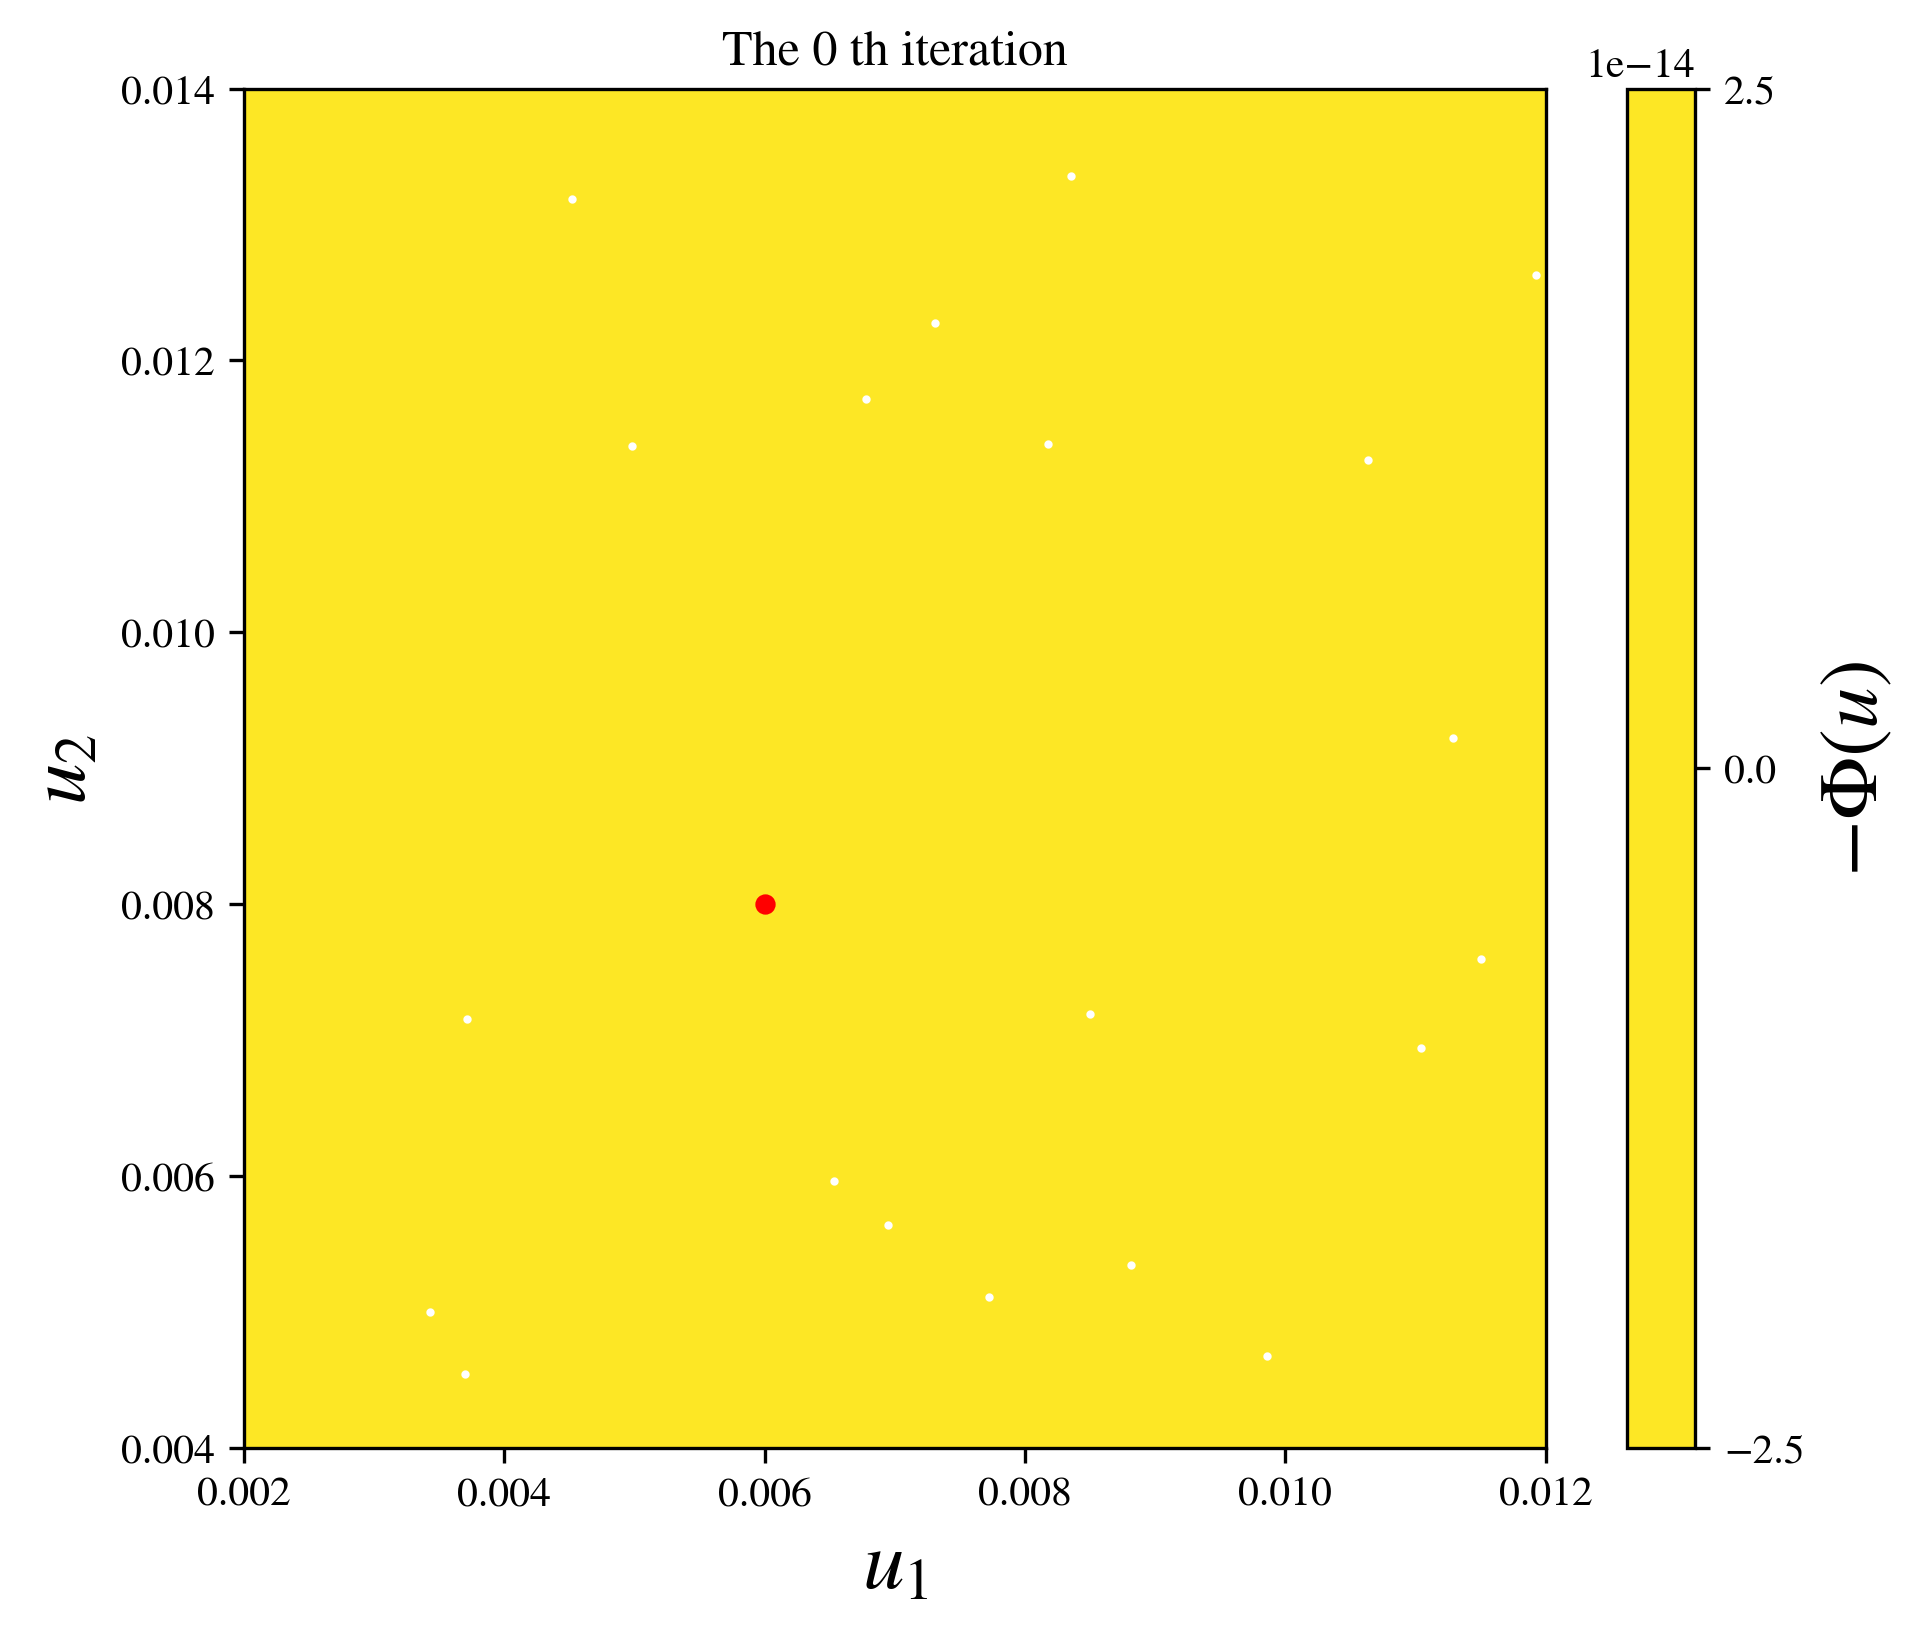

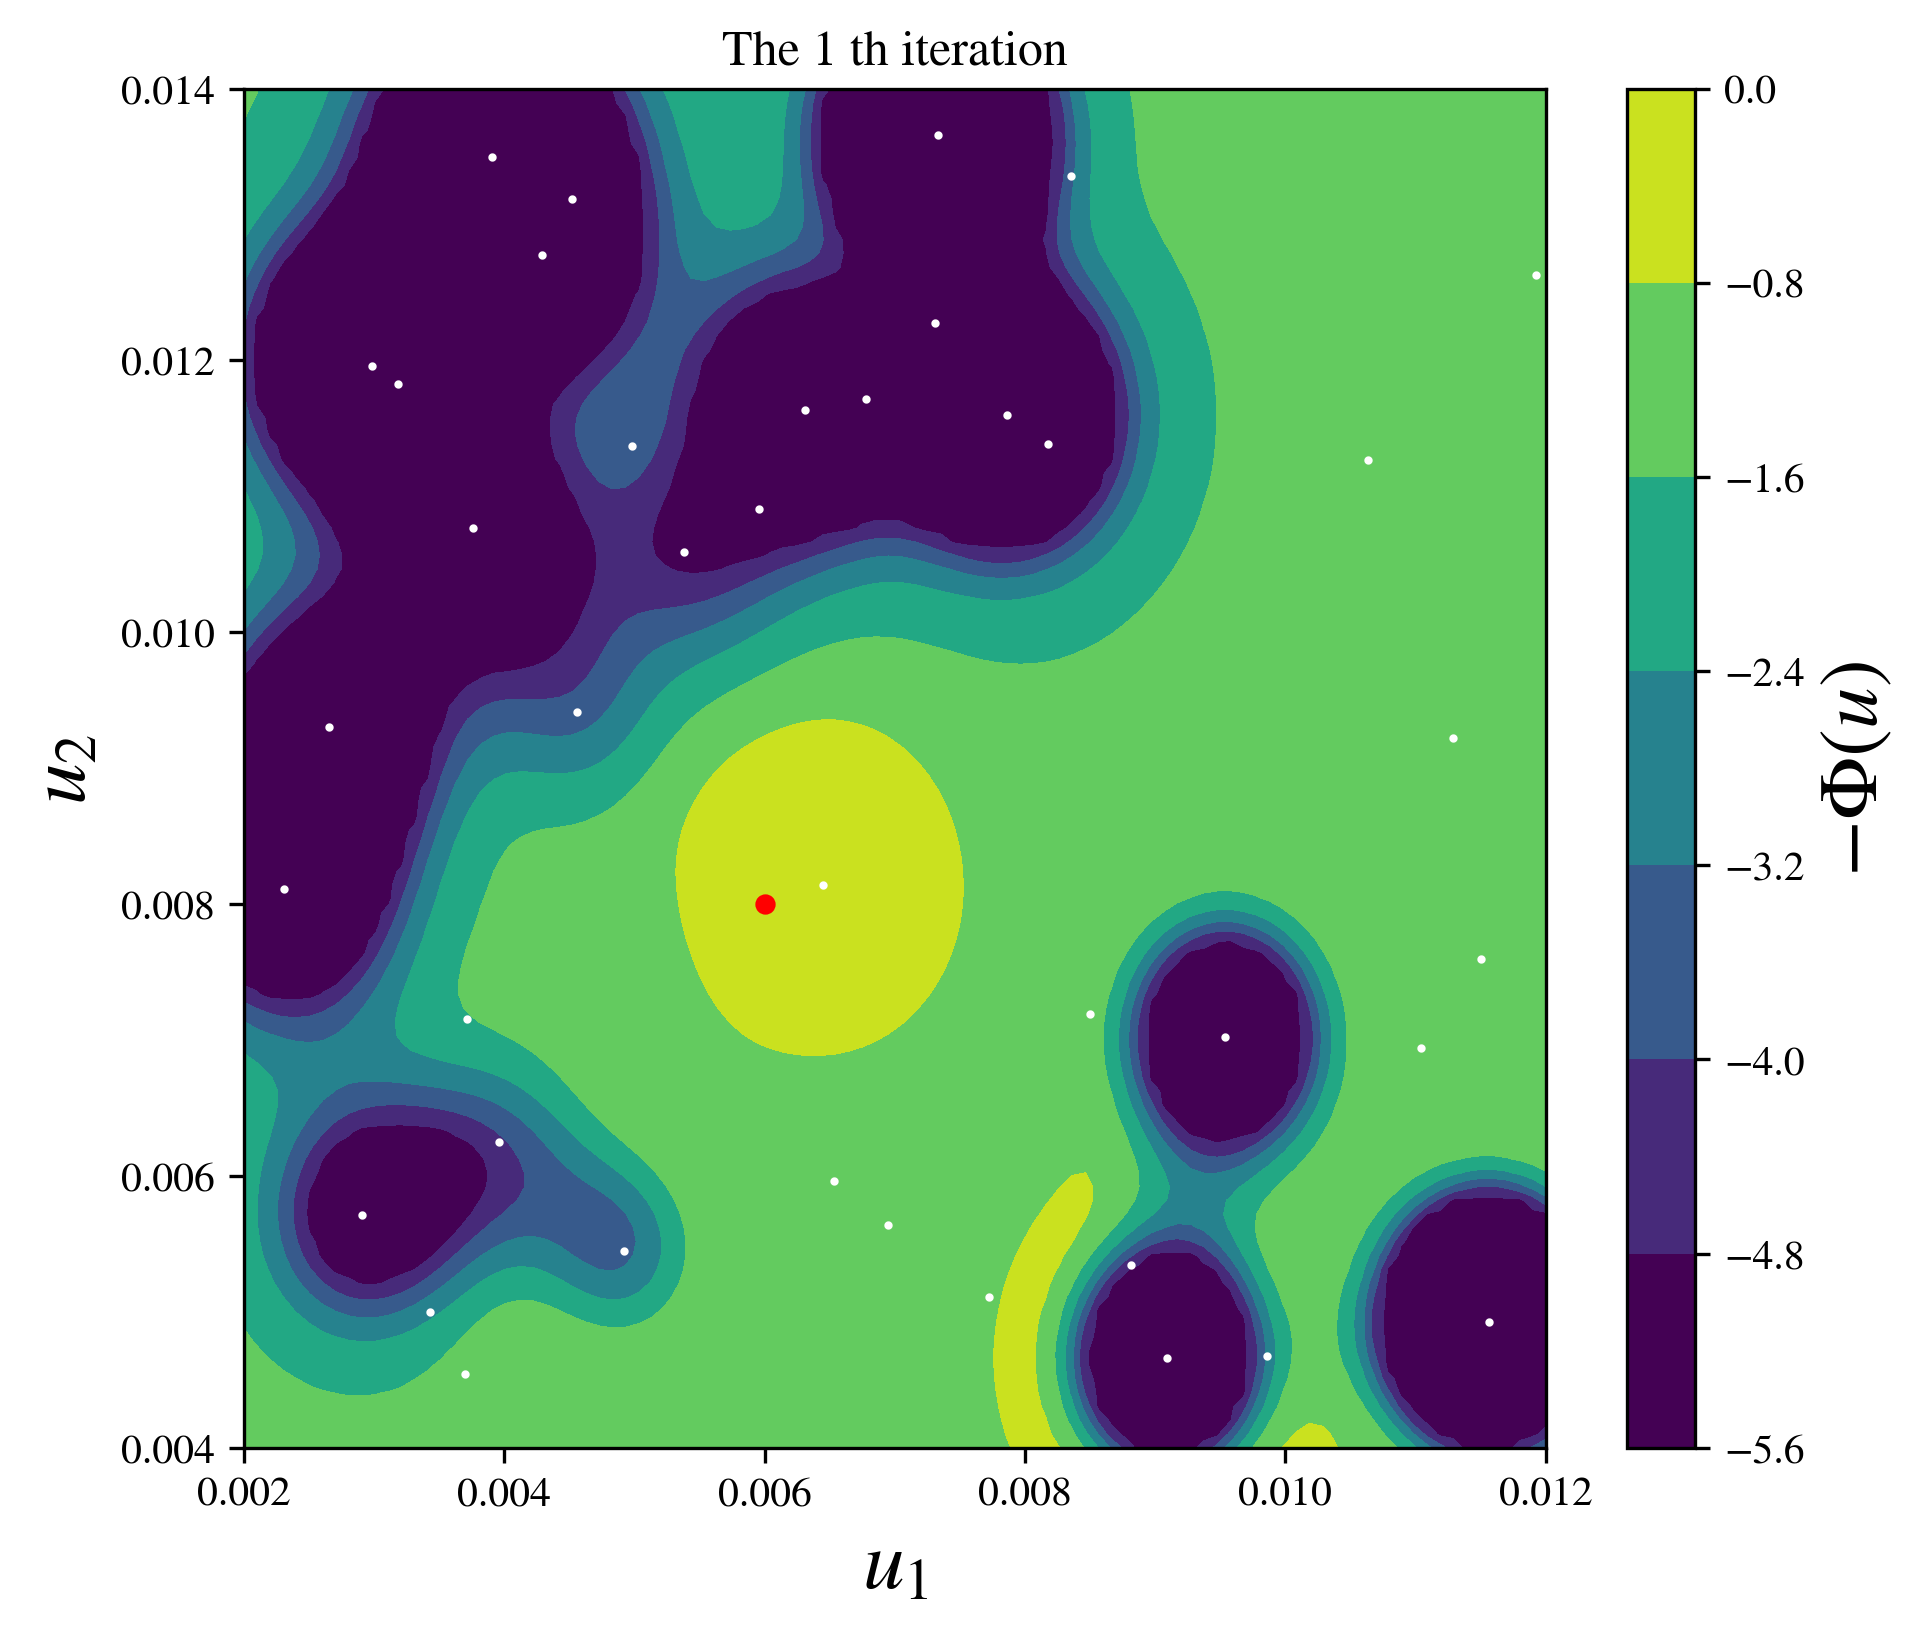

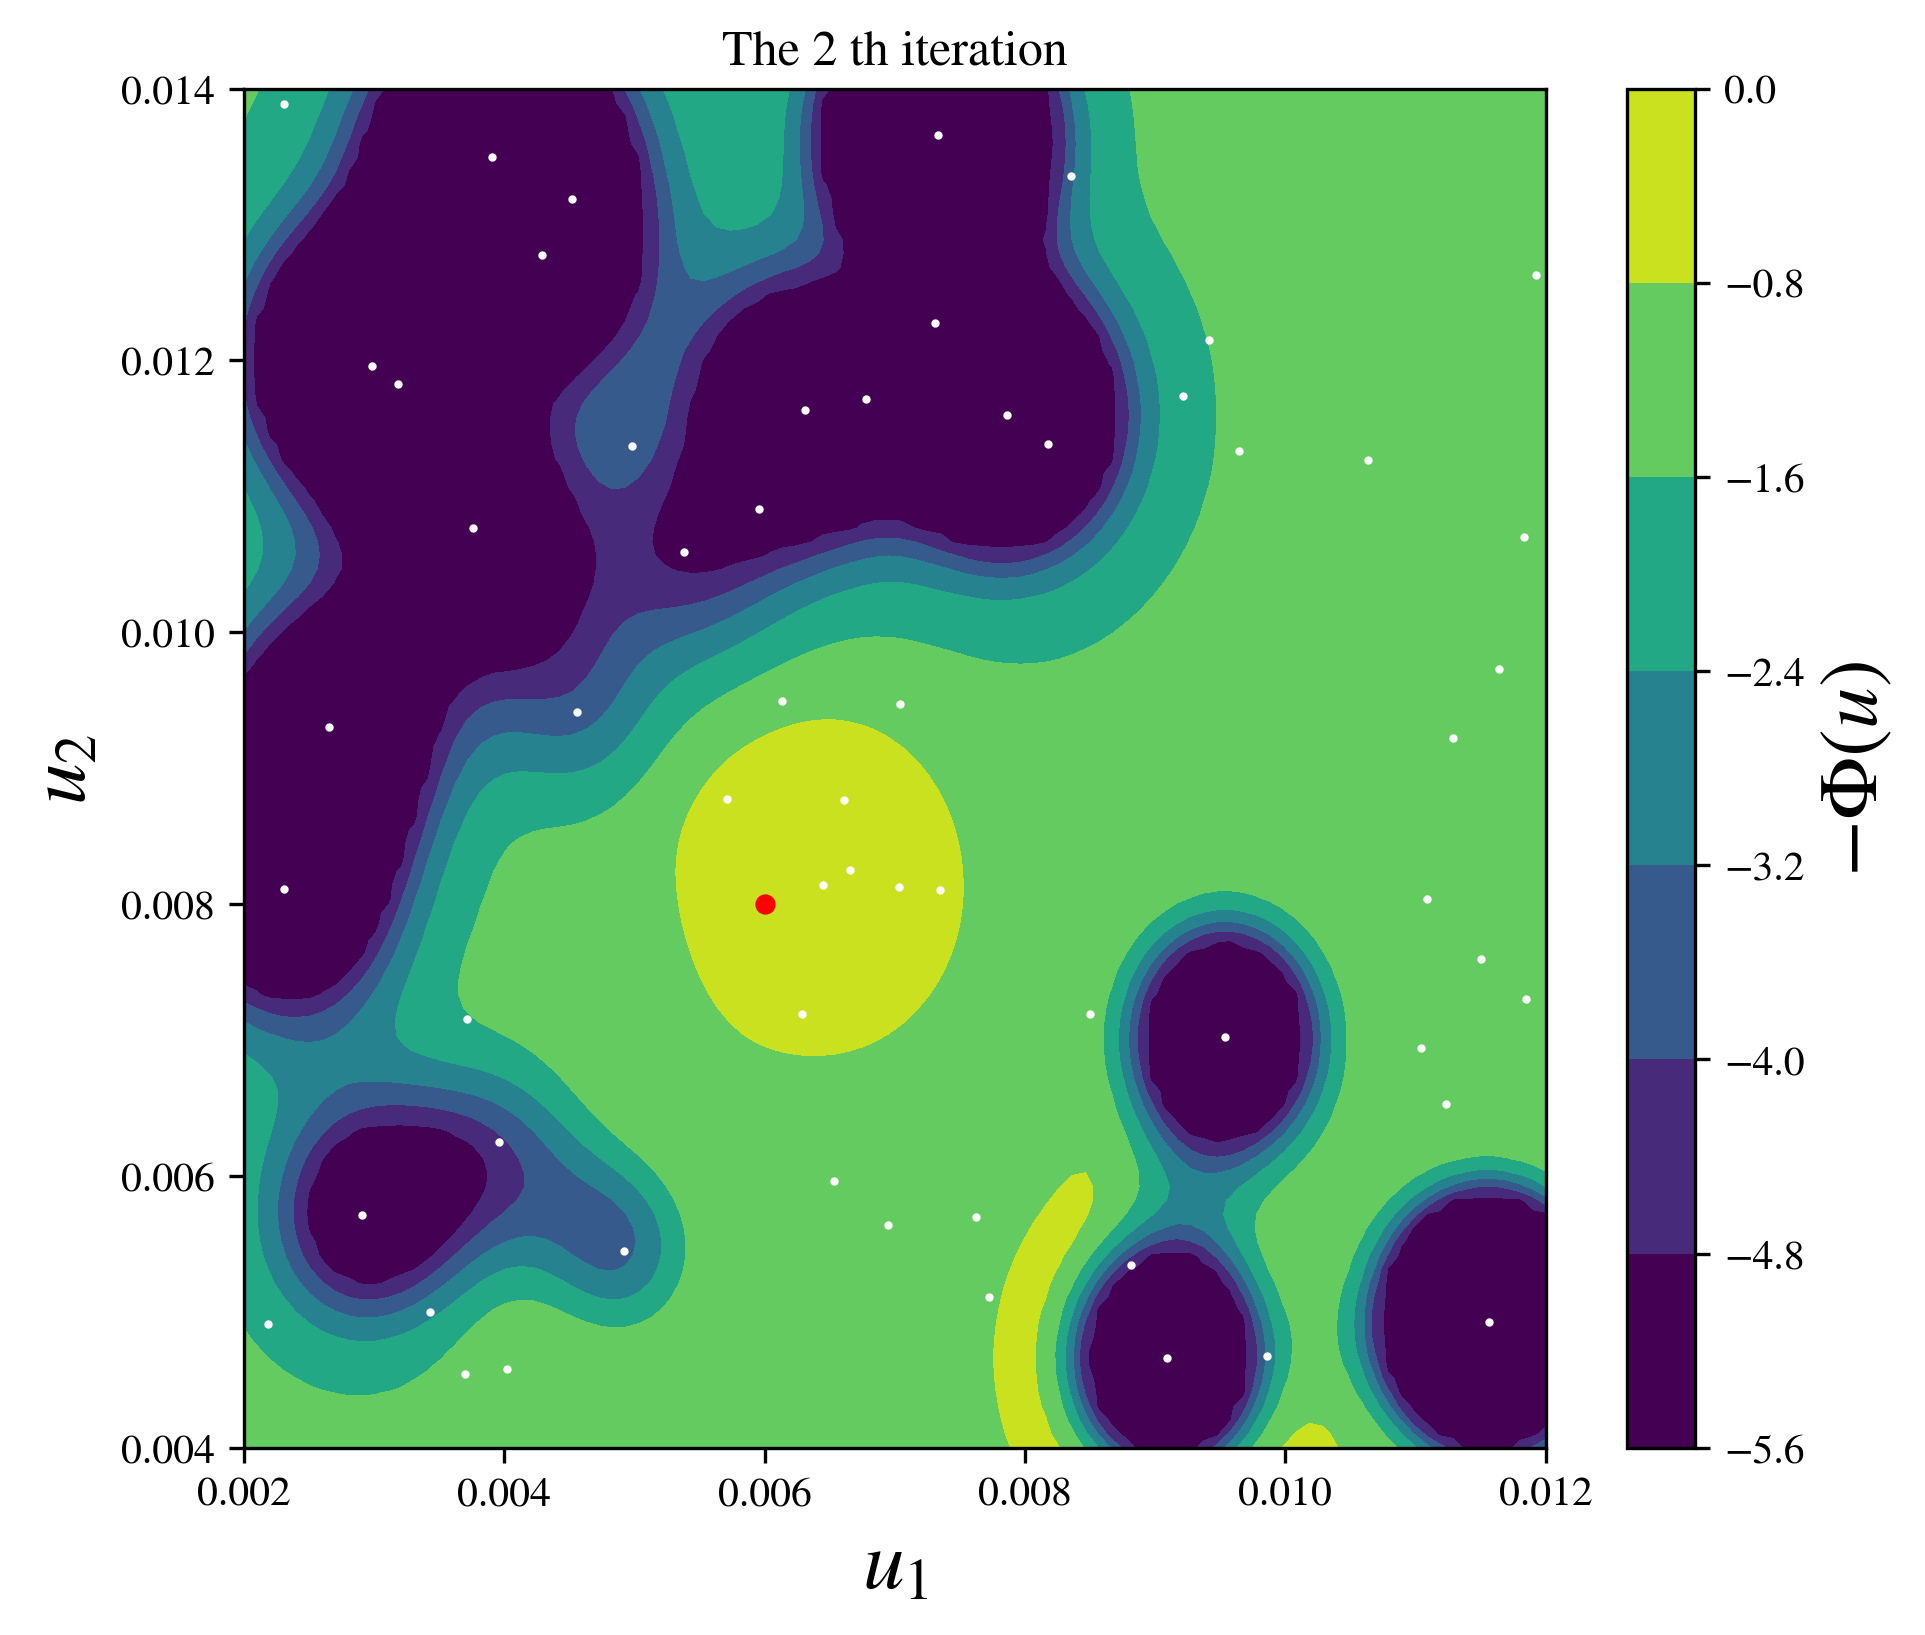

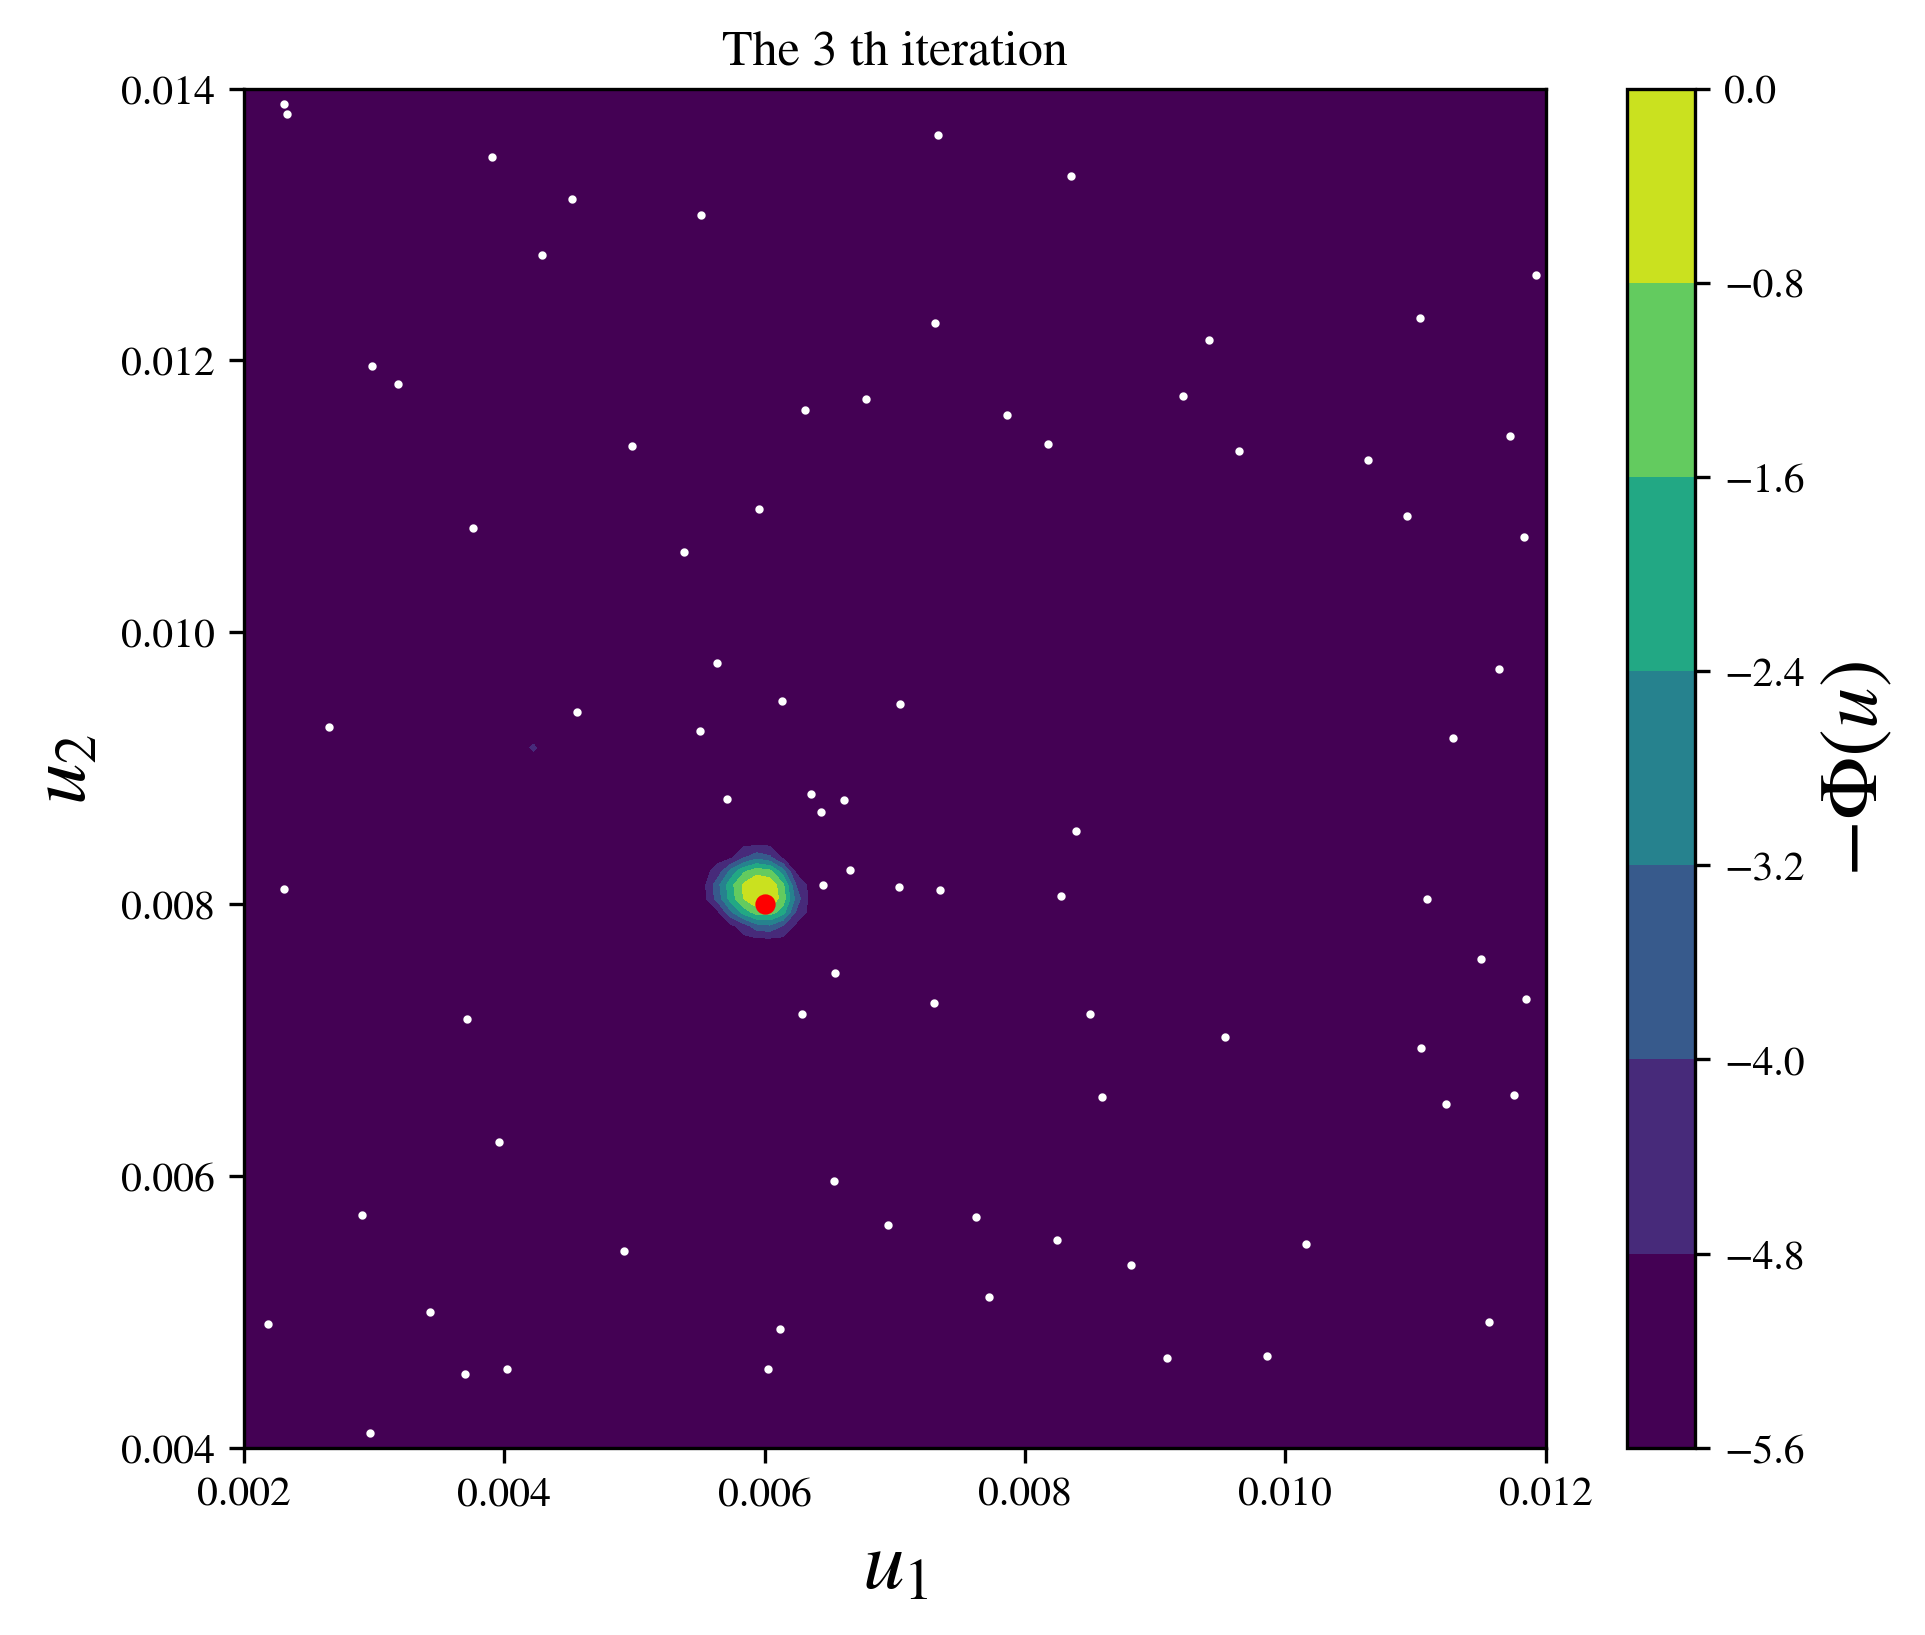

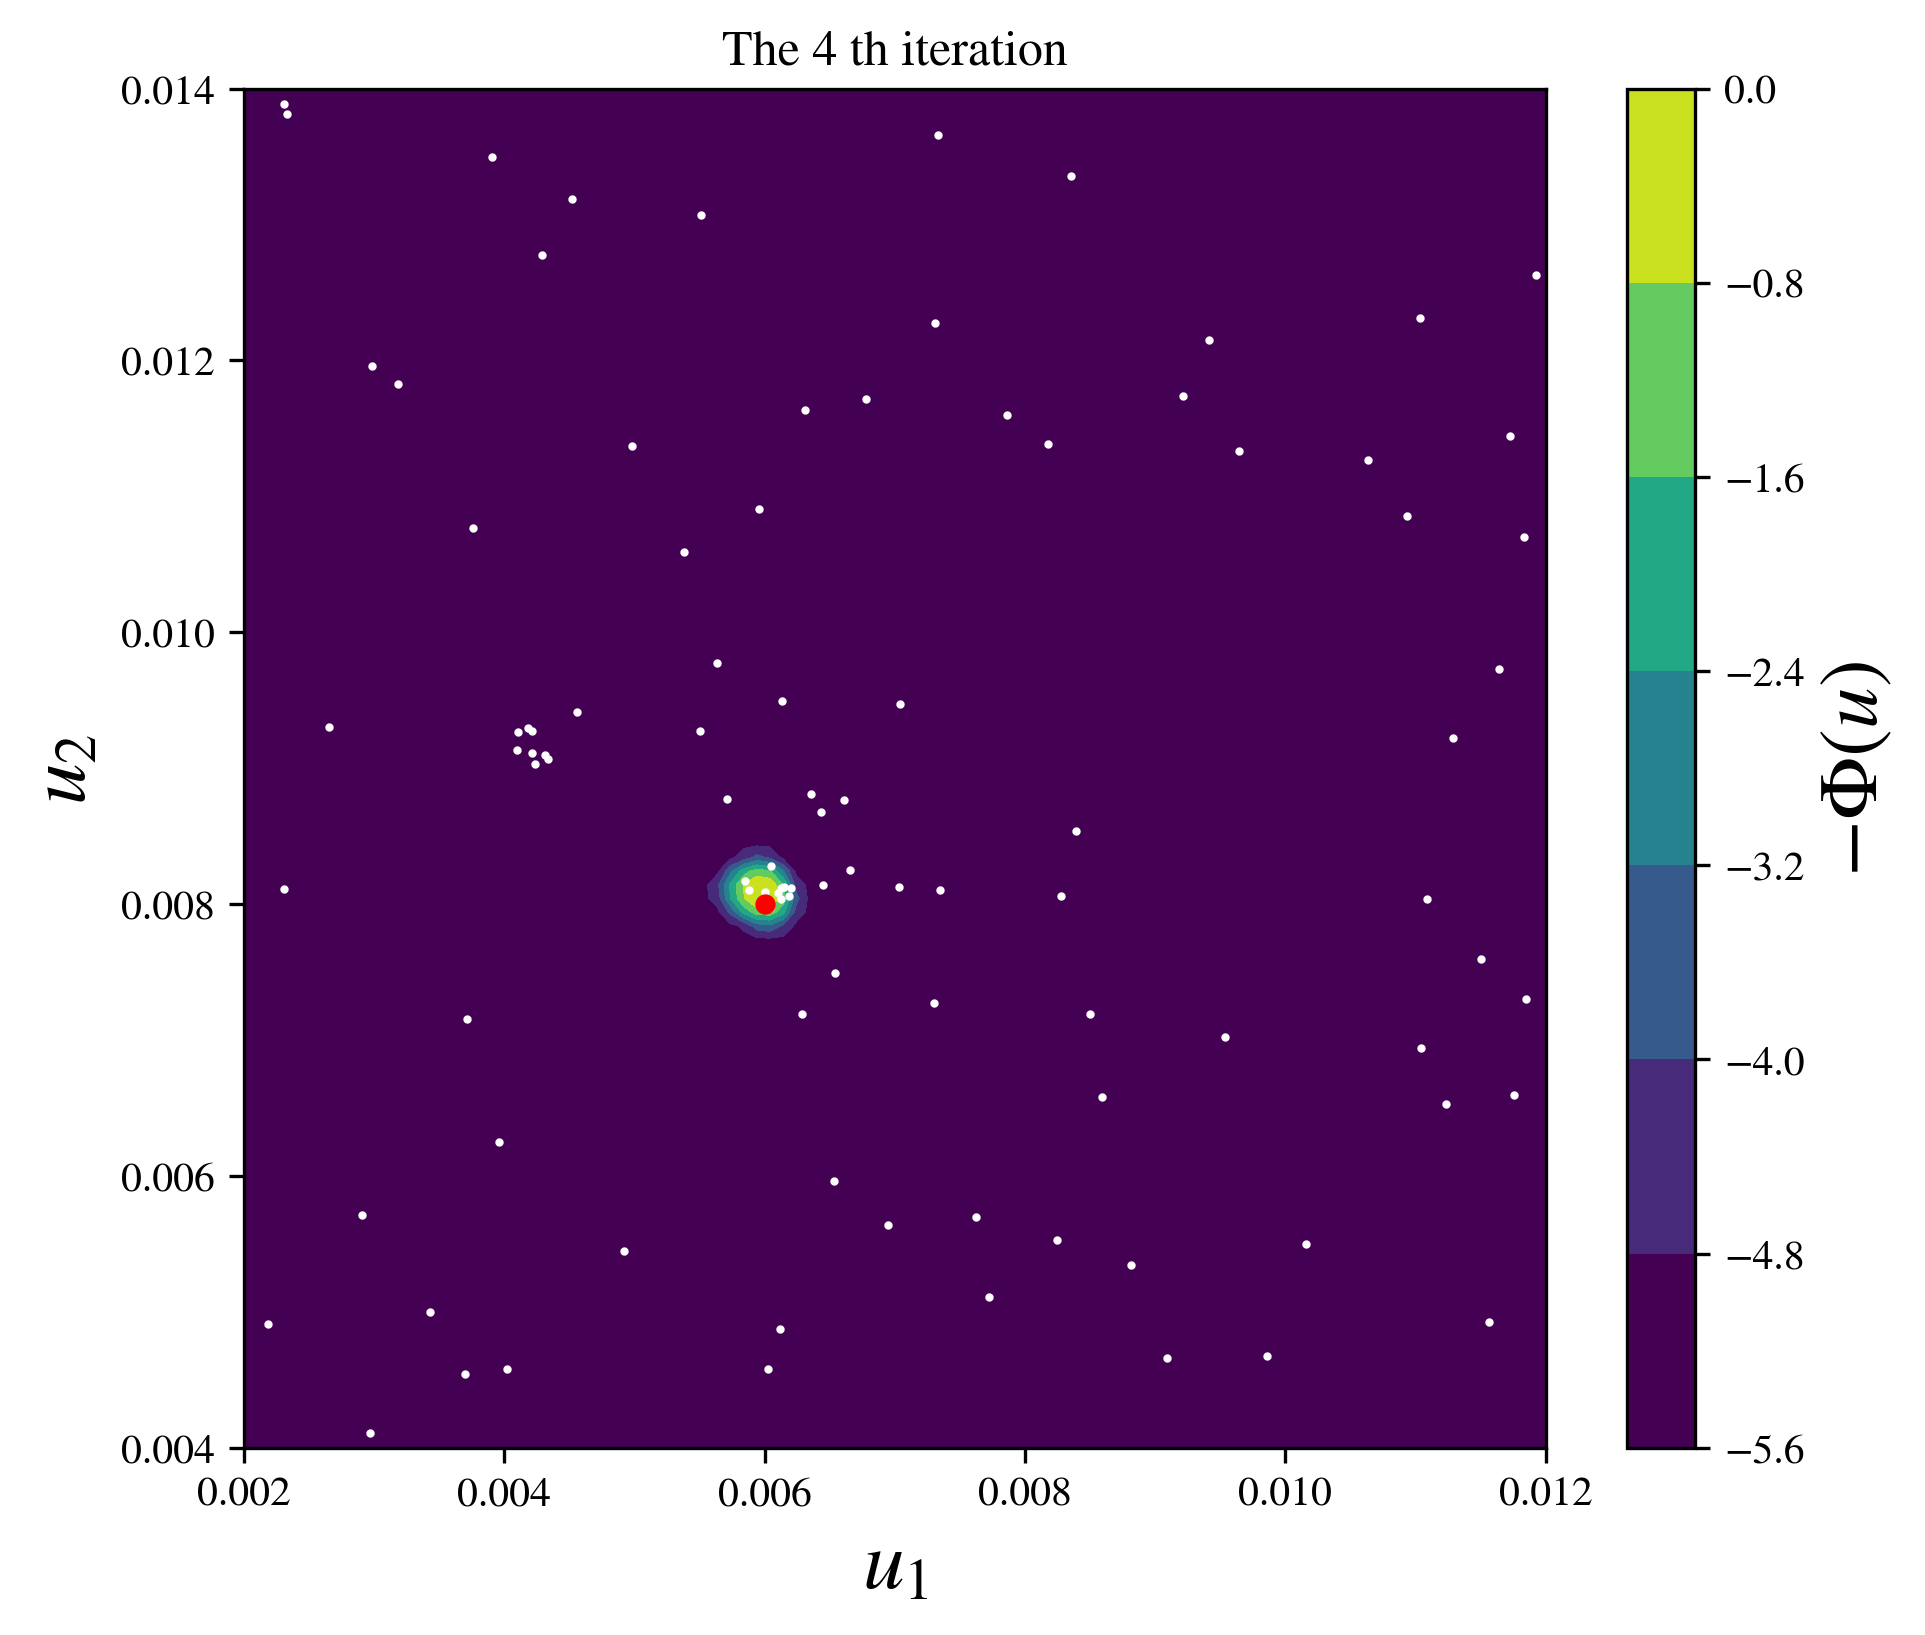

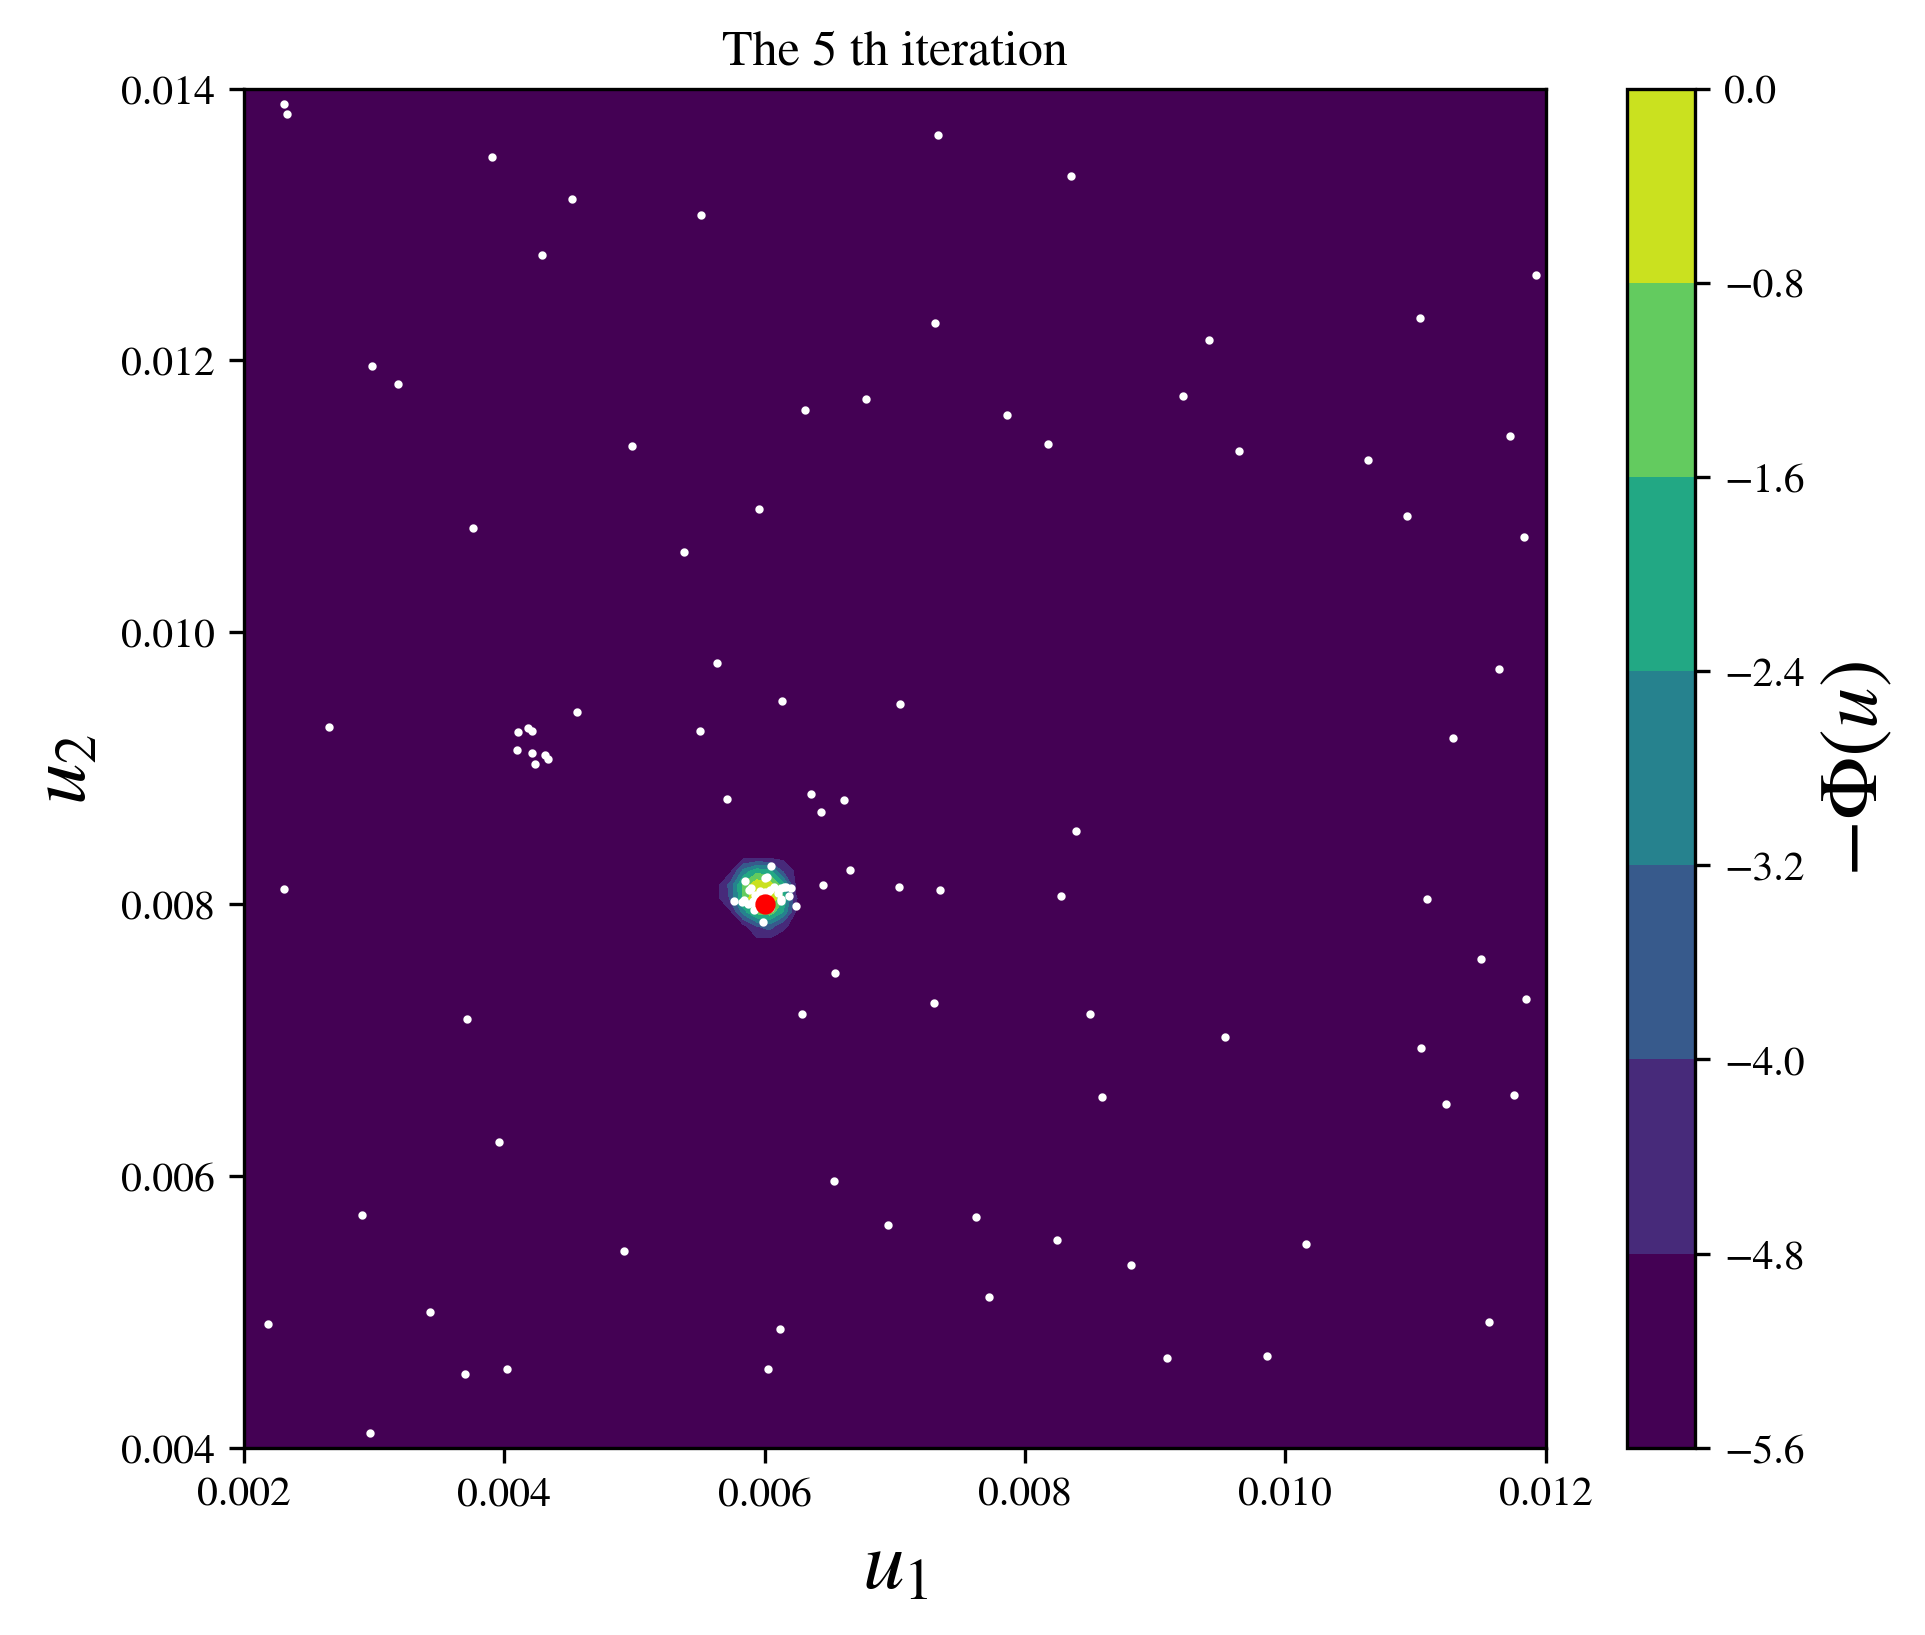

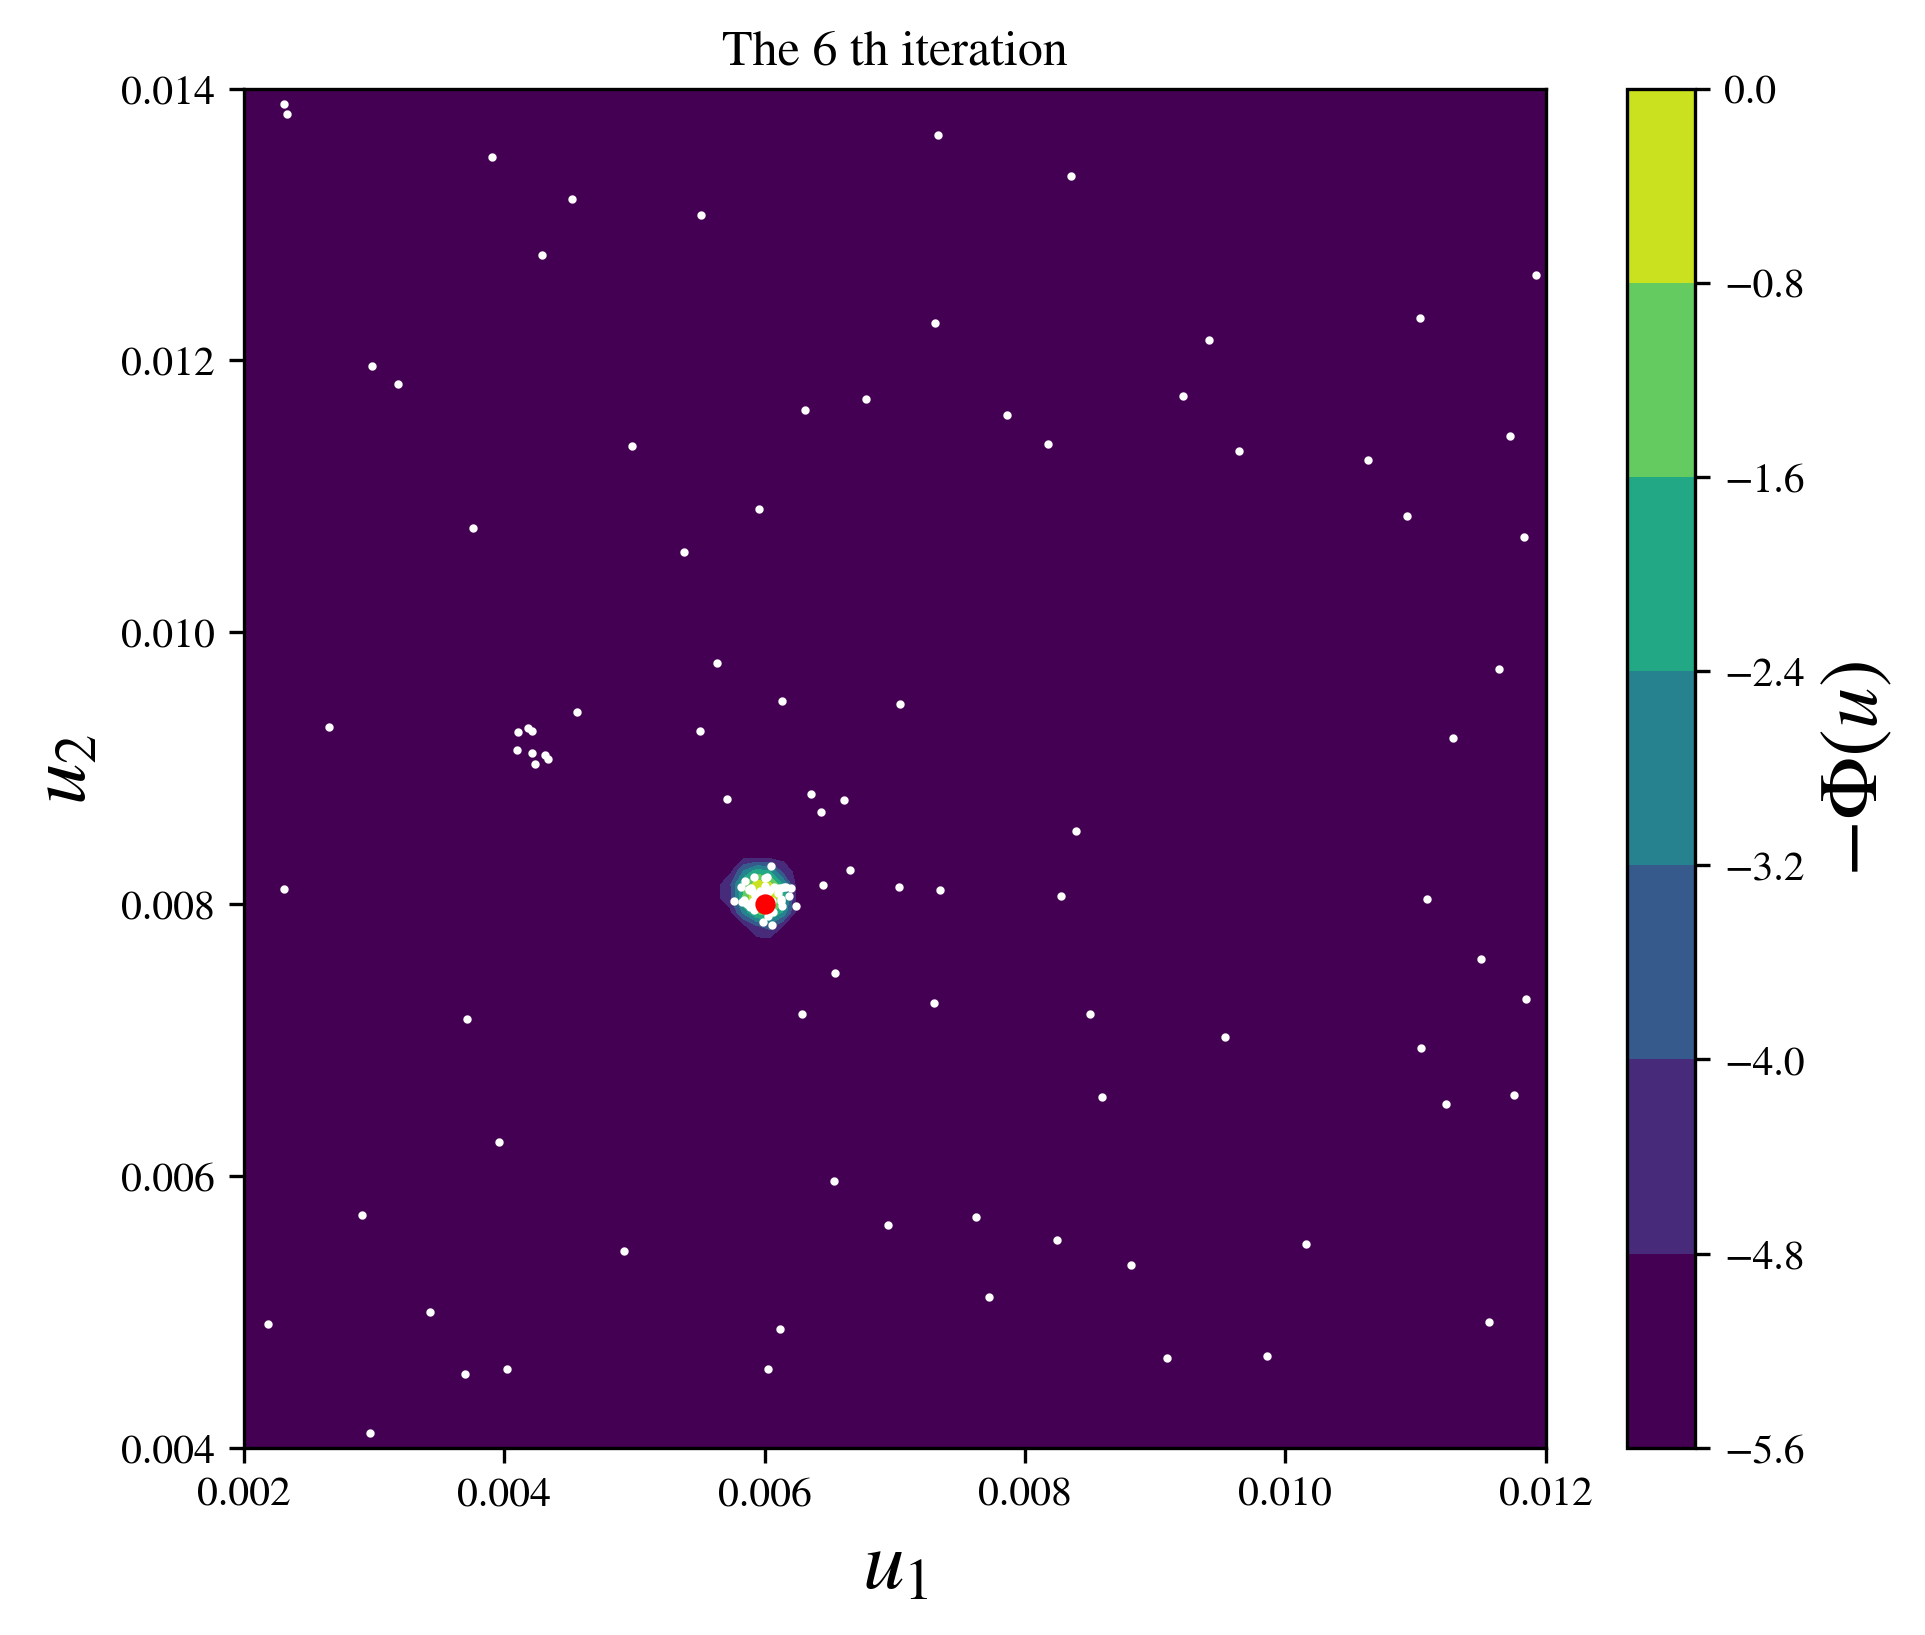

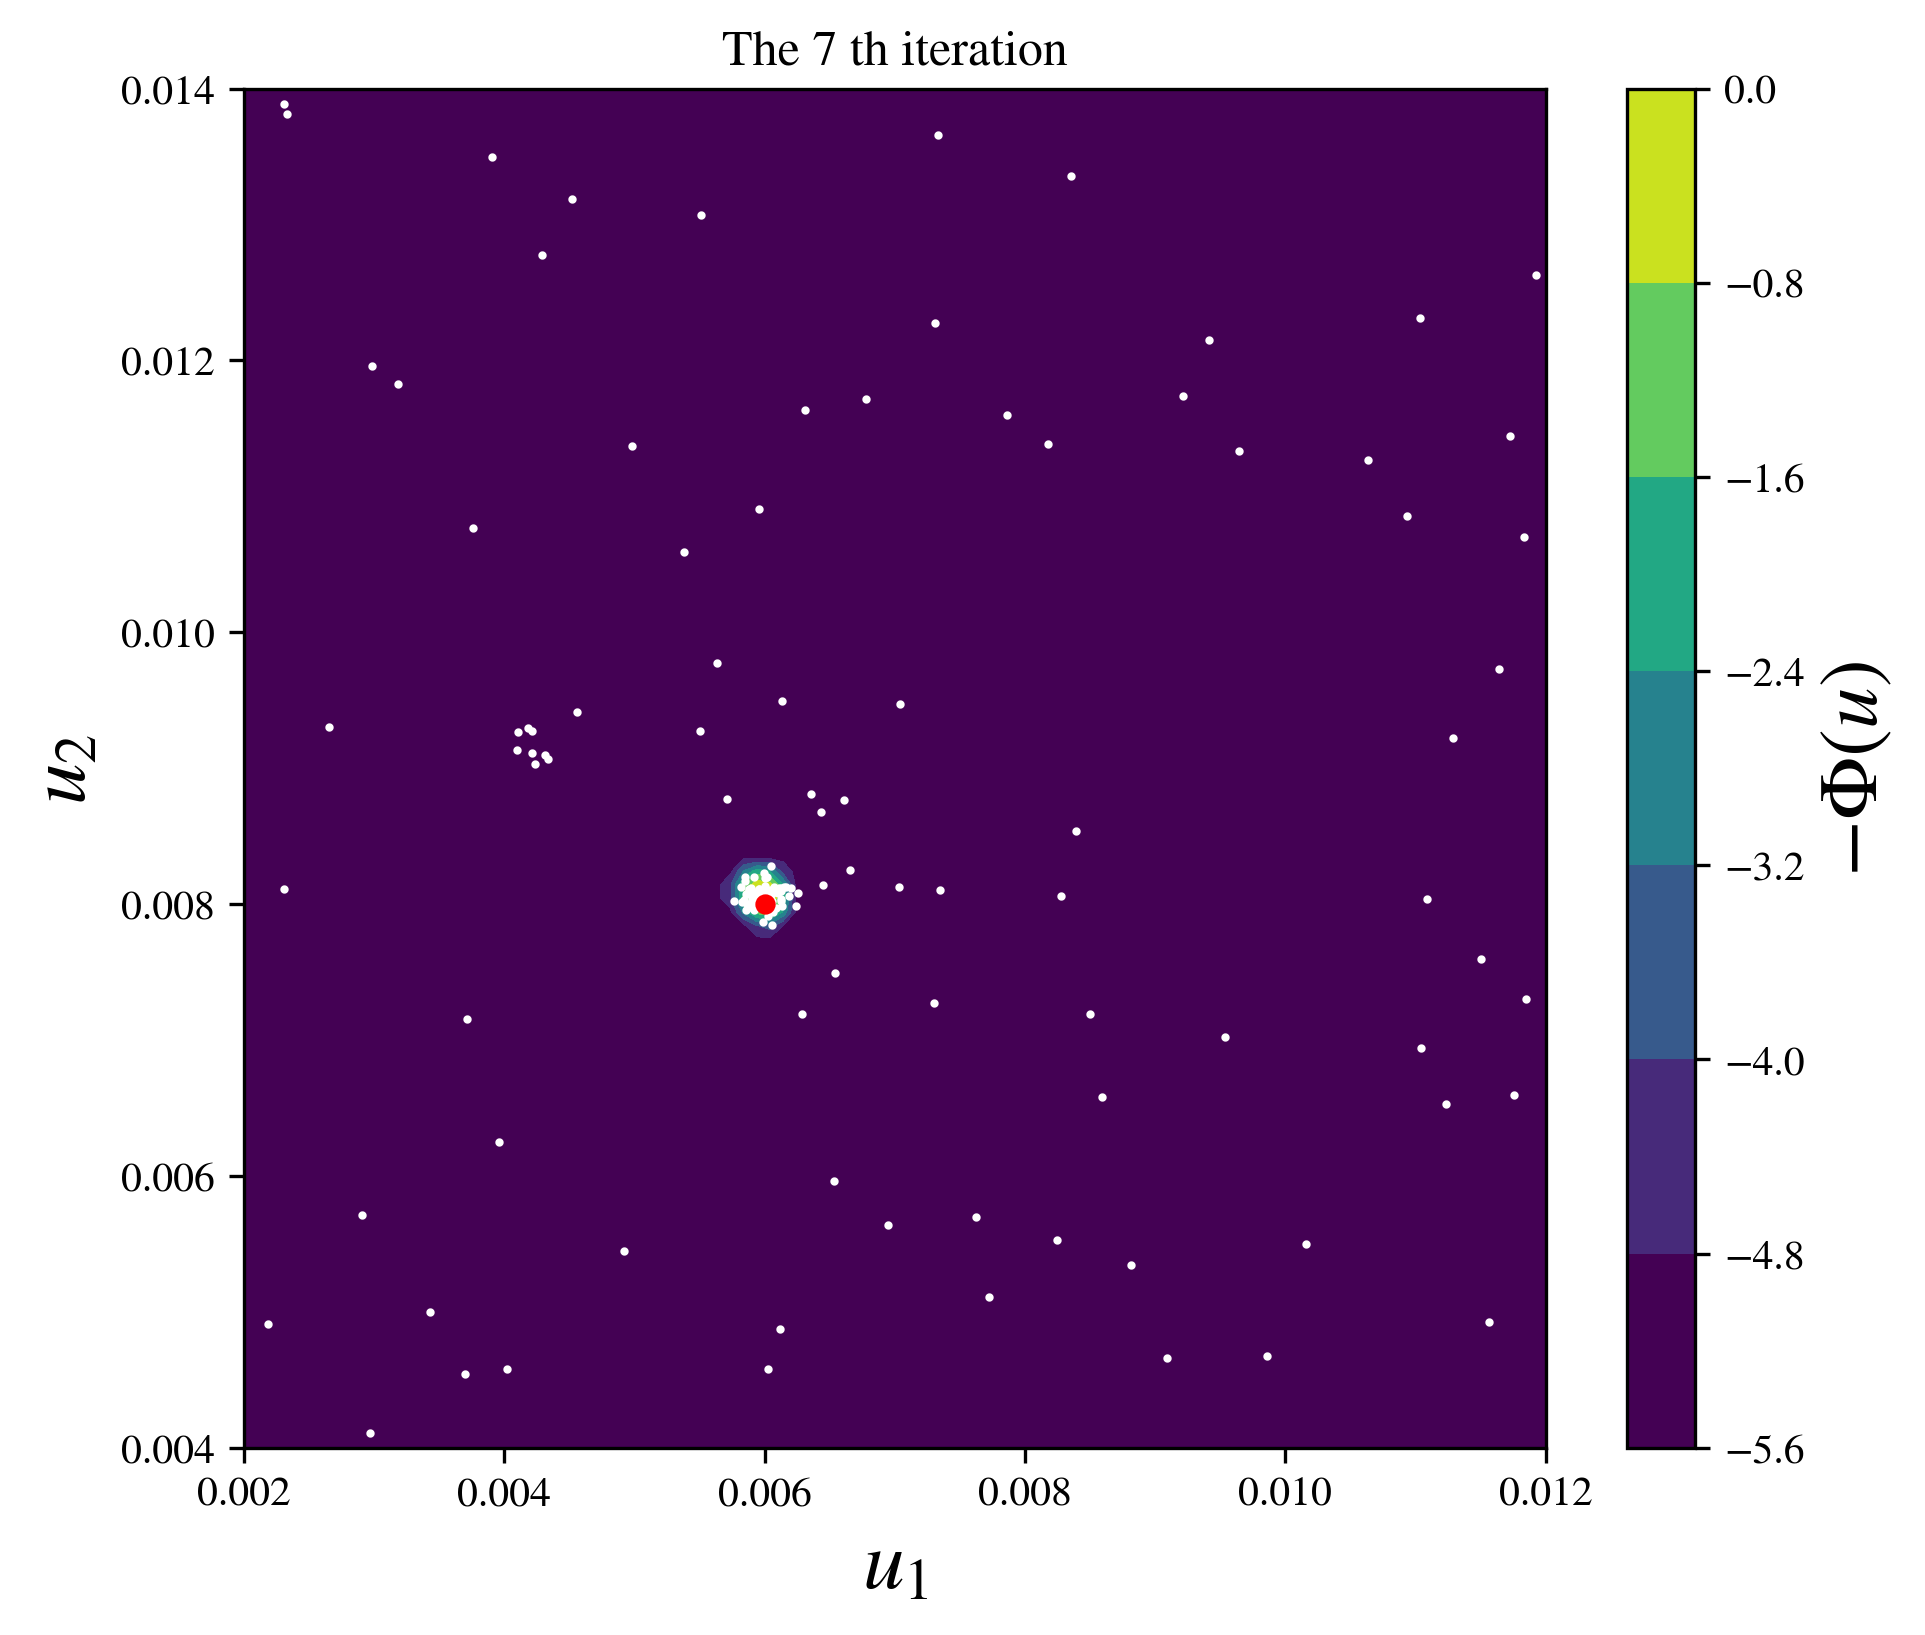

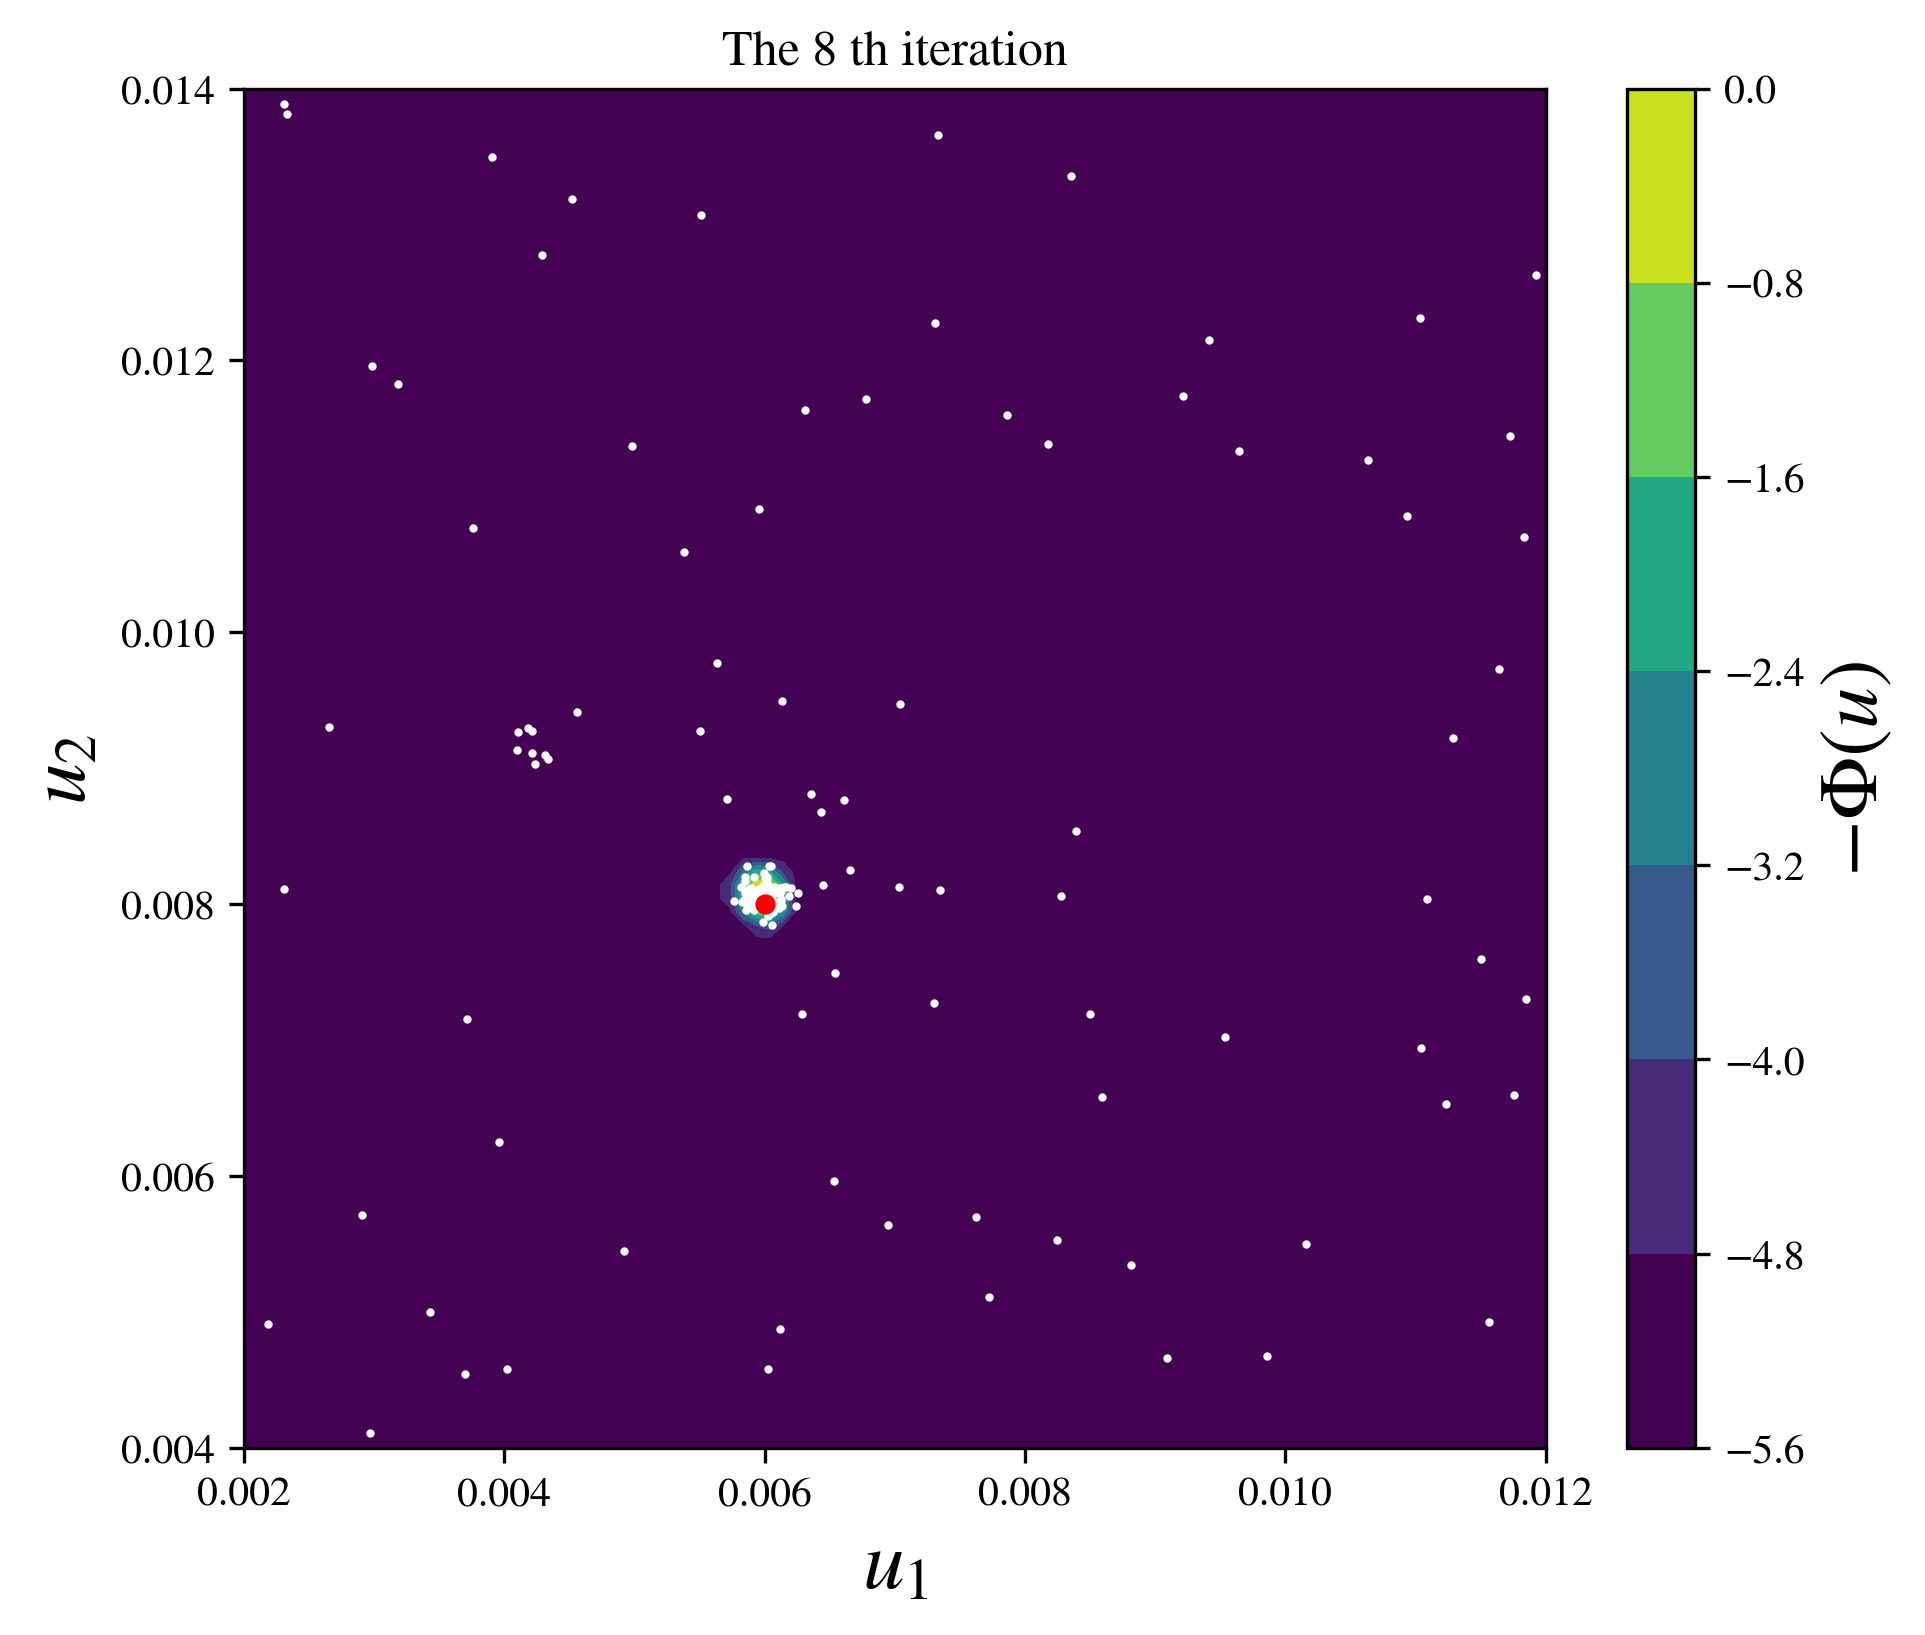

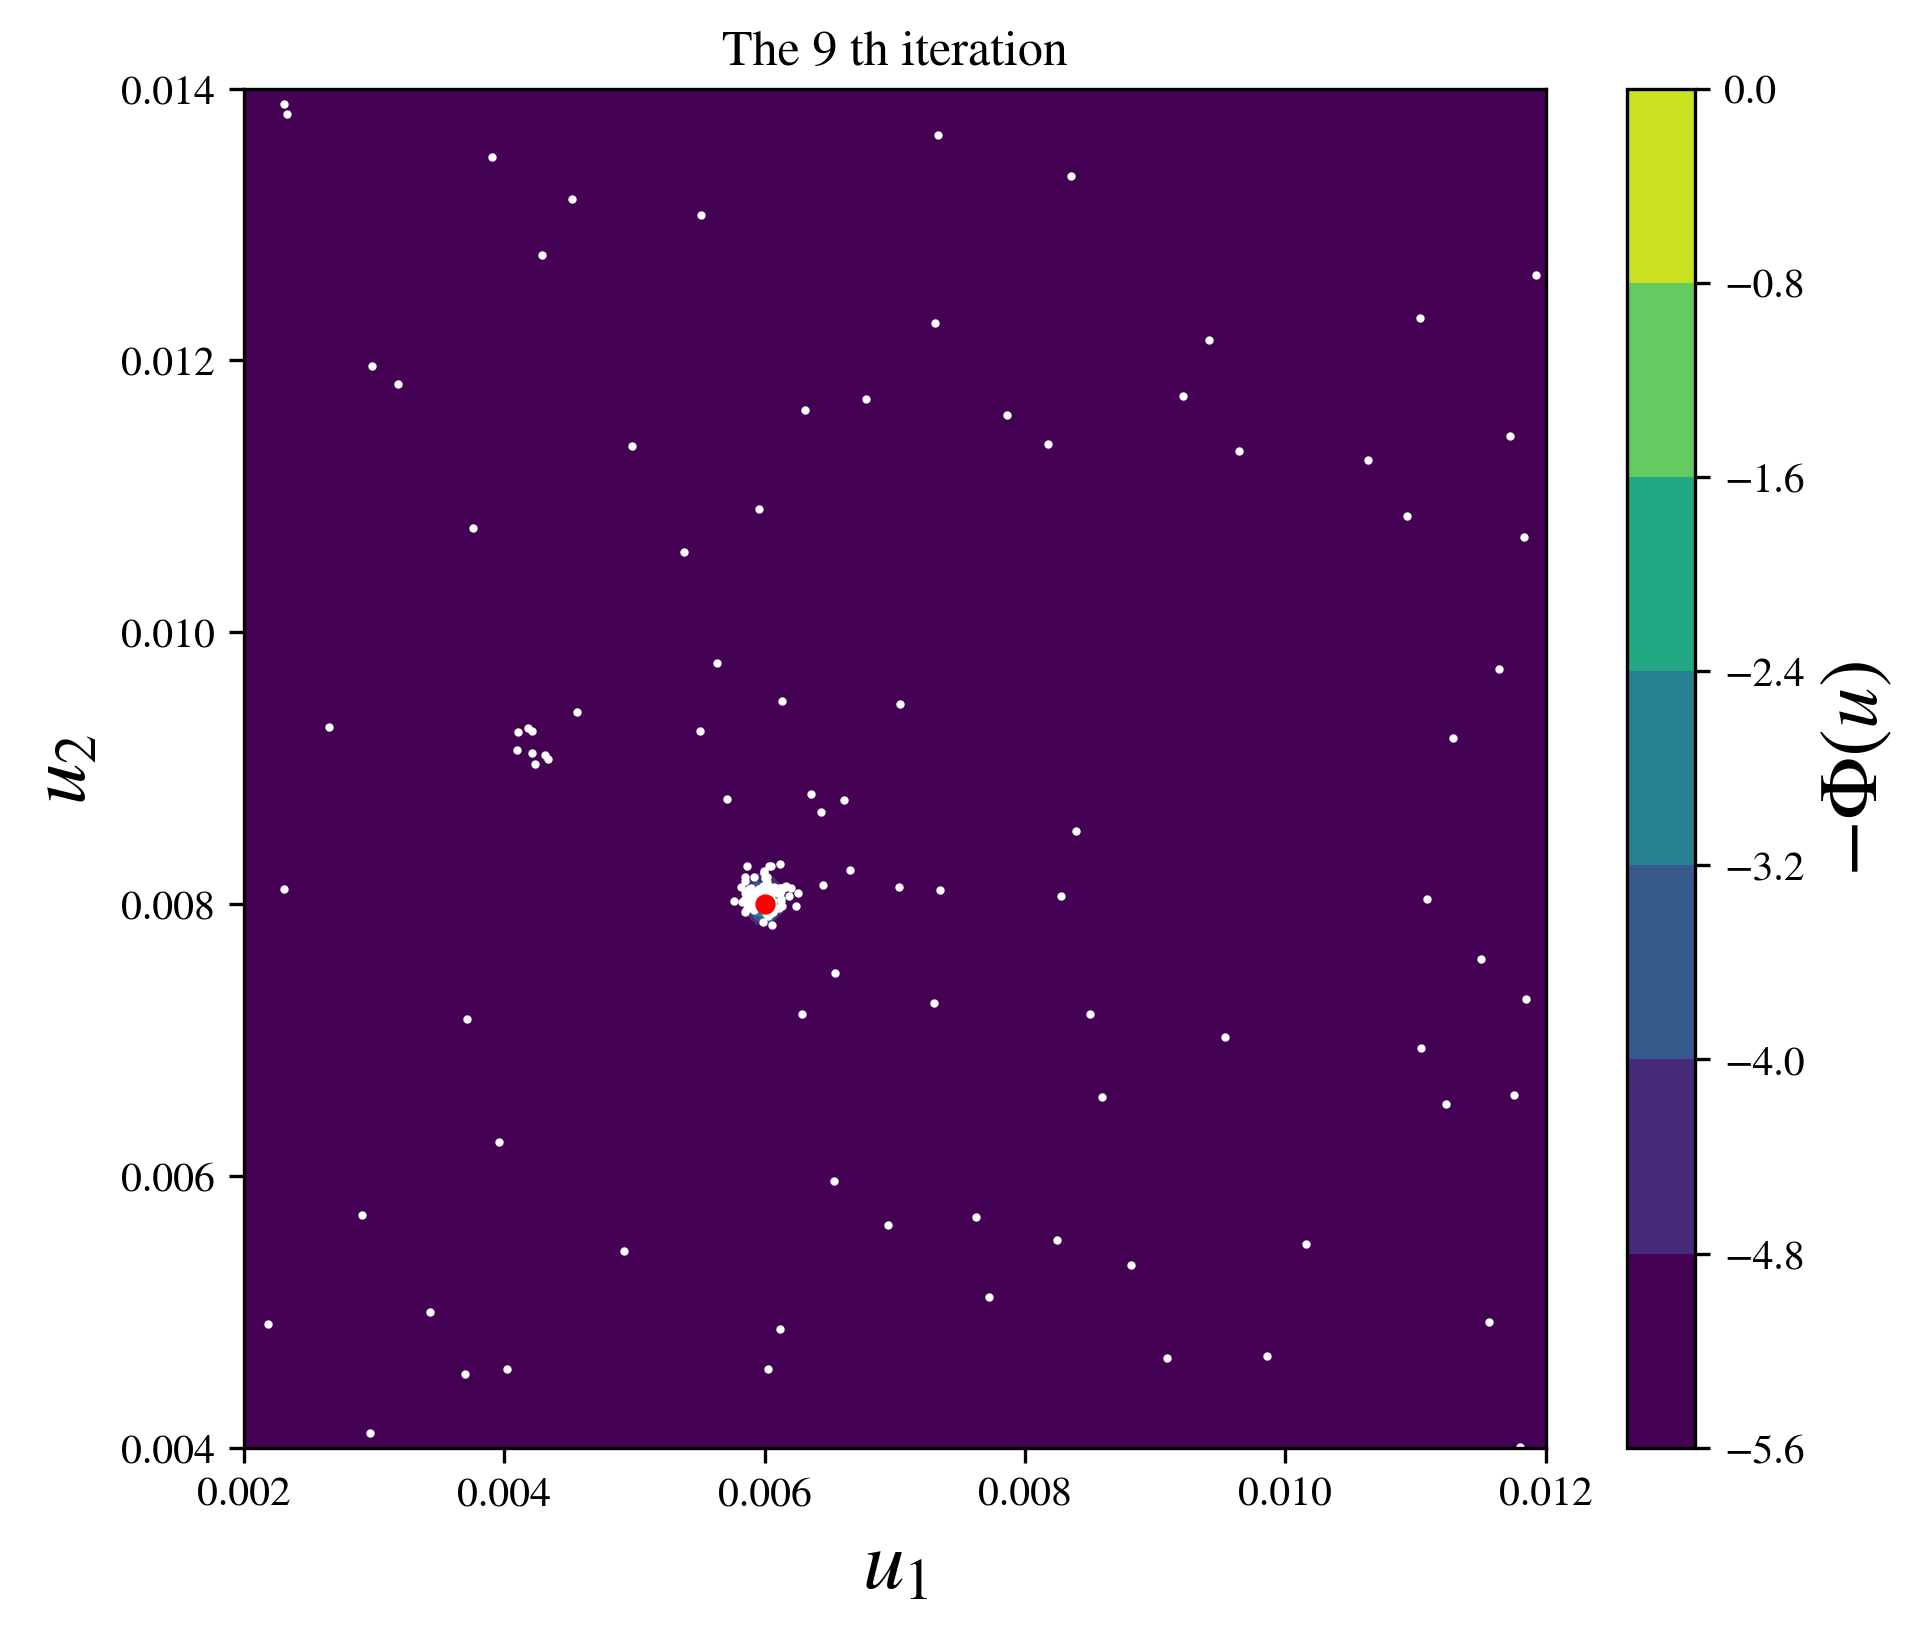

In [644]:
# Load from file
with open(f'./models/myInvA6_B8.pickle', 'rb') as file2:
    myInvA6_B8 = pickle.load(file2)


testCase_idx = 2 # 1 for 4_6, 2 for 6_8
y = testBatch.Observations[testCase_idx]
u = testBatch.input_set[testCase_idx]

myFigs = plotSeries(myInvA6_B8, u, y)

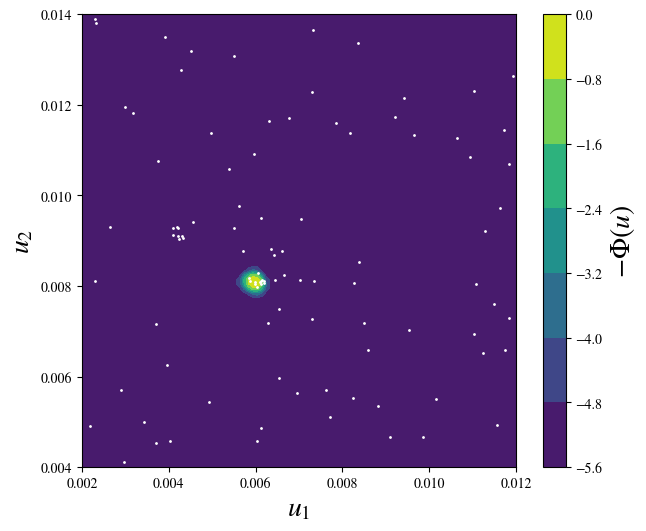

In [557]:
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [513]:
# Calculate U_plot
minU = myInv.u_low
maxU = myInv.u_high
nOfGridPoints = 100
bestIteration = 5

xis = []
for i in range(minU.shape[0]):
    xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

# Generate grid and draw predictions
UPlotGrid = np.meshgrid(xis[0], xis[1])
UPlotGrid = np.stack(UPlotGrid, axis = 2)
UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
# UPlotGridFat_scaled = U_scaler.transform(UPlotGridFat)
YPlotGridFat = log_prob_best(myInv, bestIteration - 1, UPlotGridFat, y)
YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])

True value of $(u_1, u_2)$:  (0.006, 0.008)
Maximum likelihood estimate of $(u_1, u_2)$:  [0.00593939 0.00814141]


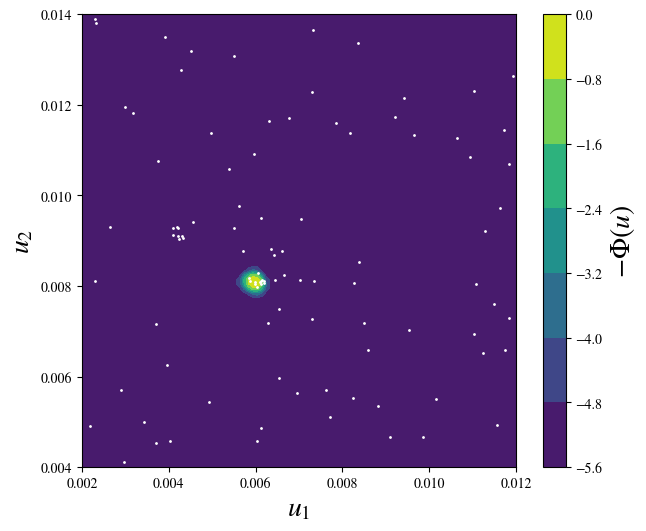

In [514]:
# Plot figure
fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)

# Plot the surface.
# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

cp = ax.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))

# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, rstride=1, cstride=1, cmap=cm.hsv, \
#   edgecolor='darkred', linewidth=0.1)
cbar = fig.colorbar(cp)

ax.scatter(myInv.U[ :bestIteration * myInv.n_samples, 0], 
           myInv.U[ :bestIteration * myInv.n_samples, 1], s = 1, color = 'white')
    
ax.set_xlabel('$u_1$', fontsize = 20)
ax.set_ylabel('$u_2$', fontsize = 20)
cbar.set_label('$-\\Phi(u)$', fontsize = 20)

# ax.set_zlabel('Unnormalized $d\mu(u)$', fontsize = 20)

# plt.scatter(U.reshape([-1]), np.linalg.norm(y - Y, axis = 1) ** 2)

# # Customize z axis
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
ind = np.unravel_index(np.argmax(YPlotGrid, axis=None), YPlotGrid.shape)
print("True value of $(u_1, u_2)$: ", testBatch.input_set[testCase_idx])
print("Maximum likelihood estimate of $(u_1, u_2)$: ", UPlotGrid[ind])

plt.show()

In [236]:
import scipy
from sklearn.utils.optimize import _check_optimize_result
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e06, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

# Gaussian predictor

In [659]:
# Import Gaussian-regression related functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Pre-process the data
from sklearn import preprocessing

# function train_GP
class GP_predictor:
    # Constructor
    def __init__(self, 
                 input_set, 
                 observation_set, 
                 GPkernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)), 
                 n_optimizers = 9):
        # Scale input data
        self.input_set = [list(x) for x in input_set]
        self.observation_set = [list(x) for x in observation_set]
        self.input_dimension = len(self.input_set[0])
        self.observation_dimension = len(self.observation_set[0])
        self.trainset_length = len(self.input_set)
        
        self.input_scaler = preprocessing.StandardScaler()
        self.input_scaler.fit(np.array(self.input_set))
        
        # Scale output data
        self.observation_scaler = preprocessing.StandardScaler()
        self.observation_scaler.fit(np.array(observation_set))
        
        # Fit Gaussian process
        self.GP = GaussianProcessRegressor(kernel = GPkernel, n_restarts_optimizer = n_optimizers)
        # self.GP = MyGPR(kernel = GPkernel, n_restarts_optimizer = n_optimizers, max_iter = max_iterations)
        self.GP.fit(self.input_scaler.transform(np.array(self.input_set)), 
                    self.observation_scaler.transform(np.array(self.observation_set)))
        
    # Predict on a new input set
    def predict(self, new_input_set):
        # Predict new observation
        new_observation = self.observation_scaler.inverse_transform(
            self.GP.predict(
                self.input_scaler.transform(np.array(list(new_input_set)).reshape([-1, self.input_dimension]))
            )
        )
        
        return new_observation
        
    

In [69]:
# Generate a set, run cases, get observations

In [ ]:
myGP = GP_predictor(input_set, )